In [2]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [3]:
for no in ['A','B','C','D']:
    tracks[no] = tracks[no][['date', 'キロ程', '高低左']]

In [ ]:
%matplotlib inline

In [4]:
import datetime
from tqdm import tqdm
import random
import sys

In [5]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [6]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [7]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                                                            df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [9]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [10]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [11]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [68]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [12]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [13]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [14]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [15]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

In [ ]:
def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

In [ ]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    normal_id = remove_outliers(data)
    datal = data.loc[normal_id]

    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [ ]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [ ]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary5_{no}.csv', index_col=0)

In [ ]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == -100, '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

In [16]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i}'] = train['slope'].shift(i+1)

In [ ]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r")

In [ ]:
check = pd.DataFrame()
check['raw'] = y_train
check['lgbm'] = train_pred
check['diff'] = abs(y_train - train_pred)
check = check.sort_values('diff', ascending=False)

In [ ]:
check

In [ ]:
danger = check[:10].index.values

In [ ]:
danger

In [ ]:
summary = summarys['A']
summary.loc[danger]

In [ ]:
fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)

track = tracks['A']
summary = summarys['A']
danger = check[:50].index.values
kilos = summary.loc[danger, 'キロ程'].values.astype(int)
slope = check.loc[danger, 'raw'].values
lgbm = check.loc[danger, 'lgbm'].values
# slope = summary.loc[danger, '傾き'].values
inter = summary.loc[danger, '切片'].values

for i, kilo in enumerate(kilos):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')
    axes[i].set_title(f'{kilo}, slope={slope[i]}, lgbm={lgbm[i]}, {inter[i]}', color='w')

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [ ]:
def get_slope(day, koutei):
    if len(day) == 0:
        print('!!!!!   no data... why?   !!!!!\n*10')
        return -100
    X = day
    X = [[float(x)] for x in X]
    y = koutei

    lr.fit(X, y)
    slope = lr.coef_[0]

    return slope

In [ ]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [ ]:
nan_kilo = []
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    full_kilos = [i for i in range(10000, 10000+len(track['キロ程'].unique()))]
    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)
#     kilos = np.array(track['キロ程'].unique())
    kilos = track['キロ程'].unique()
#     print(max(full_kilos))
#     print(max(kilos))
#     print(full_kilos[:10])
#     print(kilos[:10])
    nan_kilo.append(set(full_kilos) - set(kilos))

In [ ]:
len(nan_kilo[3])
nan_kilo[3]

In [ ]:
%%time
random.seed(0)
from scipy.optimize import minimize

for no in tqdm(['A', 'B', 'C', 'D']):
    track = tracks[no]
#     equipment = equipments[no]
#     track = track.dropna(subset=['高低左'])
#     track = track.reset_index(drop=True)

#     kilos = random.sample(list(track['キロ程'].unique()), 100)
#     kilos = track['キロ程'].unique()[:10]
#     track = track[track['キロ程'].isin(kilos)]
#     track = track.reset_index(drop=True)
#    equipment = equipment[equipment['キロ程'].isin(kilos)]
#    equipment = equipment.reset_index(drop=True)

#     kilos = track['キロ程'].unique()
#     kilos = track['キロ程'].unique()[:10]
    kilos = [13387,
             13388,
             13389,
             13390,
             13391,
             13392,
             13393,
             13394,
             13395,
             13396,
             13397,
             13398,
             13399,
             13400,
             13401,
             13402,]

    slopes = []
    sokuteis = []
    last_medians = []
    num_datas = []
    sigmas = []
    for kilo in tqdm(kilos):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        print(len(data))
        data = data.dropna(subset=['高低左'])
        print(len(data))
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        data = data.drop('date', axis=1)
        sokutei = len(data)
        sokuteis.append(sokutei)
        kouteis = data['高低左'].values
#         last_median = np.median(kouteis[-30:])
        last_median = 0
        last_medians.append(last_median)
        sigma = kouteis[-30:].std(ddof=1)
        sigmas.append(sigma)
        if sokutei < 30:
            num_data = -100
            num_datas.append(num_data)
            slope = -100
            slopes.append(slope)
            continue

        normal_id = remove_outliers(data)
        data = data.loc[normal_id]
        data = data.reset_index(drop=True)
        num_data = len(data)
        num_datas.append(num_data)
        if num_data < 10:
            print('!!!   len(data) < 10 after remove_outliers   !!!')
            print(no, kilo)
            slope = -100
            slopes.append(slope)
            continue
        days = data['day']
        kouteis = data['高低左']
        slope = get_slope(days, kouteis)
        slopes.append(slope)

    summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '切片', '標本標準偏差', '測定回数', 'データ数'])
    summary['キロ程'] = kilos
    summary['路線'] = no
    summary['切片'] = last_medians
    summary['測定回数'] = sokuteis
    summary['データ数'] = num_datas
    summary['傾き'] = slopes
    summary['標本標準偏差'] = sigmas

#     summary = pd.concat([summary, equipment.drop('キロ程', axis=1)], axis=1)
    summary.to_csv(f'summary12_{no}.csv')

In [ ]:
summary

In [ ]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [17]:
summarys = {}
for no in ['A','B','C','D']:
    summarys[no] = pd.read_csv("summary12_" + no + ".csv", index_col=0)

In [18]:
import pandas_profiling as pdp

# 切片を3月中（day>333）データから異常値除去後の中央値にする

In [69]:
%%time
for i, no in tqdm(enumerate(['A', 'B', 'C', 'D'])):
    track = tracks[no]
    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)

    summary = summarys[no]
    kilos = summary['キロ程'].values
    interceptions = []
    for kilo in tqdm(kilos):
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna(subset=['高低左'])
        data = data.reset_index(drop=True)

        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        if len(data) == 0:
            print(f'{kilo}    !!! len(data) == 0 !!!')
            interceptions.append(np.median(track.loc[track['キロ程'] == kilo, '高低左'].values[-10:]))
            continue
        if len(data) < 4:
            print(kilo)
            interceptions.append(np.median(data['高低左'].values))
            continue

        data['day'] = get_day(data['date'])
        data = data.drop(['date'], axis=1)
        normal_id = kd_outliers1(data)
        data = data.loc[normal_id]
        interceptions.append(np.median(data['高低左'].values))
    summarys[no]['切片'] = interceptions



0it [00:00, ?it/s]


  0%|          | 0/27906 [00:00<?, ?it/s]


  0%|          | 2/27906 [00:00<23:19, 19.94it/s]


  0%|          | 3/27906 [00:00<37:34, 12.38it/s]


  0%|          | 5/27906 [00:00<33:21, 13.94it/s]


  0%|          | 8/27906 [00:00<29:19, 15.86it/s]


  0%|          | 10/27906 [00:00<28:24, 16.37it/s]


  0%|          | 13/27906 [00:00<25:31, 18.21it/s]


  0%|          | 15/27906 [00:00<25:18, 18.36it/s]


  0%|          | 17/27906 [00:00<25:15, 18.40it/s]


  0%|          | 19/27906 [00:01<26:26, 17.58it/s]


  0%|          | 21/27906 [00:01<25:52, 17.96it/s]


  0%|          | 23/27906 [00:01<30:41, 15.14it/s]


  0%|          | 25/27906 [00:01<31:25, 14.79it/s]


  0%|          | 27/27906 [00:01<29:17, 15.86it/s]


  0%|          | 30/27906 [00:01<25:49, 17.99it/s]


  0%|          | 32/27906 [00:01<26:41, 17.40it/s]


  0%|          | 35/27906 [00:01<25:03, 18.54it/s]


  0%|          | 38/27906 [00:02<23:20, 19.90it/s]


  0%|          | 41/27906 [00:02<24:

10311    !!! len(data) == 0 !!!
10312    !!! len(data) == 0 !!!
10313    !!! len(data) == 0 !!!
10314    !!! len(data) == 0 !!!





  1%|          | 319/27906 [00:14<15:30, 29.63it/s]


  1%|          | 322/27906 [00:14<16:06, 28.55it/s]


  1%|          | 325/27906 [00:14<16:34, 27.74it/s]


  1%|          | 328/27906 [00:14<16:41, 27.53it/s]


  1%|          | 331/27906 [00:14<16:33, 27.77it/s]


  1%|          | 334/27906 [00:14<16:25, 27.98it/s]


  1%|          | 338/27906 [00:15<15:49, 29.03it/s]


  1%|          | 341/27906 [00:15<15:41, 29.26it/s]


  1%|          | 344/27906 [00:15<16:30, 27.83it/s]


  1%|          | 348/27906 [00:15<15:54, 28.87it/s]


  1%|▏         | 352/27906 [00:15<15:14, 30.12it/s]


  1%|▏         | 356/27906 [00:15<14:46, 31.06it/s]


  1%|▏         | 360/27906 [00:15<14:32, 31.56it/s]


  1%|▏         | 364/27906 [00:15<15:00, 30.58it/s]


  1%|▏         | 368/27906 [00:16<18:40, 24.58it/s]


  1%|▏         | 371/27906 [00:16<23:32, 19.49it/s]


  1%|▏         | 374/27906 [00:16<24:03, 19.07it/s]


  1%|▏         | 377/27906 [00:16<27:24, 16.74it/s]


  1%|▏         | 379/2790

  2%|▏         | 625/27906 [00:32<32:13, 14.11it/s]


  2%|▏         | 627/27906 [00:33<33:10, 13.71it/s]


  2%|▏         | 629/27906 [00:33<32:00, 14.21it/s]


  2%|▏         | 631/27906 [00:33<32:17, 14.08it/s]


  2%|▏         | 633/27906 [00:33<30:48, 14.76it/s]


  2%|▏         | 635/27906 [00:33<29:14, 15.54it/s]


  2%|▏         | 638/27906 [00:33<26:18, 17.27it/s]


  2%|▏         | 642/27906 [00:33<22:51, 19.88it/s]


  2%|▏         | 645/27906 [00:33<23:33, 19.28it/s]


  2%|▏         | 648/27906 [00:34<23:04, 19.69it/s]


  2%|▏         | 651/27906 [00:34<24:31, 18.52it/s]


  2%|▏         | 654/27906 [00:34<23:55, 18.98it/s]


  2%|▏         | 656/27906 [00:34<25:37, 17.73it/s]


  2%|▏         | 659/27906 [00:34<24:42, 18.38it/s]


  2%|▏         | 661/27906 [00:34<25:26, 17.85it/s]


  2%|▏         | 663/27906 [00:34<27:23, 16.57it/s]


  2%|▏         | 665/27906 [00:35<26:55, 16.86it/s]


  2%|▏         | 667/27906 [00:35<26:08, 17.37it/s]


  2%|▏         | 669/27906 [

11365
11366    !!! len(data) == 0 !!!
11367    !!! len(data) == 0 !!!
11368    !!! len(data) == 0 !!!
11369    !!! len(data) == 0 !!!
11370    !!! len(data) == 0 !!!
11371    !!! len(data) == 0 !!!
11372    !!! len(data) == 0 !!!
11373    !!! len(data) == 0 !!!
11374    !!! len(data) == 0 !!!





  5%|▍         | 1378/27906 [01:04<10:08, 43.60it/s]


  5%|▍         | 1383/27906 [01:04<09:55, 44.56it/s]

11375    !!! len(data) == 0 !!!
11376    !!! len(data) == 0 !!!
11377    !!! len(data) == 0 !!!
11378    !!! len(data) == 0 !!!
11379    !!! len(data) == 0 !!!
11380    !!! len(data) == 0 !!!
11381    !!! len(data) == 0 !!!
11382    !!! len(data) == 0 !!!
11383    !!! len(data) == 0 !!!
11384    !!! len(data) == 0 !!!





  5%|▍         | 1388/27906 [01:04<09:44, 45.35it/s]


  5%|▍         | 1393/27906 [01:05<09:41, 45.56it/s]

11385    !!! len(data) == 0 !!!
11386    !!! len(data) == 0 !!!
11387    !!! len(data) == 0 !!!
11388    !!! len(data) == 0 !!!
11389    !!! len(data) == 0 !!!
11390    !!! len(data) == 0 !!!
11391    !!! len(data) == 0 !!!
11392    !!! len(data) == 0 !!!





  5%|▌         | 1398/27906 [01:05<10:15, 43.05it/s]


  5%|▌         | 1403/27906 [01:05<10:27, 42.21it/s]


  5%|▌         | 1408/27906 [01:05<10:34, 41.74it/s]


  5%|▌         | 1413/27906 [01:05<10:38, 41.49it/s]


  5%|▌         | 1418/27906 [01:05<10:40, 41.34it/s]


  5%|▌         | 1423/27906 [01:05<10:43, 41.17it/s]


  5%|▌         | 1428/27906 [01:05<10:40, 41.33it/s]


  5%|▌         | 1433/27906 [01:06<10:42, 41.19it/s]


  5%|▌         | 1438/27906 [01:06<11:01, 40.00it/s]


  5%|▌         | 1443/27906 [01:06<11:00, 40.06it/s]


  5%|▌         | 1448/27906 [01:06<11:12, 39.32it/s]


  5%|▌         | 1452/27906 [01:06<11:33, 38.12it/s]


  5%|▌         | 1457/27906 [01:06<11:18, 38.98it/s]


  5%|▌         | 1462/27906 [01:06<11:04, 39.77it/s]


  5%|▌         | 1467/27906 [01:06<10:54, 40.37it/s]


  5%|▌         | 1472/27906 [01:07<10:48, 40.74it/s]


  5%|▌         | 1477/27906 [01:07<10:42, 41.13it/s]


  5%|▌         | 1482/27906 [01:07<10:53, 40.42it/s]


  5%|▌ 

  7%|▋         | 1984/27906 [01:21<24:05, 17.93it/s]


  7%|▋         | 1987/27906 [01:21<21:30, 20.08it/s]


  7%|▋         | 1991/27906 [01:21<18:30, 23.34it/s]


  7%|▋         | 1995/27906 [01:22<16:23, 26.34it/s]


  7%|▋         | 1999/27906 [01:22<17:50, 24.20it/s]


  7%|▋         | 2003/27906 [01:22<15:52, 27.19it/s]


  7%|▋         | 2007/27906 [01:22<14:43, 29.32it/s]


  7%|▋         | 2011/27906 [01:22<14:40, 29.42it/s]


  7%|▋         | 2015/27906 [01:22<13:31, 31.91it/s]


  7%|▋         | 2019/27906 [01:22<12:49, 33.66it/s]


  7%|▋         | 2023/27906 [01:23<20:33, 20.98it/s]


  7%|▋         | 2026/27906 [01:23<25:28, 16.93it/s]


  7%|▋         | 2030/27906 [01:23<21:45, 19.81it/s]


  7%|▋         | 2034/27906 [01:23<19:22, 22.26it/s]


  7%|▋         | 2037/27906 [01:23<23:27, 18.38it/s]


  7%|▋         | 2040/27906 [01:24<24:12, 17.81it/s]


  7%|▋         | 2043/27906 [01:24<27:17, 15.79it/s]


  7%|▋         | 2045/27906 [01:24<26:28, 16.28it/s]


  7%|▋    

12560
12561
12562
12563    !!! len(data) == 0 !!!
12564    !!! len(data) == 0 !!!
12565    !!! len(data) == 0 !!!
12566    !!! len(data) == 0 !!!
12567    !!! len(data) == 0 !!!
12568    !!! len(data) == 0 !!!
12569    !!! len(data) == 0 !!!
12570    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



  9%|▉         | 2572/27906 [01:39<09:44, 43.34it/s]


  9%|▉         | 2577/27906 [01:39<09:29, 44.46it/s]

12571    !!! len(data) == 0 !!!
12572    !!! len(data) == 0 !!!
12573    !!! len(data) == 0 !!!
12574    !!! len(data) == 0 !!!
12575    !!! len(data) == 0 !!!
12576    !!! len(data) == 0 !!!
12577    !!! len(data) == 0 !!!
12578    !!! len(data) == 0 !!!
12579    !!! len(data) == 0 !!!
12580    !!! len(data) == 0 !!!





  9%|▉         | 2582/27906 [01:39<09:17, 45.40it/s]


  9%|▉         | 2587/27906 [01:39<09:07, 46.28it/s]

12581    !!! len(data) == 0 !!!
12582    !!! len(data) == 0 !!!
12583    !!! len(data) == 0 !!!
12584    !!! len(data) == 0 !!!
12585    !!! len(data) == 0 !!!
12586    !!! len(data) == 0 !!!
12587    !!! len(data) == 0 !!!
12588    !!! len(data) == 0 !!!
12589    !!! len(data) == 0 !!!
12590    !!! len(data) == 0 !!!





  9%|▉         | 2592/27906 [01:39<09:17, 45.37it/s]


  9%|▉         | 2597/27906 [01:39<09:38, 43.77it/s]


  9%|▉         | 2602/27906 [01:39<09:54, 42.59it/s]


  9%|▉         | 2607/27906 [01:40<10:02, 41.99it/s]


  9%|▉         | 2612/27906 [01:40<10:14, 41.16it/s]


  9%|▉         | 2617/27906 [01:40<13:25, 31.41it/s]


  9%|▉         | 2621/27906 [01:40<15:06, 27.88it/s]


  9%|▉         | 2625/27906 [01:40<14:30, 29.05it/s]


  9%|▉         | 2630/27906 [01:40<13:15, 31.79it/s]


  9%|▉         | 2635/27906 [01:40<12:22, 34.02it/s]


  9%|▉         | 2640/27906 [01:41<11:47, 35.70it/s]


  9%|▉         | 2644/27906 [01:41<11:44, 35.87it/s]


  9%|▉         | 2648/27906 [01:41<11:22, 36.98it/s]


 10%|▉         | 2652/27906 [01:41<11:07, 37.83it/s]


 10%|▉         | 2657/27906 [01:41<10:56, 38.46it/s]


 10%|▉         | 2661/27906 [01:41<11:16, 37.32it/s]


 10%|▉         | 2665/27906 [01:41<16:24, 25.63it/s]


 10%|▉         | 2669/27906 [01:42<15:01, 27.99it/s]


 10%|▉ 

 11%|█         | 2983/27906 [01:56<26:25, 15.72it/s]


 11%|█         | 2985/27906 [01:56<25:30, 16.28it/s]


 11%|█         | 2988/27906 [01:56<24:29, 16.96it/s]


 11%|█         | 2990/27906 [01:57<23:44, 17.49it/s]


 11%|█         | 2992/27906 [01:57<23:53, 17.38it/s]


 11%|█         | 2994/27906 [01:57<23:07, 17.96it/s]


 11%|█         | 2996/27906 [01:57<22:34, 18.40it/s]


 11%|█         | 2998/27906 [01:57<22:11, 18.71it/s]


 11%|█         | 3000/27906 [01:57<22:20, 18.57it/s]


 11%|█         | 3002/27906 [01:57<22:09, 18.73it/s]


 11%|█         | 3004/27906 [01:57<21:58, 18.89it/s]


 11%|█         | 3007/27906 [01:57<20:55, 19.83it/s]


 11%|█         | 3010/27906 [01:58<20:32, 20.20it/s]


 11%|█         | 3013/27906 [01:58<20:23, 20.35it/s]


 11%|█         | 3016/27906 [01:58<20:42, 20.03it/s]


 11%|█         | 3019/27906 [01:58<21:15, 19.51it/s]


 11%|█         | 3021/27906 [01:58<21:26, 19.35it/s]


 11%|█         | 3023/27906 [01:58<21:26, 19.35it/s]


 11%|█    

13050
13051
13052
13053
13054
13055
13056
13057





 11%|█         | 3059/27906 [02:00<15:57, 25.94it/s]


 11%|█         | 3063/27906 [02:00<15:12, 27.24it/s]

13058
13059
13060
13061
13062
13063





 11%|█         | 3066/27906 [02:00<14:56, 27.70it/s]


 11%|█         | 3070/27906 [02:00<14:12, 29.12it/s]

13064
13065
13066
13067
13068
13069
13070





 11%|█         | 3074/27906 [02:00<13:36, 30.41it/s]

13071
13072
13073
13074
13075





 11%|█         | 3078/27906 [02:01<17:25, 23.75it/s]


 11%|█         | 3081/27906 [02:01<22:15, 18.59it/s]


 11%|█         | 3084/27906 [02:01<20:55, 19.78it/s]


 11%|█         | 3087/27906 [02:01<19:58, 20.71it/s]


 11%|█         | 3090/27906 [02:01<19:48, 20.88it/s]


 11%|█         | 3093/27906 [02:01<18:59, 21.77it/s]


 11%|█         | 3096/27906 [02:02<18:55, 21.85it/s]


 11%|█         | 3099/27906 [02:02<18:18, 22.59it/s]


 11%|█         | 3102/27906 [02:02<18:57, 21.81it/s]


 11%|█         | 3105/27906 [02:02<18:15, 22.64it/s]


 11%|█         | 3108/27906 [02:02<18:02, 22.90it/s]


 11%|█         | 3111/27906 [02:02<17:07, 24.14it/s]


 11%|█         | 3114/27906 [02:02<17:47, 23.23it/s]


 11%|█         | 3117/27906 [02:02<17:06, 24.14it/s]


 11%|█         | 3120/27906 [02:03<17:07, 24.13it/s]


 11%|█         | 3123/27906 [02:03<17:14, 23.97it/s]


 11%|█         | 3126/27906 [02:03<18:02, 22.89it/s]


 11%|█         | 3129/27906 [02:03<17:35, 23.47it/s]


 11%|█ 

 13%|█▎        | 3540/27906 [02:17<10:03, 40.41it/s]


 13%|█▎        | 3545/27906 [02:17<10:00, 40.59it/s]


 13%|█▎        | 3550/27906 [02:17<09:57, 40.74it/s]


 13%|█▎        | 3555/27906 [02:18<09:55, 40.90it/s]


 13%|█▎        | 3560/27906 [02:18<09:52, 41.08it/s]


 13%|█▎        | 3565/27906 [02:18<10:27, 38.81it/s]


 13%|█▎        | 3569/27906 [02:18<15:10, 26.71it/s]


 13%|█▎        | 3573/27906 [02:18<17:13, 23.55it/s]


 13%|█▎        | 3577/27906 [02:18<15:17, 26.53it/s]


 13%|█▎        | 3582/27906 [02:19<13:39, 29.69it/s]


 13%|█▎        | 3587/27906 [02:19<12:31, 32.37it/s]


 13%|█▎        | 3591/27906 [02:19<12:14, 33.10it/s]


 13%|█▎        | 3595/27906 [02:19<13:37, 29.75it/s]


 13%|█▎        | 3599/27906 [02:19<14:06, 28.71it/s]


 13%|█▎        | 3603/27906 [02:19<14:20, 28.26it/s]


 13%|█▎        | 3607/27906 [02:19<13:25, 30.16it/s]


 13%|█▎        | 3611/27906 [02:19<12:35, 32.14it/s]


 13%|█▎        | 3615/27906 [02:20<12:21, 32.76it/s]


 13%|█▎   

14058
14059    !!! len(data) == 0 !!!
14060    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 15%|█▍        | 4063/27906 [02:36<34:12, 11.62it/s]

14061    !!! len(data) == 0 !!!
14062    !!! len(data) == 0 !!!
14063    !!! len(data) == 0 !!!





 15%|█▍        | 4065/27906 [02:37<33:53, 11.73it/s]


 15%|█▍        | 4067/27906 [02:37<32:27, 12.24it/s]

14064    !!! len(data) == 0 !!!
14065    !!! len(data) == 0 !!!
14066    !!! len(data) == 0 !!!





 15%|█▍        | 4069/27906 [02:37<31:24, 12.65it/s]

14067    !!! len(data) == 0 !!!
14068    !!! len(data) == 0 !!!
14069    !!! len(data) == 0 !!!





 15%|█▍        | 4071/27906 [02:37<30:24, 13.06it/s]


 15%|█▍        | 4073/27906 [02:37<30:01, 13.23it/s]

14070    !!! len(data) == 0 !!!
14071    !!! len(data) == 0 !!!
14072    !!! len(data) == 0 !!!





 15%|█▍        | 4075/27906 [02:37<27:15, 14.57it/s]


 15%|█▍        | 4078/27906 [02:37<24:30, 16.20it/s]

14073    !!! len(data) == 0 !!!
14074    !!! len(data) == 0 !!!
14075    !!! len(data) == 0 !!!
14076    !!! len(data) == 0 !!!
14077    !!! len(data) == 0 !!!





 15%|█▍        | 4080/27906 [02:38<25:03, 15.85it/s]

14078    !!! len(data) == 0 !!!
14079    !!! len(data) == 0 !!!
14080    !!! len(data) == 0 !!!
14081    !!! len(data) == 0 !!!





 15%|█▍        | 4082/27906 [02:38<25:01, 15.86it/s]


 15%|█▍        | 4084/27906 [02:38<23:53, 16.62it/s]

14082    !!! len(data) == 0 !!!
14083    !!! len(data) == 0 !!!
14084    !!! len(data) == 0 !!!





 15%|█▍        | 4086/27906 [02:38<27:04, 14.66it/s]


 15%|█▍        | 4088/27906 [02:38<26:35, 14.93it/s]

14085    !!! len(data) == 0 !!!
14086    !!! len(data) == 0 !!!
14087    !!! len(data) == 0 !!!
14088    !!! len(data) == 0 !!!





 15%|█▍        | 4091/27906 [02:38<23:09, 17.14it/s]


 15%|█▍        | 4093/27906 [02:38<22:38, 17.53it/s]

14089    !!! len(data) == 0 !!!
14090





 15%|█▍        | 4096/27906 [02:38<20:53, 19.00it/s]


 15%|█▍        | 4099/27906 [02:39<24:46, 16.02it/s]


 15%|█▍        | 4101/27906 [02:39<23:26, 16.93it/s]


 15%|█▍        | 4104/27906 [02:39<21:14, 18.68it/s]


 15%|█▍        | 4107/27906 [02:39<19:35, 20.24it/s]


 15%|█▍        | 4110/27906 [02:39<18:50, 21.05it/s]


 15%|█▍        | 4113/27906 [02:39<18:21, 21.59it/s]


 15%|█▍        | 4116/27906 [02:39<17:39, 22.46it/s]


 15%|█▍        | 4119/27906 [02:40<17:06, 23.18it/s]


 15%|█▍        | 4122/27906 [02:40<17:29, 22.66it/s]


 15%|█▍        | 4125/27906 [02:40<17:11, 23.06it/s]


 15%|█▍        | 4128/27906 [02:40<17:30, 22.64it/s]


 15%|█▍        | 4131/27906 [02:40<17:41, 22.39it/s]


 15%|█▍        | 4134/27906 [02:40<17:46, 22.28it/s]


 15%|█▍        | 4137/27906 [02:40<18:08, 21.84it/s]


 15%|█▍        | 4140/27906 [02:41<17:55, 22.09it/s]


 15%|█▍        | 4143/27906 [02:41<17:54, 22.11it/s]


 15%|█▍        | 4146/27906 [02:41<17:54, 22.11it/s]


 15%|█▍

14314    !!! len(data) == 0 !!!





 15%|█▌        | 4325/27906 [02:47<12:20, 31.84it/s]


 16%|█▌        | 4330/27906 [02:47<11:31, 34.08it/s]


 16%|█▌        | 4335/27906 [02:47<10:57, 35.85it/s]


 16%|█▌        | 4340/27906 [02:47<10:33, 37.18it/s]


 16%|█▌        | 4345/27906 [02:47<10:14, 38.35it/s]


 16%|█▌        | 4350/27906 [02:47<10:09, 38.67it/s]


 16%|█▌        | 4354/27906 [02:48<10:03, 39.01it/s]


 16%|█▌        | 4359/27906 [02:48<09:56, 39.47it/s]


 16%|█▌        | 4363/27906 [02:48<10:07, 38.76it/s]


 16%|█▌        | 4368/27906 [02:48<09:57, 39.36it/s]


 16%|█▌        | 4373/27906 [02:48<09:52, 39.75it/s]


 16%|█▌        | 4378/27906 [02:48<09:45, 40.21it/s]


 16%|█▌        | 4383/27906 [02:48<09:56, 39.41it/s]


 16%|█▌        | 4387/27906 [02:48<10:03, 38.95it/s]


 16%|█▌        | 4391/27906 [02:48<10:10, 38.52it/s]


 16%|█▌        | 4396/27906 [02:49<09:56, 39.45it/s]


 16%|█▌        | 4400/27906 [02:49<10:06, 38.75it/s]


 16%|█▌        | 4405/27906 [02:49<09:52, 39.66it/s]


 16%|█▌

14563    !!! len(data) == 0 !!!
14564    !!! len(data) == 0 !!!
14565    !!! len(data) == 0 !!!
14566    !!! len(data) == 0 !!!
14567    !!! len(data) == 0 !!!
14568    !!! len(data) == 0 !!!
14569    !!! len(data) == 0 !!!
14570    !!! len(data) == 0 !!!
14571    !!! len(data) == 0 !!!





 16%|█▋        | 4575/27906 [02:53<09:18, 41.76it/s]


 16%|█▋        | 4580/27906 [02:53<09:23, 41.38it/s]

14572    !!! len(data) == 0 !!!
14573    !!! len(data) == 0 !!!
14574    !!! len(data) == 0 !!!
14575    !!! len(data) == 0 !!!
14576    !!! len(data) == 0 !!!
14577    !!! len(data) == 0 !!!
14578    !!! len(data) == 0 !!!
14579    !!! len(data) == 0 !!!
14580    !!! len(data) == 0 !!!





 16%|█▋        | 4585/27906 [02:53<09:15, 41.98it/s]

14581    !!! len(data) == 0 !!!
14582    !!! len(data) == 0 !!!
14583    !!! len(data) == 0 !!!
14584    !!! len(data) == 0 !!!
14585    !!! len(data) == 0 !!!
14586    !!! len(data) == 0 !!!
14587    !!! len(data) == 0 !!!
14588    !!! len(data) == 0 !!!





 16%|█▋        | 4590/27906 [02:54<09:58, 38.97it/s]


 16%|█▋        | 4595/27906 [02:54<09:37, 40.35it/s]

14589    !!! len(data) == 0 !!!
14590    !!! len(data) == 0 !!!
14591
14592
14593
14594
14595
14596
14597





 16%|█▋        | 4600/27906 [02:54<09:20, 41.58it/s]


 17%|█▋        | 4605/27906 [02:54<10:29, 37.01it/s]

14598
14599
14600
14601
14602
14603
14604





 17%|█▋        | 4609/27906 [02:54<10:47, 35.97it/s]

14605
14606
14607
14608
14609
14610
14611





 17%|█▋        | 4613/27906 [02:54<11:04, 35.08it/s]


 17%|█▋        | 4618/27906 [02:54<10:29, 36.98it/s]

14612
14613
14614
14615
14616
14617





 17%|█▋        | 4622/27906 [02:55<14:31, 26.71it/s]


 17%|█▋        | 4626/27906 [02:55<16:50, 23.04it/s]


 17%|█▋        | 4630/27906 [02:55<15:20, 25.28it/s]


 17%|█▋        | 4634/27906 [02:55<13:45, 28.18it/s]


 17%|█▋        | 4638/27906 [02:55<12:54, 30.04it/s]


 17%|█▋        | 4642/27906 [02:55<12:13, 31.72it/s]


 17%|█▋        | 4646/27906 [02:55<11:43, 33.08it/s]


 17%|█▋        | 4650/27906 [02:55<11:29, 33.74it/s]


 17%|█▋        | 4654/27906 [02:56<14:36, 26.53it/s]


 17%|█▋        | 4657/27906 [02:56<16:10, 23.96it/s]


 17%|█▋        | 4660/27906 [02:56<16:34, 23.38it/s]


 17%|█▋        | 4664/27906 [02:56<15:04, 25.69it/s]


 17%|█▋        | 4668/27906 [02:56<13:49, 28.02it/s]


 17%|█▋        | 4673/27906 [02:56<12:28, 31.04it/s]


 17%|█▋        | 4678/27906 [02:56<11:26, 33.82it/s]


 17%|█▋        | 4683/27906 [02:57<10:47, 35.88it/s]


 17%|█▋        | 4688/27906 [02:57<10:15, 37.71it/s]


 17%|█▋        | 4692/27906 [02:57<10:19, 37.50it/s]


 17%|█▋

 19%|█▊        | 5176/27906 [03:10<09:26, 40.09it/s]


 19%|█▊        | 5181/27906 [03:10<09:24, 40.24it/s]


 19%|█▊        | 5186/27906 [03:10<09:24, 40.28it/s]


 19%|█▊        | 5191/27906 [03:11<09:20, 40.54it/s]


 19%|█▊        | 5196/27906 [03:11<09:35, 39.46it/s]


 19%|█▊        | 5200/27906 [03:11<09:34, 39.54it/s]


 19%|█▊        | 5205/27906 [03:11<09:30, 39.82it/s]


 19%|█▊        | 5209/27906 [03:11<10:14, 36.95it/s]


 19%|█▊        | 5213/27906 [03:11<10:28, 36.13it/s]


 19%|█▊        | 5218/27906 [03:11<10:07, 37.37it/s]


 19%|█▊        | 5222/27906 [03:11<09:56, 38.05it/s]


 19%|█▊        | 5227/27906 [03:12<09:44, 38.80it/s]


 19%|█▊        | 5232/27906 [03:12<09:51, 38.34it/s]


 19%|█▉        | 5236/27906 [03:12<10:09, 37.19it/s]


 19%|█▉        | 5240/27906 [03:12<10:11, 37.09it/s]


 19%|█▉        | 5244/27906 [03:12<09:57, 37.91it/s]


 19%|█▉        | 5249/27906 [03:12<09:40, 39.04it/s]


 19%|█▉        | 5254/27906 [03:12<09:26, 39.95it/s]


 19%|█▉   

 23%|██▎       | 6291/27906 [03:43<17:22, 20.73it/s]


 23%|██▎       | 6294/27906 [03:43<17:49, 20.21it/s]


 23%|██▎       | 6297/27906 [03:43<16:41, 21.59it/s]


 23%|██▎       | 6300/27906 [03:43<20:42, 17.38it/s]


 23%|██▎       | 6303/27906 [03:43<19:29, 18.47it/s]


 23%|██▎       | 6307/27906 [03:44<16:59, 21.19it/s]


 23%|██▎       | 6310/27906 [03:44<18:30, 19.45it/s]


 23%|██▎       | 6313/27906 [03:44<17:24, 20.67it/s]


 23%|██▎       | 6317/27906 [03:44<15:10, 23.70it/s]


 23%|██▎       | 6322/27906 [03:44<13:11, 27.26it/s]


 23%|██▎       | 6326/27906 [03:44<11:58, 30.04it/s]


 23%|██▎       | 6330/27906 [03:44<11:51, 30.32it/s]


 23%|██▎       | 6334/27906 [03:44<12:23, 29.01it/s]


 23%|██▎       | 6338/27906 [03:45<11:51, 30.30it/s]


 23%|██▎       | 6342/27906 [03:45<11:44, 30.63it/s]


 23%|██▎       | 6346/27906 [03:45<11:15, 31.93it/s]


 23%|██▎       | 6350/27906 [03:45<11:22, 31.59it/s]


 23%|██▎       | 6355/27906 [03:45<10:32, 34.07it/s]


 23%|██▎  

16430    !!! len(data) == 0 !!!
16431    !!! len(data) == 0 !!!
16432    !!! len(data) == 0 !!!
16433    !!! len(data) == 0 !!!





 23%|██▎       | 6435/27906 [03:48<16:44, 21.37it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 23%|██▎       | 6438/27906 [03:48<15:52, 22.53it/s]

16434    !!! len(data) == 0 !!!
16435    !!! len(data) == 0 !!!
16436    !!! len(data) == 0 !!!
16437    !!! len(data) == 0 !!!
16438    !!! len(data) == 0 !!!
16439    !!! len(data) == 0 !!!





 23%|██▎       | 6443/27906 [03:48<13:22, 26.75it/s]


 23%|██▎       | 6447/27906 [03:48<12:12, 29.31it/s]

16440    !!! len(data) == 0 !!!
16441    !!! len(data) == 0 !!!
16442    !!! len(data) == 0 !!!
16443    !!! len(data) == 0 !!!
16444    !!! len(data) == 0 !!!
16445    !!! len(data) == 0 !!!
16446    !!! len(data) == 0 !!!
16447    !!! len(data) == 0 !!!
16448    !!! len(data) == 0 !!!





 23%|██▎       | 6451/27906 [03:48<11:23, 31.40it/s]


 23%|██▎       | 6455/27906 [03:48<11:45, 30.40it/s]

16449    !!! len(data) == 0 !!!
16450    !!! len(data) == 0 !!!
16451    !!! len(data) == 0 !!!
16452    !!! len(data) == 0 !!!
16453    !!! len(data) == 0 !!!
16454    !!! len(data) == 0 !!!
16455    !!! len(data) == 0 !!!





 23%|██▎       | 6460/27906 [03:48<10:30, 34.00it/s]


 23%|██▎       | 6465/27906 [03:48<09:33, 37.41it/s]

16456    !!! len(data) == 0 !!!
16457    !!! len(data) == 0 !!!
16458    !!! len(data) == 0 !!!
16459    !!! len(data) == 0 !!!
16460    !!! len(data) == 0 !!!
16461    !!! len(data) == 0 !!!
16462    !!! len(data) == 0 !!!
16463    !!! len(data) == 0 !!!
16464    !!! len(data) == 0 !!!
16465    !!! len(data) == 0 !!!





 23%|██▎       | 6470/27906 [03:49<08:54, 40.14it/s]


 23%|██▎       | 6475/27906 [03:49<08:38, 41.30it/s]

16466    !!! len(data) == 0 !!!
16467    !!! len(data) == 0 !!!
16468    !!! len(data) == 0 !!!
16469    !!! len(data) == 0 !!!
16470    !!! len(data) == 0 !!!
16471    !!! len(data) == 0 !!!
16472    !!! len(data) == 0 !!!
16473    !!! len(data) == 0 !!!
16474    !!! len(data) == 0 !!!
16475    !!! len(data) == 0 !!!





 23%|██▎       | 6480/27906 [03:49<08:39, 41.23it/s]


 23%|██▎       | 6485/27906 [03:49<08:19, 42.88it/s]

16476    !!! len(data) == 0 !!!
16477    !!! len(data) == 0 !!!
16478    !!! len(data) == 0 !!!
16479    !!! len(data) == 0 !!!
16480    !!! len(data) == 0 !!!
16481    !!! len(data) == 0 !!!
16482





 23%|██▎       | 6490/27906 [03:49<08:24, 42.41it/s]


 23%|██▎       | 6495/27906 [03:49<08:25, 42.32it/s]


 23%|██▎       | 6500/27906 [03:49<08:25, 42.31it/s]


 23%|██▎       | 6505/27906 [03:49<08:25, 42.35it/s]


 23%|██▎       | 6510/27906 [03:49<08:07, 43.85it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 23%|██▎       | 6515/27906 [03:50<08:00, 44.53it/s]

16505
16506    !!! len(data) == 0 !!!
16507    !!! len(data) == 0 !!!
16508    !!! len(data) == 0 !!!
16509    !!! len(data) == 0 !!!
16510    !!! len(data) == 0 !!!
16511    !!! len(data) == 0 !!!
16512    !!! len(data) == 0 !!!
16513    !!! len(data) == 0 !!!
16514    !!! len(data) == 0 !!!





 23%|██▎       | 6520/27906 [03:50<08:53, 40.07it/s]

16515    !!! len(data) == 0 !!!
16516    !!! len(data) == 0 !!!
16517    !!! len(data) == 0 !!!
16518    !!! len(data) == 0 !!!
16519    !!! len(data) == 0 !!!
16520    !!! len(data) == 0 !!!





 23%|██▎       | 6525/27906 [03:50<11:50, 30.09it/s]

16521    !!! len(data) == 0 !!!
16522    !!! len(data) == 0 !!!
16523    !!! len(data) == 0 !!!
16524    !!! len(data) == 0 !!!
16525    !!! len(data) == 0 !!!





 23%|██▎       | 6529/27906 [03:50<14:42, 24.23it/s]

16526    !!! len(data) == 0 !!!
16527    !!! len(data) == 0 !!!
16528    !!! len(data) == 0 !!!
16529    !!! len(data) == 0 !!!





 23%|██▎       | 6532/27906 [03:50<15:19, 23.24it/s]


 23%|██▎       | 6536/27906 [03:50<13:54, 25.61it/s]

16530    !!! len(data) == 0 !!!
16531    !!! len(data) == 0 !!!
16532    !!! len(data) == 0 !!!
16533
16534
16535





 23%|██▎       | 6539/27906 [03:51<14:55, 23.86it/s]

16536
16537





 23%|██▎       | 6542/27906 [03:51<16:52, 21.09it/s]


 23%|██▎       | 6545/27906 [03:51<17:40, 20.15it/s]


 23%|██▎       | 6549/27906 [03:51<15:38, 22.75it/s]


 23%|██▎       | 6554/27906 [03:51<13:31, 26.31it/s]


 23%|██▎       | 6557/27906 [03:51<13:01, 27.31it/s]


 24%|██▎       | 6562/27906 [03:51<11:41, 30.41it/s]


 24%|██▎       | 6567/27906 [03:52<10:42, 33.21it/s]


 24%|██▎       | 6572/27906 [03:52<10:01, 35.45it/s]


 24%|██▎       | 6576/27906 [03:52<09:52, 35.97it/s]


 24%|██▎       | 6580/27906 [03:52<10:39, 33.33it/s]


 24%|██▎       | 6584/27906 [03:52<14:09, 25.11it/s]


 24%|██▎       | 6587/27906 [03:52<13:43, 25.88it/s]


 24%|██▎       | 6591/27906 [03:52<12:32, 28.31it/s]


 24%|██▎       | 6596/27906 [03:52<11:19, 31.36it/s]


 24%|██▎       | 6601/27906 [03:53<10:29, 33.87it/s]


 24%|██▎       | 6605/27906 [03:53<10:15, 34.63it/s]


 24%|██▎       | 6610/27906 [03:53<09:42, 36.57it/s]


 24%|██▎       | 6615/27906 [03:53<09:19, 38.04it/s]


 24%|██

16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936





 25%|██▍       | 6942/27906 [04:01<06:27, 54.15it/s]


 25%|██▍       | 6949/27906 [04:01<06:04, 57.48it/s]

16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950





 25%|██▍       | 6956/27906 [04:01<06:11, 56.32it/s]

16951
16952
16953
16954





 25%|██▍       | 6962/27906 [04:01<06:51, 50.85it/s]


 25%|██▍       | 6968/27906 [04:02<07:16, 47.95it/s]


 25%|██▍       | 6973/27906 [04:02<07:52, 44.31it/s]


 25%|██▌       | 6978/27906 [04:02<08:13, 42.39it/s]


 25%|██▌       | 6983/27906 [04:02<08:40, 40.23it/s]


 25%|██▌       | 6988/27906 [04:02<08:38, 40.32it/s]


 25%|██▌       | 6993/27906 [04:02<08:31, 40.87it/s]


 25%|██▌       | 6998/27906 [04:02<08:25, 41.33it/s]


 25%|██▌       | 7003/27906 [04:02<08:24, 41.47it/s]


 25%|██▌       | 7008/27906 [04:03<08:21, 41.67it/s]


 25%|██▌       | 7013/27906 [04:03<08:34, 40.62it/s]


 25%|██▌       | 7018/27906 [04:03<08:31, 40.82it/s]


 25%|██▌       | 7023/27906 [04:03<08:32, 40.77it/s]


 25%|██▌       | 7028/27906 [04:03<08:31, 40.82it/s]


 25%|██▌       | 7033/27906 [04:03<08:28, 41.04it/s]


 25%|██▌       | 7038/27906 [04:03<08:26, 41.21it/s]


 25%|██▌       | 7043/27906 [04:03<08:26, 41.19it/s]


 25%|██▌       | 7048/27906 [04:04<08:22, 41.47it/s]


 25%|██

 27%|██▋       | 7568/27906 [04:18<10:25, 32.50it/s]


 27%|██▋       | 7572/27906 [04:18<09:53, 34.27it/s]


 27%|██▋       | 7576/27906 [04:18<10:02, 33.77it/s]


 27%|██▋       | 7580/27906 [04:19<11:18, 29.94it/s]


 27%|██▋       | 7584/27906 [04:19<11:39, 29.04it/s]


 27%|██▋       | 7588/27906 [04:19<11:57, 28.32it/s]


 27%|██▋       | 7591/27906 [04:19<12:39, 26.75it/s]


 27%|██▋       | 7595/27906 [04:19<11:50, 28.59it/s]


 27%|██▋       | 7598/27906 [04:19<11:47, 28.72it/s]


 27%|██▋       | 7602/27906 [04:19<10:59, 30.81it/s]


 27%|██▋       | 7606/27906 [04:19<10:45, 31.43it/s]


 27%|██▋       | 7610/27906 [04:20<10:48, 31.27it/s]


 27%|██▋       | 7614/27906 [04:20<11:12, 30.15it/s]


 27%|██▋       | 7618/27906 [04:20<11:03, 30.58it/s]


 27%|██▋       | 7622/27906 [04:20<11:46, 28.71it/s]


 27%|██▋       | 7625/27906 [04:20<11:51, 28.50it/s]


 27%|██▋       | 7629/27906 [04:20<11:04, 30.49it/s]


 27%|██▋       | 7633/27906 [04:20<10:17, 32.82it/s]


 27%|██▋  

 31%|███       | 8695/27906 [04:52<07:56, 40.34it/s]


 31%|███       | 8700/27906 [04:52<07:48, 40.96it/s]


 31%|███       | 8705/27906 [04:52<07:54, 40.45it/s]


 31%|███       | 8710/27906 [04:52<07:48, 41.01it/s]


 31%|███       | 8715/27906 [04:52<07:45, 41.26it/s]


 31%|███       | 8720/27906 [04:52<07:40, 41.66it/s]


 31%|███▏      | 8725/27906 [04:52<07:38, 41.88it/s]


 31%|███▏      | 8730/27906 [04:52<07:37, 41.88it/s]


 31%|███▏      | 8735/27906 [04:52<07:37, 41.91it/s]


 31%|███▏      | 8740/27906 [04:53<07:36, 41.96it/s]


 31%|███▏      | 8745/27906 [04:53<07:37, 41.91it/s]


 31%|███▏      | 8750/27906 [04:53<07:43, 41.30it/s]


 31%|███▏      | 8755/27906 [04:53<07:40, 41.60it/s]


 31%|███▏      | 8760/27906 [04:53<07:37, 41.83it/s]


 31%|███▏      | 8765/27906 [04:53<07:35, 42.05it/s]


 31%|███▏      | 8770/27906 [04:53<07:36, 41.92it/s]


 31%|███▏      | 8775/27906 [04:53<07:36, 41.91it/s]


 31%|███▏      | 8780/27906 [04:54<07:34, 42.07it/s]


 31%|███▏ 

 34%|███▍      | 9549/27906 [05:25<12:44, 24.00it/s]


 34%|███▍      | 9553/27906 [05:25<11:40, 26.19it/s]


 34%|███▍      | 9556/27906 [05:25<11:55, 25.65it/s]


 34%|███▍      | 9559/27906 [05:26<12:38, 24.19it/s]


 34%|███▍      | 9562/27906 [05:26<12:39, 24.15it/s]


 34%|███▍      | 9565/27906 [05:26<13:59, 21.84it/s]


 34%|███▍      | 9568/27906 [05:26<16:09, 18.91it/s]


 34%|███▍      | 9571/27906 [05:26<16:17, 18.75it/s]


 34%|███▍      | 9574/27906 [05:26<15:13, 20.07it/s]


 34%|███▍      | 9577/27906 [05:26<13:55, 21.94it/s]


 34%|███▍      | 9580/27906 [05:27<12:56, 23.60it/s]


 34%|███▍      | 9583/27906 [05:27<12:24, 24.60it/s]


 34%|███▍      | 9586/27906 [05:27<13:40, 22.32it/s]


 34%|███▍      | 9589/27906 [05:27<13:00, 23.46it/s]


 34%|███▍      | 9592/27906 [05:27<12:45, 23.92it/s]

19588    !!! len(data) == 0 !!!
19589    !!! len(data) == 0 !!!
19590    !!! len(data) == 0 !!!
19591    !!! len(data) == 0 !!!
19592    !!! len(data) == 0 !!!
19593    !!! len(data) == 0 !!!





 34%|███▍      | 9595/27906 [05:27<12:29, 24.43it/s]


 34%|███▍      | 9598/27906 [05:27<12:33, 24.30it/s]

19594    !!! len(data) == 0 !!!
19595    !!! len(data) == 0 !!!
19596    !!! len(data) == 0 !!!
19597    !!! len(data) == 0 !!!
19598    !!! len(data) == 0 !!!
19599    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 34%|███▍      | 9602/27906 [05:27<11:30, 26.51it/s]


 34%|███▍      | 9606/27906 [05:28<10:33, 28.88it/s]

19600    !!! len(data) == 0 !!!
19601    !!! len(data) == 0 !!!
19602    !!! len(data) == 0 !!!
19603    !!! len(data) == 0 !!!
19604    !!! len(data) == 0 !!!
19605    !!! len(data) == 0 !!!
19606    !!! len(data) == 0 !!!





 34%|███▍      | 9610/27906 [05:28<10:15, 29.73it/s]

19607    !!! len(data) == 0 !!!
19608    !!! len(data) == 0 !!!
19609    !!! len(data) == 0 !!!
19610    !!! len(data) == 0 !!!
19611    !!! len(data) == 0 !!!
19612    !!! len(data) == 0 !!!
19613    !!! len(data) == 0 !!!





 34%|███▍      | 9614/27906 [05:28<10:18, 29.56it/s]


 34%|███▍      | 9619/27906 [05:28<09:23, 32.44it/s]

19614    !!! len(data) == 0 !!!
19615    !!! len(data) == 0 !!!
19616
19617





 34%|███▍      | 9623/27906 [05:28<09:18, 32.76it/s]


 34%|███▍      | 9627/27906 [05:28<09:28, 32.16it/s]


 35%|███▍      | 9631/27906 [05:28<09:20, 32.63it/s]


 35%|███▍      | 9635/27906 [05:28<09:16, 32.84it/s]


 35%|███▍      | 9639/27906 [05:29<09:13, 33.01it/s]


 35%|███▍      | 9643/27906 [05:29<09:14, 32.96it/s]


 35%|███▍      | 9647/27906 [05:29<09:26, 32.22it/s]


 35%|███▍      | 9651/27906 [05:29<09:22, 32.44it/s]


 35%|███▍      | 9655/27906 [05:29<09:27, 32.13it/s]


 35%|███▍      | 9659/27906 [05:29<09:11, 33.06it/s]


 35%|███▍      | 9663/27906 [05:29<08:51, 34.32it/s]


 35%|███▍      | 9667/27906 [05:29<08:52, 34.25it/s]


 35%|███▍      | 9671/27906 [05:29<08:59, 33.81it/s]


 35%|███▍      | 9675/27906 [05:30<08:58, 33.84it/s]


 35%|███▍      | 9679/27906 [05:30<09:14, 32.86it/s]


 35%|███▍      | 9683/27906 [05:30<09:12, 32.96it/s]


 35%|███▍      | 9687/27906 [05:30<09:12, 32.97it/s]


 35%|███▍      | 9691/27906 [05:30<09:03, 33.53it/s]


 35%|██

20144
20145
20146
20147
20148
20149
20150
20151
20152





 36%|███▋      | 10155/27906 [05:48<11:06, 26.63it/s]


 36%|███▋      | 10159/27906 [05:48<10:59, 26.92it/s]

20153
20154
20155
20156
20157
20158





 36%|███▋      | 10163/27906 [05:48<10:22, 28.49it/s]


 36%|███▋      | 10169/27906 [05:49<08:49, 33.50it/s]

20159
20160
20161
20162
20163
20164
20165
20166
20167
20168





 36%|███▋      | 10173/27906 [05:49<08:35, 34.42it/s]

20169





 36%|███▋      | 10177/27906 [05:49<08:55, 33.10it/s]


 36%|███▋      | 10181/27906 [05:49<09:13, 32.03it/s]


 36%|███▋      | 10185/27906 [05:49<09:19, 31.65it/s]


 37%|███▋      | 10189/27906 [05:49<11:46, 25.08it/s]


 37%|███▋      | 10192/27906 [05:49<11:58, 24.66it/s]


 37%|███▋      | 10196/27906 [05:50<11:09, 26.46it/s]


 37%|███▋      | 10200/27906 [05:50<10:29, 28.11it/s]


 37%|███▋      | 10203/27906 [05:50<10:35, 27.84it/s]


 37%|███▋      | 10206/27906 [05:50<10:23, 28.41it/s]


 37%|███▋      | 10210/27906 [05:50<10:01, 29.42it/s]


 37%|███▋      | 10214/27906 [05:50<09:47, 30.14it/s]


 37%|███▋      | 10218/27906 [05:50<09:50, 29.93it/s]


 37%|███▋      | 10222/27906 [05:50<09:44, 30.27it/s]


 37%|███▋      | 10226/27906 [05:51<12:37, 23.33it/s]


 37%|███▋      | 10229/27906 [05:51<14:12, 20.74it/s]


 37%|███▋      | 10232/27906 [05:51<14:27, 20.38it/s]


 37%|███▋      | 10235/27906 [05:51<13:36, 21.64it/s]


 37%|███▋      | 10239/27906 [05:51<12:15, 24

 38%|███▊      | 10559/27906 [06:06<13:37, 21.22it/s]


 38%|███▊      | 10562/27906 [06:06<15:21, 18.82it/s]


 38%|███▊      | 10564/27906 [06:06<15:49, 18.26it/s]


 38%|███▊      | 10566/27906 [06:06<15:43, 18.37it/s]


 38%|███▊      | 10568/27906 [06:07<15:25, 18.74it/s]


 38%|███▊      | 10570/27906 [06:07<15:55, 18.13it/s]


 38%|███▊      | 10572/27906 [06:07<16:40, 17.33it/s]


 38%|███▊      | 10575/27906 [06:07<15:28, 18.66it/s]


 38%|███▊      | 10577/27906 [06:07<15:18, 18.87it/s]


 38%|███▊      | 10580/27906 [06:07<14:03, 20.54it/s]


 38%|███▊      | 10584/27906 [06:07<12:26, 23.20it/s]


 38%|███▊      | 10587/27906 [06:07<12:54, 22.37it/s]


 38%|███▊      | 10590/27906 [06:08<12:52, 22.41it/s]


 38%|███▊      | 10593/27906 [06:08<12:42, 22.70it/s]


 38%|███▊      | 10596/27906 [06:08<13:32, 21.31it/s]


 38%|███▊      | 10599/27906 [06:08<12:59, 22.20it/s]


 38%|███▊      | 10602/27906 [06:08<13:49, 20.87it/s]


 38%|███▊      | 10605/27906 [06:08<15:26, 18.67

 41%|████      | 11362/27906 [06:38<09:36, 28.70it/s]


 41%|████      | 11365/27906 [06:38<10:08, 27.19it/s]


 41%|████      | 11368/27906 [06:38<09:53, 27.86it/s]


 41%|████      | 11371/27906 [06:38<09:44, 28.27it/s]


 41%|████      | 11374/27906 [06:38<09:36, 28.66it/s]


 41%|████      | 11378/27906 [06:38<09:27, 29.15it/s]


 41%|████      | 11381/27906 [06:38<09:25, 29.22it/s]


 41%|████      | 11384/27906 [06:38<09:21, 29.44it/s]


 41%|████      | 11388/27906 [06:39<09:18, 29.58it/s]


 41%|████      | 11391/27906 [06:39<09:23, 29.32it/s]


 41%|████      | 11394/27906 [06:39<09:44, 28.24it/s]


 41%|████      | 11397/27906 [06:39<09:54, 27.78it/s]


 41%|████      | 11400/27906 [06:39<09:45, 28.20it/s]


 41%|████      | 11403/27906 [06:39<10:10, 27.02it/s]


 41%|████      | 11406/27906 [06:39<09:56, 27.67it/s]


 41%|████      | 11410/27906 [06:39<09:30, 28.94it/s]


 41%|████      | 11413/27906 [06:39<09:42, 28.32it/s]


 41%|████      | 11416/27906 [06:40<09:36, 28.61

 43%|████▎     | 12103/27906 [07:11<13:23, 19.68it/s]


 43%|████▎     | 12106/27906 [07:11<13:48, 19.07it/s]


 43%|████▎     | 12109/27906 [07:11<13:50, 19.02it/s]


 43%|████▎     | 12111/27906 [07:11<13:56, 18.88it/s]


 43%|████▎     | 12113/27906 [07:11<14:53, 17.67it/s]


 43%|████▎     | 12116/27906 [07:11<14:01, 18.76it/s]


 43%|████▎     | 12119/27906 [07:11<13:52, 18.95it/s]


 43%|████▎     | 12121/27906 [07:12<14:03, 18.72it/s]


 43%|████▎     | 12123/27906 [07:12<14:24, 18.26it/s]


 43%|████▎     | 12125/27906 [07:12<15:18, 17.19it/s]


 43%|████▎     | 12128/27906 [07:12<14:45, 17.82it/s]


 43%|████▎     | 12130/27906 [07:12<14:48, 17.76it/s]


 43%|████▎     | 12132/27906 [07:12<15:07, 17.39it/s]


 43%|████▎     | 12134/27906 [07:12<14:55, 17.60it/s]


 43%|████▎     | 12136/27906 [07:12<14:49, 17.73it/s]


 43%|████▎     | 12138/27906 [07:13<14:37, 17.96it/s]


 44%|████▎     | 12140/27906 [07:13<14:22, 18.29it/s]


 44%|████▎     | 12143/27906 [07:13<14:11, 18.50

22340    !!! len(data) == 0 !!!
22341    !!! len(data) == 0 !!!
22342    !!! len(data) == 0 !!!
22343    !!! len(data) == 0 !!!
22344    !!! len(data) == 0 !!!
22345    !!! len(data) == 0 !!!





 44%|████▍     | 12349/27906 [07:23<12:01, 21.56it/s]

22346    !!! len(data) == 0 !!!
22347    !!! len(data) == 0 !!!
22348    !!! len(data) == 0 !!!
22349    !!! len(data) == 0 !!!
22350    !!! len(data) == 0 !!!





 44%|████▍     | 12352/27906 [07:24<12:20, 21.00it/s]


 44%|████▍     | 12355/27906 [07:24<12:18, 21.06it/s]

22351    !!! len(data) == 0 !!!
22352    !!! len(data) == 0 !!!
22353    !!! len(data) == 0 !!!
22354    !!! len(data) == 0 !!!





 44%|████▍     | 12358/27906 [07:24<13:16, 19.53it/s]

22355    !!! len(data) == 0 !!!
22356    !!! len(data) == 0 !!!
22357    !!! len(data) == 0 !!!
22358    !!! len(data) == 0 !!!
22359    !!! len(data) == 0 !!!





 44%|████▍     | 12360/27906 [07:24<13:48, 18.75it/s]


 44%|████▍     | 12363/27906 [07:24<13:05, 19.79it/s]

22360    !!! len(data) == 0 !!!
22361    !!! len(data) == 0 !!!
22362    !!! len(data) == 0 !!!
22363    !!! len(data) == 0 !!!
22364    !!! len(data) == 0 !!!





 44%|████▍     | 12366/27906 [07:24<12:30, 20.70it/s]


 44%|████▍     | 12369/27906 [07:24<12:10, 21.28it/s]

22365
22366





 44%|████▍     | 12372/27906 [07:25<12:13, 21.18it/s]


 44%|████▍     | 12375/27906 [07:25<13:15, 19.52it/s]


 44%|████▍     | 12377/27906 [07:25<14:07, 18.33it/s]


 44%|████▍     | 12379/27906 [07:25<14:23, 17.98it/s]


 44%|████▍     | 12381/27906 [07:25<14:12, 18.22it/s]


 44%|████▍     | 12384/27906 [07:25<13:53, 18.63it/s]


 44%|████▍     | 12387/27906 [07:25<12:19, 20.99it/s]


 44%|████▍     | 12390/27906 [07:25<12:00, 21.53it/s]


 44%|████▍     | 12393/27906 [07:26<11:56, 21.66it/s]


 44%|████▍     | 12396/27906 [07:26<13:20, 19.38it/s]


 44%|████▍     | 12399/27906 [07:26<14:47, 17.48it/s]

22396    !!! len(data) == 0 !!!
22397    !!! len(data) == 0 !!!
22398    !!! len(data) == 0 !!!
22399    !!! len(data) == 0 !!!





 44%|████▍     | 12402/27906 [07:26<14:02, 18.41it/s]


 44%|████▍     | 12404/27906 [07:26<14:27, 17.87it/s]

22400    !!! len(data) == 0 !!!
22401    !!! len(data) == 0 !!!
22402    !!! len(data) == 0 !!!
22403    !!! len(data) == 0 !!!





 44%|████▍     | 12406/27906 [07:26<14:53, 17.36it/s]

22404    !!! len(data) == 0 !!!
22405    !!! len(data) == 0 !!!
22406    !!! len(data) == 0 !!!
22407    !!! len(data) == 0 !!!
22408    !!! len(data) == 0 !!!





 44%|████▍     | 12409/27906 [07:26<13:45, 18.77it/s]


 44%|████▍     | 12411/27906 [07:27<13:57, 18.51it/s]


 44%|████▍     | 12413/27906 [07:27<13:54, 18.57it/s]

22409    !!! len(data) == 0 !!!
22410    !!! len(data) == 0 !!!
22411    !!! len(data) == 0 !!!
22412    !!! len(data) == 0 !!!





 44%|████▍     | 12415/27906 [07:27<15:11, 16.99it/s]


 44%|████▍     | 12417/27906 [07:27<14:46, 17.46it/s]

22413    !!! len(data) == 0 !!!
22414    !!! len(data) == 0 !!!
22415    !!! len(data) == 0 !!!
22416    !!! len(data) == 0 !!!





 45%|████▍     | 12419/27906 [07:27<14:52, 17.35it/s]


 45%|████▍     | 12421/27906 [07:27<14:50, 17.39it/s]

22417    !!! len(data) == 0 !!!
22418    !!! len(data) == 0 !!!
22419    !!! len(data) == 0 !!!
22420    !!! len(data) == 0 !!!





 45%|████▍     | 12424/27906 [07:27<13:46, 18.72it/s]

22421    !!! len(data) == 0 !!!
22422    !!! len(data) == 0 !!!
22423    !!! len(data) == 0 !!!
22424    !!! len(data) == 0 !!!
22425    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 45%|████▍     | 12427/27906 [07:27<13:22, 19.29it/s]


 45%|████▍     | 12430/27906 [07:28<12:38, 20.41it/s]

22426    !!! len(data) == 0 !!!
22427    !!! len(data) == 0 !!!
22428    !!! len(data) == 0 !!!
22429    !!! len(data) == 0 !!!
22430    !!! len(data) == 0 !!!





 45%|████▍     | 12433/27906 [07:28<13:47, 18.70it/s]

22431    !!! len(data) == 0 !!!
22432    !!! len(data) == 0 !!!
22433    !!! len(data) == 0 !!!
22434    !!! len(data) == 0 !!!





 45%|████▍     | 12435/27906 [07:28<13:49, 18.66it/s]


 45%|████▍     | 12437/27906 [07:28<14:24, 17.90it/s]


 45%|████▍     | 12439/27906 [07:28<13:58, 18.44it/s]

22435    !!! len(data) == 0 !!!
22436    !!! len(data) == 0 !!!
22437    !!! len(data) == 0 !!!
22438    !!! len(data) == 0 !!!





 45%|████▍     | 12441/27906 [07:28<14:25, 17.87it/s]

22439    !!! len(data) == 0 !!!
22440    !!! len(data) == 0 !!!
22441    !!! len(data) == 0 !!!
22442    !!! len(data) == 0 !!!





 45%|████▍     | 12444/27906 [07:28<13:46, 18.72it/s]


 45%|████▍     | 12446/27906 [07:28<14:04, 18.30it/s]

22443    !!! len(data) == 0 !!!
22444    !!! len(data) == 0 !!!
22445    !!! len(data) == 0 !!!
22446    !!! len(data) == 0 !!!





 45%|████▍     | 12448/27906 [07:29<14:34, 17.69it/s]


 45%|████▍     | 12450/27906 [07:29<14:59, 17.19it/s]

22447    !!! len(data) == 0 !!!
22448    !!! len(data) == 0 !!!
22449    !!! len(data) == 0 !!!
22450    !!! len(data) == 0 !!!





 45%|████▍     | 12452/27906 [07:29<16:09, 15.94it/s]


 45%|████▍     | 12454/27906 [07:29<16:20, 15.76it/s]

22451    !!! len(data) == 0 !!!
22452    !!! len(data) == 0 !!!
22453    !!! len(data) == 0 !!!
22454    !!! len(data) == 0 !!!





 45%|████▍     | 12456/27906 [07:29<15:39, 16.45it/s]


 45%|████▍     | 12459/27906 [07:29<13:45, 18.70it/s]

22455    !!! len(data) == 0 !!!
22456    !!! len(data) == 0 !!!
22457    !!! len(data) == 0 !!!
22458
22459
22460





 45%|████▍     | 12462/27906 [07:29<12:40, 20.30it/s]


 45%|████▍     | 12465/27906 [07:30<13:13, 19.45it/s]


 45%|████▍     | 12468/27906 [07:30<13:29, 19.08it/s]


 45%|████▍     | 12470/27906 [07:30<15:55, 16.15it/s]


 45%|████▍     | 12473/27906 [07:30<15:04, 17.06it/s]


 45%|████▍     | 12475/27906 [07:30<15:06, 17.02it/s]


 45%|████▍     | 12478/27906 [07:30<14:38, 17.56it/s]


 45%|████▍     | 12480/27906 [07:30<14:10, 18.14it/s]


 45%|████▍     | 12482/27906 [07:30<14:15, 18.02it/s]


 45%|████▍     | 12484/27906 [07:31<14:15, 18.03it/s]


 45%|████▍     | 12486/27906 [07:31<15:28, 16.60it/s]


 45%|████▍     | 12488/27906 [07:31<15:58, 16.09it/s]


 45%|████▍     | 12490/27906 [07:31<17:02, 15.08it/s]


 45%|████▍     | 12492/27906 [07:31<15:47, 16.27it/s]


 45%|████▍     | 12494/27906 [07:31<14:55, 17.21it/s]


 45%|████▍     | 12496/27906 [07:31<16:46, 15.32it/s]


 45%|████▍     | 12498/27906 [07:32<17:12, 14.92it/s]


 45%|████▍     | 12501/27906 [07:32<15:51, 16

 46%|████▌     | 12770/27906 [07:46<13:47, 18.29it/s]


 46%|████▌     | 12772/27906 [07:46<14:28, 17.42it/s]


 46%|████▌     | 12774/27906 [07:46<16:44, 15.06it/s]


 46%|████▌     | 12776/27906 [07:47<18:03, 13.96it/s]


 46%|████▌     | 12778/27906 [07:47<17:27, 14.44it/s]


 46%|████▌     | 12780/27906 [07:47<17:29, 14.42it/s]


 46%|████▌     | 12782/27906 [07:47<17:02, 14.79it/s]


 46%|████▌     | 12784/27906 [07:47<16:23, 15.38it/s]


 46%|████▌     | 12786/27906 [07:47<15:33, 16.20it/s]


 46%|████▌     | 12788/27906 [07:47<15:01, 16.77it/s]


 46%|████▌     | 12790/27906 [07:47<14:39, 17.19it/s]


 46%|████▌     | 12793/27906 [07:47<13:56, 18.07it/s]


 46%|████▌     | 12795/27906 [07:48<13:41, 18.40it/s]


 46%|████▌     | 12797/27906 [07:48<14:52, 16.93it/s]


 46%|████▌     | 12799/27906 [07:48<16:16, 15.48it/s]


 46%|████▌     | 12801/27906 [07:48<15:48, 15.92it/s]


 46%|████▌     | 12803/27906 [07:48<15:17, 16.47it/s]


 46%|████▌     | 12805/27906 [07:48<16:13, 15.52

22922    !!! len(data) == 0 !!!
22923    !!! len(data) == 0 !!!
22924    !!! len(data) == 0 !!!
22925    !!! len(data) == 0 !!!





 46%|████▋     | 12929/27906 [07:56<12:51, 19.42it/s]

22926    !!! len(data) == 0 !!!
22927    !!! len(data) == 0 !!!
22928    !!! len(data) == 0 !!!
22929    !!! len(data) == 0 !!!





 46%|████▋     | 12931/27906 [07:56<13:50, 18.03it/s]


 46%|████▋     | 12933/27906 [07:56<14:04, 17.74it/s]

22930    !!! len(data) == 0 !!!
22931    !!! len(data) == 0 !!!
22932    !!! len(data) == 0 !!!
22933    !!! len(data) == 0 !!!





 46%|████▋     | 12935/27906 [07:56<13:49, 18.05it/s]


 46%|████▋     | 12937/27906 [07:56<14:32, 17.15it/s]


 46%|████▋     | 12939/27906 [07:56<14:05, 17.71it/s]

22934    !!! len(data) == 0 !!!
22935    !!! len(data) == 0 !!!
22936    !!! len(data) == 0 !!!
22937    !!! len(data) == 0 !!!
22938    !!! len(data) == 0 !!!





 46%|████▋     | 12941/27906 [07:56<14:00, 17.80it/s]

22939    !!! len(data) == 0 !!!
22940    !!! len(data) == 0 !!!
22941    !!! len(data) == 0 !!!
22942    !!! len(data) == 0 !!!
22943    !!! len(data) == 0 !!!





 46%|████▋     | 12944/27906 [07:57<13:03, 19.10it/s]


 46%|████▋     | 12946/27906 [07:57<12:54, 19.30it/s]


 46%|████▋     | 12948/27906 [07:57<12:56, 19.27it/s]

22944    !!! len(data) == 0 !!!
22945    !!! len(data) == 0 !!!
22946    !!! len(data) == 0 !!!
22947    !!! len(data) == 0 !!!





 46%|████▋     | 12951/27906 [07:57<11:50, 21.05it/s]

22948    !!! len(data) == 0 !!!
22949
22950





 46%|████▋     | 12954/27906 [07:57<12:23, 20.11it/s]


 46%|████▋     | 12957/27906 [07:57<11:33, 21.55it/s]


 46%|████▋     | 12960/27906 [07:57<11:50, 21.03it/s]


 46%|████▋     | 12963/27906 [07:58<12:29, 19.95it/s]


 46%|████▋     | 12966/27906 [07:58<12:37, 19.72it/s]


 46%|████▋     | 12969/27906 [07:58<12:59, 19.16it/s]


 46%|████▋     | 12971/27906 [07:58<13:03, 19.06it/s]


 46%|████▋     | 12973/27906 [07:58<13:00, 19.12it/s]


 46%|████▋     | 12975/27906 [07:58<13:20, 18.65it/s]


 47%|████▋     | 12977/27906 [07:58<13:32, 18.37it/s]


 47%|████▋     | 12979/27906 [07:58<14:03, 17.70it/s]


 47%|████▋     | 12981/27906 [07:59<13:38, 18.23it/s]


 47%|████▋     | 12984/27906 [07:59<13:31, 18.38it/s]


 47%|████▋     | 12986/27906 [07:59<15:12, 16.36it/s]


 47%|████▋     | 12988/27906 [07:59<14:36, 17.03it/s]


 47%|████▋     | 12990/27906 [07:59<14:09, 17.56it/s]


 47%|████▋     | 12992/27906 [07:59<13:51, 17.94it/s]


 47%|████▋     | 12995/27906 [07:59<12:38, 19

23001    !!! len(data) == 0 !!!
23002    !!! len(data) == 0 !!!
23003    !!! len(data) == 0 !!!
23004    !!! len(data) == 0 !!!





 47%|████▋     | 13007/27906 [08:00<14:03, 17.67it/s]


 47%|████▋     | 13009/27906 [08:00<13:59, 17.75it/s]

23005    !!! len(data) == 0 !!!
23006    !!! len(data) == 0 !!!
23007    !!! len(data) == 0 !!!
23008    !!! len(data) == 0 !!!





 47%|████▋     | 13011/27906 [08:00<14:34, 17.03it/s]

23009    !!! len(data) == 0 !!!
23010    !!! len(data) == 0 !!!
23011    !!! len(data) == 0 !!!
23012    !!! len(data) == 0 !!!





 47%|████▋     | 13013/27906 [08:00<14:27, 17.18it/s]


 47%|████▋     | 13015/27906 [08:00<13:52, 17.88it/s]


 47%|████▋     | 13017/27906 [08:01<14:17, 17.36it/s]

23013    !!! len(data) == 0 !!!
23014    !!! len(data) == 0 !!!
23015    !!! len(data) == 0 !!!
23016    !!! len(data) == 0 !!!





 47%|████▋     | 13020/27906 [08:01<13:27, 18.44it/s]


 47%|████▋     | 13022/27906 [08:01<13:34, 18.27it/s]

23017    !!! len(data) == 0 !!!
23018    !!! len(data) == 0 !!!
23019    !!! len(data) == 0 !!!
23020    !!! len(data) == 0 !!!
23021    !!! len(data) == 0 !!!





 47%|████▋     | 13024/27906 [08:01<13:38, 18.19it/s]

23022    !!! len(data) == 0 !!!
23023    !!! len(data) == 0 !!!
23024    !!! len(data) == 0 !!!
23025    !!! len(data) == 0 !!!





 47%|████▋     | 13026/27906 [08:01<16:05, 15.42it/s]


 47%|████▋     | 13028/27906 [08:01<17:55, 13.84it/s]

23026    !!! len(data) == 0 !!!
23027    !!! len(data) == 0 !!!
23028





 47%|████▋     | 13030/27906 [08:01<16:59, 14.59it/s]


 47%|████▋     | 13032/27906 [08:02<18:51, 13.15it/s]

23029





 47%|████▋     | 13034/27906 [08:02<20:27, 12.12it/s]


 47%|████▋     | 13036/27906 [08:02<21:17, 11.64it/s]


 47%|████▋     | 13038/27906 [08:02<20:12, 12.27it/s]


 47%|████▋     | 13040/27906 [08:02<19:18, 12.83it/s]


 47%|████▋     | 13042/27906 [08:02<17:54, 13.84it/s]


 47%|████▋     | 13044/27906 [08:02<18:14, 13.57it/s]


 47%|████▋     | 13046/27906 [08:03<16:35, 14.93it/s]


 47%|████▋     | 13048/27906 [08:03<15:34, 15.91it/s]


 47%|████▋     | 13050/27906 [08:03<15:38, 15.83it/s]


 47%|████▋     | 13052/27906 [08:03<14:52, 16.64it/s]


 47%|████▋     | 13054/27906 [08:03<14:35, 16.97it/s]


 47%|████▋     | 13057/27906 [08:03<13:31, 18.29it/s]


 47%|████▋     | 13061/27906 [08:03<11:55, 20.75it/s]

23057    !!! len(data) == 0 !!!
23058    !!! len(data) == 0 !!!
23059    !!! len(data) == 0 !!!
23060    !!! len(data) == 0 !!!
23061    !!! len(data) == 0 !!!





 47%|████▋     | 13064/27906 [08:04<13:32, 18.27it/s]

23062    !!! len(data) == 0 !!!
23063    !!! len(data) == 0 !!!
23064    !!! len(data) == 0 !!!
23065    !!! len(data) == 0 !!!





 47%|████▋     | 13066/27906 [08:04<13:47, 17.94it/s]


 47%|████▋     | 13068/27906 [08:04<15:47, 15.66it/s]

23066    !!! len(data) == 0 !!!
23067    !!! len(data) == 0 !!!
23068    !!! len(data) == 0 !!!





 47%|████▋     | 13070/27906 [08:04<15:41, 15.76it/s]


 47%|████▋     | 13072/27906 [08:04<16:26, 15.04it/s]

23069    !!! len(data) == 0 !!!
23070    !!! len(data) == 0 !!!
23071    !!! len(data) == 0 !!!





 47%|████▋     | 13074/27906 [08:04<15:32, 15.91it/s]


 47%|████▋     | 13076/27906 [08:04<14:53, 16.60it/s]

23072    !!! len(data) == 0 !!!
23073    !!! len(data) == 0 !!!
23074    !!! len(data) == 0 !!!
23075    !!! len(data) == 0 !!!





 47%|████▋     | 13078/27906 [08:04<16:27, 15.02it/s]


 47%|████▋     | 13080/27906 [08:05<15:14, 16.21it/s]

23076    !!! len(data) == 0 !!!
23077    !!! len(data) == 0 !!!
23078    !!! len(data) == 0 !!!
23079    !!! len(data) == 0 !!!





 47%|████▋     | 13082/27906 [08:05<15:21, 16.09it/s]

23080    !!! len(data) == 0 !!!
23081    !!! len(data) == 0 !!!
23082    !!! len(data) == 0 !!!
23083    !!! len(data) == 0 !!!





 47%|████▋     | 13084/27906 [08:05<15:39, 15.77it/s]


 47%|████▋     | 13087/27906 [08:05<14:06, 17.51it/s]

23084    !!! len(data) == 0 !!!
23085    !!! len(data) == 0 !!!
23086





 47%|████▋     | 13089/27906 [08:05<14:11, 17.41it/s]


 47%|████▋     | 13092/27906 [08:05<12:54, 19.12it/s]


 47%|████▋     | 13096/27906 [08:05<11:56, 20.66it/s]


 47%|████▋     | 13099/27906 [08:05<12:17, 20.09it/s]


 47%|████▋     | 13102/27906 [08:06<12:28, 19.77it/s]


 47%|████▋     | 13105/27906 [08:06<13:53, 17.77it/s]


 47%|████▋     | 13107/27906 [08:06<15:18, 16.12it/s]


 47%|████▋     | 13109/27906 [08:06<16:06, 15.31it/s]


 47%|████▋     | 13111/27906 [08:06<16:35, 14.86it/s]


 47%|████▋     | 13113/27906 [08:06<16:54, 14.58it/s]


 47%|████▋     | 13115/27906 [08:07<17:07, 14.40it/s]


 47%|████▋     | 13117/27906 [08:07<18:16, 13.49it/s]


 47%|████▋     | 13119/27906 [08:07<18:12, 13.54it/s]


 47%|████▋     | 13121/27906 [08:07<17:37, 13.98it/s]


 47%|████▋     | 13124/27906 [08:07<16:00, 15.40it/s]


 47%|████▋     | 13127/27906 [08:07<13:51, 17.77it/s]


 47%|████▋     | 13129/27906 [08:07<13:36, 18.09it/s]


 47%|████▋     | 13131/27906 [08:08<14:02, 17

 48%|████▊     | 13507/27906 [08:22<08:28, 28.31it/s]


 48%|████▊     | 13510/27906 [08:22<08:32, 28.08it/s]


 48%|████▊     | 13513/27906 [08:22<09:01, 26.56it/s]


 48%|████▊     | 13516/27906 [08:22<09:39, 24.81it/s]


 48%|████▊     | 13519/27906 [08:22<11:48, 20.32it/s]


 48%|████▊     | 13522/27906 [08:23<14:09, 16.94it/s]


 48%|████▊     | 13524/27906 [08:23<17:30, 13.70it/s]


 48%|████▊     | 13526/27906 [08:23<17:17, 13.87it/s]


 48%|████▊     | 13529/27906 [08:23<15:09, 15.81it/s]


 48%|████▊     | 13532/27906 [08:23<13:35, 17.64it/s]


 48%|████▊     | 13534/27906 [08:23<16:05, 14.89it/s]


 49%|████▊     | 13536/27906 [08:24<18:35, 12.88it/s]


 49%|████▊     | 13538/27906 [08:24<20:17, 11.80it/s]


 49%|████▊     | 13540/27906 [08:24<19:19, 12.39it/s]


 49%|████▊     | 13542/27906 [08:24<17:24, 13.75it/s]


 49%|████▊     | 13544/27906 [08:24<16:05, 14.88it/s]


 49%|████▊     | 13546/27906 [08:24<15:47, 15.15it/s]


 49%|████▊     | 13548/27906 [08:24<15:35, 15.36

 51%|█████▏    | 14319/27906 [08:56<05:28, 41.38it/s]

24311    !!! len(data) == 0 !!!
24312    !!! len(data) == 0 !!!
24313    !!! len(data) == 0 !!!





 51%|█████▏    | 14324/27906 [08:56<08:01, 28.19it/s]


 51%|█████▏    | 14328/27906 [08:56<09:41, 23.36it/s]


 51%|█████▏    | 14331/27906 [08:56<10:08, 22.30it/s]


 51%|█████▏    | 14334/27906 [08:57<12:19, 18.36it/s]


 51%|█████▏    | 14337/27906 [08:57<12:04, 18.74it/s]


 51%|█████▏    | 14341/27906 [08:57<10:16, 22.00it/s]


 51%|█████▏    | 14346/27906 [08:57<08:47, 25.71it/s]


 51%|█████▏    | 14350/27906 [08:57<07:59, 28.24it/s]


 51%|█████▏    | 14354/27906 [08:57<10:13, 22.08it/s]


 51%|█████▏    | 14357/27906 [08:57<10:14, 22.06it/s]


 51%|█████▏    | 14362/27906 [08:58<08:48, 25.61it/s]


 51%|█████▏    | 14366/27906 [08:58<08:18, 27.16it/s]


 51%|█████▏    | 14370/27906 [08:58<10:14, 22.03it/s]


 52%|█████▏    | 14375/27906 [08:58<08:48, 25.61it/s]


 52%|█████▏    | 14380/27906 [08:58<07:46, 29.00it/s]


 52%|█████▏    | 14385/27906 [08:58<07:06, 31.71it/s]


 52%|█████▏    | 14389/27906 [08:59<09:59, 22.55it/s]


 52%|█████▏    | 14393/27906 [08:59<08:55, 25

 53%|█████▎    | 14852/27906 [09:14<05:43, 37.96it/s]


 53%|█████▎    | 14857/27906 [09:15<05:44, 37.91it/s]


 53%|█████▎    | 14861/27906 [09:15<05:44, 37.87it/s]


 53%|█████▎    | 14865/27906 [09:15<05:45, 37.77it/s]


 53%|█████▎    | 14870/27906 [09:15<05:40, 38.30it/s]


 53%|█████▎    | 14874/27906 [09:15<05:44, 37.78it/s]


 53%|█████▎    | 14878/27906 [09:15<06:01, 36.04it/s]


 53%|█████▎    | 14883/27906 [09:15<05:46, 37.58it/s]


 53%|█████▎    | 14888/27906 [09:15<05:39, 38.40it/s]


 53%|█████▎    | 14892/27906 [09:16<06:08, 35.30it/s]


 53%|█████▎    | 14896/27906 [09:16<06:04, 35.73it/s]


 53%|█████▎    | 14900/27906 [09:16<05:53, 36.84it/s]


 53%|█████▎    | 14905/27906 [09:16<05:42, 37.98it/s]


 53%|█████▎    | 14909/27906 [09:16<05:59, 36.16it/s]


 53%|█████▎    | 14913/27906 [09:16<06:06, 35.45it/s]


 53%|█████▎    | 14917/27906 [09:16<07:15, 29.83it/s]


 53%|█████▎    | 14921/27906 [09:16<07:45, 27.89it/s]


 53%|█████▎    | 14926/27906 [09:17<07:00, 30.86

25887
25888
25890
25891
25892
25893
25894
25895





 57%|█████▋    | 15900/27906 [09:44<05:06, 39.23it/s]


 57%|█████▋    | 15906/27906 [09:44<04:41, 42.63it/s]

25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906





 57%|█████▋    | 15911/27906 [09:44<04:33, 43.83it/s]


 57%|█████▋    | 15916/27906 [09:44<04:34, 43.64it/s]

25907
25908
25909
25910
25911





 57%|█████▋    | 15921/27906 [09:44<04:41, 42.58it/s]


 57%|█████▋    | 15926/27906 [09:45<04:51, 41.15it/s]


 57%|█████▋    | 15931/27906 [09:45<05:06, 39.02it/s]


 57%|█████▋    | 15935/27906 [09:45<05:39, 35.22it/s]


 57%|█████▋    | 15940/27906 [09:45<05:23, 37.04it/s]


 57%|█████▋    | 15945/27906 [09:45<05:12, 38.26it/s]


 57%|█████▋    | 15950/27906 [09:45<05:09, 38.57it/s]


 57%|█████▋    | 15954/27906 [09:45<05:20, 37.27it/s]


 57%|█████▋    | 15958/27906 [09:45<05:39, 35.21it/s]


 57%|█████▋    | 15962/27906 [09:46<05:49, 34.15it/s]


 57%|█████▋    | 15967/27906 [09:46<05:32, 35.88it/s]


 57%|█████▋    | 15971/27906 [09:46<05:58, 33.30it/s]


 57%|█████▋    | 15976/27906 [09:46<05:36, 35.48it/s]


 57%|█████▋    | 15980/27906 [09:46<05:46, 34.37it/s]


 57%|█████▋    | 15985/27906 [09:46<05:31, 36.00it/s]


 57%|█████▋    | 15990/27906 [09:46<05:17, 37.50it/s]


 57%|█████▋    | 15994/27906 [09:46<05:38, 35.22it/s]


 57%|█████▋    | 15998/27906 [09:47<06:26, 30

26003    !!! len(data) == 0 !!!
26004    !!! len(data) == 0 !!!
26005    !!! len(data) == 0 !!!
26006    !!! len(data) == 0 !!!
26007    !!! len(data) == 0 !!!
26008    !!! len(data) == 0 !!!
26009    !!! len(data) == 0 !!!





 57%|█████▋    | 16011/27906 [09:47<06:45, 29.33it/s]


 57%|█████▋    | 16015/27906 [09:47<07:05, 27.94it/s]

26010    !!! len(data) == 0 !!!
26011    !!! len(data) == 0 !!!
26012    !!! len(data) == 0 !!!
26013    !!! len(data) == 0 !!!
26014    !!! len(data) == 0 !!!





 57%|█████▋    | 16020/27906 [09:47<06:21, 31.19it/s]

26015    !!! len(data) == 0 !!!
26016    !!! len(data) == 0 !!!
26017    !!! len(data) == 0 !!!
26018    !!! len(data) == 0 !!!
26019    !!! len(data) == 0 !!!
26020    !!! len(data) == 0 !!!
26021    !!! len(data) == 0 !!!
26022    !!! len(data) == 0 !!!
26023    !!! len(data) == 0 !!!
26024    !!! len(data) == 0 !!!





 57%|█████▋    | 16025/27906 [09:47<05:45, 34.37it/s]


 57%|█████▋    | 16029/27906 [09:48<05:31, 35.78it/s]


 57%|█████▋    | 16033/27906 [09:48<05:25, 36.43it/s]

26025    !!! len(data) == 0 !!!
26026    !!! len(data) == 0 !!!
26027    !!! len(data) == 0 !!!
26028    !!! len(data) == 0 !!!
26029    !!! len(data) == 0 !!!
26030    !!! len(data) == 0 !!!
26031    !!! len(data) == 0 !!!
26032    !!! len(data) == 0 !!!





 57%|█████▋    | 16038/27906 [09:48<05:14, 37.70it/s]

26033    !!! len(data) == 0 !!!
26034
26035
26036





 57%|█████▋    | 16043/27906 [09:48<05:06, 38.69it/s]


 58%|█████▊    | 16048/27906 [09:48<05:02, 39.21it/s]


 58%|█████▊    | 16052/27906 [09:48<05:19, 37.07it/s]


 58%|█████▊    | 16056/27906 [09:48<05:45, 34.25it/s]


 58%|█████▊    | 16060/27906 [09:48<05:42, 34.64it/s]


 58%|█████▊    | 16064/27906 [09:48<05:28, 36.01it/s]


 58%|█████▊    | 16068/27906 [09:49<05:36, 35.21it/s]


 58%|█████▊    | 16072/27906 [09:49<05:57, 33.06it/s]


 58%|█████▊    | 16076/27906 [09:49<05:42, 34.53it/s]


 58%|█████▊    | 16080/27906 [09:49<05:29, 35.84it/s]


 58%|█████▊    | 16084/27906 [09:49<06:43, 29.27it/s]


 58%|█████▊    | 16088/27906 [09:49<06:49, 28.89it/s]


 58%|█████▊    | 16093/27906 [09:49<06:13, 31.67it/s]


 58%|█████▊    | 16098/27906 [09:50<05:56, 33.11it/s]


 58%|█████▊    | 16102/27906 [09:50<05:51, 33.53it/s]


 58%|█████▊    | 16106/27906 [09:50<06:10, 31.88it/s]


 58%|█████▊    | 16110/27906 [09:50<05:49, 33.78it/s]


 58%|█████▊    | 16115/27906 [09:50<05:39, 34

26451    !!! len(data) == 0 !!!
26452    !!! len(data) == 0 !!!
26453    !!! len(data) == 0 !!!
26454    !!! len(data) == 0 !!!
26455    !!! len(data) == 0 !!!
26456    !!! len(data) == 0 !!!
26457    !!! len(data) == 0 !!!
26458    !!! len(data) == 0 !!!





 59%|█████▉    | 16461/27906 [10:02<05:13, 36.51it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 59%|█████▉    | 16466/27906 [10:02<04:56, 38.61it/s]

26459    !!! len(data) == 0 !!!
26460    !!! len(data) == 0 !!!
26461    !!! len(data) == 0 !!!
26462    !!! len(data) == 0 !!!
26463    !!! len(data) == 0 !!!
26464    !!! len(data) == 0 !!!
26465    !!! len(data) == 0 !!!
26466    !!! len(data) == 0 !!!
26467    !!! len(data) == 0 !!!
26468    !!! len(data) == 0 !!!





 59%|█████▉    | 16470/27906 [10:02<05:46, 33.05it/s]

26469    !!! len(data) == 0 !!!
26470    !!! len(data) == 0 !!!





 59%|█████▉    | 16474/27906 [10:02<07:40, 24.81it/s]

26471    !!! len(data) == 0 !!!
26472    !!! len(data) == 0 !!!
26473    !!! len(data) == 0 !!!
26474    !!! len(data) == 0 !!!





 59%|█████▉    | 16477/27906 [10:02<09:21, 20.37it/s]


 59%|█████▉    | 16481/27906 [10:02<08:06, 23.46it/s]

26475    !!! len(data) == 0 !!!
26476    !!! len(data) == 0 !!!
26477    !!! len(data) == 0 !!!
26478    !!! len(data) == 0 !!!
26479    !!! len(data) == 0 !!!
26480    !!! len(data) == 0 !!!





 59%|█████▉    | 16486/27906 [10:02<06:56, 27.39it/s]

26481    !!! len(data) == 0 !!!
26482    !!! len(data) == 0 !!!
26483    !!! len(data) == 0 !!!
26484    !!! len(data) == 0 !!!
26485    !!! len(data) == 0 !!!
26486    !!! len(data) == 0 !!!
26487    !!! len(data) == 0 !!!
26488    !!! len(data) == 0 !!!
26489    !!! len(data) == 0 !!!





 59%|█████▉    | 16491/27906 [10:03<06:13, 30.53it/s]


 59%|█████▉    | 16496/27906 [10:03<05:32, 34.29it/s]

26490    !!! len(data) == 0 !!!
26491    !!! len(data) == 0 !!!
26492    !!! len(data) == 0 !!!
26493    !!! len(data) == 0 !!!
26494    !!! len(data) == 0 !!!
26495    !!! len(data) == 0 !!!
26496    !!! len(data) == 0 !!!
26497    !!! len(data) == 0 !!!
26498    !!! len(data) == 0 !!!
26499    !!! len(data) == 0 !!!





 59%|█████▉    | 16501/27906 [10:03<05:12, 36.46it/s]


 59%|█████▉    | 16506/27906 [10:03<04:53, 38.88it/s]

26500    !!! len(data) == 0 !!!
26501    !!! len(data) == 0 !!!
26502    !!! len(data) == 0 !!!
26503    !!! len(data) == 0 !!!
26504    !!! len(data) == 0 !!!
26505    !!! len(data) == 0 !!!
26506    !!! len(data) == 0 !!!
26507    !!! len(data) == 0 !!!
26508    !!! len(data) == 0 !!!





 59%|█████▉    | 16511/27906 [10:03<04:56, 38.37it/s]


 59%|█████▉    | 16517/27906 [10:03<04:32, 41.73it/s]

26509    !!! len(data) == 0 !!!
26510    !!! len(data) == 0 !!!
26511
26512
26513





 59%|█████▉    | 16522/27906 [10:03<04:36, 41.11it/s]


 59%|█████▉    | 16527/27906 [10:03<04:36, 41.09it/s]


 59%|█████▉    | 16532/27906 [10:04<04:46, 39.70it/s]


 59%|█████▉    | 16537/27906 [10:04<04:46, 39.72it/s]


 59%|█████▉    | 16542/27906 [10:04<04:52, 38.91it/s]


 59%|█████▉    | 16547/27906 [10:04<04:48, 39.35it/s]


 59%|█████▉    | 16551/27906 [10:04<04:49, 39.19it/s]


 59%|█████▉    | 16555/27906 [10:04<04:56, 38.30it/s]


 59%|█████▉    | 16560/27906 [10:04<04:48, 39.31it/s]


 59%|█████▉    | 16564/27906 [10:04<04:51, 38.88it/s]


 59%|█████▉    | 16568/27906 [10:04<04:55, 38.33it/s]


 59%|█████▉    | 16572/27906 [10:05<05:01, 37.56it/s]


 59%|█████▉    | 16576/27906 [10:05<05:28, 34.45it/s]


 59%|█████▉    | 16580/27906 [10:05<05:21, 35.25it/s]


 59%|█████▉    | 16584/27906 [10:05<05:12, 36.22it/s]


 59%|█████▉    | 16588/27906 [10:05<05:08, 36.63it/s]


 59%|█████▉    | 16592/27906 [10:05<05:17, 35.67it/s]


 59%|█████▉    | 16596/27906 [10:05<05:23, 34

 61%|██████▏   | 17093/27906 [10:19<06:33, 27.45it/s]


 61%|██████▏   | 17097/27906 [10:19<06:04, 29.67it/s]


 61%|██████▏   | 17102/27906 [10:19<05:30, 32.64it/s]


 61%|██████▏   | 17107/27906 [10:19<05:08, 34.98it/s]


 61%|██████▏   | 17112/27906 [10:19<04:53, 36.80it/s]


 61%|██████▏   | 17116/27906 [10:19<04:48, 37.42it/s]


 61%|██████▏   | 17120/27906 [10:19<04:47, 37.49it/s]


 61%|██████▏   | 17124/27906 [10:20<04:48, 37.42it/s]


 61%|██████▏   | 17128/27906 [10:20<04:48, 37.39it/s]


 61%|██████▏   | 17132/27906 [10:20<04:56, 36.29it/s]


 61%|██████▏   | 17137/27906 [10:20<04:45, 37.69it/s]


 61%|██████▏   | 17142/27906 [10:20<04:35, 39.04it/s]


 61%|██████▏   | 17147/27906 [10:20<04:28, 40.02it/s]


 61%|██████▏   | 17152/27906 [10:20<04:25, 40.53it/s]


 61%|██████▏   | 17157/27906 [10:20<04:21, 41.11it/s]


 61%|██████▏   | 17162/27906 [10:21<04:18, 41.55it/s]


 62%|██████▏   | 17167/27906 [10:21<04:17, 41.73it/s]


 62%|██████▏   | 17172/27906 [10:21<04:22, 40.83

28144
28145
28146    !!! len(data) == 0 !!!
28147    !!! len(data) == 0 !!!
28148    !!! len(data) == 0 !!!
28149    !!! len(data) == 0 !!!
28150    !!! len(data) == 0 !!!





 65%|██████▌   | 18151/27906 [10:48<04:52, 33.35it/s]


 65%|██████▌   | 18155/27906 [10:48<04:39, 34.89it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 65%|██████▌   | 18160/27906 [10:49<04:22, 37.06it/s]

28151    !!! len(data) == 0 !!!
28152    !!! len(data) == 0 !!!
28153    !!! len(data) == 0 !!!
28154    !!! len(data) == 0 !!!
28155    !!! len(data) == 0 !!!
28156    !!! len(data) == 0 !!!
28157    !!! len(data) == 0 !!!
28158    !!! len(data) == 0 !!!
28159    !!! len(data) == 0 !!!





 65%|██████▌   | 18165/27906 [10:49<04:07, 39.33it/s]

28160    !!! len(data) == 0 !!!
28161    !!! len(data) == 0 !!!
28162    !!! len(data) == 0 !!!
28163    !!! len(data) == 0 !!!
28164    !!! len(data) == 0 !!!
28165    !!! len(data) == 0 !!!
28166    !!! len(data) == 0 !!!





 65%|██████▌   | 18170/27906 [10:49<05:35, 29.04it/s]

28167    !!! len(data) == 0 !!!
28168    !!! len(data) == 0 !!!
28169    !!! len(data) == 0 !!!
28170    !!! len(data) == 0 !!!





 65%|██████▌   | 18174/27906 [10:49<06:30, 24.92it/s]

28171    !!! len(data) == 0 !!!
28172    !!! len(data) == 0 !!!
28173    !!! len(data) == 0 !!!
28174    !!! len(data) == 0 !!!





 65%|██████▌   | 18177/27906 [10:49<07:10, 22.58it/s]


 65%|██████▌   | 18180/27906 [10:49<06:55, 23.39it/s]

28175    !!! len(data) == 0 !!!
28176    !!! len(data) == 0 !!!
28177    !!! len(data) == 0 !!!
28178    !!! len(data) == 0 !!!
28179





 65%|██████▌   | 18185/27906 [10:50<05:52, 27.55it/s]


 65%|██████▌   | 18192/27906 [10:50<04:55, 32.92it/s]

28180
28181
28182
28183
28184
28185
28186
28187
28188
28189
28190





 65%|██████▌   | 18198/27906 [10:50<04:21, 37.14it/s]


 65%|██████▌   | 18205/27906 [10:50<03:45, 43.07it/s]

28192
28193
28195
28196
28197
28198
28199
28200
28201
28202
28203
28204





 65%|██████▌   | 18212/27906 [10:50<03:25, 47.20it/s]


 65%|██████▌   | 18219/27906 [10:50<03:06, 51.93it/s]

28205
28206
28207
28208
28209
28210
28212
28213
28214
28215
28216
28217
28218





 65%|██████▌   | 18226/27906 [10:50<02:54, 55.63it/s]

28219
28220
28221
28222
28223
28224
28225
28226
28227
28228





 65%|██████▌   | 18233/27906 [10:50<03:05, 52.05it/s]


 65%|██████▌   | 18239/27906 [10:51<03:56, 40.86it/s]


 65%|██████▌   | 18244/27906 [10:51<04:08, 38.81it/s]


 65%|██████▌   | 18249/27906 [10:51<04:25, 36.38it/s]


 65%|██████▌   | 18254/27906 [10:51<04:36, 34.94it/s]


 65%|██████▌   | 18258/27906 [10:51<05:01, 32.03it/s]


 65%|██████▌   | 18263/27906 [10:51<04:40, 34.38it/s]


 65%|██████▌   | 18268/27906 [10:51<04:24, 36.44it/s]


 65%|██████▌   | 18272/27906 [10:52<04:21, 36.90it/s]


 65%|██████▌   | 18276/27906 [10:52<04:23, 36.59it/s]


 66%|██████▌   | 18280/27906 [10:52<04:20, 37.01it/s]


 66%|██████▌   | 18285/27906 [10:52<04:09, 38.51it/s]


 66%|██████▌   | 18290/27906 [10:52<04:03, 39.54it/s]


 66%|██████▌   | 18295/27906 [10:52<04:13, 37.87it/s]


 66%|██████▌   | 18300/27906 [10:52<04:06, 39.03it/s]


 66%|██████▌   | 18305/27906 [10:52<04:00, 39.89it/s]


 66%|██████▌   | 18310/27906 [10:53<03:57, 40.44it/s]


 66%|██████▌   | 18315/27906 [10:53<04:00, 39

28511    !!! len(data) == 0 !!!
28512    !!! len(data) == 0 !!!
28513    !!! len(data) == 0 !!!
28514    !!! len(data) == 0 !!!
28515    !!! len(data) == 0 !!!
28516    !!! len(data) == 0 !!!
28517    !!! len(data) == 0 !!!
28518    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 66%|██████▋   | 18521/27906 [10:59<06:59, 22.37it/s]

28519    !!! len(data) == 0 !!!
28520    !!! len(data) == 0 !!!
28521    !!! len(data) == 0 !!!





 66%|██████▋   | 18524/27906 [10:59<08:25, 18.56it/s]


 66%|██████▋   | 18527/27906 [10:59<07:28, 20.93it/s]

28522    !!! len(data) == 0 !!!
28523    !!! len(data) == 0 !!!
28524    !!! len(data) == 0 !!!
28525    !!! len(data) == 0 !!!
28526    !!! len(data) == 0 !!!
28527    !!! len(data) == 0 !!!





 66%|██████▋   | 18531/27906 [10:59<06:25, 24.35it/s]

28528    !!! len(data) == 0 !!!
28529    !!! len(data) == 0 !!!
28530    !!! len(data) == 0 !!!
28531    !!! len(data) == 0 !!!





 66%|██████▋   | 18534/27906 [10:59<09:14, 16.91it/s]

28532    !!! len(data) == 0 !!!
28533    !!! len(data) == 0 !!!





 66%|██████▋   | 18537/27906 [11:00<09:25, 16.58it/s]

28534    !!! len(data) == 0 !!!
28535    !!! len(data) == 0 !!!
28536    !!! len(data) == 0 !!!
28537    !!! len(data) == 0 !!!
28538    !!! len(data) == 0 !!!
28539    !!! len(data) == 0 !!!
28540    !!! len(data) == 0 !!!





 66%|██████▋   | 18541/27906 [11:00<08:08, 19.16it/s]


 66%|██████▋   | 18544/27906 [11:00<09:28, 16.46it/s]

28541    !!! len(data) == 0 !!!
28542    !!! len(data) == 0 !!!
28543    !!! len(data) == 0 !!!





 66%|██████▋   | 18547/27906 [11:00<10:15, 15.20it/s]

28544    !!! len(data) == 0 !!!
28545    !!! len(data) == 0 !!!
28546    !!! len(data) == 0 !!!
28547    !!! len(data) == 0 !!!





 66%|██████▋   | 18549/27906 [11:00<10:58, 14.20it/s]


 66%|██████▋   | 18551/27906 [11:00<10:09, 15.36it/s]

28548    !!! len(data) == 0 !!!
28549    !!! len(data) == 0 !!!
28550    !!! len(data) == 0 !!!
28551    !!! len(data) == 0 !!!
28552    !!! len(data) == 0 !!!





 66%|██████▋   | 18554/27906 [11:01<08:50, 17.64it/s]


 67%|██████▋   | 18559/27906 [11:01<07:14, 21.49it/s]

28553    !!! len(data) == 0 !!!
28554    !!! len(data) == 0 !!!
28555    !!! len(data) == 0 !!!
28556    !!! len(data) == 0 !!!
28557    !!! len(data) == 0 !!!
28558    !!! len(data) == 0 !!!
28559    !!! len(data) == 0 !!!
28560    !!! len(data) == 0 !!!
28561





 67%|██████▋   | 18564/27906 [11:01<06:01, 25.85it/s]

28562
28563





 67%|██████▋   | 18568/27906 [11:01<07:38, 20.39it/s]


 67%|██████▋   | 18571/27906 [11:01<08:52, 17.52it/s]


 67%|██████▋   | 18575/27906 [11:01<07:27, 20.83it/s]


 67%|██████▋   | 18579/27906 [11:01<06:24, 24.27it/s]


 67%|██████▋   | 18583/27906 [11:02<05:39, 27.50it/s]


 67%|██████▋   | 18587/27906 [11:02<05:07, 30.31it/s]


 67%|██████▋   | 18591/27906 [11:02<05:25, 28.65it/s]


 67%|██████▋   | 18595/27906 [11:02<06:30, 23.87it/s]


 67%|██████▋   | 18599/27906 [11:02<05:59, 25.91it/s]


 67%|██████▋   | 18603/27906 [11:02<05:54, 26.22it/s]


 67%|██████▋   | 18606/27906 [11:03<06:48, 22.74it/s]


 67%|██████▋   | 18610/27906 [11:03<06:01, 25.75it/s]


 67%|██████▋   | 18615/27906 [11:03<05:25, 28.56it/s]


 67%|██████▋   | 18620/27906 [11:03<04:56, 31.33it/s]


 67%|██████▋   | 18624/27906 [11:03<06:28, 23.91it/s]


 67%|██████▋   | 18627/27906 [11:03<07:29, 20.66it/s]


 67%|██████▋   | 18631/27906 [11:03<06:28, 23.90it/s]


 67%|██████▋   | 18635/27906 [11:04<05:53, 26

 68%|██████▊   | 19104/27906 [11:17<04:09, 35.31it/s]


 68%|██████▊   | 19108/27906 [11:17<04:09, 35.30it/s]


 68%|██████▊   | 19112/27906 [11:17<04:49, 30.34it/s]


 69%|██████▊   | 19116/27906 [11:17<05:38, 25.96it/s]


 69%|██████▊   | 19119/27906 [11:18<07:29, 19.54it/s]


 69%|██████▊   | 19122/27906 [11:18<07:32, 19.43it/s]


 69%|██████▊   | 19125/27906 [11:18<07:52, 18.58it/s]


 69%|██████▊   | 19128/27906 [11:18<07:17, 20.04it/s]


 69%|██████▊   | 19131/27906 [11:18<06:44, 21.70it/s]


 69%|██████▊   | 19134/27906 [11:19<09:18, 15.70it/s]


 69%|██████▊   | 19136/27906 [11:19<12:12, 11.96it/s]


 69%|██████▊   | 19138/27906 [11:19<11:53, 12.29it/s]


 69%|██████▊   | 19140/27906 [11:19<11:03, 13.21it/s]


 69%|██████▊   | 19142/27906 [11:19<11:04, 13.18it/s]


 69%|██████▊   | 19144/27906 [11:19<10:49, 13.49it/s]


 69%|██████▊   | 19146/27906 [11:20<09:52, 14.78it/s]


 69%|██████▊   | 19149/27906 [11:20<08:27, 17.24it/s]


 69%|██████▊   | 19152/27906 [11:20<07:46, 18.77

 72%|███████▏  | 20107/27906 [11:52<03:10, 41.04it/s]


 72%|███████▏  | 20112/27906 [11:52<03:14, 40.00it/s]


 72%|███████▏  | 20117/27906 [11:52<03:28, 37.38it/s]


 72%|███████▏  | 20122/27906 [11:52<03:24, 38.10it/s]


 72%|███████▏  | 20127/27906 [11:52<03:20, 38.87it/s]


 72%|███████▏  | 20132/27906 [11:52<03:17, 39.42it/s]


 72%|███████▏  | 20137/27906 [11:52<03:14, 39.85it/s]


 72%|███████▏  | 20142/27906 [11:53<03:12, 40.24it/s]


 72%|███████▏  | 20147/27906 [11:53<03:10, 40.63it/s]


 72%|███████▏  | 20152/27906 [11:53<03:13, 40.14it/s]


 72%|███████▏  | 20157/27906 [11:53<03:13, 40.10it/s]


 72%|███████▏  | 20162/27906 [11:53<03:11, 40.42it/s]


 72%|███████▏  | 20167/27906 [11:53<03:10, 40.54it/s]


 72%|███████▏  | 20172/27906 [11:53<03:11, 40.49it/s]


 72%|███████▏  | 20177/27906 [11:54<04:05, 31.48it/s]


 72%|███████▏  | 20181/27906 [11:54<04:28, 28.77it/s]


 72%|███████▏  | 20185/27906 [11:54<04:14, 30.37it/s]


 72%|███████▏  | 20189/27906 [11:54<04:37, 27.76

30311    !!! len(data) == 0 !!!
30312    !!! len(data) == 0 !!!
30313    !!! len(data) == 0 !!!





 73%|███████▎  | 20325/27906 [11:58<03:09, 40.06it/s]


 73%|███████▎  | 20330/27906 [11:58<03:06, 40.53it/s]


 73%|███████▎  | 20335/27906 [11:58<03:04, 40.97it/s]


 73%|███████▎  | 20340/27906 [11:58<03:02, 41.40it/s]


 73%|███████▎  | 20345/27906 [11:59<03:01, 41.74it/s]


 73%|███████▎  | 20350/27906 [11:59<03:00, 41.77it/s]


 73%|███████▎  | 20355/27906 [11:59<03:04, 40.83it/s]


 73%|███████▎  | 20360/27906 [11:59<03:03, 41.13it/s]


 73%|███████▎  | 20365/27906 [11:59<03:02, 41.41it/s]


 73%|███████▎  | 20370/27906 [11:59<03:01, 41.57it/s]


 73%|███████▎  | 20375/27906 [11:59<03:00, 41.62it/s]


 73%|███████▎  | 20380/27906 [11:59<03:00, 41.79it/s]


 73%|███████▎  | 20385/27906 [11:59<02:59, 41.86it/s]


 73%|███████▎  | 20390/27906 [12:00<02:58, 42.07it/s]


 73%|███████▎  | 20395/27906 [12:00<03:02, 41.12it/s]


 73%|███████▎  | 20400/27906 [12:00<03:00, 41.55it/s]


 73%|███████▎  | 20405/27906 [12:00<02:59, 41.70it/s]


 73%|███████▎  | 20410/27906 [12:00<02:58, 41

 75%|███████▍  | 20910/27906 [12:14<02:46, 41.97it/s]


 75%|███████▍  | 20915/27906 [12:14<02:46, 41.97it/s]


 75%|███████▍  | 20920/27906 [12:15<02:47, 41.79it/s]


 75%|███████▍  | 20925/27906 [12:15<02:48, 41.40it/s]


 75%|███████▌  | 20930/27906 [12:15<04:00, 28.95it/s]


 75%|███████▌  | 20934/27906 [12:15<04:03, 28.68it/s]


 75%|███████▌  | 20939/27906 [12:15<03:40, 31.54it/s]


 75%|███████▌  | 20944/27906 [12:15<03:25, 33.91it/s]


 75%|███████▌  | 20949/27906 [12:16<03:14, 35.78it/s]


 75%|███████▌  | 20954/27906 [12:16<03:06, 37.33it/s]


 75%|███████▌  | 20958/27906 [12:16<03:07, 37.01it/s]


 75%|███████▌  | 20962/27906 [12:16<03:11, 36.18it/s]


 75%|███████▌  | 20967/27906 [12:16<03:04, 37.56it/s]


 75%|███████▌  | 20972/27906 [12:16<02:59, 38.54it/s]


 75%|███████▌  | 20977/27906 [12:16<02:56, 39.20it/s]


 75%|███████▌  | 20982/27906 [12:16<02:53, 39.93it/s]


 75%|███████▌  | 20987/27906 [12:16<02:51, 40.37it/s]


 75%|███████▌  | 20992/27906 [12:17<02:50, 40.49

 79%|███████▉  | 21979/27906 [12:48<03:15, 30.36it/s]


 79%|███████▉  | 21983/27906 [12:48<03:02, 32.45it/s]


 79%|███████▉  | 21987/27906 [12:48<02:52, 34.24it/s]


 79%|███████▉  | 21991/27906 [12:48<02:46, 35.55it/s]


 79%|███████▉  | 21995/27906 [12:49<02:47, 35.21it/s]


 79%|███████▉  | 21999/27906 [12:49<02:53, 33.97it/s]


 79%|███████▉  | 22003/27906 [12:49<03:55, 25.06it/s]


 79%|███████▉  | 22006/27906 [12:49<04:51, 20.25it/s]


 79%|███████▉  | 22010/27906 [12:49<04:17, 22.90it/s]


 79%|███████▉  | 22013/27906 [12:49<04:00, 24.52it/s]


 79%|███████▉  | 22017/27906 [12:50<03:39, 26.81it/s]


 79%|███████▉  | 22021/27906 [12:50<03:33, 27.54it/s]


 79%|███████▉  | 22024/27906 [12:50<04:14, 23.15it/s]


 79%|███████▉  | 22027/27906 [12:50<04:39, 21.07it/s]


 79%|███████▉  | 22030/27906 [12:50<04:43, 20.72it/s]


 79%|███████▉  | 22034/27906 [12:50<04:09, 23.57it/s]


 79%|███████▉  | 22039/27906 [12:50<03:36, 27.04it/s]


 79%|███████▉  | 22043/27906 [12:50<03:16, 29.91

32245    !!! len(data) == 0 !!!
32246    !!! len(data) == 0 !!!
32247    !!! len(data) == 0 !!!
32248    !!! len(data) == 0 !!!
32249    !!! len(data) == 0 !!!
32250    !!! len(data) == 0 !!!
32251    !!! len(data) == 0 !!!
32252    !!! len(data) == 0 !!!
32253    !!! len(data) == 0 !!!





 80%|███████▉  | 22257/27906 [12:58<02:41, 34.96it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 80%|███████▉  | 22262/27906 [12:58<02:30, 37.40it/s]

32254    !!! len(data) == 0 !!!
32255    !!! len(data) == 0 !!!
32256    !!! len(data) == 0 !!!
32257    !!! len(data) == 0 !!!
32258    !!! len(data) == 0 !!!
32259    !!! len(data) == 0 !!!
32260    !!! len(data) == 0 !!!
32261    !!! len(data) == 0 !!!
32262    !!! len(data) == 0 !!!
32263    !!! len(data) == 0 !!!





 80%|███████▉  | 22267/27906 [12:58<02:24, 38.92it/s]


 80%|███████▉  | 22272/27906 [12:58<02:19, 40.44it/s]

32264    !!! len(data) == 0 !!!
32265    !!! len(data) == 0 !!!
32266    !!! len(data) == 0 !!!
32267    !!! len(data) == 0 !!!
32268    !!! len(data) == 0 !!!
32269    !!! len(data) == 0 !!!
32270    !!! len(data) == 0 !!!
32271    !!! len(data) == 0 !!!
32272    !!! len(data) == 0 !!!





 80%|███████▉  | 22277/27906 [12:58<02:14, 41.93it/s]


 80%|███████▉  | 22283/27906 [12:58<02:06, 44.53it/s]

32273    !!! len(data) == 0 !!!
32274    !!! len(data) == 0 !!!
32275    !!! len(data) == 0 !!!
32276
32277
32278
32279





 80%|███████▉  | 22288/27906 [12:59<02:12, 42.48it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 80%|███████▉  | 22293/27906 [12:59<02:08, 43.84it/s]

32288
32289    !!! len(data) == 0 !!!
32290    !!! len(data) == 0 !!!
32291    !!! len(data) == 0 !!!
32292    !!! len(data) == 0 !!!
32293    !!! len(data) == 0 !!!
32294    !!! len(data) == 0 !!!
32295    !!! len(data) == 0 !!!
32296    !!! len(data) == 0 !!!
32297    !!! len(data) == 0 !!!





 80%|███████▉  | 22298/27906 [12:59<02:09, 43.23it/s]


 80%|███████▉  | 22303/27906 [12:59<02:24, 38.71it/s]

32298    !!! len(data) == 0 !!!
32299    !!! len(data) == 0 !!!
32300    !!! len(data) == 0 !!!
32301    !!! len(data) == 0 !!!
32302    !!! len(data) == 0 !!!
32303    !!! len(data) == 0 !!!





 80%|███████▉  | 22308/27906 [12:59<03:11, 29.21it/s]

32304    !!! len(data) == 0 !!!
32305    !!! len(data) == 0 !!!
32306    !!! len(data) == 0 !!!
32307    !!! len(data) == 0 !!!





 80%|███████▉  | 22312/27906 [12:59<03:37, 25.69it/s]

32308    !!! len(data) == 0 !!!
32309    !!! len(data) == 0 !!!
32310    !!! len(data) == 0 !!!
32311    !!! len(data) == 0 !!!
32312    !!! len(data) == 0 !!!





 80%|███████▉  | 22315/27906 [13:00<04:04, 22.84it/s]

32313    !!! len(data) == 0 !!!
32314    !!! len(data) == 0 !!!
32315    !!! len(data) == 0 !!!
32316    !!! len(data) == 0 !!!





 80%|███████▉  | 22318/27906 [13:00<04:17, 21.72it/s]


 80%|███████▉  | 22321/27906 [13:00<04:33, 20.42it/s]

32317    !!! len(data) == 0 !!!
32318    !!! len(data) == 0 !!!
32319    !!! len(data) == 0 !!!
32320    !!! len(data) == 0 !!!
32321    !!! len(data) == 0 !!!





 80%|███████▉  | 22324/27906 [13:00<04:26, 20.96it/s]

32322    !!! len(data) == 0 !!!
32323    !!! len(data) == 0 !!!
32324    !!! len(data) == 0 !!!
32325    !!! len(data) == 0 !!!





 80%|████████  | 22327/27906 [13:00<04:31, 20.56it/s]


 80%|████████  | 22331/27906 [13:00<03:57, 23.43it/s]

32326    !!! len(data) == 0 !!!
32327    !!! len(data) == 0 !!!
32328    !!! len(data) == 0 !!!
32329    !!! len(data) == 0 !!!
32330    !!! len(data) == 0 !!!
32331    !!! len(data) == 0 !!!
32332    !!! len(data) == 0 !!!
32333    !!! len(data) == 0 !!!
32334





 80%|████████  | 22337/27906 [13:00<03:15, 28.47it/s]


 80%|████████  | 22344/27906 [13:01<02:42, 34.27it/s]

32335
32336
32337
32338
32339
32340
32341
32343
32344
32345
32346    !!! len(data) == 0 !!!
32347    !!! len(data) == 0 !!!





 80%|████████  | 22350/27906 [13:01<02:26, 37.80it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 80%|████████  | 22355/27906 [13:01<02:27, 37.64it/s]

32348    !!! len(data) == 0 !!!
32349    !!! len(data) == 0 !!!
32350    !!! len(data) == 0 !!!
32351    !!! len(data) == 0 !!!
32352    !!! len(data) == 0 !!!
32353    !!! len(data) == 0 !!!
32354    !!! len(data) == 0 !!!
32355    !!! len(data) == 0 !!!





 80%|████████  | 22360/27906 [13:01<02:20, 39.46it/s]

32356    !!! len(data) == 0 !!!
32357    !!! len(data) == 0 !!!
32358    !!! len(data) == 0 !!!
32359    !!! len(data) == 0 !!!
32360    !!! len(data) == 0 !!!
32361    !!! len(data) == 0 !!!
32362    !!! len(data) == 0 !!!
32363    !!! len(data) == 0 !!!
32364    !!! len(data) == 0 !!!





 80%|████████  | 22365/27906 [13:01<02:22, 38.75it/s]


 80%|████████  | 22370/27906 [13:01<02:15, 40.96it/s]

32365    !!! len(data) == 0 !!!
32366    !!! len(data) == 0 !!!
32367    !!! len(data) == 0 !!!
32368    !!! len(data) == 0 !!!
32369    !!! len(data) == 0 !!!
32370    !!! len(data) == 0 !!!
32371    !!! len(data) == 0 !!!
32372    !!! len(data) == 0 !!!
32373    !!! len(data) == 0 !!!
32374    !!! len(data) == 0 !!!





 80%|████████  | 22375/27906 [13:01<02:14, 41.27it/s]


 80%|████████  | 22381/27906 [13:01<02:03, 44.72it/s]




32375    !!! len(data) == 0 !!!
32376    !!! len(data) == 0 !!!
32377    !!! len(data) == 0 !!!
32378
32379
32380
32381


 80%|████████  | 22386/27906 [13:02<02:03, 44.60it/s]


 80%|████████  | 22391/27906 [13:02<02:52, 31.93it/s]


 80%|████████  | 22395/27906 [13:02<03:40, 25.03it/s]

32392    !!! len(data) == 0 !!!
32393    !!! len(data) == 0 !!!
32394    !!! len(data) == 0 !!!
32395    !!! len(data) == 0 !!!
32396    !!! len(data) == 0 !!!





 80%|████████  | 22399/27906 [13:02<03:31, 26.00it/s]


 80%|████████  | 22404/27906 [13:02<03:04, 29.77it/s]

32397    !!! len(data) == 0 !!!
32398    !!! len(data) == 0 !!!
32399    !!! len(data) == 0 !!!
32400    !!! len(data) == 0 !!!
32401    !!! len(data) == 0 !!!
32402    !!! len(data) == 0 !!!
32403    !!! len(data) == 0 !!!
32404    !!! len(data) == 0 !!!
32405    !!! len(data) == 0 !!!





 80%|████████  | 22408/27906 [13:02<02:52, 31.83it/s]


 80%|████████  | 22413/27906 [13:02<02:38, 34.75it/s]

32406    !!! len(data) == 0 !!!
32407    !!! len(data) == 0 !!!
32408    !!! len(data) == 0 !!!
32409    !!! len(data) == 0 !!!
32410    !!! len(data) == 0 !!!
32411    !!! len(data) == 0 !!!
32412    !!! len(data) == 0 !!!
32413    !!! len(data) == 0 !!!
32414    !!! len(data) == 0 !!!





 80%|████████  | 22418/27906 [13:03<02:27, 37.30it/s]


 80%|████████  | 22423/27906 [13:03<02:19, 39.27it/s]

32415    !!! len(data) == 0 !!!
32416    !!! len(data) == 0 !!!
32417    !!! len(data) == 0 !!!
32418    !!! len(data) == 0 !!!
32419    !!! len(data) == 0 !!!
32420    !!! len(data) == 0 !!!
32421    !!! len(data) == 0 !!!
32422    !!! len(data) == 0 !!!
32423    !!! len(data) == 0 !!!





 80%|████████  | 22428/27906 [13:03<02:10, 41.89it/s]


 80%|████████  | 22433/27906 [13:03<02:14, 40.68it/s]

32424
32425
32426





 80%|████████  | 22438/27906 [13:03<02:16, 40.00it/s]


 80%|████████  | 22443/27906 [13:03<02:16, 39.91it/s]


 80%|████████  | 22448/27906 [13:03<02:32, 35.78it/s]


 80%|████████  | 22452/27906 [13:04<03:02, 29.85it/s]


 80%|████████  | 22456/27906 [13:04<02:55, 31.11it/s]


 80%|████████  | 22460/27906 [13:04<02:48, 32.40it/s]


 80%|████████  | 22464/27906 [13:04<02:38, 34.33it/s]


 81%|████████  | 22468/27906 [13:04<02:34, 35.11it/s]


 81%|████████  | 22472/27906 [13:04<02:29, 36.44it/s]


 81%|████████  | 22477/27906 [13:04<02:23, 37.80it/s]


 81%|████████  | 22481/27906 [13:04<02:22, 38.16it/s]


 81%|████████  | 22486/27906 [13:04<02:20, 38.58it/s]


 81%|████████  | 22490/27906 [13:05<02:20, 38.44it/s]


 81%|████████  | 22495/27906 [13:05<02:17, 39.22it/s]


 81%|████████  | 22499/27906 [13:05<02:22, 37.84it/s]


 81%|████████  | 22504/27906 [13:05<02:19, 38.72it/s]


 81%|████████  | 22508/27906 [13:05<02:20, 38.47it/s]


 81%|████████  | 22513/27906 [13:05<02:17, 39

32869
32870    !!! len(data) == 0 !!!
32871    !!! len(data) == 0 !!!
32872    !!! len(data) == 0 !!!





 82%|████████▏ | 22876/27906 [13:17<04:05, 20.53it/s]

32873    !!! len(data) == 0 !!!
32874    !!! len(data) == 0 !!!
32875    !!! len(data) == 0 !!!
32876    !!! len(data) == 0 !!!
32877    !!! len(data) == 0 !!!





 82%|████████▏ | 22879/27906 [13:17<03:43, 22.52it/s]


 82%|████████▏ | 22884/27906 [13:17<03:11, 26.29it/s]

32878    !!! len(data) == 0 !!!
32879    !!! len(data) == 0 !!!
32880    !!! len(data) == 0 !!!
32881    !!! len(data) == 0 !!!
32882    !!! len(data) == 0 !!!
32883    !!! len(data) == 0 !!!
32884    !!! len(data) == 0 !!!
32885    !!! len(data) == 0 !!!
32886    !!! len(data) == 0 !!!





 82%|████████▏ | 22889/27906 [13:17<02:49, 29.55it/s]


 82%|████████▏ | 22894/27906 [13:17<02:33, 32.64it/s]

32887    !!! len(data) == 0 !!!
32888    !!! len(data) == 0 !!!
32889    !!! len(data) == 0 !!!
32890    !!! len(data) == 0 !!!
32891    !!! len(data) == 0 !!!
32892    !!! len(data) == 0 !!!
32893    !!! len(data) == 0 !!!
32894    !!! len(data) == 0 !!!
32895    !!! len(data) == 0 !!!





 82%|████████▏ | 22898/27906 [13:18<02:34, 32.49it/s]

32896    !!! len(data) == 0 !!!
32897    !!! len(data) == 0 !!!
32898    !!! len(data) == 0 !!!
32899    !!! len(data) == 0 !!!





 82%|████████▏ | 22902/27906 [13:18<03:15, 25.62it/s]

32900    !!! len(data) == 0 !!!
32901    !!! len(data) == 0 !!!
32902





 82%|████████▏ | 22905/27906 [13:18<03:33, 23.42it/s]


 82%|████████▏ | 22908/27906 [13:18<03:21, 24.85it/s]


 82%|████████▏ | 22912/27906 [13:18<03:00, 27.72it/s]


 82%|████████▏ | 22917/27906 [13:18<02:45, 30.16it/s]


 82%|████████▏ | 22921/27906 [13:18<03:24, 24.37it/s]


 82%|████████▏ | 22924/27906 [13:19<03:41, 22.47it/s]


 82%|████████▏ | 22927/27906 [13:19<03:36, 23.01it/s]


 82%|████████▏ | 22932/27906 [13:19<03:02, 27.24it/s]


 82%|████████▏ | 22938/27906 [13:19<02:36, 31.69it/s]

32927
32928
32929
32930
32931
32932
32933
32934
32935
32937





 82%|████████▏ | 22943/27906 [13:19<02:25, 34.21it/s]

32938    !!! len(data) == 0 !!!
32939    !!! len(data) == 0 !!!
32940    !!! len(data) == 0 !!!
32941    !!! len(data) == 0 !!!
32942    !!! len(data) == 0 !!!
32943    !!! len(data) == 0 !!!
32944    !!! len(data) == 0 !!!
32945    !!! len(data) == 0 !!!
32946    !!! len(data) == 0 !!!





 82%|████████▏ | 22948/27906 [13:19<02:22, 34.70it/s]

32947    !!! len(data) == 0 !!!
32948    !!! len(data) == 0 !!!
32949    !!! len(data) == 0 !!!
32950    !!! len(data) == 0 !!!





 82%|████████▏ | 22952/27906 [13:19<03:05, 26.66it/s]


 82%|████████▏ | 22956/27906 [13:20<03:02, 27.17it/s]

32951    !!! len(data) == 0 !!!
32952    !!! len(data) == 0 !!!
32953    !!! len(data) == 0 !!!
32954    !!! len(data) == 0 !!!
32955    !!! len(data) == 0 !!!
32956    !!! len(data) == 0 !!!





 82%|████████▏ | 22961/27906 [13:20<02:42, 30.52it/s]


 82%|████████▏ | 22965/27906 [13:20<02:33, 32.16it/s]

32957    !!! len(data) == 0 !!!
32958    !!! len(data) == 0 !!!
32959    !!! len(data) == 0 !!!
32960    !!! len(data) == 0 !!!
32961    !!! len(data) == 0 !!!
32962    !!! len(data) == 0 !!!
32963    !!! len(data) == 0 !!!
32964    !!! len(data) == 0 !!!





 82%|████████▏ | 22970/27906 [13:20<02:21, 34.92it/s]

32965    !!! len(data) == 0 !!!
32966    !!! len(data) == 0 !!!
32967    !!! len(data) == 0 !!!
32968    !!! len(data) == 0 !!!
32969    !!! len(data) == 0 !!!
32970





 82%|████████▏ | 22975/27906 [13:20<02:11, 37.57it/s]


 82%|████████▏ | 22980/27906 [13:20<02:55, 28.05it/s]


 82%|████████▏ | 22984/27906 [13:20<03:01, 27.18it/s]


 82%|████████▏ | 22988/27906 [13:21<02:44, 29.97it/s]


 82%|████████▏ | 22993/27906 [13:21<02:30, 32.67it/s]


 82%|████████▏ | 22997/27906 [13:21<02:26, 33.56it/s]


 82%|████████▏ | 23001/27906 [13:21<02:35, 31.54it/s]


 82%|████████▏ | 23005/27906 [13:21<03:04, 26.53it/s]


 82%|████████▏ | 23009/27906 [13:21<02:51, 28.53it/s]


 82%|████████▏ | 23014/27906 [13:21<02:35, 31.42it/s]


 82%|████████▏ | 23019/27906 [13:22<02:24, 33.75it/s]


 83%|████████▎ | 23023/27906 [13:22<02:29, 32.76it/s]


 83%|████████▎ | 23027/27906 [13:22<02:27, 33.18it/s]


 83%|████████▎ | 23032/27906 [13:22<02:18, 35.08it/s]


 83%|████████▎ | 23036/27906 [13:22<02:15, 35.88it/s]


 83%|████████▎ | 23040/27906 [13:22<02:11, 37.02it/s]


 83%|████████▎ | 23045/27906 [13:22<02:07, 38.05it/s]


 83%|████████▎ | 23049/27906 [13:22<02:07, 38

33311    !!! len(data) == 0 !!!
33312    !!! len(data) == 0 !!!
33313    !!! len(data) == 0 !!!





 84%|████████▎ | 23320/27906 [13:30<02:05, 36.58it/s]


 84%|████████▎ | 23325/27906 [13:31<02:01, 37.79it/s]


 84%|████████▎ | 23330/27906 [13:31<01:58, 38.71it/s]


 84%|████████▎ | 23334/27906 [13:31<02:01, 37.63it/s]


 84%|████████▎ | 23339/27906 [13:31<01:59, 38.33it/s]


 84%|████████▎ | 23343/27906 [13:31<02:05, 36.37it/s]


 84%|████████▎ | 23347/27906 [13:31<02:13, 34.08it/s]


 84%|████████▎ | 23351/27906 [13:31<02:08, 35.33it/s]


 84%|████████▎ | 23356/27906 [13:31<02:03, 36.81it/s]


 84%|████████▎ | 23360/27906 [13:32<02:02, 37.16it/s]


 84%|████████▎ | 23365/27906 [13:32<01:58, 38.35it/s]


 84%|████████▎ | 23369/27906 [13:32<01:58, 38.38it/s]


 84%|████████▍ | 23373/27906 [13:32<01:59, 38.01it/s]


 84%|████████▍ | 23378/27906 [13:32<01:56, 38.81it/s]


 84%|████████▍ | 23382/27906 [13:32<01:58, 38.29it/s]


 84%|████████▍ | 23387/27906 [13:32<01:56, 38.93it/s]


 84%|████████▍ | 23391/27906 [13:32<01:55, 39.09it/s]


 84%|████████▍ | 23396/27906 [13:32<01:54, 39

 85%|████████▌ | 23855/27906 [13:46<01:47, 37.84it/s]


 86%|████████▌ | 23860/27906 [13:47<01:43, 39.11it/s]


 86%|████████▌ | 23865/27906 [13:47<01:52, 35.91it/s]


 86%|████████▌ | 23869/27906 [13:47<01:52, 35.79it/s]


 86%|████████▌ | 23874/27906 [13:47<01:47, 37.56it/s]


 86%|████████▌ | 23879/27906 [13:47<01:43, 38.89it/s]


 86%|████████▌ | 23883/27906 [13:47<01:47, 37.51it/s]


 86%|████████▌ | 23887/27906 [13:47<01:49, 36.83it/s]


 86%|████████▌ | 23892/27906 [13:47<01:44, 38.39it/s]


 86%|████████▌ | 23897/27906 [13:48<01:41, 39.45it/s]


 86%|████████▌ | 23901/27906 [13:48<01:46, 37.50it/s]


 86%|████████▌ | 23905/27906 [13:48<01:53, 35.29it/s]


 86%|████████▌ | 23910/27906 [13:48<01:47, 37.21it/s]


 86%|████████▌ | 23915/27906 [13:48<01:43, 38.63it/s]


 86%|████████▌ | 23919/27906 [13:48<01:44, 38.20it/s]


 86%|████████▌ | 23923/27906 [13:48<01:44, 38.17it/s]


 86%|████████▌ | 23927/27906 [13:48<01:56, 34.03it/s]


 86%|████████▌ | 23931/27906 [13:49<01:55, 34.32

 90%|████████▉ | 25016/27906 [14:18<01:09, 41.87it/s]


 90%|████████▉ | 25021/27906 [14:18<01:08, 42.05it/s]


 90%|████████▉ | 25026/27906 [14:18<01:08, 42.12it/s]


 90%|████████▉ | 25031/27906 [14:19<01:08, 42.26it/s]


 90%|████████▉ | 25036/27906 [14:19<01:07, 42.32it/s]


 90%|████████▉ | 25041/27906 [14:19<01:09, 41.20it/s]


 90%|████████▉ | 25046/27906 [14:19<01:09, 41.34it/s]


 90%|████████▉ | 25051/27906 [14:19<01:10, 40.65it/s]


 90%|████████▉ | 25056/27906 [14:19<01:10, 40.69it/s]


 90%|████████▉ | 25061/27906 [14:19<01:10, 40.49it/s]


 90%|████████▉ | 25066/27906 [14:19<01:09, 41.02it/s]


 90%|████████▉ | 25071/27906 [14:20<01:08, 41.47it/s]


 90%|████████▉ | 25076/27906 [14:20<01:07, 41.77it/s]


 90%|████████▉ | 25081/27906 [14:20<01:09, 40.74it/s]


 90%|████████▉ | 25086/27906 [14:20<01:08, 41.35it/s]


 90%|████████▉ | 25091/27906 [14:20<01:07, 41.59it/s]


 90%|████████▉ | 25096/27906 [14:20<01:07, 41.72it/s]


 90%|████████▉ | 25101/27906 [14:20<01:06, 41.88

35311    !!! len(data) == 0 !!!
35312    !!! len(data) == 0 !!!
35313    !!! len(data) == 0 !!!





 91%|█████████ | 25321/27906 [14:26<01:01, 42.17it/s]


 91%|█████████ | 25326/27906 [14:26<01:01, 42.00it/s]


 91%|█████████ | 25331/27906 [14:26<01:02, 40.91it/s]


 91%|█████████ | 25336/27906 [14:26<01:01, 41.47it/s]


 91%|█████████ | 25341/27906 [14:26<01:01, 41.61it/s]


 91%|█████████ | 25346/27906 [14:26<01:03, 40.38it/s]


 91%|█████████ | 25351/27906 [14:26<01:03, 40.16it/s]


 91%|█████████ | 25356/27906 [14:26<01:02, 40.81it/s]


 91%|█████████ | 25361/27906 [14:27<01:01, 41.31it/s]


 91%|█████████ | 25366/27906 [14:27<01:01, 41.42it/s]


 91%|█████████ | 25371/27906 [14:27<01:02, 40.49it/s]


 91%|█████████ | 25376/27906 [14:27<01:01, 41.09it/s]


 91%|█████████ | 25381/27906 [14:27<01:01, 41.07it/s]


 91%|█████████ | 25386/27906 [14:27<01:00, 41.39it/s]


 91%|█████████ | 25391/27906 [14:27<01:00, 41.62it/s]


 91%|█████████ | 25396/27906 [14:27<00:59, 41.87it/s]


 91%|█████████ | 25401/27906 [14:27<00:59, 42.01it/s]


 91%|█████████ | 25406/27906 [14:28<00:59, 42

 93%|█████████▎| 25873/27906 [14:42<02:47, 12.10it/s]


 93%|█████████▎| 25875/27906 [14:42<02:34, 13.15it/s]


 93%|█████████▎| 25877/27906 [14:42<02:23, 14.14it/s]


 93%|█████████▎| 25879/27906 [14:42<02:15, 14.91it/s]


 93%|█████████▎| 25881/27906 [14:42<02:15, 14.93it/s]


 93%|█████████▎| 25883/27906 [14:42<02:15, 14.97it/s]


 93%|█████████▎| 25885/27906 [14:43<02:15, 14.87it/s]


 93%|█████████▎| 25887/27906 [14:43<02:11, 15.36it/s]


 93%|█████████▎| 25889/27906 [14:43<02:11, 15.33it/s]


 93%|█████████▎| 25891/27906 [14:43<02:05, 16.11it/s]


 93%|█████████▎| 25893/27906 [14:43<02:05, 16.09it/s]


 93%|█████████▎| 25896/27906 [14:43<01:48, 18.45it/s]


 93%|█████████▎| 25899/27906 [14:43<01:37, 20.51it/s]


 93%|█████████▎| 25902/27906 [14:43<01:38, 20.33it/s]


 93%|█████████▎| 25905/27906 [14:44<01:48, 18.50it/s]


 93%|█████████▎| 25907/27906 [14:44<01:59, 16.71it/s]


 93%|█████████▎| 25910/27906 [14:44<01:53, 17.60it/s]


 93%|█████████▎| 25912/27906 [14:44<01:49, 18.22

 95%|█████████▌| 26636/27906 [15:15<00:44, 28.70it/s]


 95%|█████████▌| 26639/27906 [15:15<00:48, 26.18it/s]


 95%|█████████▌| 26642/27906 [15:15<00:48, 26.21it/s]


 95%|█████████▌| 26646/27906 [15:15<00:45, 27.67it/s]


 95%|█████████▌| 26650/27906 [15:15<00:41, 29.92it/s]


 96%|█████████▌| 26654/27906 [15:15<00:39, 32.03it/s]


 96%|█████████▌| 26658/27906 [15:15<00:42, 29.61it/s]


 96%|█████████▌| 26662/27906 [15:16<00:43, 28.84it/s]


 96%|█████████▌| 26665/27906 [15:16<00:45, 27.42it/s]


 96%|█████████▌| 26668/27906 [15:16<00:47, 25.85it/s]


 96%|█████████▌| 26672/27906 [15:16<00:42, 28.80it/s]


 96%|█████████▌| 26676/27906 [15:16<00:41, 29.97it/s]


 96%|█████████▌| 26680/27906 [15:16<00:44, 27.57it/s]


 96%|█████████▌| 26683/27906 [15:16<00:45, 26.85it/s]


 96%|█████████▌| 26687/27906 [15:16<00:42, 28.94it/s]


 96%|█████████▌| 26691/27906 [15:17<00:39, 31.12it/s]


 96%|█████████▌| 26695/27906 [15:17<00:37, 32.64it/s]


 96%|█████████▌| 26699/27906 [15:17<00:40, 30.16

 99%|█████████▉| 27643/27906 [15:47<00:15, 17.25it/s]


 99%|█████████▉| 27646/27906 [15:47<00:13, 18.99it/s]


 99%|█████████▉| 27648/27906 [15:47<00:13, 19.04it/s]


 99%|█████████▉| 27651/27906 [15:47<00:12, 19.96it/s]


 99%|█████████▉| 27654/27906 [15:47<00:12, 19.65it/s]


 99%|█████████▉| 27656/27906 [15:48<00:13, 19.06it/s]


 99%|█████████▉| 27658/27906 [15:48<00:14, 17.56it/s]


 99%|█████████▉| 27660/27906 [15:48<00:14, 17.27it/s]


 99%|█████████▉| 27662/27906 [15:48<00:13, 17.79it/s]


 99%|█████████▉| 27664/27906 [15:48<00:13, 17.32it/s]


 99%|█████████▉| 27666/27906 [15:48<00:13, 17.27it/s]


 99%|█████████▉| 27668/27906 [15:48<00:13, 17.90it/s]


 99%|█████████▉| 27670/27906 [15:48<00:13, 18.09it/s]


 99%|█████████▉| 27673/27906 [15:49<00:12, 18.40it/s]


 99%|█████████▉| 27675/27906 [15:49<00:13, 17.61it/s]


 99%|█████████▉| 27677/27906 [15:49<00:13, 16.82it/s]


 99%|█████████▉| 27679/27906 [15:49<00:13, 16.97it/s]


 99%|█████████▉| 27681/27906 [15:49<00:13, 16.42

  3%|▎         | 675/21531 [00:16<06:56, 50.11it/s]


  3%|▎         | 681/21531 [00:16<07:09, 48.58it/s]


  3%|▎         | 686/21531 [00:16<07:06, 48.93it/s]


  3%|▎         | 691/21531 [00:16<07:06, 48.84it/s]


  3%|▎         | 696/21531 [00:16<07:42, 45.03it/s]


  3%|▎         | 701/21531 [00:17<07:54, 43.85it/s]


  3%|▎         | 706/21531 [00:17<07:40, 45.21it/s]


  3%|▎         | 711/21531 [00:17<07:30, 46.24it/s]


  3%|▎         | 716/21531 [00:17<07:24, 46.79it/s]


  3%|▎         | 721/21531 [00:17<07:18, 47.40it/s]


  3%|▎         | 726/21531 [00:17<07:30, 46.19it/s]


  3%|▎         | 731/21531 [00:17<07:24, 46.79it/s]


  3%|▎         | 736/21531 [00:17<07:21, 47.11it/s]


  3%|▎         | 741/21531 [00:17<07:16, 47.59it/s]


  3%|▎         | 746/21531 [00:18<07:13, 47.95it/s]


  3%|▎         | 751/21531 [00:18<07:13, 47.95it/s]


  4%|▎         | 756/21531 [00:18<07:11, 48.10it/s]


  4%|▎         | 761/21531 [00:18<07:09, 48.33it/s]


  4%|▎         | 766/21531 [

11672    !!! len(data) == 0 !!!
11673    !!! len(data) == 0 !!!
11674    !!! len(data) == 0 !!!
11675    !!! len(data) == 0 !!!
11676    !!! len(data) == 0 !!!
11677    !!! len(data) == 0 !!!
11678    !!! len(data) == 0 !!!
11679    !!! len(data) == 0 !!!
11680    !!! len(data) == 0 !!!





  8%|▊         | 1684/21531 [00:40<08:03, 41.02it/s]

11681    !!! len(data) == 0 !!!
11682    !!! len(data) == 0 !!!
11683    !!! len(data) == 0 !!!
11684    !!! len(data) == 0 !!!
11685    !!! len(data) == 0 !!!





  8%|▊         | 1689/21531 [00:41<09:31, 34.74it/s]


  8%|▊         | 1694/21531 [00:41<08:52, 37.23it/s]

11686    !!! len(data) == 0 !!!
11687    !!! len(data) == 0 !!!
11688    !!! len(data) == 0 !!!
11689    !!! len(data) == 0 !!!
11690    !!! len(data) == 0 !!!
11691    !!! len(data) == 0 !!!
11692    !!! len(data) == 0 !!!
11693    !!! len(data) == 0 !!!
11694    !!! len(data) == 0 !!!





  8%|▊         | 1700/21531 [00:41<08:05, 40.86it/s]

11695    !!! len(data) == 0 !!!
11696    !!! len(data) == 0 !!!
11697    !!! len(data) == 0 !!!
11698    !!! len(data) == 0 !!!
11699    !!! len(data) == 0 !!!
11700    !!! len(data) == 0 !!!
11701    !!! len(data) == 0 !!!
11702    !!! len(data) == 0 !!!





  8%|▊         | 1705/21531 [00:41<08:58, 36.79it/s]

11703    !!! len(data) == 0 !!!
11704    !!! len(data) == 0 !!!





  8%|▊         | 1710/21531 [00:41<09:58, 33.12it/s]


  8%|▊         | 1715/21531 [00:41<09:04, 36.39it/s]


  8%|▊         | 1720/21531 [00:41<08:23, 39.32it/s]


  8%|▊         | 1725/21531 [00:42<09:00, 36.62it/s]


  8%|▊         | 1729/21531 [00:42<11:02, 29.89it/s]


  8%|▊         | 1733/21531 [00:42<11:27, 28.79it/s]


  8%|▊         | 1737/21531 [00:42<12:33, 26.27it/s]


  8%|▊         | 1740/21531 [00:42<14:35, 22.61it/s]


  8%|▊         | 1744/21531 [00:42<13:06, 25.14it/s]


  8%|▊         | 1747/21531 [00:42<12:33, 26.25it/s]


  8%|▊         | 1751/21531 [00:43<12:10, 27.07it/s]


  8%|▊         | 1754/21531 [00:43<14:07, 23.33it/s]


  8%|▊         | 1757/21531 [00:43<15:03, 21.89it/s]


  8%|▊         | 1760/21531 [00:43<13:59, 23.56it/s]


  8%|▊         | 1765/21531 [00:43<12:03, 27.33it/s]


  8%|▊         | 1770/21531 [00:43<10:29, 31.40it/s]


  8%|▊         | 1775/21531 [00:43<09:25, 34.94it/s]


  8%|▊         | 1780/21531 [00:43<08:34, 38.36it/s]


  8%|▊ 

 11%|█         | 2333/21531 [00:57<07:11, 44.53it/s]


 11%|█         | 2338/21531 [00:57<07:00, 45.64it/s]


 11%|█         | 2343/21531 [00:57<06:53, 46.45it/s]


 11%|█         | 2348/21531 [00:57<06:49, 46.83it/s]


 11%|█         | 2353/21531 [00:57<06:59, 45.74it/s]


 11%|█         | 2358/21531 [00:57<06:51, 46.63it/s]


 11%|█         | 2363/21531 [00:57<06:46, 47.11it/s]


 11%|█         | 2368/21531 [00:57<06:44, 47.33it/s]


 11%|█         | 2373/21531 [00:58<06:41, 47.67it/s]


 11%|█         | 2378/21531 [00:58<06:39, 47.91it/s]


 11%|█         | 2383/21531 [00:58<06:37, 48.14it/s]


 11%|█         | 2388/21531 [00:58<06:36, 48.32it/s]


 11%|█         | 2393/21531 [00:58<06:34, 48.47it/s]


 11%|█         | 2398/21531 [00:58<06:33, 48.61it/s]


 11%|█         | 2403/21531 [00:58<06:46, 47.04it/s]


 11%|█         | 2408/21531 [00:58<06:42, 47.47it/s]


 11%|█         | 2413/21531 [00:58<06:38, 47.93it/s]


 11%|█         | 2418/21531 [00:58<06:37, 48.12it/s]


 11%|█▏   

 17%|█▋        | 3642/21531 [01:27<08:41, 34.28it/s]


 17%|█▋        | 3646/21531 [01:28<10:31, 28.30it/s]


 17%|█▋        | 3650/21531 [01:28<12:10, 24.48it/s]


 17%|█▋        | 3653/21531 [01:28<11:59, 24.84it/s]


 17%|█▋        | 3656/21531 [01:28<13:10, 22.60it/s]


 17%|█▋        | 3659/21531 [01:28<14:22, 20.73it/s]


 17%|█▋        | 3662/21531 [01:29<14:46, 20.17it/s]


 17%|█▋        | 3666/21531 [01:29<12:50, 23.19it/s]


 17%|█▋        | 3671/21531 [01:29<10:54, 27.27it/s]


 17%|█▋        | 3675/21531 [01:29<13:54, 21.41it/s]


 17%|█▋        | 3678/21531 [01:29<15:01, 19.80it/s]


 17%|█▋        | 3681/21531 [01:29<18:22, 16.20it/s]


 17%|█▋        | 3684/21531 [01:30<16:12, 18.36it/s]


 17%|█▋        | 3688/21531 [01:30<14:17, 20.81it/s]


 17%|█▋        | 3691/21531 [01:30<15:05, 19.71it/s]


 17%|█▋        | 3695/21531 [01:30<13:06, 22.67it/s]


 17%|█▋        | 3698/21531 [01:30<14:22, 20.68it/s]


 17%|█▋        | 3701/21531 [01:30<14:21, 20.69it/s]


 17%|█▋   

 22%|██▏       | 4829/21531 [02:02<07:49, 35.58it/s]


 22%|██▏       | 4834/21531 [02:02<07:29, 37.19it/s]


 22%|██▏       | 4839/21531 [02:02<10:28, 26.55it/s]


 22%|██▏       | 4843/21531 [02:02<14:00, 19.85it/s]


 23%|██▎       | 4846/21531 [02:03<14:44, 18.85it/s]


 23%|██▎       | 4849/21531 [02:03<13:38, 20.39it/s]


 23%|██▎       | 4854/21531 [02:03<11:20, 24.50it/s]


 23%|██▎       | 4858/21531 [02:03<10:41, 26.01it/s]


 23%|██▎       | 4862/21531 [02:03<09:46, 28.41it/s]


 23%|██▎       | 4867/21531 [02:03<08:40, 32.04it/s]


 23%|██▎       | 4872/21531 [02:03<07:50, 35.38it/s]


 23%|██▎       | 4877/21531 [02:03<07:14, 38.35it/s]


 23%|██▎       | 4882/21531 [02:04<06:54, 40.13it/s]


 23%|██▎       | 4887/21531 [02:04<07:26, 37.25it/s]


 23%|██▎       | 4892/21531 [02:04<07:05, 39.14it/s]


 23%|██▎       | 4897/21531 [02:04<08:23, 33.02it/s]


 23%|██▎       | 4901/21531 [02:04<08:34, 32.31it/s]


 23%|██▎       | 4906/21531 [02:04<07:45, 35.75it/s]


 23%|██▎  

15980    !!! len(data) == 0 !!!





 28%|██▊       | 5995/21531 [02:32<05:33, 46.57it/s]


 28%|██▊       | 6000/21531 [02:32<05:27, 47.39it/s]


 28%|██▊       | 6005/21531 [02:32<05:24, 47.86it/s]


 28%|██▊       | 6010/21531 [02:32<05:21, 48.24it/s]


 28%|██▊       | 6015/21531 [02:32<05:33, 46.55it/s]


 28%|██▊       | 6020/21531 [02:32<05:32, 46.69it/s]


 28%|██▊       | 6025/21531 [02:32<05:37, 45.97it/s]


 28%|██▊       | 6030/21531 [02:33<07:29, 34.51it/s]


 28%|██▊       | 6034/21531 [02:33<07:40, 33.63it/s]


 28%|██▊       | 6038/21531 [02:33<07:21, 35.10it/s]


 28%|██▊       | 6042/21531 [02:33<07:27, 34.64it/s]


 28%|██▊       | 6046/21531 [02:33<08:57, 28.79it/s]


 28%|██▊       | 6051/21531 [02:33<07:57, 32.44it/s]


 28%|██▊       | 6056/21531 [02:33<07:10, 35.98it/s]


 28%|██▊       | 6061/21531 [02:33<06:36, 38.99it/s]


 28%|██▊       | 6066/21531 [02:34<06:17, 40.97it/s]


 28%|██▊       | 6071/21531 [02:34<05:58, 43.13it/s]


 28%|██▊       | 6076/21531 [02:34<05:45, 44.75it/s]


 28%|██

16575    !!! len(data) == 0 !!!
16576    !!! len(data) == 0 !!!
16577    !!! len(data) == 0 !!!
16578    !!! len(data) == 0 !!!
16579    !!! len(data) == 0 !!!
16580    !!! len(data) == 0 !!!
16581    !!! len(data) == 0 !!!
16582    !!! len(data) == 0 !!!
16583    !!! len(data) == 0 !!!
16584    !!! len(data) == 0 !!!
16585    !!! len(data) == 0 !!!
16586    !!! len(data) == 0 !!!
16587    !!! len(data) == 0 !!!
16588    !!! len(data) == 0 !!!





 31%|███       | 6593/21531 [02:44<04:07, 60.47it/s]


 31%|███       | 6600/21531 [02:44<03:56, 63.00it/s]

16589    !!! len(data) == 0 !!!
16590    !!! len(data) == 0 !!!
16591    !!! len(data) == 0 !!!
16592    !!! len(data) == 0 !!!
16593    !!! len(data) == 0 !!!
16594    !!! len(data) == 0 !!!
16595    !!! len(data) == 0 !!!
16596    !!! len(data) == 0 !!!
16597    !!! len(data) == 0 !!!
16598    !!! len(data) == 0 !!!
16599    !!! len(data) == 0 !!!
16600    !!! len(data) == 0 !!!
16601    !!! len(data) == 0 !!!
16602    !!! len(data) == 0 !!!
16603    !!! len(data) == 0 !!!





 31%|███       | 6608/21531 [02:44<03:48, 65.37it/s]


 31%|███       | 6615/21531 [02:45<04:03, 61.22it/s]

16604    !!! len(data) == 0 !!!
16605    !!! len(data) == 0 !!!
16606    !!! len(data) == 0 !!!
16607    !!! len(data) == 0 !!!
16608    !!! len(data) == 0 !!!
16609    !!! len(data) == 0 !!!





 31%|███       | 6622/21531 [02:45<04:18, 57.60it/s]


 31%|███       | 6628/21531 [02:45<04:29, 55.29it/s]


 31%|███       | 6634/21531 [02:45<04:35, 54.04it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 31%|███       | 6640/21531 [02:45<04:31, 54.81it/s]


 31%|███       | 6647/21531 [02:45<04:17, 57.90it/s]

16638    !!! len(data) == 0 !!!
16639    !!! len(data) == 0 !!!
16640    !!! len(data) == 0 !!!
16641    !!! len(data) == 0 !!!
16642    !!! len(data) == 0 !!!
16643    !!! len(data) == 0 !!!
16644    !!! len(data) == 0 !!!
16645    !!! len(data) == 0 !!!
16646    !!! len(data) == 0 !!!
16647    !!! len(data) == 0 !!!
16648    !!! len(data) == 0 !!!
16649    !!! len(data) == 0 !!!
16650    !!! len(data) == 0 !!!
16651    !!! len(data) == 0 !!!
16652    !!! len(data) == 0 !!!





 31%|███       | 6655/21531 [02:45<04:01, 61.55it/s]


 31%|███       | 6663/21531 [02:45<03:51, 64.13it/s]

16653    !!! len(data) == 0 !!!
16654    !!! len(data) == 0 !!!
16655    !!! len(data) == 0 !!!
16656    !!! len(data) == 0 !!!
16657    !!! len(data) == 0 !!!
16658    !!! len(data) == 0 !!!
16659    !!! len(data) == 0 !!!
16660    !!! len(data) == 0 !!!
16661    !!! len(data) == 0 !!!
16662    !!! len(data) == 0 !!!
16663    !!! len(data) == 0 !!!
16664    !!! len(data) == 0 !!!
16665    !!! len(data) == 0 !!!
16666    !!! len(data) == 0 !!!
16667    !!! len(data) == 0 !!!





 31%|███       | 6671/21531 [02:45<03:43, 66.42it/s]


 31%|███       | 6678/21531 [02:46<03:51, 64.06it/s]

16668    !!! len(data) == 0 !!!
16669    !!! len(data) == 0 !!!
16670    !!! len(data) == 0 !!!
16671    !!! len(data) == 0 !!!
16672    !!! len(data) == 0 !!!
16673    !!! len(data) == 0 !!!
16674    !!! len(data) == 0 !!!





 31%|███       | 6685/21531 [02:46<04:11, 58.95it/s]


 31%|███       | 6692/21531 [02:46<04:22, 56.50it/s]


 31%|███       | 6698/21531 [02:46<04:30, 54.76it/s]


 31%|███       | 6704/21531 [02:46<04:44, 52.09it/s]


 31%|███       | 6710/21531 [02:46<04:46, 51.69it/s]


 31%|███       | 6716/21531 [02:46<04:49, 51.20it/s]


 31%|███       | 6722/21531 [02:46<05:02, 49.00it/s]


 31%|███       | 6727/21531 [02:47<05:03, 48.78it/s]


 31%|███▏      | 6732/21531 [02:47<05:02, 48.93it/s]


 31%|███▏      | 6738/21531 [02:47<04:58, 49.57it/s]


 31%|███▏      | 6744/21531 [02:47<04:56, 49.93it/s]


 31%|███▏      | 6750/21531 [02:47<04:54, 50.27it/s]


 31%|███▏      | 6756/21531 [02:47<05:00, 49.17it/s]


 31%|███▏      | 6762/21531 [02:47<04:58, 49.55it/s]


 31%|███▏      | 6768/21531 [02:47<04:55, 49.89it/s]


 31%|███▏      | 6774/21531 [02:48<04:54, 50.17it/s]


 31%|███▏      | 6780/21531 [02:48<04:53, 50.20it/s]


 32%|███▏      | 6786/21531 [02:48<04:53, 50.30it/s]


 32%|██

17394    !!! len(data) == 0 !!!
17395    !!! len(data) == 0 !!!
17396    !!! len(data) == 0 !!!
17397    !!! len(data) == 0 !!!
17398    !!! len(data) == 0 !!!
17399    !!! len(data) == 0 !!!
17400    !!! len(data) == 0 !!!
17401    !!! len(data) == 0 !!!
17402    !!! len(data) == 0 !!!
17403    !!! len(data) == 0 !!!
17404    !!! len(data) == 0 !!!
17405    !!! len(data) == 0 !!!
17406    !!! len(data) == 0 !!!
17407    !!! len(data) == 0 !!!
17408    !!! len(data) == 0 !!!





 34%|███▍      | 7409/21531 [03:00<04:02, 58.29it/s]


 34%|███▍      | 7417/21531 [03:00<03:47, 61.97it/s]

17409    !!! len(data) == 0 !!!
17410    !!! len(data) == 0 !!!
17411    !!! len(data) == 0 !!!
17412    !!! len(data) == 0 !!!
17413    !!! len(data) == 0 !!!
17414    !!! len(data) == 0 !!!
17415    !!! len(data) == 0 !!!
17416    !!! len(data) == 0 !!!
17417    !!! len(data) == 0 !!!
17418    !!! len(data) == 0 !!!
17419    !!! len(data) == 0 !!!
17420    !!! len(data) == 0 !!!
17421    !!! len(data) == 0 !!!
17422    !!! len(data) == 0 !!!
17423    !!! len(data) == 0 !!!
17424    !!! len(data) == 0 !!!





 34%|███▍      | 7425/21531 [03:00<03:37, 64.87it/s]


 35%|███▍      | 7432/21531 [03:00<03:38, 64.49it/s]

17425    !!! len(data) == 0 !!!
17426    !!! len(data) == 0 !!!
17427    !!! len(data) == 0 !!!
17428





 35%|███▍      | 7439/21531 [03:01<03:56, 59.48it/s]


 35%|███▍      | 7446/21531 [03:01<04:08, 56.63it/s]


 35%|███▍      | 7452/21531 [03:01<04:17, 54.73it/s]


 35%|███▍      | 7458/21531 [03:01<04:23, 53.33it/s]


 35%|███▍      | 7464/21531 [03:01<04:36, 50.96it/s]


 35%|███▍      | 7470/21531 [03:01<04:36, 50.81it/s]


 35%|███▍      | 7476/21531 [03:01<04:45, 49.26it/s]


 35%|███▍      | 7481/21531 [03:01<04:51, 48.17it/s]


 35%|███▍      | 7487/21531 [03:02<04:46, 48.94it/s]


 35%|███▍      | 7493/21531 [03:02<04:42, 49.62it/s]


 35%|███▍      | 7499/21531 [03:02<04:40, 50.01it/s]


 35%|███▍      | 7505/21531 [03:02<04:38, 50.42it/s]


 35%|███▍      | 7511/21531 [03:02<04:37, 50.47it/s]


 35%|███▍      | 7517/21531 [03:02<04:45, 49.16it/s]


 35%|███▍      | 7523/21531 [03:02<04:41, 49.79it/s]


 35%|███▍      | 7528/21531 [03:02<04:41, 49.83it/s]


 35%|███▍      | 7534/21531 [03:03<04:39, 50.05it/s]


 35%|███▌      | 7540/21531 [03:03<04:29, 51.86it/s]/Users/a00

17537    !!! len(data) == 0 !!!
17538    !!! len(data) == 0 !!!
17539    !!! len(data) == 0 !!!
17540    !!! len(data) == 0 !!!
17541    !!! len(data) == 0 !!!
17542    !!! len(data) == 0 !!!
17543    !!! len(data) == 0 !!!
17544    !!! len(data) == 0 !!!
17545    !!! len(data) == 0 !!!
17546    !!! len(data) == 0 !!!
17547    !!! len(data) == 0 !!!
17548    !!! len(data) == 0 !!!
17549    !!! len(data) == 0 !!!
17550    !!! len(data) == 0 !!!
17551    !!! len(data) == 0 !!!





 35%|███▌      | 7556/21531 [03:03<03:51, 60.31it/s]


 35%|███▌      | 7564/21531 [03:03<03:40, 63.32it/s]

17552    !!! len(data) == 0 !!!
17553    !!! len(data) == 0 !!!
17554    !!! len(data) == 0 !!!
17555    !!! len(data) == 0 !!!
17556    !!! len(data) == 0 !!!
17557    !!! len(data) == 0 !!!
17558    !!! len(data) == 0 !!!
17559    !!! len(data) == 0 !!!
17560    !!! len(data) == 0 !!!
17561    !!! len(data) == 0 !!!
17562    !!! len(data) == 0 !!!
17563    !!! len(data) == 0 !!!
17564    !!! len(data) == 0 !!!
17565    !!! len(data) == 0 !!!
17566    !!! len(data) == 0 !!!





 35%|███▌      | 7572/21531 [03:03<03:39, 63.69it/s]

17567    !!! len(data) == 0 !!!
17568    !!! len(data) == 0 !!!
17569    !!! len(data) == 0 !!!
17570





 35%|███▌      | 7579/21531 [03:03<03:55, 59.25it/s]


 35%|███▌      | 7586/21531 [03:03<04:07, 56.28it/s]


 35%|███▌      | 7592/21531 [03:03<04:15, 54.64it/s]


 35%|███▌      | 7598/21531 [03:04<04:22, 53.13it/s]


 35%|███▌      | 7604/21531 [03:04<04:41, 49.42it/s]


 35%|███▌      | 7610/21531 [03:04<04:40, 49.56it/s]


 35%|███▌      | 7616/21531 [03:04<04:39, 49.78it/s]


 35%|███▌      | 7622/21531 [03:04<04:59, 46.50it/s]


 35%|███▌      | 7627/21531 [03:04<05:05, 45.47it/s]


 35%|███▌      | 7632/21531 [03:04<04:59, 46.33it/s]


 35%|███▌      | 7638/21531 [03:04<04:51, 47.64it/s]


 35%|███▌      | 7643/21531 [03:05<04:47, 48.25it/s]


 36%|███▌      | 7649/21531 [03:05<04:43, 49.02it/s]


 36%|███▌      | 7654/21531 [03:05<04:42, 49.18it/s]


 36%|███▌      | 7660/21531 [03:05<04:38, 49.76it/s]


 36%|███▌      | 7665/21531 [03:05<04:40, 49.36it/s]


 36%|███▌      | 7670/21531 [03:05<04:46, 48.32it/s]


 36%|███▌      | 7676/21531 [03:05<04:41, 49.14it/s]


 36%|██

 39%|███▊      | 8327/21531 [03:18<04:26, 49.51it/s]


 39%|███▊      | 8332/21531 [03:18<04:29, 48.99it/s]


 39%|███▊      | 8337/21531 [03:19<07:21, 29.87it/s]


 39%|███▊      | 8341/21531 [03:19<08:58, 24.49it/s]


 39%|███▉      | 8345/21531 [03:19<10:10, 21.61it/s]


 39%|███▉      | 8348/21531 [03:19<09:50, 22.31it/s]


 39%|███▉      | 8353/21531 [03:19<08:13, 26.73it/s]


 39%|███▉      | 8357/21531 [03:20<07:29, 29.29it/s]


 39%|███▉      | 8361/21531 [03:20<10:18, 21.30it/s]


 39%|███▉      | 8365/21531 [03:20<09:09, 23.96it/s]


 39%|███▉      | 8370/21531 [03:20<07:44, 28.35it/s]


 39%|███▉      | 8375/21531 [03:20<06:54, 31.74it/s]


 39%|███▉      | 8380/21531 [03:20<06:10, 35.49it/s]


 39%|███▉      | 8385/21531 [03:20<05:42, 38.35it/s]


 39%|███▉      | 8390/21531 [03:21<08:48, 24.86it/s]


 39%|███▉      | 8394/21531 [03:21<10:44, 20.38it/s]


 39%|███▉      | 8397/21531 [03:21<11:32, 18.98it/s]


 39%|███▉      | 8400/21531 [03:21<11:27, 19.09it/s]


 39%|███▉ 

 41%|████▏     | 8884/21531 [03:37<04:21, 48.31it/s]


 41%|████▏     | 8890/21531 [03:37<04:22, 48.11it/s]

18879
18880    !!! len(data) == 0 !!!
18881    !!! len(data) == 0 !!!
18882    !!! len(data) == 0 !!!
18883    !!! len(data) == 0 !!!
18884    !!! len(data) == 0 !!!
18885    !!! len(data) == 0 !!!
18886    !!! len(data) == 0 !!!
18887    !!! len(data) == 0 !!!
18888    !!! len(data) == 0 !!!
18889    !!! len(data) == 0 !!!
18890    !!! len(data) == 0 !!!





 41%|████▏     | 8898/21531 [03:37<03:56, 53.48it/s]


 41%|████▏     | 8904/21531 [03:37<03:51, 54.62it/s]

18891    !!! len(data) == 0 !!!
18892    !!! len(data) == 0 !!!
18893    !!! len(data) == 0 !!!
18894    !!! len(data) == 0 !!!
18895    !!! len(data) == 0 !!!
18896    !!! len(data) == 0 !!!
18897    !!! len(data) == 0 !!!
18898    !!! len(data) == 0 !!!
18899    !!! len(data) == 0 !!!
18900    !!! len(data) == 0 !!!
18901    !!! len(data) == 0 !!!
18902    !!! len(data) == 0 !!!
18903    !!! len(data) == 0 !!!
18904    !!! len(data) == 0 !!!





 41%|████▏     | 8911/21531 [03:37<03:36, 58.35it/s]


 41%|████▏     | 8919/21531 [03:38<03:23, 62.09it/s]

18905    !!! len(data) == 0 !!!
18906    !!! len(data) == 0 !!!
18907    !!! len(data) == 0 !!!
18908    !!! len(data) == 0 !!!
18909    !!! len(data) == 0 !!!
18910    !!! len(data) == 0 !!!
18911    !!! len(data) == 0 !!!
18912    !!! len(data) == 0 !!!
18913    !!! len(data) == 0 !!!
18914
18915
18916
18917
18918





 41%|████▏     | 8926/21531 [03:38<03:29, 60.30it/s]


 41%|████▏     | 8934/21531 [03:38<03:15, 64.37it/s]

18919
18920
18921
18922
18923
18924
18925
18926
18927
18928
18929
18930
18931
18932





 42%|████▏     | 8941/21531 [03:38<04:34, 45.82it/s]


 42%|████▏     | 8947/21531 [03:38<05:30, 38.07it/s]


 42%|████▏     | 8952/21531 [03:38<05:16, 39.78it/s]


 42%|████▏     | 8957/21531 [03:38<05:04, 41.23it/s]


 42%|████▏     | 8963/21531 [03:39<04:46, 43.91it/s]

18954    !!! len(data) == 0 !!!
18955    !!! len(data) == 0 !!!
18956    !!! len(data) == 0 !!!
18957    !!! len(data) == 0 !!!
18958    !!! len(data) == 0 !!!
18959    !!! len(data) == 0 !!!
18960    !!! len(data) == 0 !!!
18961    !!! len(data) == 0 !!!
18962    !!! len(data) == 0 !!!
18963    !!! len(data) == 0 !!!
18964    !!! len(data) == 0 !!!





 42%|████▏     | 8968/21531 [03:39<04:46, 43.83it/s]


 42%|████▏     | 8974/21531 [03:39<04:24, 47.55it/s]

18965    !!! len(data) == 0 !!!
18966    !!! len(data) == 0 !!!
18967    !!! len(data) == 0 !!!
18968    !!! len(data) == 0 !!!
18969    !!! len(data) == 0 !!!
18970    !!! len(data) == 0 !!!
18971    !!! len(data) == 0 !!!
18972    !!! len(data) == 0 !!!
18973    !!! len(data) == 0 !!!
18974    !!! len(data) == 0 !!!
18975    !!! len(data) == 0 !!!





 42%|████▏     | 8980/21531 [03:39<04:31, 46.17it/s]


 42%|████▏     | 8985/21531 [03:39<04:38, 45.12it/s]

18976    !!! len(data) == 0 !!!
18977    !!! len(data) == 0 !!!
18978    !!! len(data) == 0 !!!
18979    !!! len(data) == 0 !!!
18980    !!! len(data) == 0 !!!
18981    !!! len(data) == 0 !!!
18982    !!! len(data) == 0 !!!
18983    !!! len(data) == 0 !!!
18984    !!! len(data) == 0 !!!





 42%|████▏     | 8990/21531 [03:39<04:59, 41.85it/s]

18985    !!! len(data) == 0 !!!
18986    !!! len(data) == 0 !!!
18987    !!! len(data) == 0 !!!
18988    !!! len(data) == 0 !!!
18989    !!! len(data) == 0 !!!
18990    !!! len(data) == 0 !!!
18991    !!! len(data) == 0 !!!
18992    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 42%|████▏     | 8995/21531 [03:39<05:13, 40.02it/s]


 42%|████▏     | 9000/21531 [03:39<05:15, 39.73it/s]

18993    !!! len(data) == 0 !!!
18994    !!! len(data) == 0 !!!
18995    !!! len(data) == 0 !!!
18996    !!! len(data) == 0 !!!
18997    !!! len(data) == 0 !!!
18998    !!! len(data) == 0 !!!
18999    !!! len(data) == 0 !!!
19000    !!! len(data) == 0 !!!





 42%|████▏     | 9005/21531 [03:40<05:25, 38.46it/s]


 42%|████▏     | 9009/21531 [03:40<05:34, 37.46it/s]

19001    !!! len(data) == 0 !!!
19002    !!! len(data) == 0 !!!
19003    !!! len(data) == 0 !!!
19004    !!! len(data) == 0 !!!
19005    !!! len(data) == 0 !!!
19006    !!! len(data) == 0 !!!
19007    !!! len(data) == 0 !!!
19008    !!! len(data) == 0 !!!





 42%|████▏     | 9014/21531 [03:40<05:15, 39.65it/s]


 42%|████▏     | 9020/21531 [03:40<04:49, 43.19it/s]

19009    !!! len(data) == 0 !!!
19010    !!! len(data) == 0 !!!
19011    !!! len(data) == 0 !!!
19012    !!! len(data) == 0 !!!
19013    !!! len(data) == 0 !!!
19014    !!! len(data) == 0 !!!
19015    !!! len(data) == 0 !!!
19016    !!! len(data) == 0 !!!
19017    !!! len(data) == 0 !!!
19018    !!! len(data) == 0 !!!
19019    !!! len(data) == 0 !!!





 42%|████▏     | 9026/21531 [03:40<04:32, 45.83it/s]

19020    !!! len(data) == 0 !!!
19021    !!! len(data) == 0 !!!
19022    !!! len(data) == 0 !!!
19023    !!! len(data) == 0 !!!





 42%|████▏     | 9031/21531 [03:40<04:58, 41.91it/s]


 42%|████▏     | 9036/21531 [03:40<05:00, 41.62it/s]


 42%|████▏     | 9041/21531 [03:40<04:58, 41.82it/s]


 42%|████▏     | 9046/21531 [03:41<04:48, 43.26it/s]


 42%|████▏     | 9051/21531 [03:41<05:10, 40.14it/s]


 42%|████▏     | 9056/21531 [03:41<05:08, 40.48it/s]


 42%|████▏     | 9061/21531 [03:41<05:13, 39.78it/s]


 42%|████▏     | 9066/21531 [03:41<05:21, 38.78it/s]


 42%|████▏     | 9070/21531 [03:41<05:19, 38.99it/s]


 42%|████▏     | 9075/21531 [03:41<05:04, 40.85it/s]


 42%|████▏     | 9080/21531 [03:41<04:57, 41.79it/s]


 42%|████▏     | 9085/21531 [03:42<05:08, 40.31it/s]


 42%|████▏     | 9090/21531 [03:42<05:19, 38.91it/s]


 42%|████▏     | 9095/21531 [03:42<05:14, 39.58it/s]


 42%|████▏     | 9101/21531 [03:42<04:53, 42.37it/s]


 42%|████▏     | 9106/21531 [03:42<04:52, 42.54it/s]


 42%|████▏     | 9111/21531 [03:42<05:40, 36.52it/s]


 42%|████▏     | 9115/21531 [03:42<06:35, 31.40it/s]


 42%|██

19268    !!! len(data) == 0 !!!
19269    !!! len(data) == 0 !!!
19270    !!! len(data) == 0 !!!
19271    !!! len(data) == 0 !!!
19272    !!! len(data) == 0 !!!
19273    !!! len(data) == 0 !!!
19274    !!! len(data) == 0 !!!
19275    !!! len(data) == 0 !!!
19276    !!! len(data) == 0 !!!
19277    !!! len(data) == 0 !!!
19278    !!! len(data) == 0 !!!
19279    !!! len(data) == 0 !!!





 43%|████▎     | 9281/21531 [03:46<04:13, 48.33it/s]


 43%|████▎     | 9288/21531 [03:46<03:53, 52.34it/s]

19280    !!! len(data) == 0 !!!
19281    !!! len(data) == 0 !!!
19282    !!! len(data) == 0 !!!
19283    !!! len(data) == 0 !!!
19284    !!! len(data) == 0 !!!
19285    !!! len(data) == 0 !!!
19286    !!! len(data) == 0 !!!
19287    !!! len(data) == 0 !!!
19288    !!! len(data) == 0 !!!
19289    !!! len(data) == 0 !!!
19290    !!! len(data) == 0 !!!
19291    !!! len(data) == 0 !!!
19292    !!! len(data) == 0 !!!





 43%|████▎     | 9294/21531 [03:46<03:47, 53.87it/s]

19293    !!! len(data) == 0 !!!
19294    !!! len(data) == 0 !!!
19295    !!! len(data) == 0 !!!
19296    !!! len(data) == 0 !!!
19297    !!! len(data) == 0 !!!
19298    !!! len(data) == 0 !!!





 43%|████▎     | 9300/21531 [03:47<05:20, 38.18it/s]


 43%|████▎     | 9305/21531 [03:47<04:58, 40.89it/s]

19299    !!! len(data) == 0 !!!
19300    !!! len(data) == 0 !!!
19301
19302
19303
19304
19305
19306
19308





 43%|████▎     | 9312/21531 [03:47<04:26, 45.89it/s]

19309
19311
19312





 43%|████▎     | 9318/21531 [03:47<04:56, 41.17it/s]


 43%|████▎     | 9323/21531 [03:47<06:55, 29.37it/s]


 43%|████▎     | 9327/21531 [03:48<08:38, 23.52it/s]


 43%|████▎     | 9331/21531 [03:48<07:35, 26.78it/s]


 43%|████▎     | 9336/21531 [03:48<06:34, 30.91it/s]


 43%|████▎     | 9341/21531 [03:48<05:57, 34.12it/s]


 43%|████▎     | 9346/21531 [03:48<05:48, 34.99it/s]


 43%|████▎     | 9350/21531 [03:48<05:38, 35.97it/s]


 43%|████▎     | 9354/21531 [03:48<05:30, 36.84it/s]


 43%|████▎     | 9358/21531 [03:48<05:27, 37.21it/s]


 43%|████▎     | 9363/21531 [03:49<05:12, 38.90it/s]


 44%|████▎     | 9368/21531 [03:49<04:58, 40.70it/s]


 44%|████▎     | 9373/21531 [03:49<04:54, 41.31it/s]


 44%|████▎     | 9378/21531 [03:49<04:49, 42.04it/s]


 44%|████▎     | 9383/21531 [03:49<04:46, 42.46it/s]


 44%|████▎     | 9388/21531 [03:49<04:51, 41.71it/s]


 44%|████▎     | 9393/21531 [03:49<04:45, 42.45it/s]


 44%|████▎     | 9398/21531 [03:49<04:41, 43.17it/s]


 44%|██

19561    !!! len(data) == 0 !!!
19562    !!! len(data) == 0 !!!
19563    !!! len(data) == 0 !!!
19564    !!! len(data) == 0 !!!
19565    !!! len(data) == 0 !!!
19566    !!! len(data) == 0 !!!
19567    !!! len(data) == 0 !!!
19568    !!! len(data) == 0 !!!
19569    !!! len(data) == 0 !!!
19570    !!! len(data) == 0 !!!





 44%|████▍     | 9576/21531 [03:55<06:38, 29.97it/s]

19571    !!! len(data) == 0 !!!
19572    !!! len(data) == 0 !!!
19573    !!! len(data) == 0 !!!
19574    !!! len(data) == 0 !!!
19575    !!! len(data) == 0 !!!
19576    !!! len(data) == 0 !!!





 44%|████▍     | 9581/21531 [03:55<06:00, 33.15it/s]


 45%|████▍     | 9586/21531 [03:55<05:25, 36.74it/s]

19577    !!! len(data) == 0 !!!
19578    !!! len(data) == 0 !!!
19579    !!! len(data) == 0 !!!
19580    !!! len(data) == 0 !!!
19581    !!! len(data) == 0 !!!
19582    !!! len(data) == 0 !!!
19583    !!! len(data) == 0 !!!
19584    !!! len(data) == 0 !!!
19585    !!! len(data) == 0 !!!
19586    !!! len(data) == 0 !!!





 45%|████▍     | 9591/21531 [03:56<05:41, 35.01it/s]

19587    !!! len(data) == 0 !!!
19588    !!! len(data) == 0 !!!
19589    !!! len(data) == 0 !!!
19590    !!! len(data) == 0 !!!
19591    !!! len(data) == 0 !!!
19592    !!! len(data) == 0 !!!





 45%|████▍     | 9595/21531 [03:56<06:01, 32.97it/s]


 45%|████▍     | 9600/21531 [03:56<05:37, 35.40it/s]

19593    !!! len(data) == 0 !!!





 45%|████▍     | 9605/21531 [03:56<05:09, 38.49it/s]


 45%|████▍     | 9611/21531 [03:56<04:52, 40.69it/s]


 45%|████▍     | 9616/21531 [03:56<04:41, 42.26it/s]


 45%|████▍     | 9621/21531 [03:56<05:42, 34.77it/s]


 45%|████▍     | 9625/21531 [03:57<06:35, 30.10it/s]


 45%|████▍     | 9629/21531 [03:57<06:50, 28.98it/s]


 45%|████▍     | 9633/21531 [03:57<06:38, 29.83it/s]


 45%|████▍     | 9637/21531 [03:57<06:12, 31.96it/s]


 45%|████▍     | 9641/21531 [03:57<05:53, 33.64it/s]


 45%|████▍     | 9645/21531 [03:57<05:55, 33.39it/s]


 45%|████▍     | 9649/21531 [03:57<05:44, 34.54it/s]


 45%|████▍     | 9653/21531 [03:57<06:03, 32.70it/s]


 45%|████▍     | 9657/21531 [03:58<09:50, 20.10it/s]


 45%|████▍     | 9660/21531 [03:58<10:04, 19.64it/s]


 45%|████▍     | 9663/21531 [03:58<09:51, 20.07it/s]


 45%|████▍     | 9667/21531 [03:58<08:44, 22.64it/s]


 45%|████▍     | 9671/21531 [03:58<07:54, 24.98it/s]


 45%|████▍     | 9675/21531 [03:58<07:10, 27.51it/s]


 45%|██

19781
19782
19783
19784
19785
19786
19787
19788
19789





 45%|████▌     | 9791/21531 [04:02<06:09, 31.80it/s]


 45%|████▌     | 9796/21531 [04:02<05:33, 35.23it/s]

19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802





 46%|████▌     | 9805/21531 [04:03<04:35, 42.50it/s]


 46%|████▌     | 9813/21531 [04:03<03:57, 49.32it/s]

19803
19804
19805
19806
19807
19808
19809
19810





 46%|████▌     | 9819/21531 [04:03<03:58, 49.03it/s]


 46%|████▌     | 9825/21531 [04:03<03:57, 49.38it/s]


 46%|████▌     | 9831/21531 [04:03<03:56, 49.43it/s]


 46%|████▌     | 9837/21531 [04:03<04:03, 47.94it/s]


 46%|████▌     | 9843/21531 [04:03<04:01, 48.34it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 46%|████▌     | 9850/21531 [04:03<03:40, 52.90it/s]

19843    !!! len(data) == 0 !!!
19844    !!! len(data) == 0 !!!
19845    !!! len(data) == 0 !!!
19846    !!! len(data) == 0 !!!
19847    !!! len(data) == 0 !!!
19848    !!! len(data) == 0 !!!
19849    !!! len(data) == 0 !!!
19850    !!! len(data) == 0 !!!
19851    !!! len(data) == 0 !!!
19852    !!! len(data) == 0 !!!
19853    !!! len(data) == 0 !!!
19854    !!! len(data) == 0 !!!
19855    !!! len(data) == 0 !!!
19856    !!! len(data) == 0 !!!
19857    !!! len(data) == 0 !!!





 46%|████▌     | 9858/21531 [04:03<03:23, 57.23it/s]


 46%|████▌     | 9866/21531 [04:04<03:11, 60.85it/s]


 46%|████▌     | 9873/21531 [04:04<03:04, 63.23it/s]

19858    !!! len(data) == 0 !!!
19859    !!! len(data) == 0 !!!
19860    !!! len(data) == 0 !!!
19861    !!! len(data) == 0 !!!
19862    !!! len(data) == 0 !!!
19863    !!! len(data) == 0 !!!
19864    !!! len(data) == 0 !!!
19865    !!! len(data) == 0 !!!
19866    !!! len(data) == 0 !!!
19867    !!! len(data) == 0 !!!
19868    !!! len(data) == 0 !!!
19869    !!! len(data) == 0 !!!
19870    !!! len(data) == 0 !!!
19871    !!! len(data) == 0 !!!
19872    !!! len(data) == 0 !!!





 46%|████▌     | 9880/21531 [04:04<03:00, 64.62it/s]

19873    !!! len(data) == 0 !!!
19874    !!! len(data) == 0 !!!
19875    !!! len(data) == 0 !!!
19876    !!! len(data) == 0 !!!
19877    !!! len(data) == 0 !!!
19878





 46%|████▌     | 9887/21531 [04:04<03:17, 58.92it/s]


 46%|████▌     | 9894/21531 [04:04<03:28, 55.76it/s]


 46%|████▌     | 9900/21531 [04:04<03:43, 52.08it/s]


 46%|████▌     | 9906/21531 [04:04<05:25, 35.75it/s]


 46%|████▌     | 9911/21531 [04:05<06:05, 31.82it/s]


 46%|████▌     | 9916/21531 [04:05<05:33, 34.88it/s]


 46%|████▌     | 9921/21531 [04:05<05:05, 38.00it/s]


 46%|████▌     | 9926/21531 [04:05<06:28, 29.84it/s]


 46%|████▌     | 9930/21531 [04:05<07:33, 25.59it/s]


 46%|████▌     | 9934/21531 [04:05<07:17, 26.48it/s]


 46%|████▌     | 9939/21531 [04:06<06:18, 30.63it/s]


 46%|████▌     | 9944/21531 [04:06<05:36, 34.42it/s]


 46%|████▌     | 9948/21531 [04:06<05:58, 32.32it/s]


 46%|████▌     | 9952/21531 [04:06<06:47, 28.44it/s]


 46%|████▌     | 9956/21531 [04:06<06:15, 30.80it/s]


 46%|████▋     | 9961/21531 [04:06<05:36, 34.34it/s]


 46%|████▋     | 9966/21531 [04:06<05:14, 36.79it/s]


 46%|████▋     | 9971/21531 [04:06<05:02, 38.25it/s]


 46%|██

20978    !!! len(data) == 0 !!!





 51%|█████     | 10989/21531 [04:35<03:46, 46.50it/s]


 51%|█████     | 10994/21531 [04:35<03:46, 46.58it/s]


 51%|█████     | 10999/21531 [04:36<03:41, 47.50it/s]


 51%|█████     | 11004/21531 [04:36<03:38, 48.22it/s]


 51%|█████     | 11009/21531 [04:36<03:36, 48.70it/s]


 51%|█████     | 11015/21531 [04:36<03:33, 49.36it/s]


 51%|█████     | 11020/21531 [04:36<03:32, 49.55it/s]


 51%|█████     | 11025/21531 [04:36<03:38, 48.13it/s]


 51%|█████     | 11030/21531 [04:36<04:01, 43.56it/s]


 51%|█████▏    | 11035/21531 [04:37<05:33, 31.45it/s]


 51%|█████▏    | 11039/21531 [04:37<07:00, 24.94it/s]


 51%|█████▏    | 11043/21531 [04:37<07:23, 23.65it/s]


 51%|█████▏    | 11046/21531 [04:37<07:59, 21.85it/s]


 51%|█████▏    | 11049/21531 [04:37<07:33, 23.11it/s]


 51%|█████▏    | 11052/21531 [04:37<07:25, 23.54it/s]


 51%|█████▏    | 11055/21531 [04:38<08:08, 21.44it/s]


 51%|█████▏    | 11059/21531 [04:38<07:11, 24.28it/s]


 51%|█████▏    | 11064/21531 [04:38<06:06, 28

 54%|█████▍    | 11575/21531 [04:52<05:20, 31.03it/s]


 54%|█████▍    | 11580/21531 [04:52<04:48, 34.52it/s]


 54%|█████▍    | 11585/21531 [04:52<04:28, 37.07it/s]


 54%|█████▍    | 11589/21531 [04:52<04:27, 37.18it/s]


 54%|█████▍    | 11593/21531 [04:52<04:21, 37.95it/s]


 54%|█████▍    | 11597/21531 [04:52<04:35, 36.03it/s]


 54%|█████▍    | 11601/21531 [04:53<06:10, 26.77it/s]


 54%|█████▍    | 11605/21531 [04:53<07:05, 23.32it/s]


 54%|█████▍    | 11608/21531 [04:53<07:40, 21.55it/s]


 54%|█████▍    | 11611/21531 [04:53<08:25, 19.63it/s]


 54%|█████▍    | 11614/21531 [04:53<08:17, 19.92it/s]


 54%|█████▍    | 11617/21531 [04:54<08:07, 20.33it/s]


 54%|█████▍    | 11620/21531 [04:54<07:36, 21.72it/s]


 54%|█████▍    | 11625/21531 [04:54<06:24, 25.80it/s]


 54%|█████▍    | 11630/21531 [04:54<05:33, 29.70it/s]


 54%|█████▍    | 11635/21531 [04:54<04:57, 33.26it/s]


 54%|█████▍    | 11639/21531 [04:54<05:02, 32.74it/s]


 54%|█████▍    | 11643/21531 [04:54<05:00, 32.89

 59%|█████▉    | 12776/21531 [05:25<07:32, 19.35it/s]


 59%|█████▉    | 12779/21531 [05:25<07:19, 19.91it/s]


 59%|█████▉    | 12783/21531 [05:25<06:16, 23.23it/s]


 59%|█████▉    | 12788/21531 [05:25<05:25, 26.90it/s]


 59%|█████▉    | 12792/21531 [05:25<04:54, 29.69it/s]


 59%|█████▉    | 12796/21531 [05:25<05:32, 26.30it/s]


 59%|█████▉    | 12799/21531 [05:26<06:22, 22.85it/s]


 59%|█████▉    | 12802/21531 [05:26<07:09, 20.33it/s]


 59%|█████▉    | 12805/21531 [05:26<07:13, 20.15it/s]


 59%|█████▉    | 12808/21531 [05:26<07:26, 19.55it/s]


 60%|█████▉    | 12811/21531 [05:26<06:57, 20.88it/s]


 60%|█████▉    | 12814/21531 [05:26<06:39, 21.82it/s]


 60%|█████▉    | 12818/21531 [05:27<06:05, 23.87it/s]


 60%|█████▉    | 12821/21531 [05:27<05:48, 24.98it/s]


 60%|█████▉    | 12825/21531 [05:27<05:31, 26.24it/s]


 60%|█████▉    | 12828/21531 [05:27<06:23, 22.71it/s]


 60%|█████▉    | 12831/21531 [05:27<07:35, 19.09it/s]


 60%|█████▉    | 12834/21531 [05:27<07:08, 20.28

 65%|██████▍   | 13947/21531 [05:58<03:33, 35.50it/s]


 65%|██████▍   | 13952/21531 [05:58<03:15, 38.72it/s]


 65%|██████▍   | 13958/21531 [05:58<03:03, 41.29it/s]


 65%|██████▍   | 13964/21531 [05:58<02:53, 43.73it/s]


 65%|██████▍   | 13969/21531 [05:58<02:51, 43.99it/s]


 65%|██████▍   | 13974/21531 [05:58<02:45, 45.61it/s]


 65%|██████▍   | 13980/21531 [05:58<02:39, 47.40it/s]


 65%|██████▍   | 13986/21531 [05:58<02:35, 48.43it/s]

23977    !!! len(data) == 0 !!!





 65%|██████▍   | 13991/21531 [05:59<02:34, 48.74it/s]


 65%|██████▌   | 13996/21531 [05:59<02:33, 49.02it/s]


 65%|██████▌   | 14001/21531 [05:59<02:32, 49.27it/s]


 65%|██████▌   | 14006/21531 [05:59<02:35, 48.46it/s]


 65%|██████▌   | 14011/21531 [05:59<02:57, 42.48it/s]


 65%|██████▌   | 14016/21531 [05:59<03:20, 37.57it/s]


 65%|██████▌   | 14020/21531 [05:59<03:19, 37.74it/s]


 65%|██████▌   | 14025/21531 [05:59<03:08, 39.76it/s]


 65%|██████▌   | 14030/21531 [05:59<02:57, 42.14it/s]


 65%|██████▌   | 14035/21531 [06:00<02:52, 43.49it/s]


 65%|██████▌   | 14040/21531 [06:00<02:48, 44.48it/s]


 65%|██████▌   | 14045/21531 [06:00<02:46, 45.05it/s]


 65%|██████▌   | 14050/21531 [06:00<02:42, 45.92it/s]


 65%|██████▌   | 14055/21531 [06:00<02:40, 46.61it/s]


 65%|██████▌   | 14060/21531 [06:00<02:42, 45.88it/s]


 65%|██████▌   | 14065/21531 [06:00<02:39, 46.68it/s]


 65%|██████▌   | 14070/21531 [06:00<02:38, 47.00it/s]


 65%|██████▌   | 14075/21531 [06:00<02:38, 47

 68%|██████▊   | 14612/21531 [06:13<02:26, 47.18it/s]


 68%|██████▊   | 14617/21531 [06:13<02:24, 47.75it/s]


 68%|██████▊   | 14622/21531 [06:13<02:22, 48.40it/s]


 68%|██████▊   | 14627/21531 [06:13<02:22, 48.44it/s]


 68%|██████▊   | 14632/21531 [06:14<03:12, 35.80it/s]


 68%|██████▊   | 14637/21531 [06:14<04:31, 25.35it/s]


 68%|██████▊   | 14641/21531 [06:14<05:10, 22.20it/s]


 68%|██████▊   | 14644/21531 [06:14<05:06, 22.44it/s]


 68%|██████▊   | 14647/21531 [06:15<05:35, 20.54it/s]


 68%|██████▊   | 14650/21531 [06:15<06:25, 17.84it/s]


 68%|██████▊   | 14653/21531 [06:15<06:59, 16.38it/s]


 68%|██████▊   | 14655/21531 [06:15<07:21, 15.59it/s]


 68%|██████▊   | 14658/21531 [06:15<06:36, 17.34it/s]


 68%|██████▊   | 14663/21531 [06:15<05:24, 21.15it/s]


 68%|██████▊   | 14668/21531 [06:15<04:28, 25.58it/s]


 68%|██████▊   | 14673/21531 [06:16<03:50, 29.72it/s]


 68%|██████▊   | 14677/21531 [06:16<03:59, 28.65it/s]


 68%|██████▊   | 14681/21531 [06:16<05:04, 22.51

24978    !!! len(data) == 0 !!!





 70%|██████▉   | 14989/21531 [06:31<02:31, 43.06it/s]


 70%|██████▉   | 14994/21531 [06:31<02:40, 40.65it/s]


 70%|██████▉   | 14999/21531 [06:31<02:45, 39.35it/s]


 70%|██████▉   | 15004/21531 [06:32<02:41, 40.49it/s]


 70%|██████▉   | 15009/21531 [06:32<02:32, 42.72it/s]


 70%|██████▉   | 15014/21531 [06:32<02:30, 43.31it/s]


 70%|██████▉   | 15019/21531 [06:32<02:30, 43.35it/s]


 70%|██████▉   | 15024/21531 [06:32<02:28, 43.68it/s]


 70%|██████▉   | 15029/21531 [06:32<02:33, 42.40it/s]


 70%|██████▉   | 15034/21531 [06:32<02:30, 43.08it/s]


 70%|██████▉   | 15039/21531 [06:32<02:27, 44.14it/s]


 70%|██████▉   | 15044/21531 [06:33<02:38, 40.82it/s]


 70%|██████▉   | 15049/21531 [06:33<02:44, 39.47it/s]


 70%|██████▉   | 15054/21531 [06:33<02:42, 39.92it/s]


 70%|██████▉   | 15059/21531 [06:33<02:57, 36.37it/s]


 70%|██████▉   | 15063/21531 [06:33<03:15, 33.04it/s]


 70%|██████▉   | 15067/21531 [06:33<03:06, 34.60it/s]


 70%|███████   | 15072/21531 [06:33<02:51, 37

 73%|███████▎  | 15617/21531 [06:46<03:49, 25.72it/s]


 73%|███████▎  | 15621/21531 [06:46<03:28, 28.28it/s]


 73%|███████▎  | 15626/21531 [06:46<03:02, 32.27it/s]


 73%|███████▎  | 15632/21531 [06:47<02:42, 36.19it/s]


 73%|███████▎  | 15638/21531 [06:47<02:28, 39.58it/s]


 73%|███████▎  | 15643/21531 [06:47<02:25, 40.57it/s]


 73%|███████▎  | 15648/21531 [06:47<02:19, 42.15it/s]


 73%|███████▎  | 15653/21531 [06:47<02:19, 42.25it/s]


 73%|███████▎  | 15658/21531 [06:47<02:16, 42.95it/s]


 73%|███████▎  | 15664/21531 [06:47<02:10, 44.92it/s]


 73%|███████▎  | 15669/21531 [06:47<02:09, 45.11it/s]


 73%|███████▎  | 15674/21531 [06:47<02:16, 42.89it/s]


 73%|███████▎  | 15679/21531 [06:48<02:17, 42.62it/s]


 73%|███████▎  | 15684/21531 [06:48<02:13, 43.86it/s]


 73%|███████▎  | 15689/21531 [06:48<02:13, 43.77it/s]


 73%|███████▎  | 15695/21531 [06:48<02:07, 45.66it/s]


 73%|███████▎  | 15700/21531 [06:48<02:07, 45.70it/s]


 73%|███████▎  | 15705/21531 [06:48<02:11, 44.26

 78%|███████▊  | 16894/21531 [07:17<01:36, 48.06it/s]


 78%|███████▊  | 16899/21531 [07:17<01:38, 47.25it/s]


 79%|███████▊  | 16904/21531 [07:17<01:36, 47.80it/s]


 79%|███████▊  | 16910/21531 [07:17<01:34, 48.68it/s]


 79%|███████▊  | 16915/21531 [07:17<01:34, 49.05it/s]


 79%|███████▊  | 16921/21531 [07:18<01:32, 49.60it/s]


 79%|███████▊  | 16927/21531 [07:18<01:31, 50.08it/s]


 79%|███████▊  | 16933/21531 [07:18<01:31, 50.03it/s]


 79%|███████▊  | 16939/21531 [07:18<01:31, 50.29it/s]


 79%|███████▊  | 16945/21531 [07:18<01:31, 50.27it/s]


 79%|███████▊  | 16951/21531 [07:18<01:33, 49.16it/s]


 79%|███████▉  | 16956/21531 [07:18<01:34, 48.34it/s]


 79%|███████▉  | 16961/21531 [07:18<01:37, 46.87it/s]


 79%|███████▉  | 16966/21531 [07:19<01:39, 45.94it/s]


 79%|███████▉  | 16971/21531 [07:19<01:39, 45.86it/s]


 79%|███████▉  | 16976/21531 [07:19<01:40, 45.35it/s]


 79%|███████▉  | 16981/21531 [07:19<01:40, 45.07it/s]


 79%|███████▉  | 16986/21531 [07:19<01:41, 44.99

27978    !!! len(data) == 0 !!!





 84%|████████▎ | 17991/21531 [07:49<01:14, 47.49it/s]


 84%|████████▎ | 17997/21531 [07:49<01:12, 48.54it/s]


 84%|████████▎ | 18003/21531 [07:50<01:11, 49.14it/s]


 84%|████████▎ | 18008/21531 [07:50<01:11, 49.35it/s]


 84%|████████▎ | 18014/21531 [07:50<01:10, 49.73it/s]


 84%|████████▎ | 18020/21531 [07:50<01:10, 50.07it/s]


 84%|████████▎ | 18026/21531 [07:50<01:10, 50.00it/s]


 84%|████████▎ | 18032/21531 [07:50<01:14, 46.85it/s]


 84%|████████▍ | 18037/21531 [07:50<01:16, 45.94it/s]


 84%|████████▍ | 18042/21531 [07:50<01:15, 46.06it/s]


 84%|████████▍ | 18047/21531 [07:51<01:24, 41.17it/s]


 84%|████████▍ | 18052/21531 [07:51<01:55, 30.18it/s]


 84%|████████▍ | 18056/21531 [07:51<02:01, 28.53it/s]


 84%|████████▍ | 18060/21531 [07:51<02:28, 23.36it/s]


 84%|████████▍ | 18064/21531 [07:51<02:13, 26.00it/s]


 84%|████████▍ | 18069/21531 [07:51<01:54, 30.22it/s]


 84%|████████▍ | 18074/21531 [07:52<01:41, 34.10it/s]


 84%|████████▍ | 18079/21531 [07:52<01:32, 37

28264
28265
28266
28267
28268
28269
28270
28271
28272
28273
28274
28275
28276
28277





 85%|████████▍ | 18288/21531 [07:56<00:59, 54.09it/s]


 85%|████████▍ | 18294/21531 [07:56<01:01, 52.83it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 85%|████████▍ | 18301/21531 [07:56<00:58, 55.06it/s]


 85%|████████▌ | 18308/21531 [07:56<00:55, 57.64it/s]

28297
28298    !!! len(data) == 0 !!!
28299    !!! len(data) == 0 !!!
28300    !!! len(data) == 0 !!!
28301    !!! len(data) == 0 !!!
28302    !!! len(data) == 0 !!!
28303    !!! len(data) == 0 !!!
28304    !!! len(data) == 0 !!!
28305    !!! len(data) == 0 !!!
28306    !!! len(data) == 0 !!!
28307    !!! len(data) == 0 !!!
28308    !!! len(data) == 0 !!!
28309    !!! len(data) == 0 !!!
28310    !!! len(data) == 0 !!!





 85%|████████▌ | 18315/21531 [07:56<00:52, 60.81it/s]


 85%|████████▌ | 18322/21531 [07:56<00:52, 60.96it/s]

28311    !!! len(data) == 0 !!!
28312    !!! len(data) == 0 !!!
28313    !!! len(data) == 0 !!!
28314    !!! len(data) == 0 !!!
28315    !!! len(data) == 0 !!!
28316    !!! len(data) == 0 !!!
28317    !!! len(data) == 0 !!!
28318    !!! len(data) == 0 !!!
28319    !!! len(data) == 0 !!!
28320    !!! len(data) == 0 !!!
28321    !!! len(data) == 0 !!!
28322    !!! len(data) == 0 !!!
28323    !!! len(data) == 0 !!!
28324    !!! len(data) == 0 !!!





 85%|████████▌ | 18329/21531 [07:57<00:50, 63.41it/s]

28325    !!! len(data) == 0 !!!
28326    !!! len(data) == 0 !!!
28327    !!! len(data) == 0 !!!
28328    !!! len(data) == 0 !!!
28329    !!! len(data) == 0 !!!
28330    !!! len(data) == 0 !!!





 85%|████████▌ | 18336/21531 [07:57<00:58, 54.90it/s]


 85%|████████▌ | 18342/21531 [07:57<01:00, 52.67it/s]


 85%|████████▌ | 18348/21531 [07:57<01:01, 51.61it/s]


 85%|████████▌ | 18354/21531 [07:57<01:02, 50.75it/s]


 85%|████████▌ | 18360/21531 [07:57<01:05, 48.66it/s]


 85%|████████▌ | 18365/21531 [07:57<01:05, 48.55it/s]


 85%|████████▌ | 18370/21531 [07:57<01:05, 48.61it/s]


 85%|████████▌ | 18375/21531 [07:58<01:05, 48.48it/s]


 85%|████████▌ | 18380/21531 [07:58<01:05, 48.41it/s]


 85%|████████▌ | 18385/21531 [07:58<01:04, 48.59it/s]


 85%|████████▌ | 18390/21531 [07:58<01:04, 48.44it/s]


 85%|████████▌ | 18395/21531 [07:58<01:04, 48.61it/s]


 85%|████████▌ | 18400/21531 [07:58<01:04, 48.71it/s]


 85%|████████▌ | 18405/21531 [07:58<01:06, 47.27it/s]


 86%|████████▌ | 18410/21531 [07:58<01:05, 47.77it/s]


 86%|████████▌ | 18415/21531 [07:58<01:04, 47.97it/s]


 86%|████████▌ | 18420/21531 [07:58<01:04, 48.06it/s]


 86%|████████▌ | 18425/21531 [07:59<01:04, 48

 88%|████████▊ | 18936/21531 [08:12<00:55, 46.96it/s]


 88%|████████▊ | 18941/21531 [08:12<00:54, 47.38it/s]


 88%|████████▊ | 18946/21531 [08:13<00:54, 47.67it/s]


 88%|████████▊ | 18951/21531 [08:13<00:53, 47.82it/s]


 88%|████████▊ | 18956/21531 [08:13<00:53, 48.19it/s]


 88%|████████▊ | 18961/21531 [08:13<00:53, 48.32it/s]


 88%|████████▊ | 18966/21531 [08:13<00:52, 48.52it/s]


 88%|████████▊ | 18971/21531 [08:13<00:54, 46.93it/s]


 88%|████████▊ | 18976/21531 [08:13<00:54, 47.30it/s]


 88%|████████▊ | 18981/21531 [08:13<00:53, 47.82it/s]


 88%|████████▊ | 18986/21531 [08:13<00:52, 48.09it/s]


 88%|████████▊ | 18991/21531 [08:14<00:52, 48.19it/s]


 88%|████████▊ | 18996/21531 [08:14<00:52, 48.28it/s]


 88%|████████▊ | 19001/21531 [08:14<00:52, 48.43it/s]


 88%|████████▊ | 19006/21531 [08:14<00:52, 48.37it/s]


 88%|████████▊ | 19011/21531 [08:14<00:51, 48.66it/s]


 88%|████████▊ | 19016/21531 [08:14<00:51, 48.70it/s]


 88%|████████▊ | 19021/21531 [08:14<00:53, 46.80

29162    !!! len(data) == 0 !!!
29163    !!! len(data) == 0 !!!
29164    !!! len(data) == 0 !!!
29165    !!! len(data) == 0 !!!
29166    !!! len(data) == 0 !!!
29167    !!! len(data) == 0 !!!
29168    !!! len(data) == 0 !!!
29169    !!! len(data) == 0 !!!
29170    !!! len(data) == 0 !!!
29171    !!! len(data) == 0 !!!
29172    !!! len(data) == 0 !!!
29173    !!! len(data) == 0 !!!
29174    !!! len(data) == 0 !!!
29175    !!! len(data) == 0 !!!





 89%|████████▉ | 19182/21531 [08:17<00:41, 56.59it/s]


 89%|████████▉ | 19190/21531 [08:18<00:38, 60.44it/s]

29176    !!! len(data) == 0 !!!
29177    !!! len(data) == 0 !!!
29178    !!! len(data) == 0 !!!
29179    !!! len(data) == 0 !!!
29180    !!! len(data) == 0 !!!
29181    !!! len(data) == 0 !!!
29182    !!! len(data) == 0 !!!
29183    !!! len(data) == 0 !!!
29184    !!! len(data) == 0 !!!
29185    !!! len(data) == 0 !!!
29186    !!! len(data) == 0 !!!
29187    !!! len(data) == 0 !!!
29188    !!! len(data) == 0 !!!
29189    !!! len(data) == 0 !!!
29190    !!! len(data) == 0 !!!





 89%|████████▉ | 19197/21531 [08:18<00:37, 62.72it/s]


 89%|████████▉ | 19207/21531 [08:18<00:32, 70.47it/s]

29191    !!! len(data) == 0 !!!
29192    !!! len(data) == 0 !!!
29193    !!! len(data) == 0 !!!
29194    !!! len(data) == 0 !!!
29195    !!! len(data) == 0 !!!
29196    !!! len(data) == 0 !!!
29197
29198
29199
29200
29201
29202
29203
29204
29205
29206
29207
29208





 89%|████████▉ | 19216/21531 [08:18<00:31, 73.61it/s]


 89%|████████▉ | 19224/21531 [08:18<00:31, 73.29it/s]

29209
29210
29211
29212    !!! len(data) == 0 !!!
29213    !!! len(data) == 0 !!!
29214    !!! len(data) == 0 !!!
29215    !!! len(data) == 0 !!!
29216    !!! len(data) == 0 !!!
29217    !!! len(data) == 0 !!!
29218    !!! len(data) == 0 !!!
29219    !!! len(data) == 0 !!!
29220    !!! len(data) == 0 !!!
29221    !!! len(data) == 0 !!!
29222    !!! len(data) == 0 !!!
29223    !!! len(data) == 0 !!!
29224    !!! len(data) == 0 !!!





 89%|████████▉ | 19232/21531 [08:18<00:32, 71.64it/s]

29225    !!! len(data) == 0 !!!
29226    !!! len(data) == 0 !!!
29227    !!! len(data) == 0 !!!
29228    !!! len(data) == 0 !!!
29229    !!! len(data) == 0 !!!
29230    !!! len(data) == 0 !!!
29231    !!! len(data) == 0 !!!
29232    !!! len(data) == 0 !!!
29233    !!! len(data) == 0 !!!
29234    !!! len(data) == 0 !!!
29235    !!! len(data) == 0 !!!
29236    !!! len(data) == 0 !!!
29237    !!! len(data) == 0 !!!
29238    !!! len(data) == 0 !!!





 89%|████████▉ | 19240/21531 [08:18<00:32, 69.95it/s]


 89%|████████▉ | 19248/21531 [08:18<00:32, 70.76it/s]

29239    !!! len(data) == 0 !!!
29240    !!! len(data) == 0 !!!
29241    !!! len(data) == 0 !!!
29242    !!! len(data) == 0 !!!
29243    !!! len(data) == 0 !!!
29244    !!! len(data) == 0 !!!
29245    !!! len(data) == 0 !!!
29246    !!! len(data) == 0 !!!
29247
29248
29249
29250
29251
29252
29253
29254
29255





 89%|████████▉ | 19258/21531 [08:18<00:29, 77.24it/s]


 89%|████████▉ | 19268/21531 [08:19<00:27, 81.87it/s]

29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272





 90%|████████▉ | 19277/21531 [08:19<00:32, 69.16it/s]

29273
29274
29275
29276
29277
29278
29279
29280
29281





 90%|████████▉ | 19285/21531 [08:19<00:39, 57.05it/s]


 90%|████████▉ | 19294/21531 [08:19<00:35, 63.22it/s]

29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297





 90%|████████▉ | 19303/21531 [08:19<00:32, 68.79it/s]


 90%|████████▉ | 19314/21531 [08:19<00:29, 76.09it/s]

29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316





 90%|████████▉ | 19324/21531 [08:19<00:27, 81.28it/s]


 90%|████████▉ | 19335/21531 [08:19<00:25, 86.38it/s]

29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337





 90%|████████▉ | 19345/21531 [08:20<00:24, 89.75it/s]


 90%|████████▉ | 19355/21531 [08:20<00:23, 92.37it/s]

29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357





 90%|████████▉ | 19365/21531 [08:20<00:23, 92.71it/s]

29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372





 90%|████████▉ | 19375/21531 [08:20<00:28, 75.87it/s]

29373
29374
29375
29376
29377
29378
29379
29380





 90%|█████████ | 19384/21531 [08:20<00:37, 57.08it/s]


 90%|█████████ | 19394/21531 [08:20<00:33, 64.25it/s]

29381
29382
29383
29384
29385
29386
29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397





 90%|█████████ | 19404/21531 [08:20<00:29, 71.28it/s]


 90%|█████████ | 19414/21531 [08:21<00:27, 77.72it/s]

29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417





 90%|█████████ | 19424/21531 [08:21<00:25, 81.88it/s]


 90%|█████████ | 19434/21531 [08:21<00:25, 80.96it/s]

29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29436
29437
29438
29439
29440
29441





 90%|█████████ | 19443/21531 [08:21<00:34, 60.06it/s]


 90%|█████████ | 19451/21531 [08:21<00:38, 54.69it/s]

29442
29443
29444
29445
29446
29447
29448    !!! len(data) == 0 !!!
29449    !!! len(data) == 0 !!!
29450    !!! len(data) == 0 !!!
29451    !!! len(data) == 0 !!!


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 90%|█████████ | 19459/21531 [08:21<00:35, 58.76it/s]




29452    !!! len(data) == 0 !!!
29453    !!! len(data) == 0 !!!
29454    !!! len(data) == 0 !!!
29455    !!! len(data) == 0 !!!
29456    !!! len(data) == 0 !!!
29457    !!! len(data) == 0 !!!
29458    !!! len(data) == 0 !!!
29459    !!! len(data) == 0 !!!
29460    !!! len(data) == 0 !!!
29461    !!! len(data) == 0 !!!
29462    !!! len(data) == 0 !!!
29463    !!! len(data) == 0 !!!
29464    !!! len(data) == 0 !!!
29465    !!! len(data) == 0 !!!
29466    !!! len(data) == 0 !!!


 90%|█████████ | 19467/21531 [08:21<00:33, 61.68it/s]


 90%|█████████ | 19474/21531 [08:22<00:33, 61.97it/s]




29467    !!! len(data) == 0 !!!
29468    !!! len(data) == 0 !!!
29469    !!! len(data) == 0 !!!
29470    !!! len(data) == 0 !!!
29471    !!! len(data) == 0 !!!
29472    !!! len(data) == 0 !!!
29473    !!! len(data) == 0 !!!
29474    !!! len(data) == 0 !!!
29475    !!! len(data) == 0 !!!
29476    !!! len(data) == 0 !!!
29477    !!! len(data) == 0 !!!
29478    !!! len(data) == 0 !!!
29479    !!! len(data) == 0 !!!
29480    !!! len(data) == 0 !!!


 90%|█████████ | 19481/21531 [08:22<00:32, 63.16it/s]


 91%|█████████ | 19490/21531 [08:22<00:29, 69.11it/s]


 91%|█████████ | 19499/21531 [08:22<00:27, 73.29it/s]

29481    !!! len(data) == 0 !!!
29482    !!! len(data) == 0 !!!
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498





 91%|█████████ | 19507/21531 [08:22<00:32, 62.71it/s]

29499
29500
29501
29502
29503
29504
29505
29506
29507





 91%|█████████ | 19514/21531 [08:22<00:37, 53.74it/s]

29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521





 91%|█████████ | 19524/21531 [08:22<00:32, 61.99it/s]


 91%|█████████ | 19534/21531 [08:22<00:28, 69.70it/s]

29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541





 91%|█████████ | 19544/21531 [08:22<00:26, 76.08it/s]


 91%|█████████ | 19554/21531 [08:23<00:24, 81.95it/s]

29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
29553
29554
29555
29556
29557
29558
29559
29560
29561





 91%|█████████ | 19564/21531 [08:23<00:22, 85.98it/s]


 91%|█████████ | 19574/21531 [08:23<00:22, 86.55it/s]

29562
29563
29564
29565
29566
29567
29568
29569
29570
29571
29572
29574
29575
29576
29577
29578
29579
29580





 91%|█████████ | 19584/21531 [08:23<00:21, 88.71it/s]


 91%|█████████ | 19594/21531 [08:23<00:25, 75.88it/s]

29581
29582
29583
29584
29585
29586
29587
29588
29589
29590
29591
29592
29593





 91%|█████████ | 19603/21531 [08:23<00:32, 59.49it/s]

29594
29595
29596
29597
29598
29599
29600
29601
29602





 91%|█████████ | 19610/21531 [08:23<00:32, 58.37it/s]


 91%|█████████ | 19620/21531 [08:24<00:28, 66.44it/s]

29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619





 91%|█████████ | 19629/21531 [08:24<00:26, 71.57it/s]

29620
29621
29622
29623
29624
29625
29626
29627
29629
29630
29631
29632
29633
29634
29635
29636
29637





 91%|█████████ | 19639/21531 [08:24<00:25, 73.26it/s]

29638
29639
29640
29641
29642
29643
29644





 91%|█████████ | 19647/21531 [08:24<00:35, 53.75it/s]

29645
29646
29647
29648
29650
29651





 91%|█████████▏| 19654/21531 [08:24<00:42, 44.16it/s]


 91%|█████████▏| 19660/21531 [08:24<00:42, 44.42it/s]

29652
29653
29654
29655
29656
29657
29658
29659
29660
29661





 91%|█████████▏| 19666/21531 [08:24<00:39, 46.90it/s]


 91%|█████████▏| 19672/21531 [08:25<00:39, 46.65it/s]

29662
29663
29664
29665
29666
29667
29668
29669
29670
29671





 91%|█████████▏| 19679/21531 [08:25<00:36, 51.43it/s]


 91%|█████████▏| 19689/21531 [08:25<00:30, 59.98it/s]

29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690





 91%|█████████▏| 19699/21531 [08:25<00:26, 67.88it/s]


 92%|█████████▏| 19710/21531 [08:25<00:24, 75.23it/s]

29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711





 92%|█████████▏| 19720/21531 [08:25<00:22, 79.54it/s]


 92%|█████████▏| 19730/21531 [08:25<00:21, 84.60it/s]

29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731





 92%|█████████▏| 19740/21531 [08:25<00:20, 87.38it/s]

29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747





 92%|█████████▏| 19750/21531 [08:26<00:23, 76.14it/s]

29748
29749
29750
29751
29752
29753
29754
29755





 92%|█████████▏| 19759/21531 [08:26<00:31, 55.94it/s]


 92%|█████████▏| 19768/21531 [08:26<00:28, 62.39it/s]

29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
29766
29767
29768
29769
29770





 92%|█████████▏| 19778/21531 [08:26<00:24, 70.19it/s]


 92%|█████████▏| 19789/21531 [08:26<00:22, 77.30it/s]

29771
29772
29773
29774
29775
29776
29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790





 92%|█████████▏| 19798/21531 [08:26<00:21, 80.45it/s]


 92%|█████████▏| 19808/21531 [08:26<00:20, 83.68it/s]

29791
29792
29793
29794
29795
29796
29797
29798
29800
29801
29802
29803
29804
29805
29806
29807
29808
29809
29810
29811





 92%|█████████▏| 19818/21531 [08:26<00:19, 87.89it/s]


 92%|█████████▏| 19828/21531 [08:27<00:20, 83.60it/s]

29812
29813
29814
29815
29816
29817
29818
29819
29820
29821
29822
29823
29824
29825
29826
29827
29828





 92%|█████████▏| 19837/21531 [08:27<00:20, 83.24it/s]


 92%|█████████▏| 19847/21531 [08:27<00:19, 87.26it/s]

29829
29830
29831
29833
29834
29835
29836
29837
29838
29839
29840
29841
29842
29843
29844
29845
29846
29847





 92%|█████████▏| 19857/21531 [08:27<00:18, 90.47it/s]


 92%|█████████▏| 19868/21531 [08:27<00:17, 93.39it/s]

29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858
29859
29860
29861
29862
29863
29864
29865
29866
29867
29868





 92%|█████████▏| 19878/21531 [08:27<00:17, 94.69it/s]




29869
29870
29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882
29883
29884
29885
29886
29887


 92%|█████████▏| 19888/21531 [08:27<00:18, 90.47it/s]


 92%|█████████▏| 19898/21531 [08:27<00:18, 90.35it/s]

29888
29889
29890
29891
29892
29893
29894
29895
29896
29897
29898
29899
29900
29901
29902
29903
29904
29905
29906
29907





 92%|█████████▏| 19909/21531 [08:27<00:17, 93.22it/s]


 93%|█████████▎| 19919/21531 [08:27<00:17, 93.30it/s]

29908
29909
29910
29911
29912
29913
29914
29915
29916
29917
29918
29919
29920
29921





 93%|█████████▎| 19929/21531 [08:28<00:26, 61.46it/s]

29922
29923
29924
29925
29926
29927
29928





 93%|█████████▎| 19937/21531 [08:28<00:26, 60.00it/s]




29929
29930
29931
29932
29933
29934
29935
29936
29937
29938
29939
29940
29941
29942
29943
29944
29945
29946


 93%|█████████▎| 19947/21531 [08:28<00:23, 67.90it/s]


 93%|█████████▎| 19956/21531 [08:28<00:21, 72.79it/s]


 93%|█████████▎| 19967/21531 [08:28<00:19, 79.33it/s]

29947
29948
29949
29950
29951
29952
29953
29954
29955
29956
29957
29958
29959
29960
29961
29962
29963
29964
29965
29966


/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 93%|█████████▎| 19977/21531 [08:28<00:18, 82.12it/s]

29967
29968
29969
29970
29971
29972
29973
29974
29975    !!! len(data) == 0 !!!
29976    !!! len(data) == 0 !!!
29977    !!! len(data) == 0 !!!
29978    !!! len(data) == 0 !!!
29979
29980
29981
29982
29983
29984
29985





 93%|█████████▎| 19987/21531 [08:28<00:18, 85.10it/s]


 93%|█████████▎| 19997/21531 [08:29<00:17, 88.92it/s]




29986
29987
29988
29989
29990
29991
29992
29993
29994
29995
29996
29997
29998
29999
30000
30001
30002
30003
30004
30005
30006


 93%|█████████▎| 20007/21531 [08:29<00:16, 91.93it/s]


 93%|█████████▎| 20017/21531 [08:29<00:16, 94.11it/s]


 93%|█████████▎| 20027/21531 [08:29<00:15, 95.32it/s]

30007
30008
30009
30010
30011
30012
30013
30014
30015
30016
30017
30018
30019
30020
30021
30022
30023
30024
30025
30026
30027





 93%|█████████▎| 20037/21531 [08:29<00:15, 96.03it/s]


 93%|█████████▎| 20048/21531 [08:29<00:15, 97.58it/s]

30028
30029
30030
30031
30032
30033
30034
30035
30036
30037
30038
30039
30040
30041
30042
30043
30044
30045
30046
30047





 93%|█████████▎| 20058/21531 [08:29<00:15, 94.88it/s]


 93%|█████████▎| 20068/21531 [08:29<00:15, 95.84it/s]

30048
30049
30050
30051
30052
30053
30054
30055
30056
30057
30058
30059
30060
30061
30062
30063
30064
30065
30066
30067





 93%|█████████▎| 20078/21531 [08:29<00:15, 96.07it/s]


 93%|█████████▎| 20089/21531 [08:29<00:14, 97.42it/s]

30068
30069
30070
30071
30072
30073
30074
30075
30076
30077
30078
30079
30080
30081
30082
30083
30084
30085
30086
30087
30088





 93%|█████████▎| 20099/21531 [08:30<00:14, 97.92it/s]


 93%|█████████▎| 20109/21531 [08:30<00:14, 97.94it/s]

30089
30090
30091
30092
30093
30094
30095
30096
30097
30098
30099
30100
30101
30102
30103
30104
30105
30106
30107
30108





 93%|█████████▎| 20119/21531 [08:30<00:14, 97.93it/s]


 93%|█████████▎| 20129/21531 [08:30<00:14, 97.96it/s]

30109
30110
30111
30112
30113
30114
30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125
30126
30127
30128





 94%|█████████▎| 20139/21531 [08:30<00:14, 97.80it/s]

30129
30130
30131
30132
30133
30134
30135
30136
30137
30138
30139
30140
30141
30142
30143
30144
30146
30147





 94%|█████████▎| 20149/21531 [08:30<00:14, 92.61it/s]


 94%|█████████▎| 20159/21531 [08:30<00:14, 94.51it/s]

30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158
30159
30160
30161
30162
30163
30164
30165
30166
30167
30168





 94%|█████████▎| 20170/21531 [08:30<00:14, 96.24it/s]


 94%|█████████▎| 20180/21531 [08:30<00:13, 96.95it/s]

30169
30170
30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30182
30183
30184
30185
30186
30187
30188





 94%|█████████▍| 20190/21531 [08:31<00:14, 95.06it/s]


 94%|█████████▍| 20201/21531 [08:31<00:13, 96.70it/s]

30189
30190
30191
30192
30193
30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207
30208
30209





 94%|█████████▍| 20211/21531 [08:31<00:13, 97.16it/s]


 94%|█████████▍| 20221/21531 [08:31<00:13, 97.34it/s]

30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221
30222
30223
30224
30225
30226
30227
30228
30229





 94%|█████████▍| 20231/21531 [08:31<00:13, 97.62it/s]


 94%|█████████▍| 20241/21531 [08:31<00:13, 97.79it/s]

30230
30231
30232
30233
30234
30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245
30246
30247
30248
30249





 94%|█████████▍| 20251/21531 [08:31<00:13, 95.65it/s]


 94%|█████████▍| 20262/21531 [08:31<00:13, 96.99it/s]

30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260
30261
30262
30263
30264
30265
30266
30267
30268
30269
30270





 94%|█████████▍| 20272/21531 [08:31<00:12, 97.14it/s]


 94%|█████████▍| 20282/21531 [08:32<00:13, 90.25it/s]

30271
30272
30273
30274
30275
30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287





 94%|█████████▍| 20292/21531 [08:32<00:13, 90.85it/s]


 94%|█████████▍| 20302/21531 [08:32<00:13, 93.06it/s]

30288
30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300
30301
30302
30303
30304
30305
30306
30307
30308





 94%|█████████▍| 20312/21531 [08:32<00:12, 95.02it/s]


 94%|█████████▍| 20323/21531 [08:32<00:12, 96.71it/s]

30309
30310
30311
30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323
30324
30325
30326
30327
30328
30329





 94%|█████████▍| 20333/21531 [08:32<00:12, 97.52it/s]


 94%|█████████▍| 20343/21531 [08:32<00:12, 95.33it/s]

30330
30331
30332
30333
30334
30335
30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349





 95%|█████████▍| 20354/21531 [08:32<00:12, 97.02it/s]


 95%|█████████▍| 20364/21531 [08:32<00:11, 97.70it/s]

30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360
30361
30362
30363
30364
30365
30366
30367
30368
30369





 95%|█████████▍| 20374/21531 [08:32<00:12, 94.75it/s]


 95%|█████████▍| 20384/21531 [08:33<00:12, 92.65it/s]

30370
30371
30372
30373
30374
30375
30376
30377
30378
30379
30380
30381
30382
30383
30384
30385
30386
30387





 95%|█████████▍| 20394/21531 [08:33<00:12, 93.37it/s]


 95%|█████████▍| 20404/21531 [08:33<00:12, 92.42it/s]

30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405





 95%|█████████▍| 20414/21531 [08:33<00:14, 78.05it/s]

30406
30407
30408
30409
30410
30412
30413
30414
30415
30416
30418
30419





 95%|█████████▍| 20423/21531 [08:33<00:13, 80.67it/s]


 95%|█████████▍| 20433/21531 [08:33<00:13, 83.50it/s]

30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
30439





 95%|█████████▍| 20443/21531 [08:33<00:12, 87.45it/s]


 95%|█████████▍| 20453/21531 [08:33<00:11, 90.65it/s]

30440
30441
30442
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452
30453
30454
30455
30456
30457
30458
30459
30460





 95%|█████████▌| 20463/21531 [08:33<00:11, 93.10it/s]


 95%|█████████▌| 20473/21531 [08:34<00:11, 94.72it/s]

30461
30462
30463
30464
30465
30466
30467
30468
30469
30470
30471
30472
30473
30474
30475
30476
30477
30478
30479
30480





 95%|█████████▌| 20483/21531 [08:34<00:10, 95.48it/s]


 95%|█████████▌| 20493/21531 [08:34<00:11, 94.24it/s]

30481
30482
30483
30484
30485
30486
30487
30488
30489
30490
30491
30493
30494
30495
30496
30497
30498
30499
30500





 95%|█████████▌| 20503/21531 [08:34<00:10, 95.62it/s]


 95%|█████████▌| 20513/21531 [08:34<00:10, 96.48it/s]

30501
30502
30503
30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521





 95%|█████████▌| 20523/21531 [08:34<00:10, 95.11it/s]


 95%|█████████▌| 20533/21531 [08:34<00:10, 95.23it/s]

30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541





 95%|█████████▌| 20544/21531 [08:34<00:10, 96.73it/s]


 95%|█████████▌| 20554/21531 [08:34<00:10, 94.78it/s]

30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552
30553
30554
30555
30556
30557
30558
30559
30560





 96%|█████████▌| 20564/21531 [08:35<00:10, 93.65it/s]


 96%|█████████▌| 20574/21531 [08:35<00:10, 94.27it/s]

30561
30562
30563
30564
30565
30566
30567
30568
30569
30570
30571
30572
30573
30574
30575
30576
30577
30578
30579
30580





 96%|█████████▌| 20584/21531 [08:35<00:09, 95.20it/s]


 96%|█████████▌| 20594/21531 [08:35<00:10, 89.36it/s]

30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596





 96%|█████████▌| 20604/21531 [08:35<00:10, 84.83it/s]


 96%|█████████▌| 20614/21531 [08:35<00:10, 86.66it/s]

30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615





 96%|█████████▌| 20624/21531 [08:35<00:10, 89.84it/s]


 96%|█████████▌| 20634/21531 [08:35<00:09, 91.65it/s]

30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635





 96%|█████████▌| 20644/21531 [08:35<00:09, 93.73it/s]


 96%|█████████▌| 20654/21531 [08:36<00:09, 94.70it/s]

30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655





 96%|█████████▌| 20664/21531 [08:36<00:09, 95.11it/s]


 96%|█████████▌| 20675/21531 [08:36<00:08, 96.75it/s]

30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676





 96%|█████████▌| 20685/21531 [08:36<00:08, 97.40it/s]


 96%|█████████▌| 20696/21531 [08:36<00:08, 98.48it/s]

30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697





 96%|█████████▌| 20706/21531 [08:36<00:08, 98.68it/s]


 96%|█████████▌| 20716/21531 [08:36<00:08, 96.03it/s]

30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716





 96%|█████████▋| 20726/21531 [08:36<00:08, 95.09it/s]


 96%|█████████▋| 20736/21531 [08:36<00:08, 94.99it/s]

30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735





 96%|█████████▋| 20746/21531 [08:37<00:08, 87.35it/s]

30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30750
30751
30752





 96%|█████████▋| 20755/21531 [08:37<00:09, 84.77it/s]


 96%|█████████▋| 20765/21531 [08:37<00:08, 87.90it/s]

30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763
30764
30765
30766
30767
30768
30769
30770
30771
30772





 96%|█████████▋| 20775/21531 [08:37<00:08, 91.11it/s]


 97%|█████████▋| 20785/21531 [08:37<00:08, 93.17it/s]

30773
30774
30775
30776
30777
30778
30779
30780
30781
30782
30783
30784
30785
30786
30787
30788
30789
30790
30791
30792





 97%|█████████▋| 20795/21531 [08:37<00:07, 94.14it/s]


 97%|█████████▋| 20805/21531 [08:37<00:07, 93.38it/s]

30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812





 97%|█████████▋| 20815/21531 [08:37<00:07, 94.77it/s]


 97%|█████████▋| 20826/21531 [08:37<00:07, 96.67it/s]

30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833





 97%|█████████▋| 20836/21531 [08:37<00:07, 97.17it/s]


 97%|█████████▋| 20846/21531 [08:38<00:06, 97.95it/s]

30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853





 97%|█████████▋| 20856/21531 [08:38<00:06, 97.30it/s]


 97%|█████████▋| 20866/21531 [08:38<00:06, 97.35it/s]

30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873





 97%|█████████▋| 20876/21531 [08:38<00:06, 98.01it/s]


 97%|█████████▋| 20886/21531 [08:38<00:06, 97.99it/s]

30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894





 97%|█████████▋| 20896/21531 [08:38<00:06, 98.50it/s]


 97%|█████████▋| 20906/21531 [08:38<00:06, 96.52it/s]

30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914





 97%|█████████▋| 20916/21531 [08:38<00:06, 96.52it/s]


 97%|█████████▋| 20926/21531 [08:38<00:06, 94.53it/s]

30915
30916
30917
30918
30919
30920
30921
30923
30924
30925
30926
30927
30928
30929
30930
30931
30932
30933
30934





 97%|█████████▋| 20936/21531 [08:38<00:06, 95.92it/s]


 97%|█████████▋| 20946/21531 [08:39<00:06, 93.65it/s]

30935
30936
30938
30939
30940
30941
30942
30943
30944
30945
30946
30947
30948
30949
30950
30951
30952
30953





 97%|█████████▋| 20956/21531 [08:39<00:06, 95.27it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 97%|█████████▋| 20966/21531 [08:39<00:06, 90.25it/s]

30954
30955
30956
30957
30958
30959
30960    !!! len(data) == 0 !!!
30961    !!! len(data) == 0 !!!
30962    !!! len(data) == 0 !!!
30963    !!! len(data) == 0 !!!
30964    !!! len(data) == 0 !!!
30965    !!! len(data) == 0 !!!
30966    !!! len(data) == 0 !!!
30967    !!! len(data) == 0 !!!
30968    !!! len(data) == 0 !!!
30969    !!! len(data) == 0 !!!





 97%|█████████▋| 20976/21531 [08:39<00:06, 84.06it/s]


 97%|█████████▋| 20986/21531 [08:39<00:06, 86.90it/s]

30970    !!! len(data) == 0 !!!
30971    !!! len(data) == 0 !!!
30972    !!! len(data) == 0 !!!
30973    !!! len(data) == 0 !!!
30974    !!! len(data) == 0 !!!
30975    !!! len(data) == 0 !!!
30976    !!! len(data) == 0 !!!
30977    !!! len(data) == 0 !!!
30978
30979
30980
30981
30982
30983
30984
30985





 98%|█████████▊| 20995/21531 [08:39<00:06, 85.17it/s]


 98%|█████████▊| 21005/21531 [08:39<00:05, 88.37it/s]

30987
30988
30989
30990
30991
30992
30993
30994
30995
30996
30997
30998
30999
31000
31001
31002
31003
31004
31005
31006





 98%|█████████▊| 21015/21531 [08:39<00:05, 91.22it/s]


 98%|█████████▊| 21025/21531 [08:39<00:05, 92.69it/s]

31007
31008
31009
31010
31011
31012
31013
31014
31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026





 98%|█████████▊| 21035/21531 [08:40<00:05, 94.05it/s]


 98%|█████████▊| 21045/21531 [08:40<00:05, 93.64it/s]

31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31039
31040
31041
31042
31043
31044
31045
31046





 98%|█████████▊| 21055/21531 [08:40<00:04, 95.26it/s]


 98%|█████████▊| 21065/21531 [08:40<00:04, 95.67it/s]

31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067





 98%|█████████▊| 21075/21531 [08:40<00:04, 95.95it/s]


 98%|█████████▊| 21085/21531 [08:40<00:04, 94.52it/s]

31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086





 98%|█████████▊| 21095/21531 [08:40<00:04, 95.69it/s]


 98%|█████████▊| 21105/21531 [08:40<00:04, 96.32it/s]

31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106





 98%|█████████▊| 21115/21531 [08:40<00:04, 94.21it/s]


 98%|█████████▊| 21125/21531 [08:41<00:04, 95.54it/s]

31107
31108
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126





 98%|█████████▊| 21135/21531 [08:41<00:04, 95.99it/s]


 98%|█████████▊| 21145/21531 [08:41<00:04, 96.23it/s]

31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146





 98%|█████████▊| 21155/21531 [08:41<00:03, 96.15it/s]


 98%|█████████▊| 21165/21531 [08:41<00:03, 94.07it/s]

31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31161
31162
31163
31164
31165





 98%|█████████▊| 21175/21531 [08:41<00:03, 94.53it/s]


 98%|█████████▊| 21185/21531 [08:41<00:03, 92.89it/s]

31166
31167
31168
31169
31170
31171
31172
31173
31174
31175
31176
31177
31178
31179
31180
31181
31182
31183
31184





 98%|█████████▊| 21195/21531 [08:41<00:03, 91.34it/s]

31185
31186
31187
31188
31189
31190
31192
31193
31194
31195
31196
31197
31198
31199
31200
31201
31202
31203





 98%|█████████▊| 21205/21531 [08:41<00:03, 92.54it/s]


 99%|█████████▊| 21215/21531 [08:42<00:03, 86.75it/s]

31204
31205
31206
31207
31208
31209
31211
31212
31213
31214
31215
31216
31217
31218
31219
31220





 99%|█████████▊| 21225/21531 [08:42<00:03, 88.06it/s]


 99%|█████████▊| 21235/21531 [08:42<00:03, 90.69it/s]

31221
31222
31223
31224
31225
31226
31227
31228
31229
31230
31231
31232
31233
31234
31235
31236
31237
31238
31239
31240





 99%|█████████▊| 21245/21531 [08:42<00:03, 92.15it/s]


 99%|█████████▊| 21255/21531 [08:42<00:02, 93.84it/s]

31241
31242
31243
31244
31245
31246
31247
31248
31249
31250
31251
31252
31253
31254
31255
31256
31257
31258
31259
31260





 99%|█████████▉| 21265/21531 [08:42<00:02, 94.28it/s]


 99%|█████████▉| 21275/21531 [08:42<00:02, 92.50it/s]

31261
31262
31263
31264
31265
31266
31267
31268
31269
31270
31271
31272
31273
31274
31275
31276
31277
31278
31279





 99%|█████████▉| 21285/21531 [08:42<00:02, 93.74it/s]


 99%|█████████▉| 21295/21531 [08:42<00:02, 94.70it/s]

31280
31281
31282
31283
31284
31285
31286
31287
31288
31289
31290
31291
31292
31293
31294
31295
31296
31297
31298
31299





 99%|█████████▉| 21305/21531 [08:42<00:02, 94.86it/s]


 99%|█████████▉| 21315/21531 [08:43<00:02, 92.51it/s]

31300
31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31312
31313
31314
31315
31316
31317
31318





 99%|█████████▉| 21325/21531 [08:43<00:02, 93.40it/s]


 99%|█████████▉| 21335/21531 [08:43<00:02, 94.77it/s]

31319
31320
31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338





 99%|█████████▉| 21345/21531 [08:43<00:01, 94.99it/s]


 99%|█████████▉| 21355/21531 [08:43<00:01, 95.95it/s]

31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354
31355
31356
31357
31358





 99%|█████████▉| 21365/21531 [08:43<00:01, 92.90it/s]


 99%|█████████▉| 21375/21531 [08:43<00:01, 94.67it/s]

31359
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374
31376





 99%|█████████▉| 21385/21531 [08:43<00:01, 93.03it/s]


 99%|█████████▉| 21396/21531 [08:43<00:01, 95.40it/s]

31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
31392
31393
31394
31395
31396
31397





 99%|█████████▉| 21406/21531 [08:44<00:01, 96.50it/s]


 99%|█████████▉| 21416/21531 [08:44<00:01, 96.92it/s]

31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410
31411
31412
31413
31414
31415
31416
31417
31418





100%|█████████▉| 21426/21531 [08:44<00:01, 95.16it/s]


100%|█████████▉| 21437/21531 [08:44<00:00, 97.02it/s]

31419
31420
31421
31422
31423
31424
31426
31427
31428
31429
31430
31431
31432
31433
31434
31435
31436
31437
31438





100%|█████████▉| 21447/21531 [08:44<00:00, 92.21it/s]


100%|█████████▉| 21457/21531 [08:44<00:00, 93.43it/s]

31440
31441
31442
31444
31445
31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457





100%|█████████▉| 21467/21531 [08:44<00:00, 92.66it/s]


100%|█████████▉| 21477/21531 [08:44<00:00, 94.56it/s]

31458
31459
31460
31461
31462
31463
31464
31465
31466
31467
31468
31469
31470
31471
31472
31473
31474
31475
31476
31477
31478





100%|█████████▉| 21487/21531 [08:44<00:00, 95.60it/s]


100%|█████████▉| 21497/21531 [08:45<00:00, 96.43it/s]

31479
31480
31481
31482
31483
31484
31485
31486
31487
31488
31489
31490
31491
31492
31493
31494
31495
31496
31497
31498
31499





100%|█████████▉| 21508/21531 [08:45<00:00, 97.70it/s]


100%|█████████▉| 21518/21531 [08:45<00:00, 98.37it/s]

31500
31501
31502
31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513
31514
31515
31516
31517
31518
31519
31520





100%|█████████▉| 21528/21531 [08:45<00:00, 98.69it/s]


100%|██████████| 21531/21531 [08:45<00:00, 40.98it/s]

2it [24:50, 832.93s/it]

31521
31522
31523
31524
31525
31526
31527
31528
31529
31530





  0%|          | 0/55684 [00:00<?, ?it/s]


  0%|          | 4/55684 [00:00<28:39, 32.38it/s]


  0%|          | 8/55684 [00:00<27:53, 33.28it/s]


  0%|          | 12/55684 [00:00<27:11, 34.11it/s]


  0%|          | 16/55684 [00:00<26:41, 34.76it/s]


  0%|          | 20/55684 [00:00<26:20, 35.23it/s]


  0%|          | 24/55684 [00:00<26:16, 35.30it/s]


  0%|          | 28/55684 [00:00<25:58, 35.72it/s]


  0%|          | 32/55684 [00:00<25:50, 35.89it/s]


  0%|          | 36/55684 [00:01<26:38, 34.81it/s]


  0%|          | 40/55684 [00:01<26:21, 35.18it/s]


  0%|          | 44/55684 [00:01<26:01, 35.63it/s]


  0%|          | 48/55684 [00:01<26:09, 35.44it/s]


  0%|          | 52/55684 [00:01<26:01, 35.63it/s]


  0%|          | 56/55684 [00:01<25:52, 35.83it/s]


  0%|          | 60/55684 [00:01<25:54, 35.78it/s]


  0%|          | 64/55684 [00:01<25:48, 35.92it/s]


  0%|          | 68/55684 [00:01<25:45, 35.99it/s]


  0%|          | 72/55684 [00:02<26:12, 35.35it/s]


 

  2%|▏         | 1009/55684 [00:32<41:40, 21.87it/s]


  2%|▏         | 1012/55684 [00:32<42:18, 21.53it/s]


  2%|▏         | 1015/55684 [00:32<50:07, 18.18it/s]


  2%|▏         | 1018/55684 [00:32<44:43, 20.37it/s]


  2%|▏         | 1022/55684 [00:32<39:08, 23.27it/s]


  2%|▏         | 1026/55684 [00:33<40:31, 22.48it/s]


  2%|▏         | 1029/55684 [00:33<49:01, 18.58it/s]


  2%|▏         | 1032/55684 [00:33<51:18, 17.75it/s]


  2%|▏         | 1035/55684 [00:33<50:47, 17.93it/s]


  2%|▏         | 1037/55684 [00:33<56:23, 16.15it/s]


  2%|▏         | 1039/55684 [00:33<53:53, 16.90it/s]


  2%|▏         | 1042/55684 [00:33<49:36, 18.36it/s]


  2%|▏         | 1046/55684 [00:34<43:44, 20.82it/s]


  2%|▏         | 1049/55684 [00:34<46:27, 19.60it/s]


  2%|▏         | 1053/55684 [00:34<42:12, 21.57it/s]


  2%|▏         | 1056/55684 [00:34<48:42, 18.69it/s]


  2%|▏         | 1059/55684 [00:34<50:10, 18.15it/s]


  2%|▏         | 1062/55684 [00:34<45:54, 19.83it/s]


  2%|▏    

  3%|▎         | 1849/55684 [01:10<1:29:23, 10.04it/s]


  3%|▎         | 1851/55684 [01:10<1:30:44,  9.89it/s]


  3%|▎         | 1853/55684 [01:10<1:19:49, 11.24it/s]


  3%|▎         | 1856/55684 [01:11<1:11:11, 12.60it/s]


  3%|▎         | 1858/55684 [01:11<1:07:31, 13.29it/s]


  3%|▎         | 1860/55684 [01:11<1:05:25, 13.71it/s]


  3%|▎         | 1862/55684 [01:11<1:02:15, 14.41it/s]


  3%|▎         | 1864/55684 [01:11<1:00:38, 14.79it/s]


  3%|▎         | 1866/55684 [01:11<57:02, 15.73it/s]  


  3%|▎         | 1868/55684 [01:11<54:01, 16.60it/s]


  3%|▎         | 1870/55684 [01:11<52:08, 17.20it/s]


  3%|▎         | 1872/55684 [01:12<1:12:37, 12.35it/s]


  3%|▎         | 1874/55684 [01:12<1:15:52, 11.82it/s]


  3%|▎         | 1876/55684 [01:12<1:13:29, 12.20it/s]


  3%|▎         | 1878/55684 [01:12<1:11:21, 12.57it/s]


  3%|▎         | 1880/55684 [01:12<1:09:02, 12.99it/s]


  3%|▎         | 1882/55684 [01:12<1:04:18, 13.95it/s]


  3%|▎         | 1884/55684 [01:13<

  5%|▍         | 2636/55684 [01:47<1:00:32, 14.60it/s]


  5%|▍         | 2638/55684 [01:47<1:26:53, 10.18it/s]


  5%|▍         | 2640/55684 [01:48<1:28:17, 10.01it/s]


  5%|▍         | 2642/55684 [01:48<1:24:03, 10.52it/s]


  5%|▍         | 2644/55684 [01:48<1:15:06, 11.77it/s]


  5%|▍         | 2646/55684 [01:48<1:09:04, 12.80it/s]


  5%|▍         | 2648/55684 [01:48<1:07:58, 13.00it/s]


  5%|▍         | 2650/55684 [01:48<1:04:52, 13.62it/s]


  5%|▍         | 2652/55684 [01:49<1:02:47, 14.08it/s]


  5%|▍         | 2655/55684 [01:49<56:07, 15.75it/s]  


  5%|▍         | 2657/55684 [01:49<52:52, 16.72it/s]


  5%|▍         | 2659/55684 [01:49<53:43, 16.45it/s]


  5%|▍         | 2661/55684 [01:49<1:01:40, 14.33it/s]


  5%|▍         | 2663/55684 [01:49<1:00:34, 14.59it/s]


  5%|▍         | 2665/55684 [01:49<1:04:25, 13.71it/s]


  5%|▍         | 2667/55684 [01:49<1:00:25, 14.62it/s]


  5%|▍         | 2670/55684 [01:50<52:50, 16.72it/s]  


  5%|▍         | 2673/55684 [01:50<

  6%|▋         | 3577/55684 [02:21<24:24, 35.57it/s]


  6%|▋         | 3581/55684 [02:21<24:18, 35.72it/s]


  6%|▋         | 3585/55684 [02:21<24:08, 35.97it/s]


  6%|▋         | 3589/55684 [02:21<24:04, 36.06it/s]


  6%|▋         | 3593/55684 [02:21<23:59, 36.19it/s]


  6%|▋         | 3597/55684 [02:21<24:01, 36.14it/s]


  6%|▋         | 3601/55684 [02:21<23:57, 36.24it/s]


  6%|▋         | 3605/55684 [02:21<23:56, 36.26it/s]


  6%|▋         | 3609/55684 [02:21<24:28, 35.45it/s]


  6%|▋         | 3613/55684 [02:22<24:25, 35.54it/s]


  6%|▋         | 3617/55684 [02:22<24:15, 35.77it/s]


  7%|▋         | 3621/55684 [02:22<24:07, 35.96it/s]


  7%|▋         | 3625/55684 [02:22<24:05, 36.02it/s]


  7%|▋         | 3629/55684 [02:22<24:06, 35.98it/s]


  7%|▋         | 3633/55684 [02:22<24:06, 35.98it/s]


  7%|▋         | 3637/55684 [02:22<24:05, 36.01it/s]


  7%|▋         | 3641/55684 [02:22<24:02, 36.07it/s]


  7%|▋         | 3645/55684 [02:22<24:38, 35.20it/s]


  7%|▋    

  8%|▊         | 4517/55684 [02:54<27:11, 31.36it/s]


  8%|▊         | 4521/55684 [02:55<26:59, 31.59it/s]


  8%|▊         | 4525/55684 [02:55<26:07, 32.64it/s]


  8%|▊         | 4529/55684 [02:55<25:33, 33.36it/s]


  8%|▊         | 4533/55684 [02:55<25:13, 33.79it/s]


  8%|▊         | 4537/55684 [02:55<24:52, 34.27it/s]


  8%|▊         | 4541/55684 [02:55<24:37, 34.61it/s]


  8%|▊         | 4545/55684 [02:55<24:26, 34.86it/s]


  8%|▊         | 4549/55684 [02:55<24:19, 35.04it/s]


  8%|▊         | 4553/55684 [02:55<24:21, 34.98it/s]


  8%|▊         | 4557/55684 [02:56<25:08, 33.89it/s]


  8%|▊         | 4561/55684 [02:56<24:45, 34.42it/s]


  8%|▊         | 4565/55684 [02:56<24:21, 34.98it/s]


  8%|▊         | 4569/55684 [02:56<24:11, 35.22it/s]


  8%|▊         | 4573/55684 [02:56<23:53, 35.64it/s]


  8%|▊         | 4577/55684 [02:56<24:09, 35.26it/s]


  8%|▊         | 4581/55684 [02:56<23:55, 35.61it/s]


  8%|▊         | 4585/55684 [02:56<23:53, 35.65it/s]


  8%|▊    

 10%|▉         | 5509/55684 [03:26<46:18, 18.06it/s]


 10%|▉         | 5512/55684 [03:26<50:45, 16.48it/s]


 10%|▉         | 5516/55684 [03:27<42:36, 19.62it/s]


 10%|▉         | 5520/55684 [03:27<36:45, 22.75it/s]


 10%|▉         | 5524/55684 [03:27<32:34, 25.66it/s]


 10%|▉         | 5528/55684 [03:27<29:44, 28.11it/s]


 10%|▉         | 5532/55684 [03:27<27:38, 30.24it/s]


 10%|▉         | 5536/55684 [03:27<26:14, 31.84it/s]


 10%|▉         | 5540/55684 [03:27<25:17, 33.03it/s]


 10%|▉         | 5544/55684 [03:27<24:40, 33.86it/s]


 10%|▉         | 5548/55684 [03:27<24:49, 33.67it/s]


 10%|▉         | 5552/55684 [03:28<24:13, 34.48it/s]


 10%|▉         | 5556/55684 [03:28<23:51, 35.02it/s]


 10%|▉         | 5560/55684 [03:28<23:40, 35.28it/s]


 10%|▉         | 5564/55684 [03:28<23:24, 35.69it/s]


 10%|▉         | 5568/55684 [03:28<23:22, 35.73it/s]


 10%|█         | 5572/55684 [03:28<23:17, 35.87it/s]


 10%|█         | 5576/55684 [03:28<23:15, 35.92it/s]


 10%|█    

 12%|█▏        | 6511/55684 [03:57<22:46, 35.97it/s]


 12%|█▏        | 6515/55684 [03:57<22:48, 35.92it/s]


 12%|█▏        | 6519/55684 [03:57<22:49, 35.90it/s]


 12%|█▏        | 6523/55684 [03:58<23:13, 35.27it/s]


 12%|█▏        | 6527/55684 [03:58<23:01, 35.58it/s]


 12%|█▏        | 6531/55684 [03:58<22:52, 35.81it/s]


 12%|█▏        | 6535/55684 [03:58<22:51, 35.83it/s]


 12%|█▏        | 6539/55684 [03:58<22:51, 35.84it/s]


 12%|█▏        | 6543/55684 [03:58<22:45, 36.00it/s]


 12%|█▏        | 6547/55684 [03:58<22:42, 36.07it/s]


 12%|█▏        | 6551/55684 [03:58<22:57, 35.67it/s]


 12%|█▏        | 6555/55684 [03:58<24:36, 33.28it/s]


 12%|█▏        | 6559/55684 [03:59<24:17, 33.70it/s]


 12%|█▏        | 6563/55684 [03:59<23:46, 34.44it/s]


 12%|█▏        | 6567/55684 [03:59<23:21, 35.04it/s]


 12%|█▏        | 6571/55684 [03:59<23:11, 35.28it/s]


 12%|█▏        | 6575/55684 [03:59<22:56, 35.68it/s]


 12%|█▏        | 6579/55684 [03:59<22:50, 35.82it/s]


 12%|█▏   

16740    !!! len(data) == 0 !!!
16741    !!! len(data) == 0 !!!
16742    !!! len(data) == 0 !!!





 12%|█▏        | 6751/55684 [04:04<23:18, 35.00it/s]


 12%|█▏        | 6755/55684 [04:04<24:10, 33.74it/s]


 12%|█▏        | 6759/55684 [04:04<23:38, 34.48it/s]


 12%|█▏        | 6763/55684 [04:04<23:17, 35.02it/s]


 12%|█▏        | 6767/55684 [04:04<23:10, 35.18it/s]


 12%|█▏        | 6771/55684 [04:05<23:46, 34.29it/s]


 12%|█▏        | 6775/55684 [04:05<23:22, 34.87it/s]


 12%|█▏        | 6779/55684 [04:05<23:08, 35.22it/s]


 12%|█▏        | 6783/55684 [04:05<22:55, 35.54it/s]


 12%|█▏        | 6787/55684 [04:05<22:51, 35.64it/s]


 12%|█▏        | 6791/55684 [04:05<22:41, 35.92it/s]


 12%|█▏        | 6795/55684 [04:05<22:42, 35.87it/s]


 12%|█▏        | 6799/55684 [04:05<22:42, 35.87it/s]


 12%|█▏        | 6803/55684 [04:05<22:39, 35.95it/s]


 12%|█▏        | 6807/55684 [04:06<23:06, 35.26it/s]


 12%|█▏        | 6811/55684 [04:06<23:03, 35.33it/s]


 12%|█▏        | 6815/55684 [04:06<22:55, 35.54it/s]


 12%|█▏        | 6819/55684 [04:06<22:54, 35.56it/s]


 12%|█▏

 13%|█▎        | 7247/55684 [04:20<52:27, 15.39it/s]


 13%|█▎        | 7250/55684 [04:20<45:03, 17.91it/s]


 13%|█▎        | 7253/55684 [04:20<41:01, 19.68it/s]


 13%|█▎        | 7256/55684 [04:20<45:33, 17.72it/s]


 13%|█▎        | 7259/55684 [04:20<43:56, 18.37it/s]


 13%|█▎        | 7262/55684 [04:21<40:42, 19.82it/s]


 13%|█▎        | 7265/55684 [04:21<48:52, 16.51it/s]


 13%|█▎        | 7268/55684 [04:21<46:02, 17.53it/s]


 13%|█▎        | 7270/55684 [04:21<53:06, 15.19it/s]


 13%|█▎        | 7272/55684 [04:21<1:02:36, 12.89it/s]


 13%|█▎        | 7274/55684 [04:22<1:03:36, 12.69it/s]


 13%|█▎        | 7276/55684 [04:22<1:11:48, 11.23it/s]


 13%|█▎        | 7278/55684 [04:22<1:05:18, 12.35it/s]


 13%|█▎        | 7280/55684 [04:22<1:00:13, 13.39it/s]


 13%|█▎        | 7282/55684 [04:22<1:06:03, 12.21it/s]


 13%|█▎        | 7284/55684 [04:22<1:02:15, 12.96it/s]


 13%|█▎        | 7287/55684 [04:22<53:51, 14.98it/s]  


 13%|█▎        | 7289/55684 [04:23<57:24, 14.05it

 14%|█▍        | 8054/55684 [04:59<37:32, 21.14it/s]


 14%|█▍        | 8058/55684 [04:59<35:19, 22.47it/s]


 14%|█▍        | 8061/55684 [04:59<33:30, 23.69it/s]


 14%|█▍        | 8065/55684 [04:59<30:09, 26.32it/s]


 14%|█▍        | 8069/55684 [04:59<27:52, 28.47it/s]


 14%|█▍        | 8073/55684 [04:59<26:19, 30.15it/s]


 15%|█▍        | 8077/55684 [04:59<25:06, 31.61it/s]


 15%|█▍        | 8081/55684 [04:59<24:14, 32.72it/s]


 15%|█▍        | 8085/55684 [04:59<24:27, 32.43it/s]


 15%|█▍        | 8089/55684 [05:00<28:29, 27.84it/s]


 15%|█▍        | 8092/55684 [05:00<29:47, 26.63it/s]


 15%|█▍        | 8096/55684 [05:00<28:18, 28.02it/s]


 15%|█▍        | 8099/55684 [05:00<36:22, 21.80it/s]


 15%|█▍        | 8102/55684 [05:00<44:07, 17.97it/s]


 15%|█▍        | 8105/55684 [05:01<43:07, 18.39it/s]


 15%|█▍        | 8109/55684 [05:01<37:00, 21.43it/s]


 15%|█▍        | 8113/55684 [05:01<32:32, 24.37it/s]


 15%|█▍        | 8117/55684 [05:01<29:24, 26.96it/s]


 15%|█▍   

 16%|█▌        | 8916/55684 [05:36<30:27, 25.58it/s]


 16%|█▌        | 8920/55684 [05:36<28:01, 27.81it/s]


 16%|█▌        | 8923/55684 [05:36<29:39, 26.28it/s]


 16%|█▌        | 8926/55684 [05:36<28:43, 27.13it/s]


 16%|█▌        | 8930/55684 [05:36<26:46, 29.11it/s]


 16%|█▌        | 8934/55684 [05:36<26:41, 29.18it/s]


 16%|█▌        | 8938/55684 [05:37<28:06, 27.72it/s]


 16%|█▌        | 8942/55684 [05:37<26:58, 28.88it/s]


 16%|█▌        | 8946/55684 [05:37<26:37, 29.26it/s]


 16%|█▌        | 8949/55684 [05:37<26:25, 29.48it/s]


 16%|█▌        | 8953/55684 [05:37<25:05, 31.04it/s]


 16%|█▌        | 8957/55684 [05:37<25:42, 30.30it/s]


 16%|█▌        | 8961/55684 [05:37<26:36, 29.26it/s]


 16%|█▌        | 8964/55684 [05:38<29:01, 26.82it/s]


 16%|█▌        | 8968/55684 [05:38<27:28, 28.33it/s]


 16%|█▌        | 8971/55684 [05:38<28:12, 27.60it/s]


 16%|█▌        | 8975/55684 [05:38<26:26, 29.43it/s]


 16%|█▌        | 8979/55684 [05:38<25:15, 30.82it/s]


 16%|█▌   

 18%|█▊        | 9758/55684 [06:12<22:01, 34.76it/s]


 18%|█▊        | 9762/55684 [06:12<21:49, 35.06it/s]


 18%|█▊        | 9766/55684 [06:13<22:21, 34.22it/s]


 18%|█▊        | 9770/55684 [06:13<22:01, 34.76it/s]


 18%|█▊        | 9774/55684 [06:13<21:48, 35.09it/s]


 18%|█▊        | 9778/55684 [06:13<21:42, 35.25it/s]


 18%|█▊        | 9782/55684 [06:13<21:38, 35.35it/s]


 18%|█▊        | 9786/55684 [06:13<21:41, 35.25it/s]


 18%|█▊        | 9790/55684 [06:13<21:36, 35.40it/s]


 18%|█▊        | 9794/55684 [06:13<21:27, 35.65it/s]


 18%|█▊        | 9798/55684 [06:13<21:27, 35.65it/s]


 18%|█▊        | 9802/55684 [06:14<21:51, 34.98it/s]


 18%|█▊        | 9806/55684 [06:14<21:39, 35.31it/s]


 18%|█▊        | 9810/55684 [06:14<23:22, 32.70it/s]


 18%|█▊        | 9814/55684 [06:14<23:14, 32.89it/s]


 18%|█▊        | 9818/55684 [06:14<22:40, 33.71it/s]


 18%|█▊        | 9822/55684 [06:14<22:16, 34.32it/s]


 18%|█▊        | 9826/55684 [06:14<21:58, 34.77it/s]


 18%|█▊   

 18%|█▊        | 10256/55684 [06:28<21:33, 35.11it/s]


 18%|█▊        | 10260/55684 [06:28<21:23, 35.38it/s]


 18%|█▊        | 10264/55684 [06:28<21:14, 35.63it/s]


 18%|█▊        | 10268/55684 [06:28<21:11, 35.72it/s]


 18%|█▊        | 10272/55684 [06:28<21:06, 35.85it/s]


 18%|█▊        | 10276/55684 [06:29<21:48, 34.71it/s]


 18%|█▊        | 10280/55684 [06:29<21:42, 34.86it/s]


 18%|█▊        | 10284/55684 [06:29<22:35, 33.48it/s]


 18%|█▊        | 10288/55684 [06:29<23:02, 32.84it/s]


 18%|█▊        | 10292/55684 [06:29<22:31, 33.58it/s]


 18%|█▊        | 10296/55684 [06:29<22:12, 34.06it/s]


 18%|█▊        | 10300/55684 [06:29<21:46, 34.74it/s]


 19%|█▊        | 10304/55684 [06:29<21:40, 34.91it/s]


 19%|█▊        | 10308/55684 [06:29<22:10, 34.11it/s]


 19%|█▊        | 10312/55684 [06:30<21:53, 34.56it/s]


 19%|█▊        | 10316/55684 [06:30<21:41, 34.86it/s]


 19%|█▊        | 10320/55684 [06:30<21:33, 35.08it/s]


 19%|█▊        | 10324/55684 [06:30<21:20, 35.43

20739    !!! len(data) == 0 !!!
20740    !!! len(data) == 0 !!!
20741    !!! len(data) == 0 !!!
20742    !!! len(data) == 0 !!!
20743    !!! len(data) == 0 !!!





 19%|█▉        | 10748/55684 [06:42<22:18, 33.57it/s]


 19%|█▉        | 10752/55684 [06:42<21:55, 34.15it/s]


 19%|█▉        | 10756/55684 [06:42<21:49, 34.31it/s]


 19%|█▉        | 10760/55684 [06:42<22:16, 33.61it/s]


 19%|█▉        | 10764/55684 [06:43<21:49, 34.31it/s]


 19%|█▉        | 10768/55684 [06:43<21:37, 34.62it/s]


 19%|█▉        | 10772/55684 [06:43<21:35, 34.66it/s]


 19%|█▉        | 10776/55684 [06:43<21:26, 34.90it/s]


 19%|█▉        | 10780/55684 [06:43<21:31, 34.78it/s]


 19%|█▉        | 10784/55684 [06:43<21:26, 34.91it/s]


 19%|█▉        | 10788/55684 [06:43<21:16, 35.17it/s]


 19%|█▉        | 10792/55684 [06:43<21:10, 35.34it/s]


 19%|█▉        | 10796/55684 [06:44<21:36, 34.63it/s]


 19%|█▉        | 10800/55684 [06:44<21:22, 35.00it/s]


 19%|█▉        | 10804/55684 [06:44<21:16, 35.16it/s]


 19%|█▉        | 10808/55684 [06:44<22:01, 33.95it/s]


 19%|█▉        | 10812/55684 [06:44<21:43, 34.44it/s]


 19%|█▉        | 10816/55684 [06:44<21:30, 34

 20%|██        | 11251/55684 [06:57<21:00, 35.24it/s]


 20%|██        | 11255/55684 [06:57<21:02, 35.20it/s]


 20%|██        | 11259/55684 [06:57<20:55, 35.39it/s]


 20%|██        | 11263/55684 [06:57<20:51, 35.50it/s]


 20%|██        | 11267/55684 [06:57<20:41, 35.78it/s]


 20%|██        | 11271/55684 [06:57<20:37, 35.89it/s]


 20%|██        | 11275/55684 [06:57<21:08, 35.01it/s]


 20%|██        | 11279/55684 [06:58<20:53, 35.42it/s]


 20%|██        | 11283/55684 [06:58<20:48, 35.56it/s]


 20%|██        | 11287/55684 [06:58<20:48, 35.56it/s]


 20%|██        | 11291/55684 [06:58<20:37, 35.88it/s]


 20%|██        | 11295/55684 [06:58<20:37, 35.87it/s]


 20%|██        | 11299/55684 [06:58<20:35, 35.92it/s]


 20%|██        | 11303/55684 [06:58<20:35, 35.93it/s]


 20%|██        | 11307/55684 [06:58<20:41, 35.74it/s]


 20%|██        | 11311/55684 [06:59<21:25, 34.52it/s]


 20%|██        | 11315/55684 [06:59<21:11, 34.90it/s]


 20%|██        | 11319/55684 [06:59<21:04, 35.07

21741
21742    !!! len(data) == 0 !!!





 21%|██        | 11747/55684 [07:16<29:16, 25.02it/s]


 21%|██        | 11751/55684 [07:17<31:01, 23.60it/s]


 21%|██        | 11754/55684 [07:17<39:59, 18.31it/s]


 21%|██        | 11757/55684 [07:17<45:12, 16.19it/s]


 21%|██        | 11759/55684 [07:17<44:27, 16.47it/s]


 21%|██        | 11761/55684 [07:17<43:29, 16.83it/s]


 21%|██        | 11765/55684 [07:17<36:41, 19.95it/s]


 21%|██        | 11768/55684 [07:17<35:45, 20.47it/s]


 21%|██        | 11771/55684 [07:18<37:21, 19.59it/s]


 21%|██        | 11775/55684 [07:18<32:29, 22.52it/s]


 21%|██        | 11779/55684 [07:18<29:10, 25.08it/s]


 21%|██        | 11783/55684 [07:18<26:48, 27.29it/s]


 21%|██        | 11787/55684 [07:18<25:19, 28.88it/s]


 21%|██        | 11791/55684 [07:18<31:44, 23.04it/s]


 21%|██        | 11794/55684 [07:19<30:36, 23.90it/s]


 21%|██        | 11798/55684 [07:19<27:47, 26.32it/s]


 21%|██        | 11802/55684 [07:19<26:39, 27.43it/s]


 21%|██        | 11805/55684 [07:19<26:06, 28

 22%|██▏       | 12214/55684 [07:33<27:14, 26.60it/s]


 22%|██▏       | 12217/55684 [07:33<28:06, 25.77it/s]


 22%|██▏       | 12220/55684 [07:33<29:41, 24.40it/s]


 22%|██▏       | 12224/55684 [07:33<28:07, 25.76it/s]


 22%|██▏       | 12227/55684 [07:34<29:04, 24.91it/s]


 22%|██▏       | 12231/55684 [07:34<26:33, 27.26it/s]


 22%|██▏       | 12235/55684 [07:34<25:09, 28.79it/s]


 22%|██▏       | 12238/55684 [07:34<24:51, 29.14it/s]


 22%|██▏       | 12241/55684 [07:34<25:59, 27.86it/s]


 22%|██▏       | 12244/55684 [07:34<27:45, 26.09it/s]


 22%|██▏       | 12247/55684 [07:34<28:10, 25.69it/s]


 22%|██▏       | 12250/55684 [07:34<27:15, 26.56it/s]


 22%|██▏       | 12253/55684 [07:35<27:08, 26.67it/s]


 22%|██▏       | 12257/55684 [07:35<25:01, 28.93it/s]


 22%|██▏       | 12261/55684 [07:35<23:35, 30.67it/s]


 22%|██▏       | 12265/55684 [07:35<22:42, 31.87it/s]


 22%|██▏       | 12269/55684 [07:35<26:57, 26.83it/s]


 22%|██▏       | 12272/55684 [07:35<27:40, 26.14

 24%|██▎       | 13161/55684 [08:06<22:00, 32.21it/s]


 24%|██▎       | 13165/55684 [08:06<22:44, 31.17it/s]


 24%|██▎       | 13169/55684 [08:06<22:56, 30.89it/s]


 24%|██▎       | 13173/55684 [08:06<22:03, 32.11it/s]


 24%|██▎       | 13177/55684 [08:06<21:29, 32.97it/s]


 24%|██▎       | 13181/55684 [08:06<22:42, 31.19it/s]


 24%|██▎       | 13185/55684 [08:06<23:08, 30.60it/s]


 24%|██▎       | 13189/55684 [08:07<22:53, 30.95it/s]


 24%|██▎       | 13193/55684 [08:07<22:04, 32.08it/s]


 24%|██▎       | 13197/55684 [08:07<22:33, 31.39it/s]


 24%|██▎       | 13201/55684 [08:07<23:41, 29.88it/s]


 24%|██▎       | 13205/55684 [08:07<22:43, 31.15it/s]


 24%|██▎       | 13209/55684 [08:07<21:56, 32.27it/s]


 24%|██▎       | 13213/55684 [08:07<21:58, 32.21it/s]


 24%|██▎       | 13217/55684 [08:07<23:10, 30.55it/s]


 24%|██▎       | 13221/55684 [08:08<22:34, 31.35it/s]


 24%|██▍       | 13225/55684 [08:08<21:43, 32.57it/s]


 24%|██▍       | 13229/55684 [08:08<21:12, 33.37

23270    !!! len(data) == 0 !!!
23271    !!! len(data) == 0 !!!
23272    !!! len(data) == 0 !!!
23273    !!! len(data) == 0 !!!
23274    !!! len(data) == 0 !!!
23275    !!! len(data) == 0 !!!
23276    !!! len(data) == 0 !!!
23277    !!! len(data) == 0 !!!





 24%|██▍       | 13281/55684 [08:09<22:44, 31.08it/s]

23278    !!! len(data) == 0 !!!
23279    !!! len(data) == 0 !!!
23280    !!! len(data) == 0 !!!
23281    !!! len(data) == 0 !!!
23282    !!! len(data) == 0 !!!
23283    !!! len(data) == 0 !!!
23284    !!! len(data) == 0 !!!





 24%|██▍       | 13285/55684 [08:10<22:46, 31.03it/s]


 24%|██▍       | 13289/55684 [08:10<21:54, 32.26it/s]


 24%|██▍       | 13293/55684 [08:10<20:58, 33.67it/s]

23285    !!! len(data) == 0 !!!
23286    !!! len(data) == 0 !!!
23287    !!! len(data) == 0 !!!
23288    !!! len(data) == 0 !!!
23289    !!! len(data) == 0 !!!
23290    !!! len(data) == 0 !!!
23291    !!! len(data) == 0 !!!
23292    !!! len(data) == 0 !!!





 24%|██▍       | 13297/55684 [08:10<21:58, 32.15it/s]

23293    !!! len(data) == 0 !!!
23294    !!! len(data) == 0 !!!
23295    !!! len(data) == 0 !!!
23296    !!! len(data) == 0 !!!
23297    !!! len(data) == 0 !!!
23298    !!! len(data) == 0 !!!





 24%|██▍       | 13301/55684 [08:10<22:44, 31.06it/s]


 24%|██▍       | 13305/55684 [08:10<22:08, 31.89it/s]

23299    !!! len(data) == 0 !!!
23300    !!! len(data) == 0 !!!
23301    !!! len(data) == 0 !!!
23302    !!! len(data) == 0 !!!
23303    !!! len(data) == 0 !!!





 24%|██▍       | 13309/55684 [08:10<21:40, 32.59it/s]


 24%|██▍       | 13313/55684 [08:10<22:21, 31.60it/s]


 24%|██▍       | 13317/55684 [08:11<23:35, 29.94it/s]


 24%|██▍       | 13321/55684 [08:11<22:24, 31.52it/s]


 24%|██▍       | 13325/55684 [08:11<22:03, 32.00it/s]


 24%|██▍       | 13329/55684 [08:11<22:15, 31.71it/s]


 24%|██▍       | 13333/55684 [08:11<22:40, 31.13it/s]


 24%|██▍       | 13337/55684 [08:11<21:44, 32.46it/s]


 24%|██▍       | 13341/55684 [08:11<21:44, 32.45it/s]


 24%|██▍       | 13345/55684 [08:11<21:54, 32.22it/s]


 24%|██▍       | 13349/55684 [08:12<23:34, 29.92it/s]


 24%|██▍       | 13353/55684 [08:12<22:40, 31.12it/s]


 24%|██▍       | 13357/55684 [08:12<22:52, 30.84it/s]


 24%|██▍       | 13361/55684 [08:12<22:11, 31.79it/s]


 24%|██▍       | 13365/55684 [08:12<23:16, 30.31it/s]


 24%|██▍       | 13369/55684 [08:12<22:23, 31.49it/s]


 24%|██▍       | 13373/55684 [08:12<23:01, 30.62it/s]


 24%|██▍       | 13377/55684 [08:12<22:13, 31

 25%|██▍       | 13813/55684 [08:26<21:07, 33.03it/s]


 25%|██▍       | 13817/55684 [08:26<21:51, 31.93it/s]


 25%|██▍       | 13821/55684 [08:26<22:40, 30.77it/s]


 25%|██▍       | 13825/55684 [08:27<22:04, 31.61it/s]


 25%|██▍       | 13829/55684 [08:27<21:15, 32.80it/s]


 25%|██▍       | 13833/55684 [08:27<21:40, 32.18it/s]


 25%|██▍       | 13837/55684 [08:27<22:22, 31.17it/s]


 25%|██▍       | 13841/55684 [08:27<21:25, 32.55it/s]


 25%|██▍       | 13845/55684 [08:27<20:50, 33.45it/s]


 25%|██▍       | 13849/55684 [08:27<20:59, 33.21it/s]


 25%|██▍       | 13853/55684 [08:27<22:05, 31.57it/s]


 25%|██▍       | 13857/55684 [08:28<22:03, 31.60it/s]


 25%|██▍       | 13861/55684 [08:28<21:24, 32.56it/s]


 25%|██▍       | 13865/55684 [08:28<21:43, 32.08it/s]


 25%|██▍       | 13869/55684 [08:28<21:44, 32.06it/s]


 25%|██▍       | 13873/55684 [08:28<21:42, 32.09it/s]


 25%|██▍       | 13877/55684 [08:28<20:59, 33.19it/s]


 25%|██▍       | 13881/55684 [08:28<21:00, 33.15

23902    !!! len(data) == 0 !!!
23903    !!! len(data) == 0 !!!
23904    !!! len(data) == 0 !!!
23905    !!! len(data) == 0 !!!
23906    !!! len(data) == 0 !!!
23907    !!! len(data) == 0 !!!
23908    !!! len(data) == 0 !!!
23909    !!! len(data) == 0 !!!





 25%|██▍       | 13913/55684 [08:29<22:04, 31.54it/s]


 25%|██▍       | 13917/55684 [08:29<21:03, 33.07it/s]

23910    !!! len(data) == 0 !!!
23911    !!! len(data) == 0 !!!
23912    !!! len(data) == 0 !!!
23913    !!! len(data) == 0 !!!
23914    !!! len(data) == 0 !!!
23915    !!! len(data) == 0 !!!
23916    !!! len(data) == 0 !!!





 25%|██▌       | 13921/55684 [08:30<22:30, 30.93it/s]

23917    !!! len(data) == 0 !!!
23918    !!! len(data) == 0 !!!
23919    !!! len(data) == 0 !!!
23920    !!! len(data) == 0 !!!
23921    !!! len(data) == 0 !!!
23922    !!! len(data) == 0 !!!
23923    !!! len(data) == 0 !!!





 25%|██▌       | 13925/55684 [08:30<21:24, 32.52it/s]


 25%|██▌       | 13929/55684 [08:30<21:12, 32.81it/s]

23924    !!! len(data) == 0 !!!
23925    !!! len(data) == 0 !!!
23926    !!! len(data) == 0 !!!
23927    !!! len(data) == 0 !!!
23928    !!! len(data) == 0 !!!
23929    !!! len(data) == 0 !!!
23930    !!! len(data) == 0 !!!





 25%|██▌       | 13933/55684 [08:30<21:00, 33.13it/s]


 25%|██▌       | 13937/55684 [08:30<21:28, 32.40it/s]

23931    !!! len(data) == 0 !!!
23932    !!! len(data) == 0 !!!
23933    !!! len(data) == 0 !!!





 25%|██▌       | 13941/55684 [08:30<21:48, 31.90it/s]


 25%|██▌       | 13945/55684 [08:30<22:10, 31.36it/s]


 25%|██▌       | 13949/55684 [08:30<21:22, 32.53it/s]


 25%|██▌       | 13953/55684 [08:31<21:24, 32.49it/s]


 25%|██▌       | 13957/55684 [08:31<21:48, 31.90it/s]


 25%|██▌       | 13961/55684 [08:31<22:10, 31.36it/s]


 25%|██▌       | 13965/55684 [08:31<21:23, 32.50it/s]


 25%|██▌       | 13969/55684 [08:31<20:48, 33.42it/s]


 25%|██▌       | 13973/55684 [08:31<21:40, 32.08it/s]


 25%|██▌       | 13977/55684 [08:31<21:55, 31.71it/s]


 25%|██▌       | 13981/55684 [08:31<21:10, 32.83it/s]


 25%|██▌       | 13985/55684 [08:32<21:18, 32.62it/s]


 25%|██▌       | 13989/55684 [08:32<21:52, 31.76it/s]


 25%|██▌       | 13993/55684 [08:32<22:11, 31.30it/s]


 25%|██▌       | 13997/55684 [08:32<21:26, 32.40it/s]


 25%|██▌       | 14001/55684 [08:32<21:19, 32.58it/s]


 25%|██▌       | 14005/55684 [08:32<21:44, 31.96it/s]


 25%|██▌       | 14009/55684 [08:32<22:35, 30

 26%|██▌       | 14420/55684 [08:46<21:31, 31.96it/s]


 26%|██▌       | 14424/55684 [08:47<26:55, 25.54it/s]


 26%|██▌       | 14427/55684 [08:47<26:40, 25.77it/s]


 26%|██▌       | 14430/55684 [08:47<26:22, 26.06it/s]


 26%|██▌       | 14434/55684 [08:47<24:36, 27.94it/s]


 26%|██▌       | 14438/55684 [08:47<23:22, 29.41it/s]


 26%|██▌       | 14442/55684 [08:47<23:15, 29.55it/s]


 26%|██▌       | 14446/55684 [08:47<23:38, 29.08it/s]


 26%|██▌       | 14450/55684 [08:47<22:25, 30.65it/s]


 26%|██▌       | 14454/55684 [08:48<22:47, 30.14it/s]


 26%|██▌       | 14458/55684 [08:48<22:32, 30.48it/s]


 26%|██▌       | 14462/55684 [08:48<23:08, 29.68it/s]


 26%|██▌       | 14466/55684 [08:48<22:12, 30.93it/s]


 26%|██▌       | 14470/55684 [08:48<22:34, 30.43it/s]


 26%|██▌       | 14474/55684 [08:48<21:46, 31.55it/s]


 26%|██▌       | 14478/55684 [08:48<22:38, 30.33it/s]


 26%|██▌       | 14482/55684 [08:48<21:38, 31.73it/s]


 26%|██▌       | 14486/55684 [08:49<22:51, 30.04

24681    !!! len(data) == 0 !!!
24682    !!! len(data) == 0 !!!
24683    !!! len(data) == 0 !!!





 26%|██▋       | 14690/55684 [08:55<21:04, 32.41it/s]


 26%|██▋       | 14694/55684 [08:56<22:09, 30.83it/s]


 26%|██▋       | 14698/55684 [08:56<22:08, 30.84it/s]


 26%|██▋       | 14702/55684 [08:56<21:53, 31.20it/s]


 26%|██▋       | 14706/55684 [08:56<21:14, 32.16it/s]


 26%|██▋       | 14710/55684 [08:56<21:45, 31.38it/s]


 26%|██▋       | 14714/55684 [08:56<21:12, 32.19it/s]


 26%|██▋       | 14718/55684 [08:56<21:50, 31.26it/s]


 26%|██▋       | 14722/55684 [08:56<21:02, 32.44it/s]


 26%|██▋       | 14726/55684 [08:57<21:54, 31.15it/s]


 26%|██▋       | 14730/55684 [08:57<21:09, 32.26it/s]


 26%|██▋       | 14734/55684 [08:57<21:54, 31.16it/s]


 26%|██▋       | 14738/55684 [08:57<21:05, 32.36it/s]


 26%|██▋       | 14742/55684 [08:57<21:40, 31.49it/s]


 26%|██▋       | 14746/55684 [08:57<20:56, 32.59it/s]


 26%|██▋       | 14750/55684 [08:57<21:33, 31.65it/s]


 26%|██▋       | 14754/55684 [08:57<20:50, 32.72it/s]


 27%|██▋       | 14758/55684 [08:58<21:48, 31

 27%|██▋       | 15171/55684 [09:11<21:18, 31.69it/s]


 27%|██▋       | 15175/55684 [09:11<21:09, 31.92it/s]


 27%|██▋       | 15179/55684 [09:12<20:54, 32.29it/s]


 27%|██▋       | 15183/55684 [09:12<20:52, 32.34it/s]


 27%|██▋       | 15187/55684 [09:12<21:50, 30.89it/s]


 27%|██▋       | 15191/55684 [09:12<21:09, 31.89it/s]


 27%|██▋       | 15195/55684 [09:12<20:35, 32.76it/s]


 27%|██▋       | 15199/55684 [09:12<20:21, 33.14it/s]


 27%|██▋       | 15203/55684 [09:12<21:27, 31.44it/s]


 27%|██▋       | 15207/55684 [09:12<21:16, 31.71it/s]


 27%|██▋       | 15211/55684 [09:13<20:43, 32.54it/s]


 27%|██▋       | 15215/55684 [09:13<20:18, 33.21it/s]


 27%|██▋       | 15219/55684 [09:13<21:10, 31.86it/s]


 27%|██▋       | 15223/55684 [09:13<21:04, 32.01it/s]


 27%|██▋       | 15227/55684 [09:13<20:40, 32.61it/s]


 27%|██▋       | 15231/55684 [09:13<20:12, 33.36it/s]


 27%|██▋       | 15235/55684 [09:13<20:12, 33.36it/s]


 27%|██▋       | 15239/55684 [09:13<21:47, 30.94

25683    !!! len(data) == 0 !!!





 28%|██▊       | 15693/55684 [09:29<20:24, 32.65it/s]


 28%|██▊       | 15697/55684 [09:29<21:10, 31.48it/s]


 28%|██▊       | 15701/55684 [09:29<21:45, 30.63it/s]


 28%|██▊       | 15705/55684 [09:29<22:56, 29.04it/s]


 28%|██▊       | 15708/55684 [09:29<23:02, 28.91it/s]


 28%|██▊       | 15711/55684 [09:29<25:39, 25.97it/s]


 28%|██▊       | 15715/55684 [09:29<23:30, 28.34it/s]


 28%|██▊       | 15719/55684 [09:29<22:45, 29.28it/s]


 28%|██▊       | 15723/55684 [09:30<21:32, 30.91it/s]


 28%|██▊       | 15727/55684 [09:30<20:42, 32.15it/s]


 28%|██▊       | 15731/55684 [09:30<20:09, 33.03it/s]


 28%|██▊       | 15735/55684 [09:30<19:53, 33.48it/s]


 28%|██▊       | 15739/55684 [09:30<19:40, 33.83it/s]


 28%|██▊       | 15743/55684 [09:30<19:28, 34.19it/s]


 28%|██▊       | 15747/55684 [09:30<19:18, 34.49it/s]


 28%|██▊       | 15751/55684 [09:30<19:19, 34.44it/s]


 28%|██▊       | 15755/55684 [09:31<19:50, 33.54it/s]


 28%|██▊       | 15759/55684 [09:31<19:32, 34

 29%|██▉       | 16194/55684 [09:43<18:25, 35.71it/s]


 29%|██▉       | 16198/55684 [09:43<18:20, 35.88it/s]


 29%|██▉       | 16202/55684 [09:44<18:44, 35.10it/s]


 29%|██▉       | 16206/55684 [09:44<18:40, 35.23it/s]


 29%|██▉       | 16210/55684 [09:44<18:36, 35.36it/s]


 29%|██▉       | 16214/55684 [09:44<19:21, 33.97it/s]


 29%|██▉       | 16218/55684 [09:44<19:03, 34.51it/s]


 29%|██▉       | 16222/55684 [09:44<18:49, 34.93it/s]


 29%|██▉       | 16226/55684 [09:44<18:36, 35.35it/s]


 29%|██▉       | 16230/55684 [09:44<18:31, 35.51it/s]


 29%|██▉       | 16234/55684 [09:44<18:23, 35.74it/s]


 29%|██▉       | 16238/55684 [09:45<19:06, 34.41it/s]


 29%|██▉       | 16242/55684 [09:45<18:59, 34.60it/s]


 29%|██▉       | 16246/55684 [09:45<18:53, 34.80it/s]


 29%|██▉       | 16250/55684 [09:45<18:41, 35.16it/s]


 29%|██▉       | 16254/55684 [09:45<18:41, 35.17it/s]


 29%|██▉       | 16258/55684 [09:45<18:40, 35.18it/s]


 29%|██▉       | 16262/55684 [09:45<18:37, 35.27

 31%|███       | 17198/55684 [10:13<35:32, 18.05it/s]


 31%|███       | 17201/55684 [10:13<34:43, 18.47it/s]


 31%|███       | 17204/55684 [10:13<31:20, 20.47it/s]


 31%|███       | 17208/55684 [10:13<27:25, 23.38it/s]


 31%|███       | 17212/55684 [10:13<24:38, 26.02it/s]


 31%|███       | 17216/55684 [10:13<22:39, 28.29it/s]


 31%|███       | 17220/55684 [10:14<21:54, 29.27it/s]


 31%|███       | 17224/55684 [10:14<20:42, 30.95it/s]


 31%|███       | 17228/55684 [10:14<19:58, 32.08it/s]


 31%|███       | 17232/55684 [10:14<20:07, 31.85it/s]


 31%|███       | 17236/55684 [10:14<19:50, 32.29it/s]


 31%|███       | 17240/55684 [10:14<22:13, 28.82it/s]


 31%|███       | 17243/55684 [10:14<28:30, 22.48it/s]


 31%|███       | 17246/55684 [10:15<33:40, 19.02it/s]


 31%|███       | 17249/55684 [10:15<36:43, 17.44it/s]


 31%|███       | 17251/55684 [10:15<56:15, 11.38it/s]


 31%|███       | 17253/55684 [10:15<1:06:06,  9.69it/s]


 31%|███       | 17255/55684 [10:16<1:23:41,  

 32%|███▏      | 17558/55684 [10:33<24:14, 26.22it/s]


 32%|███▏      | 17562/55684 [10:33<22:31, 28.21it/s]


 32%|███▏      | 17566/55684 [10:33<21:22, 29.71it/s]


 32%|███▏      | 17570/55684 [10:33<20:30, 30.98it/s]


 32%|███▏      | 17574/55684 [10:33<21:13, 29.93it/s]


 32%|███▏      | 17578/55684 [10:33<21:39, 29.31it/s]


 32%|███▏      | 17582/55684 [10:33<20:40, 30.72it/s]


 32%|███▏      | 17586/55684 [10:33<20:03, 31.64it/s]


 32%|███▏      | 17590/55684 [10:34<30:20, 20.92it/s]


 32%|███▏      | 17593/55684 [10:34<32:56, 19.27it/s]


 32%|███▏      | 17597/55684 [10:34<28:35, 22.21it/s]


 32%|███▏      | 17601/55684 [10:34<25:21, 25.03it/s]


 32%|███▏      | 17605/55684 [10:34<23:21, 27.16it/s]


 32%|███▏      | 17609/55684 [10:35<24:11, 26.24it/s]


 32%|███▏      | 17612/55684 [10:35<24:31, 25.88it/s]


 32%|███▏      | 17615/55684 [10:35<36:15, 17.50it/s]


 32%|███▏      | 17618/55684 [10:35<52:05, 12.18it/s]


 32%|███▏      | 17620/55684 [10:36<53:04, 11.95

 33%|███▎      | 18438/55684 [11:12<36:44, 16.90it/s]


 33%|███▎      | 18442/55684 [11:12<30:53, 20.09it/s]


 33%|███▎      | 18446/55684 [11:12<26:56, 23.04it/s]


 33%|███▎      | 18450/55684 [11:12<24:02, 25.81it/s]


 33%|███▎      | 18454/55684 [11:12<22:06, 28.07it/s]


 33%|███▎      | 18458/55684 [11:12<20:49, 29.80it/s]


 33%|███▎      | 18462/55684 [11:12<20:34, 30.15it/s]


 33%|███▎      | 18466/55684 [11:13<26:04, 23.78it/s]


 33%|███▎      | 18470/55684 [11:13<24:08, 25.69it/s]


 33%|███▎      | 18474/55684 [11:13<22:45, 27.25it/s]


 33%|███▎      | 18478/55684 [11:13<21:34, 28.74it/s]


 33%|███▎      | 18482/55684 [11:13<20:44, 29.88it/s]


 33%|███▎      | 18486/55684 [11:13<20:25, 30.34it/s]


 33%|███▎      | 18490/55684 [11:13<20:13, 30.65it/s]


 33%|███▎      | 18494/55684 [11:14<23:41, 26.17it/s]


 33%|███▎      | 18497/55684 [11:14<23:26, 26.44it/s]


 33%|███▎      | 18500/55684 [11:14<24:48, 24.98it/s]


 33%|███▎      | 18504/55684 [11:14<22:36, 27.40

 35%|███▍      | 19383/55684 [11:45<18:18, 33.04it/s]


 35%|███▍      | 19387/55684 [11:45<21:02, 28.75it/s]


 35%|███▍      | 19390/55684 [11:46<29:09, 20.74it/s]


 35%|███▍      | 19393/55684 [11:46<28:10, 21.46it/s]


 35%|███▍      | 19397/55684 [11:46<25:09, 24.04it/s]


 35%|███▍      | 19401/55684 [11:46<23:00, 26.27it/s]


 35%|███▍      | 19405/55684 [11:46<21:26, 28.20it/s]


 35%|███▍      | 19409/55684 [11:46<20:21, 29.69it/s]


 35%|███▍      | 19413/55684 [11:46<19:31, 30.96it/s]


 35%|███▍      | 19417/55684 [11:46<19:06, 31.64it/s]


 35%|███▍      | 19421/55684 [11:47<19:39, 30.74it/s]


 35%|███▍      | 19425/55684 [11:47<25:05, 24.08it/s]


 35%|███▍      | 19429/55684 [11:47<22:51, 26.44it/s]


 35%|███▍      | 19433/55684 [11:47<21:18, 28.36it/s]


 35%|███▍      | 19437/55684 [11:47<20:10, 29.95it/s]


 35%|███▍      | 19441/55684 [11:47<21:17, 28.36it/s]


 35%|███▍      | 19444/55684 [11:47<22:54, 26.37it/s]


 35%|███▍      | 19448/55684 [11:48<21:39, 27.89

29683    !!! len(data) == 0 !!!





 35%|███▌      | 19693/55684 [11:56<22:51, 26.24it/s]


 35%|███▌      | 19697/55684 [11:56<21:34, 27.80it/s]


 35%|███▌      | 19701/55684 [11:56<20:41, 28.98it/s]


 35%|███▌      | 19705/55684 [11:56<19:53, 30.15it/s]


 35%|███▌      | 19709/55684 [11:56<20:18, 29.52it/s]


 35%|███▌      | 19713/55684 [11:57<19:37, 30.54it/s]


 35%|███▌      | 19717/55684 [11:57<18:53, 31.73it/s]


 35%|███▌      | 19721/55684 [11:57<18:19, 32.72it/s]


 35%|███▌      | 19725/55684 [11:57<18:15, 32.83it/s]


 35%|███▌      | 19729/55684 [11:57<19:16, 31.08it/s]


 35%|███▌      | 19733/55684 [11:57<19:01, 31.50it/s]


 35%|███▌      | 19737/55684 [11:57<18:36, 32.19it/s]


 35%|███▌      | 19741/55684 [11:57<19:09, 31.26it/s]


 35%|███▌      | 19745/55684 [11:58<20:48, 28.78it/s]


 35%|███▌      | 19748/55684 [11:58<21:39, 27.66it/s]


 35%|███▌      | 19751/55684 [11:58<22:06, 27.08it/s]


 35%|███▌      | 19754/55684 [11:58<22:58, 26.06it/s]


 35%|███▌      | 19757/55684 [11:58<22:27, 26

 36%|███▌      | 20156/55684 [12:12<17:00, 34.83it/s]


 36%|███▌      | 20160/55684 [12:12<16:54, 35.02it/s]


 36%|███▌      | 20164/55684 [12:12<16:48, 35.23it/s]


 36%|███▌      | 20168/55684 [12:12<16:43, 35.39it/s]


 36%|███▌      | 20172/55684 [12:13<17:10, 34.46it/s]


 36%|███▌      | 20176/55684 [12:13<16:59, 34.82it/s]


 36%|███▌      | 20180/55684 [12:13<16:50, 35.15it/s]


 36%|███▌      | 20184/55684 [12:13<16:45, 35.29it/s]


 36%|███▋      | 20188/55684 [12:13<22:26, 26.36it/s]


 36%|███▋      | 20191/55684 [12:13<21:55, 26.98it/s]


 36%|███▋      | 20195/55684 [12:13<20:27, 28.92it/s]


 36%|███▋      | 20199/55684 [12:13<19:31, 30.28it/s]


 36%|███▋      | 20203/55684 [12:14<19:20, 30.56it/s]


 36%|███▋      | 20207/55684 [12:14<18:43, 31.57it/s]


 36%|███▋      | 20211/55684 [12:14<18:35, 31.80it/s]


 36%|███▋      | 20215/55684 [12:14<19:07, 30.91it/s]


 36%|███▋      | 20219/55684 [12:14<18:39, 31.69it/s]


 36%|███▋      | 20223/55684 [12:14<18:40, 31.64

 37%|███▋      | 20602/55684 [12:30<18:06, 32.28it/s]


 37%|███▋      | 20606/55684 [12:30<17:47, 32.86it/s]


 37%|███▋      | 20610/55684 [12:30<17:34, 33.26it/s]


 37%|███▋      | 20614/55684 [12:30<17:48, 32.81it/s]


 37%|███▋      | 20618/55684 [12:31<18:05, 32.31it/s]


 37%|███▋      | 20622/55684 [12:31<18:03, 32.35it/s]


 37%|███▋      | 20626/55684 [12:31<17:48, 32.81it/s]


 37%|███▋      | 20630/55684 [12:31<21:47, 26.80it/s]


 37%|███▋      | 20633/55684 [12:31<21:20, 27.37it/s]


 37%|███▋      | 20637/55684 [12:31<19:53, 29.36it/s]


 37%|███▋      | 20641/55684 [12:31<19:02, 30.68it/s]


 37%|███▋      | 20645/55684 [12:32<19:03, 30.65it/s]


 37%|███▋      | 20649/55684 [12:32<18:24, 31.73it/s]


 37%|███▋      | 20653/55684 [12:32<17:57, 32.51it/s]


 37%|███▋      | 20657/55684 [12:32<17:34, 33.22it/s]


 37%|███▋      | 20661/55684 [12:32<17:21, 33.63it/s]


 37%|███▋      | 20665/55684 [12:32<17:07, 34.07it/s]


 37%|███▋      | 20669/55684 [12:32<17:04, 34.19

 39%|███▊      | 21493/55684 [13:02<42:32, 13.39it/s]


 39%|███▊      | 21495/55684 [13:02<43:28, 13.11it/s]


 39%|███▊      | 21497/55684 [13:03<46:04, 12.37it/s]


 39%|███▊      | 21499/55684 [13:03<46:01, 12.38it/s]


 39%|███▊      | 21501/55684 [13:03<46:22, 12.29it/s]


 39%|███▊      | 21504/55684 [13:03<39:31, 14.41it/s]


 39%|███▊      | 21506/55684 [13:03<39:08, 14.55it/s]


 39%|███▊      | 21508/55684 [13:03<39:22, 14.47it/s]


 39%|███▊      | 21510/55684 [13:03<36:46, 15.49it/s]


 39%|███▊      | 21512/55684 [13:04<38:34, 14.77it/s]


 39%|███▊      | 21514/55684 [13:04<36:30, 15.60it/s]


 39%|███▊      | 21516/55684 [13:04<39:05, 14.57it/s]


 39%|███▊      | 21518/55684 [13:04<42:51, 13.29it/s]


 39%|███▊      | 21520/55684 [13:04<40:28, 14.07it/s]


 39%|███▊      | 21522/55684 [13:04<38:45, 14.69it/s]


 39%|███▊      | 21524/55684 [13:04<39:28, 14.42it/s]


 39%|███▊      | 21526/55684 [13:05<51:59, 10.95it/s]


 39%|███▊      | 21528/55684 [13:05<54:18, 10.48

 40%|████      | 22440/55684 [13:34<16:00, 34.60it/s]


 40%|████      | 22444/55684 [13:34<16:03, 34.51it/s]


 40%|████      | 22448/55684 [13:34<15:53, 34.84it/s]


 40%|████      | 22452/55684 [13:34<16:36, 33.36it/s]


 40%|████      | 22456/55684 [13:34<16:29, 33.59it/s]


 40%|████      | 22460/55684 [13:34<16:11, 34.19it/s]


 40%|████      | 22464/55684 [13:34<15:54, 34.80it/s]


 40%|████      | 22468/55684 [13:34<15:48, 35.02it/s]


 40%|████      | 22472/55684 [13:34<15:41, 35.27it/s]


 40%|████      | 22476/55684 [13:35<16:03, 34.45it/s]


 40%|████      | 22480/55684 [13:35<15:58, 34.65it/s]


 40%|████      | 22484/55684 [13:35<15:44, 35.13it/s]


 40%|████      | 22488/55684 [13:35<15:36, 35.46it/s]


 40%|████      | 22492/55684 [13:35<15:32, 35.59it/s]


 40%|████      | 22496/55684 [13:35<15:31, 35.65it/s]


 40%|████      | 22500/55684 [13:35<15:25, 35.84it/s]


 40%|████      | 22504/55684 [13:35<15:24, 35.91it/s]


 40%|████      | 22508/55684 [13:35<15:30, 35.64

 42%|████▏     | 23448/55684 [14:02<15:09, 35.45it/s]


 42%|████▏     | 23452/55684 [14:02<15:05, 35.58it/s]


 42%|████▏     | 23456/55684 [14:02<15:26, 34.78it/s]


 42%|████▏     | 23460/55684 [14:03<15:18, 35.08it/s]


 42%|████▏     | 23464/55684 [14:03<15:07, 35.49it/s]


 42%|████▏     | 23468/55684 [14:03<15:08, 35.46it/s]


 42%|████▏     | 23472/55684 [14:03<15:01, 35.72it/s]


 42%|████▏     | 23476/55684 [14:03<15:00, 35.75it/s]


 42%|████▏     | 23480/55684 [14:03<15:01, 35.71it/s]


 42%|████▏     | 23484/55684 [14:03<15:02, 35.67it/s]


 42%|████▏     | 23488/55684 [14:03<15:07, 35.49it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 42%|████▏    

33490
33491    !!! len(data) == 0 !!!
33492    !!! len(data) == 0 !!!
33493    !!! len(data) == 0 !!!
33494    !!! len(data) == 0 !!!
33495    !!! len(data) == 0 !!!
33496    !!! len(data) == 0 !!!
33497    !!! len(data) == 0 !!!





 42%|████▏     | 23500/55684 [14:04<14:57, 35.85it/s]


 42%|████▏     | 23504/55684 [14:04<15:26, 34.75it/s]

33498    !!! len(data) == 0 !!!
33499    !!! len(data) == 0 !!!
33500    !!! len(data) == 0 !!!
33501    !!! len(data) == 0 !!!
33502    !!! len(data) == 0 !!!
33503    !!! len(data) == 0 !!!
33504    !!! len(data) == 0 !!!





 42%|████▏     | 23508/55684 [14:04<15:56, 33.65it/s]


 42%|████▏     | 23512/55684 [14:04<15:32, 34.51it/s]

33505    !!! len(data) == 0 !!!
33506    !!! len(data) == 0 !!!
33507    !!! len(data) == 0 !!!
33508    !!! len(data) == 0 !!!
33509    !!! len(data) == 0 !!!
33510    !!! len(data) == 0 !!!
33511    !!! len(data) == 0 !!!
33512    !!! len(data) == 0 !!!





 42%|████▏     | 23516/55684 [14:04<15:22, 34.87it/s]


 42%|████▏     | 23520/55684 [14:04<15:17, 35.05it/s]

33513    !!! len(data) == 0 !!!
33514    !!! len(data) == 0 !!!
33515    !!! len(data) == 0 !!!
33516    !!! len(data) == 0 !!!
33517    !!! len(data) == 0 !!!
33518    !!! len(data) == 0 !!!
33519    !!! len(data) == 0 !!!
33520    !!! len(data) == 0 !!!





 42%|████▏     | 23524/55684 [14:04<15:44, 34.06it/s]


 42%|████▏     | 23528/55684 [14:05<15:36, 34.35it/s]

33521    !!! len(data) == 0 !!!
33522    !!! len(data) == 0 !!!
33523    !!! len(data) == 0 !!!
33524





 42%|████▏     | 23532/55684 [14:05<15:37, 34.28it/s]


 42%|████▏     | 23536/55684 [14:05<15:29, 34.60it/s]


 42%|████▏     | 23540/55684 [14:05<15:26, 34.70it/s]


 42%|████▏     | 23544/55684 [14:05<15:19, 34.95it/s]


 42%|████▏     | 23548/55684 [14:05<15:18, 34.98it/s]


 42%|████▏     | 23552/55684 [14:05<15:16, 35.07it/s]


 42%|████▏     | 23556/55684 [14:05<15:16, 35.05it/s]


 42%|████▏     | 23560/55684 [14:05<15:19, 34.93it/s]


 42%|████▏     | 23564/55684 [14:06<15:39, 34.17it/s]


 42%|████▏     | 23568/55684 [14:06<15:31, 34.46it/s]


 42%|████▏     | 23572/55684 [14:06<15:28, 34.59it/s]


 42%|████▏     | 23576/55684 [14:06<15:24, 34.72it/s]


 42%|████▏     | 23580/55684 [14:06<15:20, 34.88it/s]


 42%|████▏     | 23584/55684 [14:06<15:20, 34.87it/s]


 42%|████▏     | 23588/55684 [14:06<15:21, 34.85it/s]


 42%|████▏     | 23592/55684 [14:06<15:15, 35.06it/s]


 42%|████▏     | 23596/55684 [14:07<15:42, 34.03it/s]


 42%|████▏     | 23600/55684 [14:07<15:39, 34

 43%|████▎     | 24036/55684 [14:19<15:26, 34.17it/s]


 43%|████▎     | 24040/55684 [14:19<15:14, 34.59it/s]


 43%|████▎     | 24044/55684 [14:19<15:03, 35.02it/s]


 43%|████▎     | 24048/55684 [14:20<15:15, 34.56it/s]


 43%|████▎     | 24052/55684 [14:20<15:04, 34.99it/s]


 43%|████▎     | 24056/55684 [14:20<15:03, 34.99it/s]


 43%|████▎     | 24060/55684 [14:20<15:00, 35.13it/s]


 43%|████▎     | 24064/55684 [14:20<14:54, 35.34it/s]


 43%|████▎     | 24068/55684 [14:20<14:52, 35.44it/s]


 43%|████▎     | 24072/55684 [14:20<14:48, 35.59it/s]


 43%|████▎     | 24076/55684 [14:20<14:45, 35.69it/s]


 43%|████▎     | 24080/55684 [14:20<14:46, 35.65it/s]


 43%|████▎     | 24084/55684 [14:21<15:07, 34.82it/s]


 43%|████▎     | 24088/55684 [14:21<15:02, 35.01it/s]


 43%|████▎     | 24092/55684 [14:21<14:57, 35.19it/s]


 43%|████▎     | 24096/55684 [14:21<14:49, 35.50it/s]


 43%|████▎     | 24100/55684 [14:21<14:45, 35.68it/s]


 43%|████▎     | 24104/55684 [14:21<14:47, 35.59

34109    !!! len(data) == 0 !!!
34110    !!! len(data) == 0 !!!
34111    !!! len(data) == 0 !!!
34112    !!! len(data) == 0 !!!
34113    !!! len(data) == 0 !!!
34114    !!! len(data) == 0 !!!
34115    !!! len(data) == 0 !!!
34116    !!! len(data) == 0 !!!





 43%|████▎     | 24120/55684 [14:22<15:25, 34.10it/s]


 43%|████▎     | 24124/55684 [14:22<15:36, 33.70it/s]

34117    !!! len(data) == 0 !!!
34118    !!! len(data) == 0 !!!
34119    !!! len(data) == 0 !!!
34120    !!! len(data) == 0 !!!
34121    !!! len(data) == 0 !!!
34122    !!! len(data) == 0 !!!
34123    !!! len(data) == 0 !!!





 43%|████▎     | 24128/55684 [14:22<15:46, 33.35it/s]

34124    !!! len(data) == 0 !!!
34125    !!! len(data) == 0 !!!
34126    !!! len(data) == 0 !!!
34127    !!! len(data) == 0 !!!
34128    !!! len(data) == 0 !!!
34129    !!! len(data) == 0 !!!
34130    !!! len(data) == 0 !!!





 43%|████▎     | 24132/55684 [14:22<15:53, 33.09it/s]


 43%|████▎     | 24136/55684 [14:22<16:05, 32.69it/s]

34131    !!! len(data) == 0 !!!
34132    !!! len(data) == 0 !!!
34133    !!! len(data) == 0 !!!
34134    !!! len(data) == 0 !!!
34135    !!! len(data) == 0 !!!
34136    !!! len(data) == 0 !!!
34137    !!! len(data) == 0 !!!





 43%|████▎     | 24140/55684 [14:22<16:10, 32.49it/s]


 43%|████▎     | 24144/55684 [14:22<15:42, 33.47it/s]

34138    !!! len(data) == 0 !!!
34139    !!! len(data) == 0 !!!
34140    !!! len(data) == 0 !!!
34141    !!! len(data) == 0 !!!
34142    !!! len(data) == 0 !!!
34143





 43%|████▎     | 24148/55684 [14:22<15:28, 33.97it/s]


 43%|████▎     | 24152/55684 [14:23<15:39, 33.55it/s]


 43%|████▎     | 24156/55684 [14:23<15:26, 34.02it/s]


 43%|████▎     | 24160/55684 [14:23<15:14, 34.46it/s]


 43%|████▎     | 24164/55684 [14:23<15:03, 34.87it/s]


 43%|████▎     | 24168/55684 [14:23<14:59, 35.04it/s]


 43%|████▎     | 24172/55684 [14:23<14:53, 35.27it/s]


 43%|████▎     | 24176/55684 [14:23<14:54, 35.22it/s]


 43%|████▎     | 24180/55684 [14:23<14:58, 35.06it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 43%|████▎     | 24184/55684 [14:23<15:01, 34.95it/s]


 43%|████▎     | 24188/55684 [14:24<15:18, 34.27it/s]

34181    !!! len(data) == 0 !!!
34182    !!! len(data) == 0 !!!
34183    !!! len(data) == 0 !!!
34184    !!! len(data) == 0 !!!
34185    !!! len(data) == 0 !!!
34186    !!! len(data) == 0 !!!
34187    !!! len(data) == 0 !!!





 43%|████▎     | 24192/55684 [14:24<15:04, 34.83it/s]

34188    !!! len(data) == 0 !!!
34189    !!! len(data) == 0 !!!
34190    !!! len(data) == 0 !!!
34191    !!! len(data) == 0 !!!
34192    !!! len(data) == 0 !!!
34193    !!! len(data) == 0 !!!
34194    !!! len(data) == 0 !!!
34195    !!! len(data) == 0 !!!





 43%|████▎     | 24196/55684 [14:24<15:13, 34.46it/s]


 43%|████▎     | 24200/55684 [14:24<16:15, 32.27it/s]

34196    !!! len(data) == 0 !!!
34197    !!! len(data) == 0 !!!
34198    !!! len(data) == 0 !!!
34199    !!! len(data) == 0 !!!
34200    !!! len(data) == 0 !!!
34201    !!! len(data) == 0 !!!
34202    !!! len(data) == 0 !!!





 43%|████▎     | 24204/55684 [14:24<16:32, 31.70it/s]


 43%|████▎     | 24208/55684 [14:24<16:34, 31.66it/s]

34203    !!! len(data) == 0 !!!
34204    !!! len(data) == 0 !!!
34205    !!! len(data) == 0 !!!
34206    !!! len(data) == 0 !!!
34207    !!! len(data) == 0 !!!
34208    !!! len(data) == 0 !!!
34209    !!! len(data) == 0 !!!





 43%|████▎     | 24212/55684 [14:24<15:53, 33.00it/s]


 43%|████▎     | 24217/55684 [14:24<14:33, 36.01it/s]

34210    !!! len(data) == 0 !!!
34211    !!! len(data) == 0 !!!
34212    !!! len(data) == 0 !!!
34213    !!! len(data) == 0 !!!
34214
34215
34216





 43%|████▎     | 24221/55684 [14:25<15:06, 34.69it/s]


 44%|████▎     | 24225/55684 [14:25<14:57, 35.05it/s]


 44%|████▎     | 24229/55684 [14:25<15:04, 34.78it/s]


 44%|████▎     | 24233/55684 [14:25<14:58, 35.01it/s]


 44%|████▎     | 24237/55684 [14:25<14:52, 35.25it/s]


 44%|████▎     | 24241/55684 [14:25<14:49, 35.34it/s]


 44%|████▎     | 24245/55684 [14:25<14:49, 35.35it/s]


 44%|████▎     | 24249/55684 [14:25<14:54, 35.14it/s]


 44%|████▎     | 24253/55684 [14:25<14:46, 35.45it/s]


 44%|████▎     | 24257/55684 [14:26<15:07, 34.64it/s]


 44%|████▎     | 24261/55684 [14:26<14:55, 35.09it/s]


 44%|████▎     | 24265/55684 [14:26<14:44, 35.51it/s]


 44%|████▎     | 24269/55684 [14:26<14:42, 35.61it/s]


 44%|████▎     | 24273/55684 [14:26<14:37, 35.78it/s]


 44%|████▎     | 24277/55684 [14:26<14:37, 35.80it/s]


 44%|████▎     | 24281/55684 [14:26<14:42, 35.59it/s]


 44%|████▎     | 24285/55684 [14:26<14:33, 35.94it/s]


 44%|████▎     | 24289/55684 [14:26<14:37, 35

 44%|████▍     | 24724/55684 [14:39<15:31, 33.22it/s]


 44%|████▍     | 24728/55684 [14:39<15:10, 34.01it/s]


 44%|████▍     | 24732/55684 [14:40<15:21, 33.59it/s]


 44%|████▍     | 24736/55684 [14:40<15:07, 34.11it/s]


 44%|████▍     | 24740/55684 [14:40<14:57, 34.48it/s]


 44%|████▍     | 24744/55684 [14:40<14:47, 34.87it/s]


 44%|████▍     | 24748/55684 [14:40<14:37, 35.25it/s]


 44%|████▍     | 24752/55684 [14:40<14:38, 35.22it/s]


 44%|████▍     | 24756/55684 [14:40<14:34, 35.36it/s]


 44%|████▍     | 24760/55684 [14:40<14:34, 35.37it/s]


 44%|████▍     | 24764/55684 [14:40<14:28, 35.62it/s]


 44%|████▍     | 24768/55684 [14:41<14:58, 34.41it/s]


 44%|████▍     | 24772/55684 [14:41<14:48, 34.79it/s]


 44%|████▍     | 24776/55684 [14:41<14:37, 35.24it/s]


 45%|████▍     | 24780/55684 [14:41<14:31, 35.47it/s]


 45%|████▍     | 24784/55684 [14:41<14:33, 35.38it/s]


 45%|████▍     | 24788/55684 [14:41<14:38, 35.18it/s]


 45%|████▍     | 24792/55684 [14:41<14:35, 35.28

 46%|████▌     | 25669/55684 [15:11<22:32, 22.19it/s]


 46%|████▌     | 25673/55684 [15:11<19:59, 25.03it/s]


 46%|████▌     | 25677/55684 [15:11<18:13, 27.45it/s]


 46%|████▌     | 25681/55684 [15:12<17:22, 28.78it/s]


 46%|████▌     | 25685/55684 [15:12<17:22, 28.76it/s]


 46%|████▌     | 25689/55684 [15:12<18:25, 27.13it/s]


 46%|████▌     | 25693/55684 [15:12<17:16, 28.94it/s]


 46%|████▌     | 25697/55684 [15:12<17:20, 28.82it/s]


 46%|████▌     | 25700/55684 [15:12<17:19, 28.84it/s]


 46%|████▌     | 25704/55684 [15:12<17:13, 29.00it/s]


 46%|████▌     | 25707/55684 [15:12<19:03, 26.22it/s]


 46%|████▌     | 25711/55684 [15:13<17:38, 28.33it/s]


 46%|████▌     | 25714/55684 [15:13<18:37, 26.82it/s]


 46%|████▌     | 25717/55684 [15:13<18:07, 27.55it/s]


 46%|████▌     | 25721/55684 [15:13<16:54, 29.55it/s]


 46%|████▌     | 25725/55684 [15:13<16:08, 30.94it/s]


 46%|████▌     | 25729/55684 [15:13<16:21, 30.52it/s]


 46%|████▌     | 25733/55684 [15:13<17:28, 28.57

 48%|████▊     | 26653/55684 [15:43<14:59, 32.29it/s]


 48%|████▊     | 26657/55684 [15:43<14:50, 32.61it/s]


 48%|████▊     | 26661/55684 [15:43<15:14, 31.74it/s]


 48%|████▊     | 26665/55684 [15:44<15:05, 32.04it/s]


 48%|████▊     | 26669/55684 [15:44<15:20, 31.52it/s]


 48%|████▊     | 26673/55684 [15:44<15:25, 31.36it/s]


 48%|████▊     | 26677/55684 [15:44<16:19, 29.61it/s]


 48%|████▊     | 26681/55684 [15:44<15:28, 31.24it/s]


 48%|████▊     | 26685/55684 [15:44<15:39, 30.85it/s]


 48%|████▊     | 26689/55684 [15:44<15:08, 31.91it/s]


 48%|████▊     | 26693/55684 [15:44<15:38, 30.90it/s]


 48%|████▊     | 26697/55684 [15:45<15:15, 31.66it/s]


 48%|████▊     | 26701/55684 [15:45<15:21, 31.46it/s]


 48%|████▊     | 26705/55684 [15:45<15:33, 31.03it/s]


 48%|████▊     | 26709/55684 [15:45<18:49, 25.64it/s]


 48%|████▊     | 26712/55684 [15:45<19:24, 24.88it/s]


 48%|████▊     | 26716/55684 [15:45<18:09, 26.59it/s]


 48%|████▊     | 26719/55684 [15:45<19:09, 25.20

 50%|████▉     | 27650/55684 [16:15<14:46, 31.62it/s]


 50%|████▉     | 27654/55684 [16:16<14:37, 31.93it/s]


 50%|████▉     | 27658/55684 [16:16<14:57, 31.22it/s]


 50%|████▉     | 27662/55684 [16:16<15:11, 30.73it/s]


 50%|████▉     | 27666/55684 [16:16<14:37, 31.94it/s]


 50%|████▉     | 27670/55684 [16:16<14:09, 32.99it/s]


 50%|████▉     | 27674/55684 [16:16<14:36, 31.94it/s]


 50%|████▉     | 27678/55684 [16:16<14:22, 32.48it/s]


 50%|████▉     | 27682/55684 [16:16<14:42, 31.73it/s]


 50%|████▉     | 27686/55684 [16:17<14:33, 32.04it/s]


 50%|████▉     | 27690/55684 [16:17<14:52, 31.37it/s]


 50%|████▉     | 27694/55684 [16:17<14:23, 32.42it/s]


 50%|████▉     | 27698/55684 [16:17<14:49, 31.45it/s]


 50%|████▉     | 27702/55684 [16:17<14:20, 32.50it/s]


 50%|████▉     | 27706/55684 [16:17<14:45, 31.61it/s]


 50%|████▉     | 27710/55684 [16:17<14:20, 32.52it/s]


 50%|████▉     | 27714/55684 [16:17<15:09, 30.74it/s]


 50%|████▉     | 27718/55684 [16:18<15:14, 30.58

 51%|█████▏    | 28599/55684 [16:48<17:04, 26.45it/s]


 51%|█████▏    | 28602/55684 [16:48<16:44, 26.96it/s]


 51%|█████▏    | 28606/55684 [16:48<15:46, 28.61it/s]


 51%|█████▏    | 28610/55684 [16:48<15:02, 30.01it/s]


 51%|█████▏    | 28614/55684 [16:49<15:17, 29.49it/s]


 51%|█████▏    | 28618/55684 [16:49<15:01, 30.03it/s]


 51%|█████▏    | 28622/55684 [16:49<15:37, 28.87it/s]


 51%|█████▏    | 28626/55684 [16:49<15:22, 29.32it/s]


 51%|█████▏    | 28630/55684 [16:49<14:38, 30.81it/s]


 51%|█████▏    | 28634/55684 [16:49<14:09, 31.85it/s]


 51%|█████▏    | 28638/55684 [16:49<14:30, 31.08it/s]


 51%|█████▏    | 28642/55684 [16:49<14:40, 30.70it/s]


 51%|█████▏    | 28646/55684 [16:50<14:21, 31.37it/s]


 51%|█████▏    | 28650/55684 [16:50<13:52, 32.48it/s]


 51%|█████▏    | 28654/55684 [16:50<14:18, 31.50it/s]


 51%|█████▏    | 28658/55684 [16:50<14:32, 30.99it/s]


 51%|█████▏    | 28662/55684 [16:50<13:59, 32.20it/s]


 51%|█████▏    | 28666/55684 [16:50<13:46, 32.70

 53%|█████▎    | 29547/55684 [17:21<13:31, 32.19it/s]


 53%|█████▎    | 29551/55684 [17:21<13:14, 32.87it/s]


 53%|█████▎    | 29555/55684 [17:21<12:58, 33.55it/s]


 53%|█████▎    | 29559/55684 [17:21<12:51, 33.87it/s]


 53%|█████▎    | 29563/55684 [17:21<12:42, 34.27it/s]


 53%|█████▎    | 29567/55684 [17:21<12:37, 34.48it/s]


 53%|█████▎    | 29571/55684 [17:21<12:30, 34.79it/s]


 53%|█████▎    | 29575/55684 [17:21<12:27, 34.93it/s]


 53%|█████▎    | 29579/55684 [17:22<12:55, 33.68it/s]


 53%|█████▎    | 29583/55684 [17:22<12:45, 34.10it/s]


 53%|█████▎    | 29587/55684 [17:22<12:43, 34.19it/s]


 53%|█████▎    | 29591/55684 [17:22<12:37, 34.45it/s]


 53%|█████▎    | 29595/55684 [17:22<12:39, 34.34it/s]


 53%|█████▎    | 29599/55684 [17:22<12:34, 34.57it/s]


 53%|█████▎    | 29603/55684 [17:22<12:35, 34.52it/s]


 53%|█████▎    | 29607/55684 [17:22<12:30, 34.73it/s]


 53%|█████▎    | 29611/55684 [17:23<12:54, 33.65it/s]


 53%|█████▎    | 29615/55684 [17:23<12:43, 34.14

 55%|█████▍    | 30512/55684 [17:52<14:14, 29.46it/s]


 55%|█████▍    | 30516/55684 [17:52<13:50, 30.32it/s]


 55%|█████▍    | 30520/55684 [17:52<13:37, 30.79it/s]


 55%|█████▍    | 30524/55684 [17:52<13:25, 31.23it/s]


 55%|█████▍    | 30528/55684 [17:52<13:04, 32.07it/s]


 55%|█████▍    | 30532/55684 [17:53<13:06, 31.99it/s]


 55%|█████▍    | 30536/55684 [17:53<12:46, 32.82it/s]


 55%|█████▍    | 30540/55684 [17:53<12:30, 33.50it/s]


 55%|█████▍    | 30544/55684 [17:53<12:14, 34.21it/s]


 55%|█████▍    | 30548/55684 [17:53<12:05, 34.64it/s]


 55%|█████▍    | 30552/55684 [17:53<11:59, 34.92it/s]


 55%|█████▍    | 30556/55684 [17:53<11:54, 35.15it/s]


 55%|█████▍    | 30560/55684 [17:53<11:49, 35.42it/s]


 55%|█████▍    | 30564/55684 [17:53<11:50, 35.35it/s]


 55%|█████▍    | 30568/55684 [17:54<12:10, 34.39it/s]


 55%|█████▍    | 30572/55684 [17:54<12:04, 34.68it/s]


 55%|█████▍    | 30576/55684 [17:54<11:59, 34.90it/s]


 55%|█████▍    | 30580/55684 [17:54<12:48, 32.65

 57%|█████▋    | 31509/55684 [18:21<13:19, 30.23it/s]


 57%|█████▋    | 31513/55684 [18:22<13:44, 29.30it/s]


 57%|█████▋    | 31516/55684 [18:22<14:22, 28.02it/s]


 57%|█████▋    | 31519/55684 [18:22<14:12, 28.35it/s]


 57%|█████▋    | 31523/55684 [18:22<13:21, 30.13it/s]


 57%|█████▋    | 31527/55684 [18:22<13:20, 30.17it/s]


 57%|█████▋    | 31531/55684 [18:22<13:34, 29.65it/s]


 57%|█████▋    | 31534/55684 [18:22<14:06, 28.52it/s]


 57%|█████▋    | 31538/55684 [18:22<13:17, 30.29it/s]


 57%|█████▋    | 31542/55684 [18:23<13:29, 29.83it/s]


 57%|█████▋    | 31546/55684 [18:23<12:48, 31.40it/s]


 57%|█████▋    | 31550/55684 [18:23<13:16, 30.29it/s]


 57%|█████▋    | 31554/55684 [18:23<13:21, 30.09it/s]


 57%|█████▋    | 31558/55684 [18:23<13:14, 30.36it/s]


 57%|█████▋    | 31562/55684 [18:23<12:40, 31.71it/s]


 57%|█████▋    | 31566/55684 [18:23<13:04, 30.75it/s]


 57%|█████▋    | 31570/55684 [18:23<12:38, 31.77it/s]


 57%|█████▋    | 31574/55684 [18:24<13:02, 30.82

 58%|█████▊    | 32450/55684 [18:54<13:22, 28.94it/s]


 58%|█████▊    | 32454/55684 [18:54<12:41, 30.50it/s]


 58%|█████▊    | 32458/55684 [18:54<14:03, 27.53it/s]


 58%|█████▊    | 32461/55684 [18:54<14:38, 26.42it/s]


 58%|█████▊    | 32464/55684 [18:54<14:10, 27.31it/s]


 58%|█████▊    | 32468/55684 [18:54<13:13, 29.27it/s]


 58%|█████▊    | 32472/55684 [18:54<12:28, 31.00it/s]


 58%|█████▊    | 32476/55684 [18:54<12:08, 31.88it/s]


 58%|█████▊    | 32480/55684 [18:55<13:24, 28.84it/s]


 58%|█████▊    | 32484/55684 [18:55<12:41, 30.46it/s]


 58%|█████▊    | 32488/55684 [18:55<12:09, 31.79it/s]


 58%|█████▊    | 32492/55684 [18:55<12:06, 31.94it/s]


 58%|█████▊    | 32496/55684 [18:55<12:40, 30.50it/s]


 58%|█████▊    | 32500/55684 [18:55<12:28, 30.98it/s]


 58%|█████▊    | 32504/55684 [18:55<12:30, 30.88it/s]


 58%|█████▊    | 32508/55684 [18:56<14:40, 26.33it/s]


 58%|█████▊    | 32511/55684 [18:56<14:23, 26.83it/s]


 58%|█████▊    | 32515/55684 [18:56<13:17, 29.03

42682    !!! len(data) == 0 !!!
42683    !!! len(data) == 0 !!!





 59%|█████▊    | 32690/55684 [19:02<11:17, 33.96it/s]


 59%|█████▊    | 32694/55684 [19:02<11:05, 34.56it/s]


 59%|█████▊    | 32698/55684 [19:02<10:59, 34.85it/s]


 59%|█████▊    | 32702/55684 [19:02<10:53, 35.19it/s]


 59%|█████▊    | 32706/55684 [19:02<10:51, 35.24it/s]


 59%|█████▊    | 32710/55684 [19:02<10:54, 35.11it/s]


 59%|█████▊    | 32714/55684 [19:02<10:49, 35.39it/s]


 59%|█████▉    | 32718/55684 [19:02<10:48, 35.41it/s]


 59%|█████▉    | 32722/55684 [19:02<10:53, 35.13it/s]


 59%|█████▉    | 32726/55684 [19:03<11:03, 34.60it/s]


 59%|█████▉    | 32730/55684 [19:03<10:54, 35.05it/s]


 59%|█████▉    | 32734/55684 [19:03<10:50, 35.30it/s]


 59%|█████▉    | 32738/55684 [19:03<10:45, 35.54it/s]


 59%|█████▉    | 32742/55684 [19:03<10:42, 35.68it/s]


 59%|█████▉    | 32746/55684 [19:03<10:52, 35.18it/s]


 59%|█████▉    | 32750/55684 [19:03<10:46, 35.50it/s]


 59%|█████▉    | 32754/55684 [19:03<10:44, 35.58it/s]


 59%|█████▉    | 32758/55684 [19:03<10:49, 35

 60%|█████▉    | 33194/55684 [19:16<10:40, 35.09it/s]


 60%|█████▉    | 33198/55684 [19:16<10:37, 35.25it/s]


 60%|█████▉    | 33202/55684 [19:16<10:34, 35.41it/s]


 60%|█████▉    | 33206/55684 [19:16<10:31, 35.60it/s]


 60%|█████▉    | 33210/55684 [19:16<10:29, 35.68it/s]


 60%|█████▉    | 33214/55684 [19:17<10:49, 34.61it/s]


 60%|█████▉    | 33218/55684 [19:17<10:41, 35.02it/s]


 60%|█████▉    | 33222/55684 [19:17<10:41, 35.02it/s]


 60%|█████▉    | 33226/55684 [19:17<10:34, 35.37it/s]


 60%|█████▉    | 33230/55684 [19:17<10:37, 35.21it/s]


 60%|█████▉    | 33234/55684 [19:17<10:36, 35.26it/s]


 60%|█████▉    | 33238/55684 [19:17<10:40, 35.03it/s]


 60%|█████▉    | 33242/55684 [19:17<10:35, 35.31it/s]


 60%|█████▉    | 33246/55684 [19:17<10:34, 35.36it/s]


 60%|█████▉    | 33250/55684 [19:18<10:54, 34.29it/s]


 60%|█████▉    | 33254/55684 [19:18<10:47, 34.63it/s]


 60%|█████▉    | 33258/55684 [19:18<10:40, 35.01it/s]


 60%|█████▉    | 33262/55684 [19:18<10:33, 35.37

 61%|██████▏   | 34202/55684 [19:45<10:54, 32.82it/s]


 61%|██████▏   | 34206/55684 [19:45<10:57, 32.67it/s]


 61%|██████▏   | 34210/55684 [19:45<13:07, 27.28it/s]


 61%|██████▏   | 34214/55684 [19:46<12:31, 28.57it/s]


 61%|██████▏   | 34218/55684 [19:46<11:52, 30.14it/s]


 61%|██████▏   | 34222/55684 [19:46<11:18, 31.65it/s]


 61%|██████▏   | 34226/55684 [19:46<10:58, 32.60it/s]


 61%|██████▏   | 34230/55684 [19:46<10:48, 33.09it/s]


 61%|██████▏   | 34234/55684 [19:46<10:37, 33.63it/s]


 61%|██████▏   | 34238/55684 [19:46<10:32, 33.92it/s]


 61%|██████▏   | 34242/55684 [19:46<10:40, 33.48it/s]


 62%|██████▏   | 34246/55684 [19:46<10:50, 32.93it/s]


 62%|██████▏   | 34250/55684 [19:47<11:01, 32.40it/s]


 62%|██████▏   | 34254/55684 [19:47<10:44, 33.23it/s]


 62%|██████▏   | 34258/55684 [19:47<10:37, 33.61it/s]


 62%|██████▏   | 34262/55684 [19:47<10:28, 34.09it/s]


 62%|██████▏   | 34266/55684 [19:47<10:26, 34.20it/s]


 62%|██████▏   | 34270/55684 [19:47<10:56, 32.62

44312
44313    !!! len(data) == 0 !!!
44314    !!! len(data) == 0 !!!
44315    !!! len(data) == 0 !!!
44316    !!! len(data) == 0 !!!
44317    !!! len(data) == 0 !!!
44318    !!! len(data) == 0 !!!
44319    !!! len(data) == 0 !!!





 62%|██████▏   | 34322/55684 [19:49<10:04, 35.31it/s]


 62%|██████▏   | 34326/55684 [19:49<10:14, 34.75it/s]

44320    !!! len(data) == 0 !!!
44321    !!! len(data) == 0 !!!
44322    !!! len(data) == 0 !!!
44323    !!! len(data) == 0 !!!
44324    !!! len(data) == 0 !!!
44325    !!! len(data) == 0 !!!
44326    !!! len(data) == 0 !!!





 62%|██████▏   | 34330/55684 [19:49<10:29, 33.93it/s]


 62%|██████▏   | 34334/55684 [19:49<10:37, 33.47it/s]

44327    !!! len(data) == 0 !!!
44328    !!! len(data) == 0 !!!
44329    !!! len(data) == 0 !!!
44330    !!! len(data) == 0 !!!
44331    !!! len(data) == 0 !!!
44332    !!! len(data) == 0 !!!
44333    !!! len(data) == 0 !!!





 62%|██████▏   | 34338/55684 [19:49<10:44, 33.11it/s]

44334    !!! len(data) == 0 !!!
44335    !!! len(data) == 0 !!!
44336    !!! len(data) == 0 !!!
44337    !!! len(data) == 0 !!!
44338    !!! len(data) == 0 !!!
44339    !!! len(data) == 0 !!!
44340    !!! len(data) == 0 !!!





 62%|██████▏   | 34342/55684 [19:49<10:49, 32.86it/s]


 62%|██████▏   | 34346/55684 [19:50<11:07, 31.98it/s]

44341    !!! len(data) == 0 !!!
44342    !!! len(data) == 0 !!!
44343    !!! len(data) == 0 !!!
44344    !!! len(data) == 0 !!!
44345    !!! len(data) == 0 !!!
44346    !!! len(data) == 0 !!!





 62%|██████▏   | 34350/55684 [19:50<10:57, 32.46it/s]


 62%|██████▏   | 34354/55684 [19:50<10:43, 33.15it/s]


 62%|██████▏   | 34358/55684 [19:50<10:35, 33.53it/s]


 62%|██████▏   | 34362/55684 [19:50<10:28, 33.94it/s]


 62%|██████▏   | 34366/55684 [19:50<10:21, 34.30it/s]


 62%|██████▏   | 34370/55684 [19:50<10:12, 34.81it/s]


 62%|██████▏   | 34374/55684 [19:50<10:08, 35.02it/s]


 62%|██████▏   | 34378/55684 [19:50<10:06, 35.11it/s]


 62%|██████▏   | 34382/55684 [19:51<10:18, 34.47it/s]


 62%|██████▏   | 34386/55684 [19:51<10:11, 34.85it/s]


 62%|██████▏   | 34390/55684 [19:51<10:04, 35.21it/s]


 62%|██████▏   | 34394/55684 [19:51<10:04, 35.23it/s]


 62%|██████▏   | 34398/55684 [19:51<10:01, 35.37it/s]


 62%|██████▏   | 34402/55684 [19:51<10:03, 35.25it/s]


 62%|██████▏   | 34406/55684 [19:51<10:00, 35.43it/s]


 62%|██████▏   | 34410/55684 [19:51<09:57, 35.59it/s]


 62%|██████▏   | 34414/55684 [19:51<10:05, 35.11it/s]


 62%|██████▏   | 34418/55684 [19:52<10:15, 34

 63%|██████▎   | 34826/55684 [20:05<15:16, 22.75it/s]


 63%|██████▎   | 34830/55684 [20:06<14:24, 24.13it/s]


 63%|██████▎   | 34834/55684 [20:06<13:24, 25.91it/s]


 63%|██████▎   | 34838/55684 [20:06<12:31, 27.74it/s]


 63%|██████▎   | 34842/55684 [20:06<11:42, 29.66it/s]


 63%|██████▎   | 34846/55684 [20:06<11:10, 31.07it/s]


 63%|██████▎   | 34850/55684 [20:06<10:54, 31.81it/s]


 63%|██████▎   | 34854/55684 [20:06<10:39, 32.59it/s]


 63%|██████▎   | 34858/55684 [20:06<13:15, 26.18it/s]


 63%|██████▎   | 34861/55684 [20:07<16:46, 20.70it/s]


 63%|██████▎   | 34864/55684 [20:07<20:50, 16.65it/s]


 63%|██████▎   | 34867/55684 [20:07<19:10, 18.10it/s]


 63%|██████▎   | 34870/55684 [20:07<17:41, 19.60it/s]


 63%|██████▎   | 34873/55684 [20:07<20:19, 17.07it/s]


 63%|██████▎   | 34876/55684 [20:08<18:03, 19.20it/s]


 63%|██████▎   | 34880/55684 [20:08<16:24, 21.12it/s]


 63%|██████▎   | 34883/55684 [20:08<16:17, 21.28it/s]


 63%|██████▎   | 34887/55684 [20:08<14:58, 23.14

44935    !!! len(data) == 0 !!!
44936    !!! len(data) == 0 !!!
44937    !!! len(data) == 0 !!!
44938    !!! len(data) == 0 !!!





 63%|██████▎   | 34939/55684 [20:12<25:39, 13.48it/s]


 63%|██████▎   | 34941/55684 [20:12<26:33, 13.01it/s]

44939    !!! len(data) == 0 !!!
44940    !!! len(data) == 0 !!!
44941    !!! len(data) == 0 !!!





 63%|██████▎   | 34943/55684 [20:12<27:33, 12.55it/s]


 63%|██████▎   | 34945/55684 [20:12<26:15, 13.16it/s]

44942    !!! len(data) == 0 !!!
44943    !!! len(data) == 0 !!!
44944    !!! len(data) == 0 !!!





 63%|██████▎   | 34947/55684 [20:12<27:46, 12.45it/s]

44945    !!! len(data) == 0 !!!
44946    !!! len(data) == 0 !!!
44947    !!! len(data) == 0 !!!





 63%|██████▎   | 34949/55684 [20:12<27:13, 12.70it/s]




44948    !!! len(data) == 0 !!!
44949    !!! len(data) == 0 !!!
44950    !!! len(data) == 0 !!!


 63%|██████▎   | 34951/55684 [20:13<28:17, 12.21it/s]


 63%|██████▎   | 34953/55684 [20:13<32:13, 10.72it/s]

44951    !!! len(data) == 0 !!!
44952    !!! len(data) == 0 !!!
44953    !!! len(data) == 0 !!!





 63%|██████▎   | 34955/55684 [20:13<30:25, 11.35it/s]


 63%|██████▎   | 34957/55684 [20:13<29:11, 11.84it/s]

44954    !!! len(data) == 0 !!!
44955    !!! len(data) == 0 !!!
44956    !!! len(data) == 0 !!!





 63%|██████▎   | 34959/55684 [20:13<27:51, 12.40it/s]


 63%|██████▎   | 34962/55684 [20:13<23:35, 14.64it/s]

44957    !!! len(data) == 0 !!!
44958    !!! len(data) == 0 !!!
44959    !!! len(data) == 0 !!!
44960    !!! len(data) == 0 !!!
44961    !!! len(data) == 0 !!!





 63%|██████▎   | 34966/55684 [20:14<19:43, 17.50it/s]

44962    !!! len(data) == 0 !!!
44963    !!! len(data) == 0 !!!
44964    !!! len(data) == 0 !!!
44965    !!! len(data) == 0 !!!
44966    !!! len(data) == 0 !!!
44967
44968





 63%|██████▎   | 34971/55684 [20:14<16:18, 21.18it/s]


 63%|██████▎   | 34974/55684 [20:14<15:21, 22.48it/s]


 63%|██████▎   | 34977/55684 [20:14<16:43, 20.63it/s]


 63%|██████▎   | 34980/55684 [20:14<16:37, 20.76it/s]


 63%|██████▎   | 34983/55684 [20:14<17:14, 20.01it/s]


 63%|██████▎   | 34986/55684 [20:14<15:52, 21.72it/s]


 63%|██████▎   | 34990/55684 [20:15<14:25, 23.90it/s]


 63%|██████▎   | 34994/55684 [20:15<13:16, 25.98it/s]


 63%|██████▎   | 34998/55684 [20:15<12:31, 27.51it/s]


 63%|██████▎   | 35002/55684 [20:15<11:58, 28.78it/s]


 63%|██████▎   | 35006/55684 [20:15<11:34, 29.79it/s]


 63%|██████▎   | 35010/55684 [20:15<11:15, 30.62it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_sca

45010    !!! len(data) == 0 !!!
45011    !!! len(data) == 0 !!!
45012    !!! len(data) == 0 !!!
45013    !!! len(data) == 0 !!!
45014    !!! len(data) == 0 !!!
45015    !!! len(data) == 0 !!!
45016    !!! len(data) == 0 !!!





 63%|██████▎   | 35018/55684 [20:15<11:11, 30.77it/s]


 63%|██████▎   | 35022/55684 [20:16<11:06, 31.02it/s]

45017    !!! len(data) == 0 !!!
45018    !!! len(data) == 0 !!!
45019    !!! len(data) == 0 !!!
45020    !!! len(data) == 0 !!!
45021    !!! len(data) == 0 !!!
45022    !!! len(data) == 0 !!!
45023    !!! len(data) == 0 !!!





 63%|██████▎   | 35026/55684 [20:16<10:45, 32.00it/s]


 63%|██████▎   | 35030/55684 [20:16<10:22, 33.16it/s]

45024    !!! len(data) == 0 !!!
45025    !!! len(data) == 0 !!!
45026    !!! len(data) == 0 !!!
45027    !!! len(data) == 0 !!!
45028    !!! len(data) == 0 !!!
45029    !!! len(data) == 0 !!!
45030    !!! len(data) == 0 !!!
45031    !!! len(data) == 0 !!!





 63%|██████▎   | 35034/55684 [20:16<10:11, 33.75it/s]


 63%|██████▎   | 35038/55684 [20:16<09:59, 34.44it/s]

45032    !!! len(data) == 0 !!!
45033    !!! len(data) == 0 !!!
45034    !!! len(data) == 0 !!!
45035    !!! len(data) == 0 !!!
45036    !!! len(data) == 0 !!!
45037    !!! len(data) == 0 !!!
45038    !!! len(data) == 0 !!!
45039    !!! len(data) == 0 !!!





 63%|██████▎   | 35042/55684 [20:16<10:30, 32.75it/s]

45040    !!! len(data) == 0 !!!
45041    !!! len(data) == 0 !!!
45042    !!! len(data) == 0 !!!





 63%|██████▎   | 35046/55684 [20:16<12:28, 27.58it/s]


 63%|██████▎   | 35049/55684 [20:16<14:43, 23.35it/s]


 63%|██████▎   | 35052/55684 [20:17<17:40, 19.46it/s]


 63%|██████▎   | 35055/55684 [20:17<17:29, 19.66it/s]


 63%|██████▎   | 35058/55684 [20:17<18:01, 19.07it/s]


 63%|██████▎   | 35061/55684 [20:17<17:13, 19.95it/s]


 63%|██████▎   | 35065/55684 [20:17<15:02, 22.85it/s]


 63%|██████▎   | 35069/55684 [20:17<13:41, 25.08it/s]


 63%|██████▎   | 35073/55684 [20:18<13:03, 26.32it/s]


 63%|██████▎   | 35076/55684 [20:18<13:06, 26.19it/s]


 63%|██████▎   | 35079/55684 [20:18<13:04, 26.26it/s]


 63%|██████▎   | 35083/55684 [20:18<12:17, 27.92it/s]


 63%|██████▎   | 35087/55684 [20:18<11:39, 29.45it/s]


 63%|██████▎   | 35091/55684 [20:18<11:13, 30.57it/s]


 63%|██████▎   | 35095/55684 [20:18<10:47, 31.81it/s]


 63%|██████▎   | 35099/55684 [20:18<10:32, 32.54it/s]


 63%|██████▎   | 35103/55684 [20:18<10:22, 33.04it/s]


 63%|██████▎   | 35107/55684 [20:19<10:53, 31

 64%|██████▍   | 35508/55684 [20:34<10:42, 31.42it/s]


 64%|██████▍   | 35512/55684 [20:34<10:51, 30.97it/s]


 64%|██████▍   | 35516/55684 [20:34<10:30, 31.99it/s]


 64%|██████▍   | 35520/55684 [20:34<10:16, 32.73it/s]


 64%|██████▍   | 35524/55684 [20:34<10:12, 32.90it/s]


 64%|██████▍   | 35528/55684 [20:34<10:54, 30.82it/s]


 64%|██████▍   | 35532/55684 [20:35<11:49, 28.42it/s]


 64%|██████▍   | 35535/55684 [20:35<11:59, 28.02it/s]


 64%|██████▍   | 35538/55684 [20:35<12:16, 27.35it/s]


 64%|██████▍   | 35541/55684 [20:35<13:45, 24.41it/s]


 64%|██████▍   | 35544/55684 [20:35<13:46, 24.38it/s]


 64%|██████▍   | 35547/55684 [20:35<13:02, 25.75it/s]


 64%|██████▍   | 35550/55684 [20:35<12:33, 26.72it/s]


 64%|██████▍   | 35553/55684 [20:35<12:12, 27.46it/s]


 64%|██████▍   | 35556/55684 [20:36<12:05, 27.74it/s]


 64%|██████▍   | 35560/55684 [20:36<11:21, 29.53it/s]


 64%|██████▍   | 35564/55684 [20:36<10:48, 31.03it/s]


 64%|██████▍   | 35568/55684 [20:36<10:28, 32.00

 66%|██████▌   | 36504/55684 [21:04<09:20, 34.20it/s]


 66%|██████▌   | 36508/55684 [21:04<09:13, 34.64it/s]


 66%|██████▌   | 36512/55684 [21:04<09:11, 34.74it/s]


 66%|██████▌   | 36516/55684 [21:04<09:09, 34.86it/s]


 66%|██████▌   | 36520/55684 [21:05<09:18, 34.33it/s]


 66%|██████▌   | 36524/55684 [21:05<09:11, 34.73it/s]


 66%|██████▌   | 36528/55684 [21:05<09:06, 35.03it/s]


 66%|██████▌   | 36532/55684 [21:05<09:05, 35.08it/s]


 66%|██████▌   | 36536/55684 [21:05<09:02, 35.29it/s]


 66%|██████▌   | 36540/55684 [21:05<08:59, 35.51it/s]


 66%|██████▌   | 36544/55684 [21:05<08:57, 35.60it/s]


 66%|██████▌   | 36548/55684 [21:05<08:54, 35.78it/s]


 66%|██████▌   | 36552/55684 [21:06<09:15, 34.45it/s]


 66%|██████▌   | 36556/55684 [21:06<09:14, 34.49it/s]


 66%|██████▌   | 36560/55684 [21:06<09:14, 34.51it/s]


 66%|██████▌   | 36564/55684 [21:06<09:15, 34.43it/s]


 66%|██████▌   | 36568/55684 [21:06<09:15, 34.41it/s]


 66%|██████▌   | 36572/55684 [21:06<09:10, 34.71

 67%|██████▋   | 37414/55684 [21:39<20:02, 15.19it/s]


 67%|██████▋   | 37418/55684 [21:39<16:45, 18.16it/s]


 67%|██████▋   | 37421/55684 [21:40<14:50, 20.51it/s]


 67%|██████▋   | 37425/55684 [21:40<13:04, 23.26it/s]


 67%|██████▋   | 37428/55684 [21:40<16:12, 18.78it/s]


 67%|██████▋   | 37431/55684 [21:40<15:57, 19.06it/s]


 67%|██████▋   | 37434/55684 [21:40<14:12, 21.40it/s]


 67%|██████▋   | 37437/55684 [21:40<19:00, 16.00it/s]


 67%|██████▋   | 37440/55684 [21:41<17:12, 17.67it/s]


 67%|██████▋   | 37443/55684 [21:41<18:58, 16.02it/s]


 67%|██████▋   | 37446/55684 [21:41<16:32, 18.37it/s]


 67%|██████▋   | 37450/55684 [21:41<14:37, 20.77it/s]


 67%|██████▋   | 37453/55684 [21:41<19:54, 15.27it/s]


 67%|██████▋   | 37455/55684 [21:41<21:19, 14.24it/s]


 67%|██████▋   | 37458/55684 [21:42<18:42, 16.23it/s]


 67%|██████▋   | 37462/55684 [21:42<15:44, 19.30it/s]


 67%|██████▋   | 37466/55684 [21:42<13:38, 22.25it/s]


 67%|██████▋   | 37470/55684 [21:42<12:09, 24.97

 69%|██████▉   | 38356/55684 [22:13<08:12, 35.21it/s]


 69%|██████▉   | 38360/55684 [22:14<08:31, 33.85it/s]


 69%|██████▉   | 38364/55684 [22:14<08:24, 34.32it/s]


 69%|██████▉   | 38368/55684 [22:14<08:20, 34.60it/s]


 69%|██████▉   | 38372/55684 [22:14<08:37, 33.45it/s]


 69%|██████▉   | 38376/55684 [22:14<08:49, 32.68it/s]


 69%|██████▉   | 38380/55684 [22:14<08:38, 33.35it/s]


 69%|██████▉   | 38384/55684 [22:14<08:30, 33.88it/s]


 69%|██████▉   | 38388/55684 [22:14<08:22, 34.45it/s]


 69%|██████▉   | 38392/55684 [22:14<08:18, 34.69it/s]


 69%|██████▉   | 38396/55684 [22:15<08:29, 33.96it/s]


 69%|██████▉   | 38400/55684 [22:15<08:22, 34.40it/s]


 69%|██████▉   | 38404/55684 [22:15<08:19, 34.62it/s]


 69%|██████▉   | 38408/55684 [22:15<08:18, 34.67it/s]


 69%|██████▉   | 38412/55684 [22:15<08:17, 34.69it/s]


 69%|██████▉   | 38416/55684 [22:15<08:20, 34.52it/s]


 69%|██████▉   | 38420/55684 [22:15<08:16, 34.76it/s]


 69%|██████▉   | 38424/55684 [22:15<08:17, 34.69

 71%|███████   | 39364/55684 [22:42<07:39, 35.54it/s]


 71%|███████   | 39368/55684 [22:42<07:38, 35.61it/s]


 71%|███████   | 39372/55684 [22:43<07:49, 34.77it/s]


 71%|███████   | 39376/55684 [22:43<07:45, 35.05it/s]


 71%|███████   | 39380/55684 [22:43<07:44, 35.06it/s]


 71%|███████   | 39384/55684 [22:43<07:41, 35.32it/s]


 71%|███████   | 39388/55684 [22:43<07:40, 35.39it/s]


 71%|███████   | 39392/55684 [22:43<07:38, 35.57it/s]


 71%|███████   | 39396/55684 [22:43<07:36, 35.69it/s]


 71%|███████   | 39400/55684 [22:43<07:40, 35.34it/s]


 71%|███████   | 39404/55684 [22:43<07:38, 35.48it/s]


 71%|███████   | 39408/55684 [22:44<07:47, 34.85it/s]


 71%|███████   | 39412/55684 [22:44<07:42, 35.21it/s]


 71%|███████   | 39416/55684 [22:44<08:05, 33.50it/s]


 71%|███████   | 39420/55684 [22:44<07:57, 34.10it/s]


 71%|███████   | 39424/55684 [22:44<07:49, 34.65it/s]


 71%|███████   | 39428/55684 [22:44<07:45, 34.92it/s]


 71%|███████   | 39432/55684 [22:44<07:45, 34.94

 72%|███████▏  | 40288/55684 [23:16<09:57, 25.75it/s]


 72%|███████▏  | 40291/55684 [23:16<10:06, 25.37it/s]


 72%|███████▏  | 40295/55684 [23:16<09:22, 27.38it/s]


 72%|███████▏  | 40299/55684 [23:16<08:45, 29.26it/s]


 72%|███████▏  | 40303/55684 [23:16<08:37, 29.72it/s]


 72%|███████▏  | 40307/55684 [23:16<08:38, 29.63it/s]


 72%|███████▏  | 40311/55684 [23:17<09:27, 27.10it/s]


 72%|███████▏  | 40315/55684 [23:17<08:49, 29.01it/s]


 72%|███████▏  | 40318/55684 [23:17<09:11, 27.86it/s]


 72%|███████▏  | 40322/55684 [23:17<08:36, 29.73it/s]


 72%|███████▏  | 40326/55684 [23:17<08:28, 30.21it/s]


 72%|███████▏  | 40330/55684 [23:17<08:19, 30.72it/s]


 72%|███████▏  | 40334/55684 [23:17<08:24, 30.41it/s]


 72%|███████▏  | 40338/55684 [23:17<08:28, 30.20it/s]


 72%|███████▏  | 40342/55684 [23:18<08:15, 30.94it/s]


 72%|███████▏  | 40346/55684 [23:18<07:59, 31.99it/s]


 72%|███████▏  | 40350/55684 [23:18<08:47, 29.09it/s]


 72%|███████▏  | 40353/55684 [23:18<08:45, 29.18

50485
50486    !!! len(data) == 0 !!!
50487    !!! len(data) == 0 !!!
50488    !!! len(data) == 0 !!!
50489    !!! len(data) == 0 !!!
50490    !!! len(data) == 0 !!!





 73%|███████▎  | 40493/55684 [23:23<08:49, 28.68it/s]


 73%|███████▎  | 40497/55684 [23:23<08:57, 28.24it/s]

50491    !!! len(data) == 0 !!!
50492    !!! len(data) == 0 !!!
50493    !!! len(data) == 0 !!!
50494    !!! len(data) == 0 !!!
50495    !!! len(data) == 0 !!!
50496    !!! len(data) == 0 !!!





 73%|███████▎  | 40500/55684 [23:23<08:52, 28.52it/s]


 73%|███████▎  | 40503/55684 [23:23<08:53, 28.44it/s]

50497    !!! len(data) == 0 !!!
50498    !!! len(data) == 0 !!!
50499    !!! len(data) == 0 !!!
50500    !!! len(data) == 0 !!!
50501    !!! len(data) == 0 !!!
50502    !!! len(data) == 0 !!!
50503    !!! len(data) == 0 !!!





 73%|███████▎  | 40507/55684 [23:23<08:26, 29.95it/s]

50504    !!! len(data) == 0 !!!
50505    !!! len(data) == 0 !!!
50506    !!! len(data) == 0 !!!
50507    !!! len(data) == 0 !!!
50508    !!! len(data) == 0 !!!
50509    !!! len(data) == 0 !!!





 73%|███████▎  | 40511/55684 [23:23<08:49, 28.67it/s]


 73%|███████▎  | 40514/55684 [23:23<08:43, 28.98it/s]

50510    !!! len(data) == 0 !!!
50511    !!! len(data) == 0 !!!
50512    !!! len(data) == 0 !!!
50513    !!! len(data) == 0 !!!
50514    !!! len(data) == 0 !!!
50515    !!! len(data) == 0 !!!





 73%|███████▎  | 40517/55684 [23:24<08:58, 28.14it/s]


 73%|███████▎  | 40521/55684 [23:24<08:27, 29.86it/s]

50516    !!! len(data) == 0 !!!
50517    !!! len(data) == 0 !!!
50518    !!! len(data) == 0 !!!
50519    !!! len(data) == 0 !!!
50520    !!! len(data) == 0 !!!
50521





 73%|███████▎  | 40525/55684 [23:24<08:09, 30.95it/s]


 73%|███████▎  | 40529/55684 [23:24<09:09, 27.57it/s]


 73%|███████▎  | 40532/55684 [23:24<09:03, 27.88it/s]


 73%|███████▎  | 40535/55684 [23:24<10:12, 24.74it/s]


 73%|███████▎  | 40538/55684 [23:24<11:07, 22.68it/s]


 73%|███████▎  | 40542/55684 [23:25<10:18, 24.49it/s]


 73%|███████▎  | 40546/55684 [23:25<09:31, 26.48it/s]


 73%|███████▎  | 40550/55684 [23:25<08:48, 28.62it/s]


 73%|███████▎  | 40554/55684 [23:25<08:47, 28.71it/s]


 73%|███████▎  | 40558/55684 [23:25<08:35, 29.36it/s]


 73%|███████▎  | 40562/55684 [23:25<08:28, 29.76it/s]


 73%|███████▎  | 40566/55684 [23:25<08:33, 29.42it/s]


 73%|███████▎  | 40570/55684 [23:25<08:13, 30.65it/s]


 73%|███████▎  | 40574/55684 [23:26<08:34, 29.35it/s]


 73%|███████▎  | 40577/55684 [23:26<08:55, 28.23it/s]


 73%|███████▎  | 40580/55684 [23:26<09:05, 27.69it/s]


 73%|███████▎  | 40584/55684 [23:26<08:35, 29.28it/s]


 73%|███████▎  | 40587/55684 [23:26<08:51, 28

50634    !!! len(data) == 0 !!!
50635    !!! len(data) == 0 !!!
50636    !!! len(data) == 0 !!!
50637    !!! len(data) == 0 !!!
50638    !!! len(data) == 0 !!!





 73%|███████▎  | 40642/55684 [23:28<09:13, 27.17it/s]


 73%|███████▎  | 40646/55684 [23:28<08:33, 29.31it/s]

50639    !!! len(data) == 0 !!!
50640    !!! len(data) == 0 !!!
50641    !!! len(data) == 0 !!!
50642    !!! len(data) == 0 !!!
50643    !!! len(data) == 0 !!!
50644    !!! len(data) == 0 !!!
50645    !!! len(data) == 0 !!!
50646    !!! len(data) == 0 !!!





 73%|███████▎  | 40650/55684 [23:28<08:05, 31.00it/s]


 73%|███████▎  | 40654/55684 [23:28<08:01, 31.19it/s]

50647    !!! len(data) == 0 !!!
50648    !!! len(data) == 0 !!!
50649    !!! len(data) == 0 !!!
50650    !!! len(data) == 0 !!!
50651    !!! len(data) == 0 !!!
50652    !!! len(data) == 0 !!!
50653    !!! len(data) == 0 !!!





 73%|███████▎  | 40658/55684 [23:28<08:26, 29.68it/s]

50654    !!! len(data) == 0 !!!
50655    !!! len(data) == 0 !!!
50656    !!! len(data) == 0 !!!
50657    !!! len(data) == 0 !!!
50658    !!! len(data) == 0 !!!
50659    !!! len(data) == 0 !!!





 73%|███████▎  | 40662/55684 [23:29<08:29, 29.48it/s]


 73%|███████▎  | 40666/55684 [23:29<08:02, 31.11it/s]

50660    !!! len(data) == 0 !!!
50661    !!! len(data) == 0 !!!
50662    !!! len(data) == 0 !!!
50663    !!! len(data) == 0 !!!
50664    !!! len(data) == 0 !!!
50665    !!! len(data) == 0 !!!





 73%|███████▎  | 40670/55684 [23:29<08:10, 30.63it/s]


 73%|███████▎  | 40674/55684 [23:29<08:18, 30.13it/s]


 73%|███████▎  | 40678/55684 [23:29<08:07, 30.75it/s]


 73%|███████▎  | 40682/55684 [23:29<07:47, 32.12it/s]


 73%|███████▎  | 40686/55684 [23:29<07:53, 31.67it/s]


 73%|███████▎  | 40690/55684 [23:29<07:39, 32.66it/s]


 73%|███████▎  | 40694/55684 [23:30<08:49, 28.30it/s]


 73%|███████▎  | 40698/55684 [23:30<08:26, 29.56it/s]


 73%|███████▎  | 40702/55684 [23:30<08:14, 30.29it/s]


 73%|███████▎  | 40706/55684 [23:30<07:52, 31.73it/s]


 73%|███████▎  | 40710/55684 [23:30<07:56, 31.44it/s]


 73%|███████▎  | 40714/55684 [23:30<08:51, 28.16it/s]


 73%|███████▎  | 40718/55684 [23:30<08:31, 29.23it/s]


 73%|███████▎  | 40722/55684 [23:31<09:06, 27.36it/s]


 73%|███████▎  | 40726/55684 [23:31<08:27, 29.45it/s]


 73%|███████▎  | 40730/55684 [23:31<08:58, 27.78it/s]


 73%|███████▎  | 40733/55684 [23:31<09:03, 27.49it/s]


 73%|███████▎  | 40737/55684 [23:31<08:27, 29

50752    !!! len(data) == 0 !!!
50753    !!! len(data) == 0 !!!
50754    !!! len(data) == 0 !!!
50755    !!! len(data) == 0 !!!
50756    !!! len(data) == 0 !!!
50757    !!! len(data) == 0 !!!
50758    !!! len(data) == 0 !!!





 73%|███████▎  | 40761/55684 [23:32<08:10, 30.44it/s]


 73%|███████▎  | 40765/55684 [23:32<07:44, 32.15it/s]

50759    !!! len(data) == 0 !!!
50760    !!! len(data) == 0 !!!
50761    !!! len(data) == 0 !!!
50762    !!! len(data) == 0 !!!
50763    !!! len(data) == 0 !!!
50764    !!! len(data) == 0 !!!
50765    !!! len(data) == 0 !!!
50766    !!! len(data) == 0 !!!




 73%|███████▎  | 40769/55684 [23:32<08:12, 30.27it/s]


50767    !!! len(data) == 0 !!!
50768    !!! len(data) == 0 !!!
50769    !!! len(data) == 0 !!!
50770    !!! len(data) == 0 !!!
50771    !!! len(data) == 0 !!!





 73%|███████▎  | 40773/55684 [23:32<08:39, 28.69it/s]


 73%|███████▎  | 40777/55684 [23:32<08:06, 30.67it/s]

50772    !!! len(data) == 0 !!!
50773    !!! len(data) == 0 !!!
50774    !!! len(data) == 0 !!!
50775    !!! len(data) == 0 !!!
50776    !!! len(data) == 0 !!!
50777    !!! len(data) == 0 !!!
50778    !!! len(data) == 0 !!!
50779    !!! len(data) == 0 !!!





 73%|███████▎  | 40781/55684 [23:33<07:53, 31.46it/s]


 73%|███████▎  | 40785/55684 [23:33<08:04, 30.73it/s]

50780    !!! len(data) == 0 !!!
50781    !!! len(data) == 0 !!!
50782    !!! len(data) == 0 !!!
50783    !!! len(data) == 0 !!!





 73%|███████▎  | 40789/55684 [23:33<08:08, 30.50it/s]


 73%|███████▎  | 40793/55684 [23:33<07:48, 31.78it/s]


 73%|███████▎  | 40797/55684 [23:33<07:34, 32.78it/s]


 73%|███████▎  | 40801/55684 [23:33<07:52, 31.51it/s]


 73%|███████▎  | 40805/55684 [23:33<07:55, 31.28it/s]


 73%|███████▎  | 40809/55684 [23:33<07:37, 32.50it/s]


 73%|███████▎  | 40813/55684 [23:34<07:48, 31.75it/s]


 73%|███████▎  | 40817/55684 [23:34<08:09, 30.39it/s]


 73%|███████▎  | 40821/55684 [23:34<09:05, 27.25it/s]


 73%|███████▎  | 40824/55684 [23:34<09:25, 26.28it/s]


 73%|███████▎  | 40828/55684 [23:34<08:50, 27.99it/s]


 73%|███████▎  | 40832/55684 [23:34<08:15, 29.96it/s]


 73%|███████▎  | 40836/55684 [23:34<08:25, 29.40it/s]


 73%|███████▎  | 40840/55684 [23:35<08:27, 29.28it/s]


 73%|███████▎  | 40843/55684 [23:35<08:57, 27.64it/s]


 73%|███████▎  | 40847/55684 [23:35<08:53, 27.84it/s]


 73%|███████▎  | 40850/55684 [23:35<08:46, 28.15it/s]


 73%|███████▎  | 40853/55684 [23:35<08:55, 27

 74%|███████▍  | 41264/55684 [23:49<08:36, 27.92it/s]


 74%|███████▍  | 41268/55684 [23:49<08:12, 29.27it/s]


 74%|███████▍  | 41271/55684 [23:49<08:29, 28.27it/s]


 74%|███████▍  | 41275/55684 [23:49<07:58, 30.10it/s]


 74%|███████▍  | 41279/55684 [23:50<08:49, 27.21it/s]


 74%|███████▍  | 41282/55684 [23:50<08:51, 27.08it/s]


 74%|███████▍  | 41286/55684 [23:50<08:12, 29.22it/s]


 74%|███████▍  | 41290/55684 [23:50<07:46, 30.85it/s]


 74%|███████▍  | 41294/55684 [23:50<07:40, 31.24it/s]


 74%|███████▍  | 41298/55684 [23:50<08:23, 28.58it/s]


 74%|███████▍  | 41301/55684 [23:50<08:34, 27.95it/s]


 74%|███████▍  | 41305/55684 [23:50<07:59, 29.99it/s]


 74%|███████▍  | 41309/55684 [23:51<08:43, 27.48it/s]


 74%|███████▍  | 41313/55684 [23:51<08:16, 28.93it/s]


 74%|███████▍  | 41316/55684 [23:51<08:13, 29.12it/s]


 74%|███████▍  | 41319/55684 [23:51<08:54, 26.86it/s]


 74%|███████▍  | 41322/55684 [23:51<09:11, 26.04it/s]


 74%|███████▍  | 41325/55684 [23:51<09:13, 25.96

51373    !!! len(data) == 0 !!!
51374    !!! len(data) == 0 !!!
51375    !!! len(data) == 0 !!!
51376    !!! len(data) == 0 !!!
51377    !!! len(data) == 0 !!!
51378    !!! len(data) == 0 !!!
51379    !!! len(data) == 0 !!!





 74%|███████▍  | 41383/55684 [23:53<08:02, 29.62it/s]


 74%|███████▍  | 41386/55684 [23:53<08:21, 28.53it/s]

51380    !!! len(data) == 0 !!!
51381    !!! len(data) == 0 !!!
51382    !!! len(data) == 0 !!!
51383    !!! len(data) == 0 !!!
51384    !!! len(data) == 0 !!!
51385    !!! len(data) == 0 !!!





 74%|███████▍  | 41390/55684 [23:53<08:09, 29.19it/s]

51386    !!! len(data) == 0 !!!
51387    !!! len(data) == 0 !!!
51388    !!! len(data) == 0 !!!
51389    !!! len(data) == 0 !!!
51390    !!! len(data) == 0 !!!





 74%|███████▍  | 41393/55684 [23:54<10:06, 23.55it/s]

51391    !!! len(data) == 0 !!!
51392    !!! len(data) == 0 !!!
51393    !!! len(data) == 0 !!!
51394    !!! len(data) == 0 !!!





 74%|███████▍  | 41396/55684 [23:54<10:53, 21.88it/s]


 74%|███████▍  | 41400/55684 [23:54<09:56, 23.94it/s]

51395    !!! len(data) == 0 !!!
51396    !!! len(data) == 0 !!!
51397    !!! len(data) == 0 !!!
51398    !!! len(data) == 0 !!!
51399    !!! len(data) == 0 !!!
51400    !!! len(data) == 0 !!!





 74%|███████▍  | 41403/55684 [23:54<09:32, 24.94it/s]


 74%|███████▍  | 41406/55684 [23:54<09:17, 25.61it/s]

51401    !!! len(data) == 0 !!!
51402    !!! len(data) == 0 !!!
51403    !!! len(data) == 0 !!!





 74%|███████▍  | 41410/55684 [23:54<08:43, 27.29it/s]


 74%|███████▍  | 41413/55684 [23:54<08:28, 28.04it/s]


 74%|███████▍  | 41417/55684 [23:54<07:57, 29.91it/s]


 74%|███████▍  | 41421/55684 [23:55<08:01, 29.61it/s]


 74%|███████▍  | 41425/55684 [23:55<08:08, 29.19it/s]


 74%|███████▍  | 41429/55684 [23:55<07:41, 30.91it/s]


 74%|███████▍  | 41433/55684 [23:55<07:42, 30.83it/s]


 74%|███████▍  | 41437/55684 [23:55<08:01, 29.57it/s]


 74%|███████▍  | 41441/55684 [23:55<07:38, 31.08it/s]


 74%|███████▍  | 41445/55684 [23:55<07:20, 32.34it/s]


 74%|███████▍  | 41449/55684 [23:55<07:29, 31.68it/s]


 74%|███████▍  | 41453/55684 [23:56<08:16, 28.67it/s]


 74%|███████▍  | 41456/55684 [23:56<08:13, 28.81it/s]


 74%|███████▍  | 41460/55684 [23:56<07:46, 30.49it/s]


 74%|███████▍  | 41464/55684 [23:56<07:25, 31.95it/s]


 74%|███████▍  | 41468/55684 [23:56<07:38, 31.04it/s]


 74%|███████▍  | 41472/55684 [23:56<07:51, 30.17it/s]


 74%|███████▍  | 41476/55684 [23:56<07:55, 29

51473    !!! len(data) == 0 !!!
51474    !!! len(data) == 0 !!!
51475    !!! len(data) == 0 !!!
51476    !!! len(data) == 0 !!!
51477    !!! len(data) == 0 !!!
51478    !!! len(data) == 0 !!!
51479    !!! len(data) == 0 !!!





 74%|███████▍  | 41480/55684 [23:56<07:42, 30.69it/s]


 74%|███████▍  | 41484/55684 [23:57<08:19, 28.45it/s]

51480    !!! len(data) == 0 !!!
51481    !!! len(data) == 0 !!!
51482    !!! len(data) == 0 !!!
51483    !!! len(data) == 0 !!!
51484    !!! len(data) == 0 !!!
51485    !!! len(data) == 0 !!!





 75%|███████▍  | 41487/55684 [23:57<08:54, 26.55it/s]


 75%|███████▍  | 41491/55684 [23:57<08:26, 28.03it/s]

51486    !!! len(data) == 0 !!!
51487    !!! len(data) == 0 !!!
51488    !!! len(data) == 0 !!!
51489    !!! len(data) == 0 !!!
51490    !!! len(data) == 0 !!!
51491    !!! len(data) == 0 !!!
51492    !!! len(data) == 0 !!!





 75%|███████▍  | 41495/55684 [23:57<07:59, 29.62it/s]


 75%|███████▍  | 41499/55684 [23:57<07:56, 29.77it/s]

51493    !!! len(data) == 0 !!!
51494    !!! len(data) == 0 !!!
51495    !!! len(data) == 0 !!!
51496    !!! len(data) == 0 !!!
51497    !!! len(data) == 0 !!!
51498    !!! len(data) == 0 !!!
51499    !!! len(data) == 0 !!!





 75%|███████▍  | 41503/55684 [23:57<08:09, 28.95it/s]

51500    !!! len(data) == 0 !!!
51501    !!! len(data) == 0 !!!
51502    !!! len(data) == 0 !!!
51503    !!! len(data) == 0 !!!
51504    !!! len(data) == 0 !!!
51505    !!! len(data) == 0 !!!





 75%|███████▍  | 41506/55684 [23:57<08:38, 27.34it/s]


 75%|███████▍  | 41509/55684 [23:58<09:31, 24.82it/s]

51506    !!! len(data) == 0 !!!
51507    !!! len(data) == 0 !!!
51508    !!! len(data) == 0 !!!
51509    !!! len(data) == 0 !!!
51510    !!! len(data) == 0 !!!





 75%|███████▍  | 41512/55684 [23:58<10:09, 23.26it/s]


 75%|███████▍  | 41515/55684 [23:58<09:56, 23.76it/s]

51511    !!! len(data) == 0 !!!
51512    !!! len(data) == 0 !!!
51513    !!! len(data) == 0 !!!
51514    !!! len(data) == 0 !!!
51515    !!! len(data) == 0 !!!





 75%|███████▍  | 41518/55684 [23:58<09:36, 24.58it/s]


 75%|███████▍  | 41522/55684 [23:58<09:03, 26.03it/s]

51516    !!! len(data) == 0 !!!
51517    !!! len(data) == 0 !!!
51518    !!! len(data) == 0 !!!
51519    !!! len(data) == 0 !!!
51520    !!! len(data) == 0 !!!
51521    !!! len(data) == 0 !!!
51522    !!! len(data) == 0 !!!





 75%|███████▍  | 41527/55684 [23:58<08:00, 29.44it/s]


 75%|███████▍  | 41531/55684 [23:58<07:34, 31.17it/s]

51523
51524





 75%|███████▍  | 41535/55684 [23:58<07:56, 29.72it/s]


 75%|███████▍  | 41539/55684 [23:59<09:11, 25.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 75%|███████▍  | 41543/55684 [23:59<08:23, 28.10it/s]

51537    !!! len(data) == 0 !!!
51538    !!! len(data) == 0 !!!
51539    !!! len(data) == 0 !!!
51540    !!! len(data) == 0 !!!
51541    !!! len(data) == 0 !!!
51542    !!! len(data) == 0 !!!
51543    !!! len(data) == 0 !!!





 75%|███████▍  | 41547/55684 [23:59<08:10, 28.81it/s]

51544    !!! len(data) == 0 !!!
51545    !!! len(data) == 0 !!!
51546    !!! len(data) == 0 !!!
51547    !!! len(data) == 0 !!!
51548    !!! len(data) == 0 !!!
51549    !!! len(data) == 0 !!!





 75%|███████▍  | 41551/55684 [23:59<09:11, 25.65it/s]


 75%|███████▍  | 41554/55684 [23:59<10:13, 23.02it/s]

51550    !!! len(data) == 0 !!!
51551    !!! len(data) == 0 !!!
51552    !!! len(data) == 0 !!!
51553    !!! len(data) == 0 !!!
51554    !!! len(data) == 0 !!!





 75%|███████▍  | 41557/55684 [23:59<09:36, 24.51it/s]


 75%|███████▍  | 41561/55684 [23:59<08:46, 26.84it/s]

51555    !!! len(data) == 0 !!!
51556    !!! len(data) == 0 !!!
51557    !!! len(data) == 0 !!!
51558    !!! len(data) == 0 !!!
51559    !!! len(data) == 0 !!!
51560    !!! len(data) == 0 !!!
51561    !!! len(data) == 0 !!!





 75%|███████▍  | 41564/55684 [24:00<09:18, 25.29it/s]


 75%|███████▍  | 41567/55684 [24:00<09:41, 24.28it/s]

51562    !!! len(data) == 0 !!!
51563    !!! len(data) == 0 !!!
51564    !!! len(data) == 0 !!!
51565    !!! len(data) == 0 !!!
51566    !!! len(data) == 0 !!!





 75%|███████▍  | 41570/55684 [24:00<09:49, 23.95it/s]

51567    !!! len(data) == 0 !!!
51568    !!! len(data) == 0 !!!
51569    !!! len(data) == 0 !!!
51570
51571
51572





 75%|███████▍  | 41575/55684 [24:00<08:25, 27.90it/s]


 75%|███████▍  | 41579/55684 [24:00<08:25, 27.91it/s]


 75%|███████▍  | 41582/55684 [24:00<08:29, 27.67it/s]


 75%|███████▍  | 41586/55684 [24:00<07:58, 29.45it/s]


 75%|███████▍  | 41590/55684 [24:00<07:36, 30.85it/s]


 75%|███████▍  | 41594/55684 [24:01<08:00, 29.31it/s]


 75%|███████▍  | 41598/55684 [24:01<08:00, 29.33it/s]


 75%|███████▍  | 41602/55684 [24:01<07:38, 30.72it/s]


 75%|███████▍  | 41606/55684 [24:01<07:31, 31.21it/s]


 75%|███████▍  | 41610/55684 [24:01<07:36, 30.81it/s]


 75%|███████▍  | 41614/55684 [24:01<07:39, 30.60it/s]


 75%|███████▍  | 41618/55684 [24:01<07:23, 31.73it/s]


 75%|███████▍  | 41622/55684 [24:01<07:14, 32.39it/s]


 75%|███████▍  | 41626/55684 [24:02<07:25, 31.55it/s]


 75%|███████▍  | 41630/55684 [24:02<07:36, 30.81it/s]


 75%|███████▍  | 41634/55684 [24:02<09:00, 25.99it/s]


 75%|███████▍  | 41637/55684 [24:02<08:52, 26.36it/s]


 75%|███████▍  | 41641/55684 [24:02<08:13, 28

51682    !!! len(data) == 0 !!!





 75%|███████▍  | 41692/55684 [24:04<07:03, 33.05it/s]


 75%|███████▍  | 41696/55684 [24:04<07:41, 30.28it/s]


 75%|███████▍  | 41700/55684 [24:04<07:43, 30.20it/s]


 75%|███████▍  | 41704/55684 [24:04<07:22, 31.56it/s]


 75%|███████▍  | 41708/55684 [24:04<07:10, 32.47it/s]


 75%|███████▍  | 41712/55684 [24:04<07:22, 31.60it/s]


 75%|███████▍  | 41716/55684 [24:05<07:34, 30.71it/s]


 75%|███████▍  | 41720/55684 [24:05<07:13, 32.18it/s]


 75%|███████▍  | 41724/55684 [24:05<07:00, 33.24it/s]


 75%|███████▍  | 41728/55684 [24:05<07:09, 32.46it/s]


 75%|███████▍  | 41732/55684 [24:05<07:20, 31.65it/s]


 75%|███████▍  | 41736/55684 [24:05<07:04, 32.85it/s]


 75%|███████▍  | 41740/55684 [24:05<06:53, 33.74it/s]


 75%|███████▍  | 41744/55684 [24:05<06:46, 34.30it/s]


 75%|███████▍  | 41748/55684 [24:06<07:34, 30.66it/s]


 75%|███████▍  | 41752/55684 [24:06<07:18, 31.79it/s]


 75%|███████▍  | 41756/55684 [24:06<07:02, 32.94it/s]


 75%|███████▍  | 41760/55684 [24:06<06:52, 33

 76%|███████▌  | 42184/55684 [24:20<06:38, 33.90it/s]


 76%|███████▌  | 42188/55684 [24:20<06:37, 33.92it/s]


 76%|███████▌  | 42192/55684 [24:21<09:14, 24.34it/s]


 76%|███████▌  | 42195/55684 [24:21<11:25, 19.66it/s]


 76%|███████▌  | 42198/55684 [24:21<10:19, 21.77it/s]


 76%|███████▌  | 42202/55684 [24:21<09:08, 24.59it/s]


 76%|███████▌  | 42206/55684 [24:21<08:17, 27.12it/s]


 76%|███████▌  | 42210/55684 [24:21<07:40, 29.26it/s]


 76%|███████▌  | 42214/55684 [24:21<07:16, 30.84it/s]


 76%|███████▌  | 42218/55684 [24:21<07:03, 31.76it/s]


 76%|███████▌  | 42222/55684 [24:22<06:55, 32.43it/s]


 76%|███████▌  | 42226/55684 [24:22<06:44, 33.23it/s]


 76%|███████▌  | 42230/55684 [24:22<08:01, 27.93it/s]


 76%|███████▌  | 42233/55684 [24:22<10:13, 21.93it/s]


 76%|███████▌  | 42236/55684 [24:22<10:32, 21.25it/s]


 76%|███████▌  | 42239/55684 [24:22<10:52, 20.59it/s]


 76%|███████▌  | 42242/55684 [24:23<12:52, 17.41it/s]


 76%|███████▌  | 42244/55684 [24:23<17:33, 12.76

 77%|███████▋  | 43090/55684 [24:55<05:59, 35.05it/s]


 77%|███████▋  | 43094/55684 [24:55<05:56, 35.35it/s]


 77%|███████▋  | 43098/55684 [24:55<05:57, 35.23it/s]


 77%|███████▋  | 43102/55684 [24:55<05:56, 35.27it/s]


 77%|███████▋  | 43106/55684 [24:55<05:56, 35.25it/s]


 77%|███████▋  | 43110/55684 [24:55<05:56, 35.23it/s]


 77%|███████▋  | 43114/55684 [24:56<06:03, 34.55it/s]


 77%|███████▋  | 43118/55684 [24:56<05:59, 34.95it/s]


 77%|███████▋  | 43122/55684 [24:56<05:57, 35.18it/s]


 77%|███████▋  | 43126/55684 [24:56<05:57, 35.11it/s]


 77%|███████▋  | 43130/55684 [24:56<05:58, 34.97it/s]


 77%|███████▋  | 43134/55684 [24:56<05:55, 35.26it/s]


 77%|███████▋  | 43138/55684 [24:56<05:53, 35.45it/s]


 77%|███████▋  | 43142/55684 [24:56<05:52, 35.62it/s]


 77%|███████▋  | 43146/55684 [24:56<05:55, 35.31it/s]


 77%|███████▋  | 43150/55684 [24:57<06:04, 34.36it/s]


 77%|███████▋  | 43154/55684 [24:57<06:00, 34.75it/s]


 78%|███████▊  | 43158/55684 [24:57<05:56, 35.13

 79%|███████▉  | 44027/55684 [25:29<07:13, 26.90it/s]


 79%|███████▉  | 44030/55684 [25:29<07:21, 26.42it/s]


 79%|███████▉  | 44033/55684 [25:29<07:08, 27.20it/s]


 79%|███████▉  | 44037/55684 [25:29<06:38, 29.22it/s]


 79%|███████▉  | 44040/55684 [25:29<06:37, 29.29it/s]


 79%|███████▉  | 44044/55684 [25:29<06:19, 30.66it/s]


 79%|███████▉  | 44048/55684 [25:30<06:46, 28.61it/s]


 79%|███████▉  | 44052/55684 [25:30<06:25, 30.20it/s]


 79%|███████▉  | 44056/55684 [25:30<06:44, 28.72it/s]


 79%|███████▉  | 44060/55684 [25:30<06:22, 30.35it/s]


 79%|███████▉  | 44064/55684 [25:30<06:22, 30.41it/s]


 79%|███████▉  | 44068/55684 [25:30<06:25, 30.12it/s]


 79%|███████▉  | 44072/55684 [25:30<06:24, 30.21it/s]


 79%|███████▉  | 44076/55684 [25:30<06:27, 29.98it/s]


 79%|███████▉  | 44080/55684 [25:31<06:37, 29.20it/s]


 79%|███████▉  | 44083/55684 [25:31<06:47, 28.46it/s]


 79%|███████▉  | 44086/55684 [25:31<06:41, 28.87it/s]


 79%|███████▉  | 44090/55684 [25:31<06:18, 30.60

 81%|████████  | 44981/55684 [26:00<05:01, 35.48it/s]


 81%|████████  | 44985/55684 [26:00<04:59, 35.70it/s]


 81%|████████  | 44989/55684 [26:00<04:59, 35.75it/s]


 81%|████████  | 44993/55684 [26:00<04:57, 35.91it/s]


 81%|████████  | 44997/55684 [26:00<04:56, 35.98it/s]


 81%|████████  | 45001/55684 [26:01<05:06, 34.82it/s]


 81%|████████  | 45005/55684 [26:01<05:02, 35.32it/s]


 81%|████████  | 45009/55684 [26:01<05:02, 35.26it/s]


 81%|████████  | 45013/55684 [26:01<05:03, 35.18it/s]


 81%|████████  | 45017/55684 [26:01<05:09, 34.44it/s]


 81%|████████  | 45021/55684 [26:01<05:05, 34.87it/s]


 81%|████████  | 45025/55684 [26:01<05:02, 35.20it/s]


 81%|████████  | 45029/55684 [26:01<04:59, 35.55it/s]


 81%|████████  | 45033/55684 [26:01<04:58, 35.67it/s]


 81%|████████  | 45037/55684 [26:02<05:03, 35.04it/s]


 81%|████████  | 45041/55684 [26:02<05:00, 35.39it/s]


 81%|████████  | 45045/55684 [26:02<05:00, 35.41it/s]


 81%|████████  | 45049/55684 [26:02<04:57, 35.69

55682    !!! len(data) == 0 !!!





 82%|████████▏ | 45693/55684 [26:21<04:53, 34.09it/s]


 82%|████████▏ | 45697/55684 [26:21<04:50, 34.36it/s]


 82%|████████▏ | 45701/55684 [26:21<04:46, 34.83it/s]


 82%|████████▏ | 45705/55684 [26:21<04:43, 35.16it/s]


 82%|████████▏ | 45709/55684 [26:21<04:41, 35.39it/s]


 82%|████████▏ | 45713/55684 [26:21<04:40, 35.52it/s]


 82%|████████▏ | 45717/55684 [26:21<04:39, 35.65it/s]


 82%|████████▏ | 45721/55684 [26:21<04:38, 35.76it/s]


 82%|████████▏ | 45725/55684 [26:21<04:37, 35.83it/s]


 82%|████████▏ | 45729/55684 [26:22<04:45, 34.85it/s]


 82%|████████▏ | 45733/55684 [26:22<04:42, 35.22it/s]


 82%|████████▏ | 45737/55684 [26:22<04:40, 35.45it/s]


 82%|████████▏ | 45741/55684 [26:22<04:38, 35.70it/s]


 82%|████████▏ | 45745/55684 [26:22<04:39, 35.61it/s]


 82%|████████▏ | 45749/55684 [26:22<04:39, 35.59it/s]


 82%|████████▏ | 45753/55684 [26:22<04:38, 35.72it/s]


 82%|████████▏ | 45757/55684 [26:22<04:40, 35.37it/s]


 82%|████████▏ | 45761/55684 [26:22<04:40, 35

 83%|████████▎ | 46197/55684 [26:35<04:34, 34.53it/s]


 83%|████████▎ | 46201/55684 [26:35<04:33, 34.68it/s]


 83%|████████▎ | 46205/55684 [26:35<04:34, 34.54it/s]


 83%|████████▎ | 46209/55684 [26:35<04:31, 34.88it/s]


 83%|████████▎ | 46213/55684 [26:35<04:32, 34.75it/s]


 83%|████████▎ | 46217/55684 [26:35<04:31, 34.85it/s]


 83%|████████▎ | 46221/55684 [26:36<04:38, 33.92it/s]


 83%|████████▎ | 46225/55684 [26:36<04:36, 34.26it/s]


 83%|████████▎ | 46229/55684 [26:36<04:34, 34.47it/s]


 83%|████████▎ | 46233/55684 [26:36<04:33, 34.62it/s]


 83%|████████▎ | 46237/55684 [26:36<04:33, 34.52it/s]


 83%|████████▎ | 46241/55684 [26:36<04:31, 34.78it/s]


 83%|████████▎ | 46245/55684 [26:36<04:30, 34.90it/s]


 83%|████████▎ | 46249/55684 [26:36<04:29, 35.02it/s]


 83%|████████▎ | 46253/55684 [26:37<04:36, 34.16it/s]


 83%|████████▎ | 46257/55684 [26:37<04:33, 34.47it/s]


 83%|████████▎ | 46261/55684 [26:37<04:32, 34.64it/s]


 83%|████████▎ | 46265/55684 [26:37<04:30, 34.82

56681    !!! len(data) == 0 !!!
56682    !!! len(data) == 0 !!!
56683    !!! len(data) == 0 !!!





 84%|████████▍ | 46690/55684 [26:54<08:27, 17.71it/s]


 84%|████████▍ | 46693/55684 [26:54<08:14, 18.19it/s]


 84%|████████▍ | 46696/55684 [26:54<07:17, 20.53it/s]


 84%|████████▍ | 46700/55684 [26:54<06:34, 22.79it/s]


 84%|████████▍ | 46703/55684 [26:54<07:26, 20.10it/s]


 84%|████████▍ | 46706/55684 [26:55<08:22, 17.87it/s]


 84%|████████▍ | 46710/55684 [26:55<07:10, 20.85it/s]


 84%|████████▍ | 46714/55684 [26:55<06:21, 23.54it/s]


 84%|████████▍ | 46718/55684 [26:55<05:43, 26.12it/s]


 84%|████████▍ | 46722/55684 [26:55<05:24, 27.62it/s]


 84%|████████▍ | 46726/55684 [26:55<05:42, 26.13it/s]


 84%|████████▍ | 46730/55684 [26:55<05:23, 27.66it/s]


 84%|████████▍ | 46734/55684 [26:55<05:09, 28.88it/s]


 84%|████████▍ | 46738/55684 [26:56<07:31, 19.82it/s]


 84%|████████▍ | 46741/55684 [26:56<10:03, 14.83it/s]


 84%|████████▍ | 46743/55684 [26:56<11:29, 12.97it/s]


 84%|████████▍ | 46745/55684 [26:56<12:03, 12.36it/s]


 84%|████████▍ | 46748/55684 [26:57<10:20, 14

 85%|████████▍ | 47165/55684 [27:11<04:39, 30.46it/s]


 85%|████████▍ | 47169/55684 [27:11<04:30, 31.54it/s]


 85%|████████▍ | 47173/55684 [27:11<04:37, 30.72it/s]


 85%|████████▍ | 47177/55684 [27:11<04:25, 32.10it/s]


 85%|████████▍ | 47181/55684 [27:11<04:16, 33.18it/s]


 85%|████████▍ | 47185/55684 [27:11<04:12, 33.63it/s]


 85%|████████▍ | 47189/55684 [27:11<04:44, 29.81it/s]


 85%|████████▍ | 47193/55684 [27:12<05:17, 26.71it/s]


 85%|████████▍ | 47196/55684 [27:12<06:38, 21.32it/s]


 85%|████████▍ | 47199/55684 [27:12<06:56, 20.39it/s]


 85%|████████▍ | 47202/55684 [27:12<06:59, 20.22it/s]


 85%|████████▍ | 47205/55684 [27:12<07:06, 19.87it/s]


 85%|████████▍ | 47208/55684 [27:12<06:33, 21.52it/s]


 85%|████████▍ | 47211/55684 [27:13<06:17, 22.43it/s]


 85%|████████▍ | 47214/55684 [27:13<06:10, 22.88it/s]


 85%|████████▍ | 47217/55684 [27:13<06:01, 23.40it/s]


 85%|████████▍ | 47220/55684 [27:13<06:17, 22.45it/s]


 85%|████████▍ | 47224/55684 [27:13<05:40, 24.82

 86%|████████▋ | 48149/55684 [27:41<03:33, 35.33it/s]


 86%|████████▋ | 48153/55684 [27:42<03:37, 34.57it/s]


 86%|████████▋ | 48157/55684 [27:42<03:35, 35.01it/s]


 86%|████████▋ | 48161/55684 [27:42<03:33, 35.20it/s]


 86%|████████▋ | 48165/55684 [27:42<03:32, 35.43it/s]


 87%|████████▋ | 48169/55684 [27:42<03:31, 35.59it/s]


 87%|████████▋ | 48173/55684 [27:42<03:31, 35.55it/s]


 87%|████████▋ | 48177/55684 [27:42<03:30, 35.72it/s]


 87%|████████▋ | 48181/55684 [27:42<03:30, 35.58it/s]


 87%|████████▋ | 48185/55684 [27:42<03:30, 35.70it/s]


 87%|████████▋ | 48189/55684 [27:43<03:36, 34.66it/s]


 87%|████████▋ | 48193/55684 [27:43<03:35, 34.71it/s]


 87%|████████▋ | 48197/55684 [27:43<03:34, 34.88it/s]


 87%|████████▋ | 48201/55684 [27:43<03:33, 35.02it/s]


 87%|████████▋ | 48205/55684 [27:43<03:32, 35.14it/s]


 87%|████████▋ | 48209/55684 [27:43<03:31, 35.33it/s]


 87%|████████▋ | 48213/55684 [27:43<03:31, 35.37it/s]


 87%|████████▋ | 48217/55684 [27:43<03:31, 35.31

 88%|████████▊ | 49157/55684 [28:10<03:05, 35.16it/s]


 88%|████████▊ | 49161/55684 [28:10<03:04, 35.35it/s]


 88%|████████▊ | 49165/55684 [28:10<03:03, 35.55it/s]


 88%|████████▊ | 49169/55684 [28:11<03:05, 35.14it/s]


 88%|████████▊ | 49173/55684 [28:11<03:06, 34.93it/s]


 88%|████████▊ | 49177/55684 [28:11<03:04, 35.34it/s]


 88%|████████▊ | 49181/55684 [28:11<03:03, 35.51it/s]


 88%|████████▊ | 49185/55684 [28:11<03:03, 35.48it/s]


 88%|████████▊ | 49189/55684 [28:11<03:02, 35.61it/s]


 88%|████████▊ | 49193/55684 [28:11<03:01, 35.81it/s]


 88%|████████▊ | 49197/55684 [28:11<03:02, 35.50it/s]


 88%|████████▊ | 49201/55684 [28:11<03:02, 35.53it/s]


 88%|████████▊ | 49205/55684 [28:12<03:05, 34.84it/s]


 88%|████████▊ | 49209/55684 [28:12<03:03, 35.22it/s]


 88%|████████▊ | 49213/55684 [28:12<03:02, 35.50it/s]


 88%|████████▊ | 49217/55684 [28:12<03:02, 35.50it/s]


 88%|████████▊ | 49221/55684 [28:12<03:01, 35.65it/s]


 88%|████████▊ | 49225/55684 [28:12<03:00, 35.74

59680    !!! len(data) == 0 !!!
59681    !!! len(data) == 0 !!!
59682    !!! len(data) == 0 !!!





 89%|████████▉ | 49689/55684 [28:25<02:51, 35.04it/s]


 89%|████████▉ | 49693/55684 [28:25<02:50, 35.06it/s]


 89%|████████▉ | 49697/55684 [28:26<02:55, 34.16it/s]


 89%|████████▉ | 49701/55684 [28:26<02:53, 34.53it/s]


 89%|████████▉ | 49705/55684 [28:26<02:50, 34.97it/s]


 89%|████████▉ | 49709/55684 [28:26<02:48, 35.37it/s]


 89%|████████▉ | 49713/55684 [28:26<02:47, 35.61it/s]


 89%|████████▉ | 49717/55684 [28:26<02:46, 35.75it/s]


 89%|████████▉ | 49721/55684 [28:26<02:46, 35.74it/s]


 89%|████████▉ | 49725/55684 [28:26<02:46, 35.82it/s]


 89%|████████▉ | 49729/55684 [28:26<02:45, 36.01it/s]


 89%|████████▉ | 49733/55684 [28:27<02:49, 35.07it/s]


 89%|████████▉ | 49737/55684 [28:27<02:47, 35.48it/s]


 89%|████████▉ | 49741/55684 [28:27<02:47, 35.58it/s]


 89%|████████▉ | 49745/55684 [28:27<02:46, 35.58it/s]


 89%|████████▉ | 49749/55684 [28:27<02:47, 35.38it/s]


 89%|████████▉ | 49753/55684 [28:27<02:47, 35.38it/s]


 89%|████████▉ | 49757/55684 [28:27<02:47, 35

 90%|█████████ | 50134/55684 [28:43<03:56, 23.42it/s]


 90%|█████████ | 50138/55684 [28:43<03:34, 25.91it/s]


 90%|█████████ | 50142/55684 [28:43<03:18, 27.95it/s]


 90%|█████████ | 50146/55684 [28:43<03:05, 29.83it/s]


 90%|█████████ | 50150/55684 [28:43<02:56, 31.43it/s]


 90%|█████████ | 50154/55684 [28:44<02:54, 31.66it/s]


 90%|█████████ | 50158/55684 [28:44<02:54, 31.72it/s]


 90%|█████████ | 50162/55684 [28:44<03:13, 28.48it/s]


 90%|█████████ | 50166/55684 [28:44<03:07, 29.49it/s]


 90%|█████████ | 50170/55684 [28:44<03:02, 30.29it/s]


 90%|█████████ | 50174/55684 [28:44<02:58, 30.93it/s]


 90%|█████████ | 50178/55684 [28:44<02:54, 31.53it/s]


 90%|█████████ | 50182/55684 [28:45<02:56, 31.24it/s]


 90%|█████████ | 50186/55684 [28:45<02:55, 31.34it/s]


 90%|█████████ | 50190/55684 [28:45<03:13, 28.35it/s]


 90%|█████████ | 50193/55684 [28:45<03:11, 28.71it/s]


 90%|█████████ | 50196/55684 [28:45<03:27, 26.40it/s]


 90%|█████████ | 50200/55684 [28:45<03:18, 27.69

 92%|█████████▏| 51059/55684 [29:17<03:56, 19.60it/s]


 92%|█████████▏| 51063/55684 [29:17<03:24, 22.56it/s]


 92%|█████████▏| 51067/55684 [29:17<03:02, 25.30it/s]


 92%|█████████▏| 51071/55684 [29:17<02:46, 27.72it/s]


 92%|█████████▏| 51075/55684 [29:17<02:35, 29.70it/s]


 92%|█████████▏| 51079/55684 [29:18<02:30, 30.67it/s]


 92%|█████████▏| 51083/55684 [29:18<02:23, 32.09it/s]


 92%|█████████▏| 51087/55684 [29:18<02:18, 33.11it/s]


 92%|█████████▏| 51091/55684 [29:18<02:16, 33.72it/s]


 92%|█████████▏| 51095/55684 [29:18<02:13, 34.44it/s]


 92%|█████████▏| 51099/55684 [29:18<02:12, 34.50it/s]


 92%|█████████▏| 51103/55684 [29:18<02:11, 34.89it/s]


 92%|█████████▏| 51107/55684 [29:18<02:10, 35.18it/s]


 92%|█████████▏| 51111/55684 [29:18<02:09, 35.40it/s]


 92%|█████████▏| 51115/55684 [29:19<02:15, 33.84it/s]


 92%|█████████▏| 51119/55684 [29:19<02:12, 34.43it/s]


 92%|█████████▏| 51123/55684 [29:19<02:11, 34.65it/s]


 92%|█████████▏| 51127/55684 [29:19<02:22, 32.06

 93%|█████████▎| 52022/55684 [29:49<02:06, 28.87it/s]


 93%|█████████▎| 52026/55684 [29:50<02:16, 26.72it/s]


 93%|█████████▎| 52030/55684 [29:50<02:06, 28.82it/s]


 93%|█████████▎| 52034/55684 [29:50<02:00, 30.38it/s]


 93%|█████████▎| 52038/55684 [29:50<01:54, 31.79it/s]


 93%|█████████▎| 52042/55684 [29:50<01:59, 30.45it/s]


 93%|█████████▎| 52046/55684 [29:50<01:58, 30.71it/s]


 93%|█████████▎| 52050/55684 [29:50<01:53, 31.99it/s]


 93%|█████████▎| 52054/55684 [29:51<01:49, 33.05it/s]


 93%|█████████▎| 52058/55684 [29:51<01:54, 31.63it/s]


 93%|█████████▎| 52062/55684 [29:51<01:57, 30.87it/s]


 94%|█████████▎| 52066/55684 [29:51<01:52, 32.10it/s]


 94%|█████████▎| 52070/55684 [29:51<01:49, 33.07it/s]


 94%|█████████▎| 52074/55684 [29:51<01:52, 32.14it/s]


 94%|█████████▎| 52078/55684 [29:51<01:55, 31.23it/s]


 94%|█████████▎| 52082/55684 [29:51<01:50, 32.56it/s]


 94%|█████████▎| 52086/55684 [29:51<01:47, 33.44it/s]


 94%|█████████▎| 52090/55684 [29:52<01:52, 31.93

62682    !!! len(data) == 0 !!!





 95%|█████████▍| 52690/55684 [30:11<01:36, 30.91it/s]


 95%|█████████▍| 52694/55684 [30:11<01:37, 30.62it/s]


 95%|█████████▍| 52698/55684 [30:11<01:37, 30.50it/s]


 95%|█████████▍| 52702/55684 [30:12<01:35, 31.17it/s]


 95%|█████████▍| 52706/55684 [30:12<01:32, 32.23it/s]


 95%|█████████▍| 52710/55684 [30:12<01:32, 32.04it/s]


 95%|█████████▍| 52714/55684 [30:12<01:34, 31.37it/s]


 95%|█████████▍| 52718/55684 [30:12<01:31, 32.47it/s]


 95%|█████████▍| 52722/55684 [30:12<01:28, 33.37it/s]


 95%|█████████▍| 52726/55684 [30:12<01:32, 32.12it/s]


 95%|█████████▍| 52730/55684 [30:12<01:30, 32.71it/s]


 95%|█████████▍| 52734/55684 [30:13<01:34, 31.36it/s]


 95%|█████████▍| 52738/55684 [30:13<01:31, 32.33it/s]


 95%|█████████▍| 52742/55684 [30:13<01:33, 31.49it/s]


 95%|█████████▍| 52746/55684 [30:13<01:30, 32.37it/s]


 95%|█████████▍| 52750/55684 [30:13<01:34, 31.08it/s]


 95%|█████████▍| 52754/55684 [30:13<01:32, 31.67it/s]


 95%|█████████▍| 52758/55684 [30:13<01:33, 31

63116    !!! len(data) == 0 !!!
63117    !!! len(data) == 0 !!!
63118    !!! len(data) == 0 !!!
63119    !!! len(data) == 0 !!!
63120    !!! len(data) == 0 !!!
63121    !!! len(data) == 0 !!!





 95%|█████████▌| 53126/55684 [30:25<01:19, 32.34it/s]


 95%|█████████▌| 53130/55684 [30:25<01:16, 33.58it/s]

63122    !!! len(data) == 0 !!!
63123    !!! len(data) == 0 !!!
63124    !!! len(data) == 0 !!!
63125    !!! len(data) == 0 !!!
63126    !!! len(data) == 0 !!!
63127    !!! len(data) == 0 !!!
63128    !!! len(data) == 0 !!!
63129    !!! len(data) == 0 !!!





 95%|█████████▌| 53134/55684 [30:25<01:14, 34.36it/s]

63130    !!! len(data) == 0 !!!
63131    !!! len(data) == 0 !!!
63132    !!! len(data) == 0 !!!
63133    !!! len(data) == 0 !!!
63134    !!! len(data) == 0 !!!
63135    !!! len(data) == 0 !!!





 95%|█████████▌| 53138/55684 [30:25<01:22, 31.01it/s]


 95%|█████████▌| 53142/55684 [30:25<01:18, 32.50it/s]

63136    !!! len(data) == 0 !!!
63137    !!! len(data) == 0 !!!
63138    !!! len(data) == 0 !!!
63139    !!! len(data) == 0 !!!
63140    !!! len(data) == 0 !!!
63141    !!! len(data) == 0 !!!
63142    !!! len(data) == 0 !!!
63143    !!! len(data) == 0 !!!





 95%|█████████▌| 53146/55684 [30:26<01:16, 33.24it/s]


 95%|█████████▌| 53150/55684 [30:26<01:15, 33.58it/s]

63144    !!! len(data) == 0 !!!
63145    !!! len(data) == 0 !!!
63146    !!! len(data) == 0 !!!
63147    !!! len(data) == 0 !!!
63148    !!! len(data) == 0 !!!





 95%|█████████▌| 53154/55684 [30:26<01:22, 30.75it/s]


 95%|█████████▌| 53158/55684 [30:26<01:19, 31.79it/s]


 95%|█████████▌| 53162/55684 [30:26<01:16, 32.94it/s]


 95%|█████████▌| 53166/55684 [30:26<01:14, 33.81it/s]


 95%|█████████▌| 53170/55684 [30:26<01:19, 31.82it/s]


 95%|█████████▌| 53174/55684 [30:26<01:16, 32.83it/s]


 95%|█████████▌| 53178/55684 [30:26<01:14, 33.44it/s]


 96%|█████████▌| 53182/55684 [30:27<01:14, 33.42it/s]


 96%|█████████▌| 53186/55684 [30:27<01:18, 31.73it/s]


 96%|█████████▌| 53190/55684 [30:27<01:18, 31.66it/s]


 96%|█████████▌| 53194/55684 [30:27<01:15, 32.77it/s]


 96%|█████████▌| 53198/55684 [30:27<01:13, 33.89it/s]


 96%|█████████▌| 53202/55684 [30:27<01:15, 32.92it/s]


 96%|█████████▌| 53206/55684 [30:27<01:17, 31.91it/s]


 96%|█████████▌| 53210/55684 [30:27<01:14, 33.09it/s]


 96%|█████████▌| 53214/55684 [30:28<01:14, 32.97it/s]


 96%|█████████▌| 53218/55684 [30:28<01:15, 32.49it/s]


 96%|█████████▌| 53222/55684 [30:28<01:18, 31

 96%|█████████▋| 53630/55684 [30:42<01:11, 28.92it/s]


 96%|█████████▋| 53633/55684 [30:42<01:12, 28.35it/s]


 96%|█████████▋| 53637/55684 [30:42<01:07, 30.11it/s]


 96%|█████████▋| 53641/55684 [30:42<01:09, 29.30it/s]


 96%|█████████▋| 53644/55684 [30:43<01:14, 27.23it/s]


 96%|█████████▋| 53648/55684 [30:43<01:11, 28.61it/s]


 96%|█████████▋| 53652/55684 [30:43<01:09, 29.09it/s]


 96%|█████████▋| 53656/55684 [30:43<01:08, 29.45it/s]


 96%|█████████▋| 53659/55684 [30:43<01:12, 27.79it/s]


 96%|█████████▋| 53663/55684 [30:43<01:09, 29.21it/s]


 96%|█████████▋| 53667/55684 [30:43<01:06, 30.51it/s]


 96%|█████████▋| 53671/55684 [30:43<01:05, 30.83it/s]


 96%|█████████▋| 53675/55684 [30:44<01:08, 29.41it/s]


 96%|█████████▋| 53679/55684 [30:44<01:04, 30.98it/s]


 96%|█████████▋| 53683/55684 [30:44<01:02, 32.11it/s]


 96%|█████████▋| 53687/55684 [30:44<01:02, 31.87it/s]


 96%|█████████▋| 53691/55684 [30:44<01:09, 28.86it/s]


 96%|█████████▋| 53694/55684 [30:44<01:11, 27.76

64103    !!! len(data) == 0 !!!
64104    !!! len(data) == 0 !!!
64105    !!! len(data) == 0 !!!
64106    !!! len(data) == 0 !!!
64107    !!! len(data) == 0 !!!
64108    !!! len(data) == 0 !!!
64109    !!! len(data) == 0 !!!





 97%|█████████▋| 54111/55684 [30:59<00:50, 31.29it/s]


 97%|█████████▋| 54115/55684 [31:00<00:49, 31.55it/s]

64110    !!! len(data) == 0 !!!
64111    !!! len(data) == 0 !!!
64112    !!! len(data) == 0 !!!
64113    !!! len(data) == 0 !!!
64114    !!! len(data) == 0 !!!
64115    !!! len(data) == 0 !!!
64116    !!! len(data) == 0 !!!





 97%|█████████▋| 54119/55684 [31:00<00:50, 31.28it/s]


 97%|█████████▋| 54123/55684 [31:00<00:47, 32.91it/s]

64117    !!! len(data) == 0 !!!
64118    !!! len(data) == 0 !!!
64119    !!! len(data) == 0 !!!
64120    !!! len(data) == 0 !!!
64121    !!! len(data) == 0 !!!
64122    !!! len(data) == 0 !!!
64123    !!! len(data) == 0 !!!





 97%|█████████▋| 54127/55684 [31:00<00:53, 28.95it/s]

64124    !!! len(data) == 0 !!!
64125    !!! len(data) == 0 !!!
64126    !!! len(data) == 0 !!!
64127    !!! len(data) == 0 !!!
64128    !!! len(data) == 0 !!!





 97%|█████████▋| 54131/55684 [31:00<00:54, 28.37it/s]


 97%|█████████▋| 54135/55684 [31:00<00:52, 29.48it/s]

64129    !!! len(data) == 0 !!!
64130    !!! len(data) == 0 !!!
64131    !!! len(data) == 0 !!!
64132    !!! len(data) == 0 !!!
64133    !!! len(data) == 0 !!!
64134    !!! len(data) == 0 !!!
64135    !!! len(data) == 0 !!!





 97%|█████████▋| 54139/55684 [31:00<00:50, 30.49it/s]




64136    !!! len(data) == 0 !!!
64137    !!! len(data) == 0 !!!
64138    !!! len(data) == 0 !!!


 97%|█████████▋| 54143/55684 [31:01<00:50, 30.58it/s]


 97%|█████████▋| 54147/55684 [31:01<00:49, 30.95it/s]


 97%|█████████▋| 54151/55684 [31:01<00:49, 30.70it/s]


 97%|█████████▋| 54155/55684 [31:01<00:47, 32.04it/s]


 97%|█████████▋| 54159/55684 [31:01<00:48, 31.56it/s]


 97%|█████████▋| 54163/55684 [31:01<00:46, 32.60it/s]


 97%|█████████▋| 54167/55684 [31:01<00:49, 30.82it/s]


 97%|█████████▋| 54171/55684 [31:01<00:46, 32.20it/s]


 97%|█████████▋| 54175/55684 [31:02<00:47, 31.57it/s]


 97%|█████████▋| 54179/55684 [31:02<00:46, 32.07it/s]


 97%|█████████▋| 54183/55684 [31:02<00:47, 31.51it/s]


 97%|█████████▋| 54187/55684 [31:02<00:45, 32.65it/s]


 97%|█████████▋| 54191/55684 [31:02<00:46, 32.08it/s]


 97%|█████████▋| 54195/55684 [31:02<00:44, 33.12it/s]


 97%|█████████▋| 54199/55684 [31:02<00:44, 33.16it/s]


 97%|█████████▋| 54203/55684 [31:02<00:45, 32.74it/s]


 97%|█████████▋| 54207/55684 [31:02<00:45, 32.38it/s]


 97%|█████████▋| 54211/55684 [31:03<00:45, 32.46

 99%|█████████▉| 55127/55684 [31:32<00:18, 30.79it/s]


 99%|█████████▉| 55131/55684 [31:32<00:18, 30.36it/s]


 99%|█████████▉| 55135/55684 [31:33<00:21, 25.92it/s]


 99%|█████████▉| 55138/55684 [31:33<00:21, 25.49it/s]


 99%|█████████▉| 55141/55684 [31:33<00:20, 26.50it/s]


 99%|█████████▉| 55145/55684 [31:33<00:18, 28.42it/s]


 99%|█████████▉| 55149/55684 [31:33<00:18, 29.44it/s]


 99%|█████████▉| 55153/55684 [31:33<00:18, 29.08it/s]


 99%|█████████▉| 55156/55684 [31:33<00:19, 26.56it/s]


 99%|█████████▉| 55159/55684 [31:33<00:20, 26.16it/s]


 99%|█████████▉| 55162/55684 [31:34<00:20, 25.47it/s]


 99%|█████████▉| 55166/55684 [31:34<00:19, 27.09it/s]


 99%|█████████▉| 55169/55684 [31:34<00:18, 27.54it/s]


 99%|█████████▉| 55172/55684 [31:34<00:18, 28.18it/s]


 99%|█████████▉| 55176/55684 [31:34<00:17, 29.17it/s]


 99%|█████████▉| 55179/55684 [31:34<00:17, 28.32it/s]


 99%|█████████▉| 55183/55684 [31:34<00:16, 29.79it/s]


 99%|█████████▉| 55187/55684 [31:34<00:17, 28.36

65683





  0%|          | 0/15691 [00:00<?, ?it/s]


  0%|          | 3/15691 [00:00<09:27, 27.63it/s]


  0%|          | 8/15691 [00:00<08:12, 31.83it/s]


  0%|          | 13/15691 [00:00<07:19, 35.68it/s]


  0%|          | 19/15691 [00:00<06:40, 39.16it/s]


  0%|          | 24/15691 [00:00<06:43, 38.85it/s]


  0%|          | 28/15691 [00:00<07:01, 37.17it/s]


  0%|          | 33/15691 [00:00<06:35, 39.61it/s]


  0%|          | 39/15691 [00:00<06:07, 42.59it/s]


  0%|          | 44/15691 [00:01<06:11, 42.10it/s]


  0%|          | 49/15691 [00:01<06:01, 43.28it/s]


  0%|          | 54/15691 [00:01<05:57, 43.72it/s]


  0%|          | 59/15691 [00:01<05:44, 45.42it/s]


  0%|          | 64/15691 [00:01<05:34, 46.69it/s]


  0%|          | 69/15691 [00:01<06:33, 39.74it/s]


  0%|          | 74/15691 [00:01<06:34, 39.56it/s]


  1%|          | 79/15691 [00:01<06:11, 42.05it/s]


  1%|          | 85/15691 [00:01<05:51, 44.40it/s]


  1%|          | 90/15691 [00:02<06:03, 42.90it/s]


 

  9%|▊         | 1363/15691 [00:30<05:13, 45.69it/s]


  9%|▊         | 1368/15691 [00:30<05:17, 45.15it/s]


  9%|▉         | 1374/15691 [00:30<05:05, 46.80it/s]


  9%|▉         | 1380/15691 [00:30<04:59, 47.82it/s]


  9%|▉         | 1385/15691 [00:30<05:09, 46.24it/s]


  9%|▉         | 1390/15691 [00:30<05:12, 45.75it/s]


  9%|▉         | 1396/15691 [00:30<05:02, 47.26it/s]


  9%|▉         | 1402/15691 [00:31<05:04, 46.99it/s]


  9%|▉         | 1407/15691 [00:31<05:06, 46.55it/s]


  9%|▉         | 1412/15691 [00:31<05:08, 46.33it/s]


  9%|▉         | 1417/15691 [00:31<05:09, 46.12it/s]


  9%|▉         | 1423/15691 [00:31<04:59, 47.59it/s]


  9%|▉         | 1429/15691 [00:31<04:53, 48.64it/s]


  9%|▉         | 1434/15691 [00:31<05:09, 46.12it/s]


  9%|▉         | 1439/15691 [00:31<05:14, 45.38it/s]


  9%|▉         | 1445/15691 [00:31<05:03, 46.91it/s]


  9%|▉         | 1450/15691 [00:32<05:04, 46.77it/s]


  9%|▉         | 1455/15691 [00:32<04:58, 47.61it/s]


  9%|▉    

12576
12577
12578
12579
12580
12581
12582
12583
12584





 17%|█▋        | 2593/15691 [00:56<04:12, 51.95it/s]


 17%|█▋        | 2599/15691 [00:56<04:13, 51.72it/s]


 17%|█▋        | 2605/15691 [00:57<04:22, 49.88it/s]


 17%|█▋        | 2611/15691 [00:57<04:30, 48.29it/s]


 17%|█▋        | 2616/15691 [00:57<04:45, 45.74it/s]


 17%|█▋        | 2621/15691 [00:57<04:47, 45.40it/s]


 17%|█▋        | 2627/15691 [00:57<04:38, 46.98it/s]


 17%|█▋        | 2632/15691 [00:57<04:48, 45.33it/s]


 17%|█▋        | 2637/15691 [00:57<04:49, 45.01it/s]


 17%|█▋        | 2643/15691 [00:57<04:40, 46.60it/s]


 17%|█▋        | 2648/15691 [00:57<04:34, 47.55it/s]


 17%|█▋        | 2653/15691 [00:58<04:36, 47.07it/s]


 17%|█▋        | 2658/15691 [00:58<04:47, 45.33it/s]


 17%|█▋        | 2663/15691 [00:58<04:50, 44.80it/s]


 17%|█▋        | 2669/15691 [00:58<04:40, 46.39it/s]


 17%|█▋        | 2674/15691 [00:58<04:34, 47.41it/s]


 17%|█▋        | 2679/15691 [00:58<04:34, 47.33it/s]


 17%|█▋        | 2684/15691 [00:58<05:13, 41.53it/s]


 17%|█▋

 21%|██        | 3263/15691 [01:11<04:46, 43.39it/s]


 21%|██        | 3268/15691 [01:12<04:57, 41.76it/s]


 21%|██        | 3274/15691 [01:12<04:41, 44.04it/s]


 21%|██        | 3280/15691 [01:12<04:46, 43.32it/s]


 21%|██        | 3285/15691 [01:12<05:47, 35.66it/s]


 21%|██        | 3291/15691 [01:12<05:17, 39.06it/s]


 21%|██        | 3296/15691 [01:12<04:57, 41.66it/s]


 21%|██        | 3301/15691 [01:12<05:15, 39.23it/s]


 21%|██        | 3306/15691 [01:13<05:31, 37.34it/s]


 21%|██        | 3312/15691 [01:13<05:03, 40.74it/s]


 21%|██        | 3318/15691 [01:13<04:44, 43.50it/s]


 21%|██        | 3323/15691 [01:13<04:42, 43.79it/s]


 21%|██        | 3328/15691 [01:13<04:46, 43.17it/s]


 21%|██        | 3333/15691 [01:13<04:35, 44.86it/s]


 21%|██▏       | 3338/15691 [01:13<04:28, 46.05it/s]


 21%|██▏       | 3343/15691 [01:13<04:34, 44.95it/s]


 21%|██▏       | 3348/15691 [01:13<04:27, 46.17it/s]


 21%|██▏       | 3353/15691 [01:14<04:49, 42.65it/s]


 21%|██▏  

13368
13369
13370
13371
13372
13373
13375
13376
13377
13378
13379
13380
13381
13382
13383    !!! len(data) == 0 !!!
13384    !!! len(data) == 0 !!!


 22%|██▏       | 3385/15691 [01:14<03:41, 55.66it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 22%|██▏       | 3393/15691 [01:14<03:23, 60.37it/s]


 22%|██▏       | 3400/15691 [01:14<03:18, 61.98it/s]

13385    !!! len(data) == 0 !!!
13386    !!! len(data) == 0 !!!
13387    !!! len(data) == 0 !!!
13388    !!! len(data) == 0 !!!
13389    !!! len(data) == 0 !!!
13390    !!! len(data) == 0 !!!
13391    !!! len(data) == 0 !!!
13392    !!! len(data) == 0 !!!
13393    !!! len(data) == 0 !!!
13394    !!! len(data) == 0 !!!
13395    !!! len(data) == 0 !!!
13396    !!! len(data) == 0 !!!
13397    !!! len(data) == 0 !!!
13398    !!! len(data) == 0 !!!
13399    !!! len(data) == 0 !!!





 22%|██▏       | 3407/15691 [01:15<03:41, 55.52it/s]

13400    !!! len(data) == 0 !!!
13401    !!! len(data) == 0 !!!
13402    !!! len(data) == 0 !!!
13403    !!! len(data) == 0 !!!
13404    !!! len(data) == 0 !!!
13405    !!! len(data) == 0 !!!
13406    !!! len(data) == 0 !!!
13407    !!! len(data) == 0 !!!
13408    !!! len(data) == 0 !!!





 22%|██▏       | 3413/15691 [01:15<03:57, 51.66it/s]


 22%|██▏       | 3420/15691 [01:15<03:43, 54.89it/s]

13409    !!! len(data) == 0 !!!
13410    !!! len(data) == 0 !!!
13411    !!! len(data) == 0 !!!
13412    !!! len(data) == 0 !!!
13413    !!! len(data) == 0 !!!
13414    !!! len(data) == 0 !!!
13415    !!! len(data) == 0 !!!
13416    !!! len(data) == 0 !!!
13417





 22%|██▏       | 3426/15691 [01:15<03:55, 52.05it/s]


 22%|██▏       | 3432/15691 [01:15<04:00, 50.94it/s]


 22%|██▏       | 3438/15691 [01:15<04:12, 48.56it/s]


 22%|██▏       | 3443/15691 [01:15<04:11, 48.70it/s]


 22%|██▏       | 3448/15691 [01:15<04:17, 47.55it/s]


 22%|██▏       | 3454/15691 [01:15<04:11, 48.70it/s]


 22%|██▏       | 3459/15691 [01:16<04:15, 47.82it/s]


 22%|██▏       | 3464/15691 [01:16<04:21, 46.70it/s]


 22%|██▏       | 3470/15691 [01:16<04:15, 47.84it/s]


 22%|██▏       | 3475/15691 [01:16<04:17, 47.43it/s]


 22%|██▏       | 3481/15691 [01:16<04:10, 48.76it/s]


 22%|██▏       | 3486/15691 [01:16<04:09, 48.92it/s]


 22%|██▏       | 3491/15691 [01:16<04:18, 47.23it/s]


 22%|██▏       | 3496/15691 [01:16<04:20, 46.79it/s]


 22%|██▏       | 3502/15691 [01:16<04:13, 48.11it/s]


 22%|██▏       | 3507/15691 [01:17<04:14, 47.91it/s]


 22%|██▏       | 3512/15691 [01:17<04:20, 46.75it/s]


 22%|██▏       | 3517/15691 [01:17<04:25, 45.86it/s]


 22%|██

13551





 23%|██▎       | 3565/15691 [01:18<04:26, 45.46it/s]


 23%|██▎       | 3571/15691 [01:18<04:17, 47.13it/s]


 23%|██▎       | 3577/15691 [01:18<04:10, 48.45it/s]


 23%|██▎       | 3583/15691 [01:18<04:05, 49.30it/s]


 23%|██▎       | 3588/15691 [01:18<04:26, 45.34it/s]


 23%|██▎       | 3594/15691 [01:18<04:18, 46.80it/s]


 23%|██▎       | 3599/15691 [01:19<04:17, 46.89it/s]


 23%|██▎       | 3605/15691 [01:19<04:09, 48.41it/s]


 23%|██▎       | 3610/15691 [01:19<04:07, 48.80it/s]


 23%|██▎       | 3615/15691 [01:19<04:26, 45.32it/s]


 23%|██▎       | 3621/15691 [01:19<04:17, 46.95it/s]


 23%|██▎       | 3627/15691 [01:19<04:08, 48.50it/s]


 23%|██▎       | 3633/15691 [01:19<04:02, 49.64it/s]


 23%|██▎       | 3639/15691 [01:19<04:19, 46.47it/s]


 23%|██▎       | 3644/15691 [01:20<04:21, 46.10it/s]


 23%|██▎       | 3650/15691 [01:20<04:10, 48.00it/s]


 23%|██▎       | 3656/15691 [01:20<04:04, 49.23it/s]


 23%|██▎       | 3661/15691 [01:20<04:18, 46.63it/s]


 23%|██

13732
13737
13739
13740
13742
13743
13744





 24%|██▍       | 3748/15691 [01:22<03:33, 56.05it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 24%|██▍       | 3758/15691 [01:22<03:05, 64.34it/s]

13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756    !!! len(data) == 0 !!!
13757    !!! len(data) == 0 !!!
13758    !!! len(data) == 0 !!!
13759    !!! len(data) == 0 !!!
13760    !!! len(data) == 0 !!!
13761    !!! len(data) == 0 !!!
13762    !!! len(data) == 0 !!!





 24%|██▍       | 3766/15691 [01:22<02:55, 67.93it/s]


 24%|██▍       | 3774/15691 [01:22<02:59, 66.37it/s]

13763    !!! len(data) == 0 !!!
13764    !!! len(data) == 0 !!!
13765    !!! len(data) == 0 !!!
13766    !!! len(data) == 0 !!!
13767    !!! len(data) == 0 !!!
13768    !!! len(data) == 0 !!!
13769    !!! len(data) == 0 !!!
13770    !!! len(data) == 0 !!!
13771    !!! len(data) == 0 !!!
13772    !!! len(data) == 0 !!!
13773    !!! len(data) == 0 !!!
13774    !!! len(data) == 0 !!!
13775    !!! len(data) == 0 !!!
13776    !!! len(data) == 0 !!!





 24%|██▍       | 3782/15691 [01:22<03:04, 64.39it/s]


 24%|██▍       | 3790/15691 [01:22<02:55, 67.79it/s]

13777    !!! len(data) == 0 !!!
13778    !!! len(data) == 0 !!!
13779    !!! len(data) == 0 !!!
13780    !!! len(data) == 0 !!!
13781    !!! len(data) == 0 !!!
13782    !!! len(data) == 0 !!!
13783    !!! len(data) == 0 !!!
13784    !!! len(data) == 0 !!!
13785    !!! len(data) == 0 !!!
13786    !!! len(data) == 0 !!!
13787    !!! len(data) == 0 !!!
13788    !!! len(data) == 0 !!!
13789    !!! len(data) == 0 !!!
13790    !!! len(data) == 0 !!!
13791    !!! len(data) == 0 !!!





 24%|██▍       | 3799/15691 [01:22<02:47, 71.20it/s]


 24%|██▍       | 3807/15691 [01:22<02:48, 70.36it/s]

13792    !!! len(data) == 0 !!!
13793    !!! len(data) == 0 !!!
13794    !!! len(data) == 0 !!!
13795    !!! len(data) == 0 !!!
13796    !!! len(data) == 0 !!!
13797    !!! len(data) == 0 !!!
13798    !!! len(data) == 0 !!!
13799    !!! len(data) == 0 !!!
13800    !!! len(data) == 0 !!!
13801    !!! len(data) == 0 !!!
13802    !!! len(data) == 0 !!!
13803    !!! len(data) == 0 !!!
13804    !!! len(data) == 0 !!!
13805    !!! len(data) == 0 !!!
13806    !!! len(data) == 0 !!!





 24%|██▍       | 3815/15691 [01:23<03:05, 63.92it/s]

13807    !!! len(data) == 0 !!!
13808    !!! len(data) == 0 !!!
13809    !!! len(data) == 0 !!!
13810





 24%|██▍       | 3822/15691 [01:23<03:23, 58.37it/s]


 24%|██▍       | 3829/15691 [01:23<03:35, 54.96it/s]


 24%|██▍       | 3835/15691 [01:23<03:44, 52.88it/s]


 24%|██▍       | 3841/15691 [01:23<03:57, 49.81it/s]


 25%|██▍       | 3847/15691 [01:23<03:55, 50.29it/s]


 25%|██▍       | 3853/15691 [01:23<03:58, 49.71it/s]


 25%|██▍       | 3859/15691 [01:23<03:57, 49.79it/s]


 25%|██▍       | 3865/15691 [01:24<04:08, 47.68it/s]


 25%|██▍       | 3870/15691 [01:24<04:08, 47.56it/s]


 25%|██▍       | 3876/15691 [01:24<04:03, 48.52it/s]


 25%|██▍       | 3881/15691 [01:24<04:10, 47.18it/s]


 25%|██▍       | 3887/15691 [01:24<04:05, 48.17it/s]


 25%|██▍       | 3892/15691 [01:24<04:14, 46.39it/s]


 25%|██▍       | 3898/15691 [01:24<04:07, 47.69it/s]


 25%|██▍       | 3903/15691 [01:24<04:14, 46.41it/s]


 25%|██▍       | 3909/15691 [01:25<04:07, 47.59it/s]


 25%|██▍       | 3914/15691 [01:25<04:10, 47.08it/s]


 25%|██▍       | 3919/15691 [01:25<04:13, 46.37it/s]


 25%|██

 29%|██▊       | 4502/15691 [01:37<04:15, 43.78it/s]


 29%|██▊       | 4507/15691 [01:38<04:13, 44.06it/s]


 29%|██▉       | 4513/15691 [01:38<04:02, 46.09it/s]


 29%|██▉       | 4519/15691 [01:38<03:56, 47.25it/s]


 29%|██▉       | 4524/15691 [01:38<04:12, 44.18it/s]


 29%|██▉       | 4530/15691 [01:38<04:01, 46.20it/s]


 29%|██▉       | 4536/15691 [01:38<03:54, 47.66it/s]


 29%|██▉       | 4542/15691 [01:38<03:48, 48.83it/s]


 29%|██▉       | 4547/15691 [01:38<04:04, 45.63it/s]


 29%|██▉       | 4552/15691 [01:39<04:11, 44.35it/s]


 29%|██▉       | 4558/15691 [01:39<03:59, 46.40it/s]


 29%|██▉       | 4564/15691 [01:39<03:52, 47.77it/s]


 29%|██▉       | 4569/15691 [01:39<03:57, 46.92it/s]


 29%|██▉       | 4574/15691 [01:39<04:03, 45.58it/s]


 29%|██▉       | 4580/15691 [01:39<03:55, 47.22it/s]


 29%|██▉       | 4586/15691 [01:39<03:48, 48.62it/s]


 29%|██▉       | 4591/15691 [01:39<03:52, 47.69it/s]


 29%|██▉       | 4596/15691 [01:39<03:51, 47.94it/s]


 29%|██▉  

14685
14686
14687
14688
14689
14690





 30%|██▉       | 4704/15691 [01:42<03:45, 48.69it/s]


 30%|███       | 4710/15691 [01:42<03:40, 49.84it/s]


 30%|███       | 4716/15691 [01:42<03:56, 46.49it/s]


 30%|███       | 4721/15691 [01:42<03:51, 47.41it/s]


 30%|███       | 4726/15691 [01:42<03:58, 46.00it/s]


 30%|███       | 4732/15691 [01:42<03:50, 47.50it/s]


 30%|███       | 4737/15691 [01:42<03:54, 46.64it/s]


 30%|███       | 4742/15691 [01:42<03:50, 47.58it/s]


 30%|███       | 4747/15691 [01:43<03:53, 46.91it/s]


 30%|███       | 4752/15691 [01:43<04:03, 45.01it/s]


 30%|███       | 4757/15691 [01:43<03:59, 45.61it/s]


 30%|███       | 4762/15691 [01:43<03:55, 46.34it/s]


 30%|███       | 4768/15691 [01:43<03:48, 47.90it/s]


 30%|███       | 4774/15691 [01:43<03:45, 48.46it/s]


 30%|███       | 4779/15691 [01:43<03:54, 46.49it/s]


 30%|███       | 4784/15691 [01:43<03:58, 45.80it/s]


 31%|███       | 4790/15691 [01:44<03:53, 46.69it/s]


 31%|███       | 4795/15691 [01:44<03:50, 47.31it/s]


 31%|██

14891    !!! len(data) == 0 !!!





 31%|███▏      | 4904/15691 [01:46<04:03, 44.35it/s]


 31%|███▏      | 4909/15691 [01:46<03:55, 45.78it/s]


 31%|███▏      | 4915/15691 [01:46<03:47, 47.37it/s]


 31%|███▏      | 4921/15691 [01:46<03:42, 48.44it/s]


 31%|███▏      | 4926/15691 [01:46<03:51, 46.49it/s]


 31%|███▏      | 4931/15691 [01:46<03:54, 45.98it/s]


 31%|███▏      | 4936/15691 [01:47<03:53, 45.97it/s]


 31%|███▏      | 4942/15691 [01:47<03:45, 47.68it/s]


 32%|███▏      | 4947/15691 [01:47<03:55, 45.58it/s]


 32%|███▏      | 4952/15691 [01:47<04:28, 39.97it/s]


 32%|███▏      | 4958/15691 [01:47<04:10, 42.92it/s]


 32%|███▏      | 4964/15691 [01:47<03:57, 45.10it/s]


 32%|███▏      | 4969/15691 [01:47<03:57, 45.23it/s]


 32%|███▏      | 4974/15691 [01:47<04:02, 44.14it/s]


 32%|███▏      | 4982/15691 [01:48<03:32, 50.41it/s]

14974
14975
14976
14977
14978
14979





 32%|███▏      | 4988/15691 [01:48<03:30, 50.87it/s]


 32%|███▏      | 4994/15691 [01:48<03:29, 51.14it/s]


 32%|███▏      | 5000/15691 [01:48<03:38, 49.03it/s]


 32%|███▏      | 5006/15691 [01:48<03:44, 47.62it/s]


 32%|███▏      | 5012/15691 [01:48<03:39, 48.66it/s]


 32%|███▏      | 5018/15691 [01:48<03:35, 49.52it/s]


 32%|███▏      | 5024/15691 [01:48<03:42, 48.04it/s]


 32%|███▏      | 5029/15691 [01:49<03:58, 44.65it/s]


 32%|███▏      | 5035/15691 [01:49<03:48, 46.58it/s]


 32%|███▏      | 5041/15691 [01:49<03:41, 48.01it/s]


 32%|███▏      | 5046/15691 [01:49<03:49, 46.41it/s]


 32%|███▏      | 5051/15691 [01:49<03:50, 46.09it/s]


 32%|███▏      | 5056/15691 [01:49<03:47, 46.69it/s]


 32%|███▏      | 5062/15691 [01:49<03:40, 48.16it/s]


 32%|███▏      | 5067/15691 [01:49<03:45, 47.20it/s]


 32%|███▏      | 5073/15691 [01:49<03:39, 48.44it/s]


 32%|███▏      | 5078/15691 [01:50<03:56, 44.97it/s]


 32%|███▏      | 5083/15691 [01:50<03:49, 46.31it/s]


 32%|██

 36%|███▌      | 5667/15691 [02:02<03:50, 43.54it/s]


 36%|███▌      | 5672/15691 [02:03<03:51, 43.30it/s]


 36%|███▌      | 5677/15691 [02:03<03:43, 44.90it/s]


 36%|███▌      | 5682/15691 [02:03<03:38, 45.83it/s]


 36%|███▌      | 5687/15691 [02:03<03:54, 42.66it/s]


 36%|███▋      | 5692/15691 [02:03<03:45, 44.29it/s]


 36%|███▋      | 5697/15691 [02:03<03:38, 45.80it/s]


 36%|███▋      | 5702/15691 [02:03<03:33, 46.70it/s]


 36%|███▋      | 5707/15691 [02:03<03:34, 46.53it/s]


 36%|███▋      | 5712/15691 [02:03<03:51, 43.13it/s]


 36%|███▋      | 5717/15691 [02:04<03:49, 43.49it/s]


 36%|███▋      | 5722/15691 [02:04<03:41, 45.04it/s]


 36%|███▋      | 5727/15691 [02:04<03:36, 45.98it/s]


 37%|███▋      | 5732/15691 [02:04<03:53, 42.63it/s]


 37%|███▋      | 5737/15691 [02:04<03:48, 43.56it/s]


 37%|███▋      | 5742/15691 [02:04<03:40, 45.17it/s]


 37%|███▋      | 5747/15691 [02:04<03:34, 46.30it/s]


 37%|███▋      | 5752/15691 [02:04<03:30, 47.31it/s]


 37%|███▋ 

 45%|████▍     | 7005/15691 [02:32<03:12, 45.05it/s]


 45%|████▍     | 7010/15691 [02:32<03:26, 42.06it/s]


 45%|████▍     | 7015/15691 [02:32<03:34, 40.54it/s]


 45%|████▍     | 7020/15691 [02:32<03:22, 42.77it/s]


 45%|████▍     | 7025/15691 [02:32<03:14, 44.63it/s]


 45%|████▍     | 7030/15691 [02:32<03:09, 45.71it/s]


 45%|████▍     | 7035/15691 [02:32<03:12, 45.02it/s]


 45%|████▍     | 7040/15691 [02:33<03:23, 42.49it/s]


 45%|████▍     | 7046/15691 [02:33<03:14, 44.48it/s]


 45%|████▍     | 7051/15691 [02:33<03:08, 45.94it/s]


 45%|████▍     | 7056/15691 [02:33<03:14, 44.37it/s]


 45%|████▌     | 7061/15691 [02:33<03:19, 43.22it/s]


 45%|████▌     | 7066/15691 [02:33<03:19, 43.20it/s]


 45%|████▌     | 7071/15691 [02:33<03:11, 44.95it/s]


 45%|████▌     | 7076/15691 [02:33<03:15, 44.09it/s]


 45%|████▌     | 7081/15691 [02:33<03:10, 45.26it/s]


 45%|████▌     | 7086/15691 [02:34<03:25, 41.92it/s]


 45%|████▌     | 7092/15691 [02:34<03:14, 44.21it/s]


 45%|████▌

 53%|█████▎    | 8352/15691 [03:01<02:51, 42.71it/s]


 53%|█████▎    | 8357/15691 [03:02<02:50, 42.98it/s]


 53%|█████▎    | 8362/15691 [03:02<02:55, 41.73it/s]


 53%|█████▎    | 8367/15691 [03:02<02:47, 43.81it/s]


 53%|█████▎    | 8372/15691 [03:02<02:46, 43.96it/s]


 53%|█████▎    | 8378/15691 [03:02<02:39, 45.90it/s]


 53%|█████▎    | 8384/15691 [03:02<02:36, 46.57it/s]


 53%|█████▎    | 8389/15691 [03:02<02:37, 46.30it/s]


 53%|█████▎    | 8394/15691 [03:02<02:38, 45.90it/s]


 54%|█████▎    | 8399/15691 [03:02<02:35, 46.99it/s]


 54%|█████▎    | 8404/15691 [03:03<02:36, 46.45it/s]


 54%|█████▎    | 8409/15691 [03:03<02:39, 45.76it/s]


 54%|█████▎    | 8414/15691 [03:03<02:40, 45.46it/s]


 54%|█████▎    | 8419/15691 [03:03<02:41, 44.94it/s]


 54%|█████▎    | 8424/15691 [03:03<02:37, 46.16it/s]


 54%|█████▎    | 8429/15691 [03:03<02:34, 46.92it/s]


 54%|█████▍    | 8434/15691 [03:03<02:42, 44.73it/s]


 54%|█████▍    | 8439/15691 [03:03<02:44, 44.22it/s]


 54%|█████

18733
18734
18735
18736
18737
18738
18739





 56%|█████▌    | 8748/15691 [03:10<02:10, 53.13it/s]


 56%|█████▌    | 8754/15691 [03:10<02:16, 50.98it/s]


 56%|█████▌    | 8760/15691 [03:10<02:17, 50.53it/s]


 56%|█████▌    | 8766/15691 [03:10<02:21, 49.07it/s]


 56%|█████▌    | 8772/15691 [03:10<02:19, 49.58it/s]


 56%|█████▌    | 8778/15691 [03:11<02:25, 47.51it/s]


 56%|█████▌    | 8783/15691 [03:11<02:27, 46.86it/s]


 56%|█████▌    | 8788/15691 [03:11<02:28, 46.59it/s]


 56%|█████▌    | 8794/15691 [03:11<02:24, 47.75it/s]


 56%|█████▌    | 8800/15691 [03:11<02:21, 48.85it/s]


 56%|█████▌    | 8805/15691 [03:11<02:26, 46.95it/s]


 56%|█████▌    | 8811/15691 [03:11<02:24, 47.65it/s]


 56%|█████▌    | 8816/15691 [03:11<02:29, 46.03it/s]


 56%|█████▌    | 8821/15691 [03:12<02:34, 44.60it/s]


 56%|█████▋    | 8827/15691 [03:12<02:28, 46.08it/s]


 56%|█████▋    | 8832/15691 [03:12<02:31, 45.20it/s]


 56%|█████▋    | 8837/15691 [03:12<02:31, 45.15it/s]


 56%|█████▋    | 8843/15691 [03:12<02:26, 46.66it/s]


 56%|██

19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070
19071
19072
19073
19074
19075
19076    !!! len(data) == 0 !!!
19077    !!! len(data) == 0 !!!
19078    !!! len(data) == 0 !!!





 58%|█████▊    | 9086/15691 [03:17<01:45, 62.34it/s]


 58%|█████▊    | 9093/15691 [03:17<01:43, 63.94it/s]

19079    !!! len(data) == 0 !!!
19080    !!! len(data) == 0 !!!
19081    !!! len(data) == 0 !!!
19082    !!! len(data) == 0 !!!
19083    !!! len(data) == 0 !!!
19084    !!! len(data) == 0 !!!
19085    !!! len(data) == 0 !!!
19086    !!! len(data) == 0 !!!
19087    !!! len(data) == 0 !!!
19088    !!! len(data) == 0 !!!
19089    !!! len(data) == 0 !!!
19090    !!! len(data) == 0 !!!
19091    !!! len(data) == 0 !!!
19092    !!! len(data) == 0 !!!





 58%|█████▊    | 9100/15691 [03:17<01:44, 63.25it/s]

19093    !!! len(data) == 0 !!!
19094    !!! len(data) == 0 !!!
19095    !!! len(data) == 0 !!!
19096    !!! len(data) == 0 !!!
19097    !!! len(data) == 0 !!!
19098    !!! len(data) == 0 !!!
19099    !!! len(data) == 0 !!!
19100    !!! len(data) == 0 !!!
19101    !!! len(data) == 0 !!!
19102    !!! len(data) == 0 !!!
19103    !!! len(data) == 0 !!!
19104    !!! len(data) == 0 !!!
19105    !!! len(data) == 0 !!!
19106    !!! len(data) == 0 !!!
19107    !!! len(data) == 0 !!!





 58%|█████▊    | 9108/15691 [03:17<01:38, 66.56it/s]


 58%|█████▊    | 9117/15691 [03:17<01:31, 71.78it/s]

19108    !!! len(data) == 0 !!!
19109    !!! len(data) == 0 !!!
19110    !!! len(data) == 0 !!!
19111
19112
19113
19114
19115
19116
19117
19118
19119





 58%|█████▊    | 9125/15691 [03:17<01:36, 68.31it/s]


 58%|█████▊    | 9133/15691 [03:18<01:53, 58.02it/s]


 58%|█████▊    | 9140/15691 [03:18<01:56, 56.08it/s]


 58%|█████▊    | 9146/15691 [03:18<02:04, 52.56it/s]


 58%|█████▊    | 9152/15691 [03:18<02:06, 51.74it/s]


 58%|█████▊    | 9158/15691 [03:18<02:12, 49.40it/s]


 58%|█████▊    | 9164/15691 [03:18<02:10, 50.18it/s]


 58%|█████▊    | 9170/15691 [03:18<02:14, 48.65it/s]


 58%|█████▊    | 9175/15691 [03:19<02:15, 47.95it/s]


 59%|█████▊    | 9180/15691 [03:19<02:20, 46.20it/s]


 59%|█████▊    | 9186/15691 [03:19<02:16, 47.81it/s]


 59%|█████▊    | 9191/15691 [03:19<02:18, 46.77it/s]


 59%|█████▊    | 9197/15691 [03:19<02:14, 48.12it/s]


 59%|█████▊    | 9202/15691 [03:19<02:13, 48.49it/s]


 59%|█████▊    | 9207/15691 [03:19<02:19, 46.36it/s]


 59%|█████▊    | 9213/15691 [03:19<02:17, 47.04it/s]


 59%|█████▊    | 9218/15691 [03:19<02:16, 47.41it/s]


 59%|█████▉    | 9223/15691 [03:20<02:17, 47.01it/s]


 59%|██

19304
19305
19306
19307
19308
19309
19310
19311
19312
19313





 59%|█████▉    | 9324/15691 [03:22<02:00, 52.91it/s]


 59%|█████▉    | 9330/15691 [03:22<02:00, 52.75it/s]


 60%|█████▉    | 9337/15691 [03:22<01:57, 53.89it/s]

19330
19331
19332
19333
19334





 60%|█████▉    | 9343/15691 [03:22<02:09, 48.95it/s]


 60%|█████▉    | 9349/15691 [03:22<02:07, 49.84it/s]


 60%|█████▉    | 9355/15691 [03:22<02:05, 50.49it/s]


 60%|█████▉    | 9361/15691 [03:22<02:08, 49.07it/s]


 60%|█████▉    | 9366/15691 [03:22<02:14, 46.99it/s]


 60%|█████▉    | 9371/15691 [03:23<02:14, 46.92it/s]


 60%|█████▉    | 9377/15691 [03:23<02:10, 48.33it/s]


 60%|█████▉    | 9384/15691 [03:23<02:02, 51.64it/s]


 60%|█████▉    | 9390/15691 [03:23<02:02, 51.35it/s]

19381
19382
19384
19385
19386
19390    !!! len(data) == 0 !!!





 60%|█████▉    | 9396/15691 [03:23<02:04, 50.74it/s]


 60%|█████▉    | 9402/15691 [03:23<02:02, 51.16it/s]


 60%|█████▉    | 9408/15691 [03:23<02:02, 51.46it/s]/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/a0082273/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



 60%|██████    | 9416/15691 [03:23<01:50, 56.85it/s]




19408    !!! len(data) == 0 !!!
19409    !!! len(data) == 0 !!!
19410    !!! len(data) == 0 !!!
19411    !!! len(data) == 0 !!!
19412    !!! len(data) == 0 !!!
19413    !!! len(data) == 0 !!!
19414    !!! len(data) == 0 !!!
19415    !!! len(data) == 0 !!!
19416    !!! len(data) == 0 !!!
19417    !!! len(data) == 0 !!!
19418    !!! len(data) == 0 !!!
19419    !!! len(data) == 0 !!!
19420    !!! len(data) == 0 !!!
19421    !!! len(data) == 0 !!!
19422    !!! len(data) == 0 !!!


 60%|██████    | 9423/15691 [03:23<01:45, 59.26it/s]


 60%|██████    | 9430/15691 [03:24<01:41, 61.91it/s]


 60%|██████    | 9438/15691 [03:24<01:34, 66.09it/s]

19423    !!! len(data) == 0 !!!
19424    !!! len(data) == 0 !!!
19425    !!! len(data) == 0 !!!
19426    !!! len(data) == 0 !!!
19427    !!! len(data) == 0 !!!
19428    !!! len(data) == 0 !!!
19429    !!! len(data) == 0 !!!
19430    !!! len(data) == 0 !!!
19431    !!! len(data) == 0 !!!
19432    !!! len(data) == 0 !!!
19433    !!! len(data) == 0 !!!
19434    !!! len(data) == 0 !!!
19435    !!! len(data) == 0 !!!
19436    !!! len(data) == 0 !!!
19437    !!! len(data) == 0 !!!
19438    !!! len(data) == 0 !!!





 60%|██████    | 9447/15691 [03:24<01:28, 70.74it/s]


 60%|██████    | 9456/15691 [03:24<01:25, 73.28it/s]

19439    !!! len(data) == 0 !!!
19440    !!! len(data) == 0 !!!
19441    !!! len(data) == 0 !!!
19442    !!! len(data) == 0 !!!
19443    !!! len(data) == 0 !!!
19444    !!! len(data) == 0 !!!
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454





 60%|██████    | 9464/15691 [03:24<01:39, 62.36it/s]


 60%|██████    | 9471/15691 [03:24<01:45, 58.78it/s]


 60%|██████    | 9478/15691 [03:24<01:50, 56.40it/s]


 60%|██████    | 9484/15691 [03:24<02:03, 50.12it/s]


 60%|██████    | 9490/15691 [03:25<02:06, 49.15it/s]


 61%|██████    | 9496/15691 [03:25<02:04, 49.93it/s]


 61%|██████    | 9502/15691 [03:25<02:06, 48.83it/s]


 61%|██████    | 9507/15691 [03:25<02:06, 48.70it/s]


 61%|██████    | 9512/15691 [03:25<02:11, 47.00it/s]


 61%|██████    | 9518/15691 [03:25<02:07, 48.29it/s]


 61%|██████    | 9524/15691 [03:25<02:05, 49.24it/s]


 61%|██████    | 9529/15691 [03:25<02:09, 47.66it/s]


 61%|██████    | 9534/15691 [03:26<02:19, 44.13it/s]


 61%|██████    | 9540/15691 [03:26<02:13, 46.04it/s]


 61%|██████    | 9546/15691 [03:26<02:09, 47.54it/s]


 61%|██████    | 9551/15691 [03:26<02:12, 46.36it/s]


 61%|██████    | 9556/15691 [03:26<02:10, 47.08it/s]


 61%|██████    | 9561/15691 [03:26<02:13, 45.76it/s]


 61%|██

 69%|██████▉   | 10795/15691 [03:53<02:08, 37.98it/s]


 69%|██████▉   | 10800/15691 [03:54<02:11, 37.30it/s]


 69%|██████▉   | 10806/15691 [03:54<02:00, 40.65it/s]


 69%|██████▉   | 10812/15691 [03:54<01:52, 43.45it/s]


 69%|██████▉   | 10818/15691 [03:54<01:47, 45.39it/s]


 69%|██████▉   | 10824/15691 [03:54<01:43, 46.97it/s]


 69%|██████▉   | 10830/15691 [03:54<01:41, 48.01it/s]


 69%|██████▉   | 10836/15691 [03:54<01:39, 48.89it/s]


 69%|██████▉   | 10841/15691 [03:54<01:41, 47.97it/s]


 69%|██████▉   | 10846/15691 [03:54<01:43, 46.98it/s]


 69%|██████▉   | 10851/15691 [03:55<01:45, 45.86it/s]


 69%|██████▉   | 10856/15691 [03:55<01:42, 47.03it/s]


 69%|██████▉   | 10862/15691 [03:55<01:39, 48.41it/s]


 69%|██████▉   | 10868/15691 [03:55<01:37, 49.36it/s]


 69%|██████▉   | 10874/15691 [03:55<01:36, 50.05it/s]


 69%|██████▉   | 10880/15691 [03:55<01:34, 50.69it/s]


 69%|██████▉   | 10886/15691 [03:55<01:34, 50.76it/s]


 69%|██████▉   | 10892/15691 [03:55<01:54, 42.09

21388    !!! len(data) == 0 !!!
21389    !!! len(data) == 0 !!!
21390    !!! len(data) == 0 !!!





 73%|███████▎  | 11405/15691 [04:06<01:24, 50.50it/s]


 73%|███████▎  | 11411/15691 [04:06<01:24, 50.69it/s]


 73%|███████▎  | 11417/15691 [04:06<01:24, 50.68it/s]


 73%|███████▎  | 11423/15691 [04:06<01:23, 50.92it/s]


 73%|███████▎  | 11429/15691 [04:06<01:23, 51.11it/s]


 73%|███████▎  | 11435/15691 [04:06<01:23, 51.21it/s]


 73%|███████▎  | 11441/15691 [04:06<01:22, 51.35it/s]


 73%|███████▎  | 11447/15691 [04:06<01:22, 51.36it/s]


 73%|███████▎  | 11453/15691 [04:07<01:24, 50.19it/s]


 73%|███████▎  | 11459/15691 [04:07<01:23, 50.65it/s]


 73%|███████▎  | 11465/15691 [04:07<01:23, 50.49it/s]


 73%|███████▎  | 11471/15691 [04:07<01:27, 48.32it/s]


 73%|███████▎  | 11477/15691 [04:07<01:25, 49.22it/s]


 73%|███████▎  | 11483/15691 [04:07<01:24, 49.87it/s]


 73%|███████▎  | 11489/15691 [04:07<01:23, 50.42it/s]


 73%|███████▎  | 11495/15691 [04:07<01:23, 50.36it/s]


 73%|███████▎  | 11501/15691 [04:08<01:25, 48.92it/s]


 73%|███████▎  | 11506/15691 [04:08<01:25, 49

 77%|███████▋  | 12139/15691 [04:20<01:09, 51.38it/s]


 77%|███████▋  | 12145/15691 [04:20<01:09, 51.25it/s]


 77%|███████▋  | 12151/15691 [04:21<01:11, 49.80it/s]


 77%|███████▋  | 12157/15691 [04:21<01:10, 50.16it/s]


 78%|███████▊  | 12163/15691 [04:21<01:09, 50.64it/s]


 78%|███████▊  | 12169/15691 [04:21<01:09, 50.98it/s]


 78%|███████▊  | 12175/15691 [04:21<01:08, 51.07it/s]


 78%|███████▊  | 12181/15691 [04:21<01:08, 51.21it/s]


 78%|███████▊  | 12187/15691 [04:21<01:08, 51.40it/s]


 78%|███████▊  | 12193/15691 [04:21<01:09, 50.52it/s]


 78%|███████▊  | 12199/15691 [04:22<01:11, 48.83it/s]


 78%|███████▊  | 12205/15691 [04:22<01:10, 49.62it/s]


 78%|███████▊  | 12210/15691 [04:22<01:12, 48.20it/s]


 78%|███████▊  | 12215/15691 [04:22<01:16, 45.71it/s]


 78%|███████▊  | 12221/15691 [04:22<01:13, 47.03it/s]


 78%|███████▊  | 12227/15691 [04:22<01:11, 48.25it/s]


 78%|███████▊  | 12233/15691 [04:22<01:10, 49.17it/s]


 78%|███████▊  | 12239/15691 [04:22<01:09, 49.87

22391    !!! len(data) == 0 !!!





 79%|███████▉  | 12407/15691 [04:26<01:04, 50.64it/s]


 79%|███████▉  | 12413/15691 [04:26<01:04, 50.95it/s]


 79%|███████▉  | 12419/15691 [04:26<01:03, 51.24it/s]


 79%|███████▉  | 12425/15691 [04:26<01:03, 51.15it/s]


 79%|███████▉  | 12431/15691 [04:26<01:03, 51.29it/s]


 79%|███████▉  | 12437/15691 [04:26<01:03, 51.39it/s]


 79%|███████▉  | 12443/15691 [04:26<01:03, 51.30it/s]


 79%|███████▉  | 12449/15691 [04:26<01:03, 51.36it/s]


 79%|███████▉  | 12455/15691 [04:27<01:05, 49.44it/s]


 79%|███████▉  | 12461/15691 [04:27<01:04, 50.06it/s]


 79%|███████▉  | 12467/15691 [04:27<01:05, 49.51it/s]


 79%|███████▉  | 12472/15691 [04:27<01:07, 47.49it/s]


 80%|███████▉  | 12478/15691 [04:27<01:06, 48.37it/s]


 80%|███████▉  | 12484/15691 [04:27<01:04, 49.38it/s]


 80%|███████▉  | 12490/15691 [04:27<01:04, 50.01it/s]


 80%|███████▉  | 12496/15691 [04:27<01:03, 50.46it/s]


 80%|███████▉  | 12502/15691 [04:28<01:04, 49.24it/s]


 80%|███████▉  | 12508/15691 [04:28<01:03, 49

 83%|████████▎ | 13084/15691 [04:42<02:07, 20.40it/s]


 83%|████████▎ | 13089/15691 [04:42<01:48, 24.06it/s]


 83%|████████▎ | 13092/15691 [04:42<01:42, 25.41it/s]


 83%|████████▎ | 13097/15691 [04:42<01:28, 29.15it/s]


 84%|████████▎ | 13102/15691 [04:42<01:18, 33.12it/s]


 84%|████████▎ | 13106/15691 [04:43<01:29, 28.97it/s]


 84%|████████▎ | 13110/15691 [04:43<01:34, 27.28it/s]


 84%|████████▎ | 13115/15691 [04:43<01:21, 31.46it/s]


 84%|████████▎ | 13121/15691 [04:43<01:12, 35.49it/s]


 84%|████████▎ | 13126/15691 [04:43<01:20, 31.83it/s]


 84%|████████▎ | 13130/15691 [04:43<01:45, 24.37it/s]


 84%|████████▎ | 13134/15691 [04:44<01:34, 26.95it/s]


 84%|████████▎ | 13138/15691 [04:44<01:41, 25.24it/s]


 84%|████████▎ | 13141/15691 [04:44<02:12, 19.25it/s]


 84%|████████▍ | 13145/15691 [04:44<01:56, 21.85it/s]


 84%|████████▍ | 13151/15691 [04:44<01:36, 26.38it/s]


 84%|████████▍ | 13157/15691 [04:44<01:22, 30.78it/s]


 84%|████████▍ | 13163/15691 [04:44<01:12, 34.93

 92%|█████████▏| 14448/15691 [05:13<00:25, 49.70it/s]


 92%|█████████▏| 14454/15691 [05:13<00:24, 50.26it/s]


 92%|█████████▏| 14460/15691 [05:13<00:24, 50.67it/s]


 92%|█████████▏| 14466/15691 [05:13<00:24, 50.95it/s]


 92%|█████████▏| 14472/15691 [05:13<00:23, 51.05it/s]


 92%|█████████▏| 14478/15691 [05:13<00:23, 50.96it/s]


 92%|█████████▏| 14484/15691 [05:13<00:23, 51.10it/s]


 92%|█████████▏| 14490/15691 [05:13<00:23, 51.22it/s]


 92%|█████████▏| 14496/15691 [05:14<00:23, 50.95it/s]


 92%|█████████▏| 14502/15691 [05:14<00:23, 49.86it/s]


 92%|█████████▏| 14508/15691 [05:14<00:23, 50.52it/s]


 92%|█████████▏| 14514/15691 [05:14<00:23, 50.76it/s]


 93%|█████████▎| 14520/15691 [05:14<00:23, 50.89it/s]


 93%|█████████▎| 14526/15691 [05:14<00:22, 50.83it/s]


 93%|█████████▎| 14532/15691 [05:14<00:22, 51.15it/s]


 93%|█████████▎| 14538/15691 [05:14<00:22, 51.29it/s]


 93%|█████████▎| 14544/15691 [05:14<00:22, 51.48it/s]


 93%|█████████▎| 14550/15691 [05:15<00:22, 49.97

25473
25474
25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487
25488
25489
25490
25491
25492
25493





 99%|█████████▉| 15496/15691 [05:36<00:02, 66.44it/s]


 99%|█████████▉| 15504/15691 [05:36<00:02, 63.81it/s]

25494
25495
25496
25497
25498





 99%|█████████▉| 15512/15691 [05:36<00:03, 57.04it/s]


 99%|█████████▉| 15519/15691 [05:36<00:03, 55.33it/s]


 99%|█████████▉| 15525/15691 [05:36<00:03, 53.98it/s]


 99%|█████████▉| 15531/15691 [05:36<00:03, 50.99it/s]


 99%|█████████▉| 15537/15691 [05:36<00:03, 49.32it/s]


 99%|█████████▉| 15543/15691 [05:36<00:02, 49.66it/s]


 99%|█████████▉| 15549/15691 [05:37<00:02, 48.76it/s]


 99%|█████████▉| 15554/15691 [05:37<00:02, 48.10it/s]


 99%|█████████▉| 15559/15691 [05:37<00:02, 45.58it/s]


 99%|█████████▉| 15564/15691 [05:37<00:02, 45.07it/s]


 99%|█████████▉| 15570/15691 [05:37<00:02, 46.80it/s]


 99%|█████████▉| 15575/15691 [05:37<00:02, 46.10it/s]


 99%|█████████▉| 15581/15691 [05:37<00:02, 47.05it/s]


 99%|█████████▉| 15586/15691 [05:37<00:02, 46.49it/s]


 99%|█████████▉| 15591/15691 [05:38<00:02, 46.62it/s]


 99%|█████████▉| 15596/15691 [05:38<00:02, 46.87it/s]


 99%|█████████▉| 15601/15691 [05:38<00:01, 47.26it/s]


 99%|█████████▉| 15607/15691 [05:38<00:01, 47

25622
25623    !!! len(data) == 0 !!!
25624    !!! len(data) == 0 !!!
25625    !!! len(data) == 0 !!!
25626    !!! len(data) == 0 !!!
25627    !!! len(data) == 0 !!!
25628    !!! len(data) == 0 !!!
25629    !!! len(data) == 0 !!!
25630
25631
25632
25633
25634
25635
25636
25637
25638
25639





100%|█████████▉| 15641/15691 [05:38<00:00, 62.19it/s]


100%|█████████▉| 15650/15691 [05:39<00:00, 67.47it/s]

25640
25641
25642
25643
25644
25645
25646
25647    !!! len(data) == 0 !!!
25648    !!! len(data) == 0 !!!
25649    !!! len(data) == 0 !!!
25650    !!! len(data) == 0 !!!
25651    !!! len(data) == 0 !!!
25652    !!! len(data) == 0 !!!
25653





100%|█████████▉| 15658/15691 [05:39<00:00, 63.29it/s]


100%|█████████▉| 15665/15691 [05:39<00:00, 59.66it/s]


100%|█████████▉| 15672/15691 [05:39<00:00, 55.59it/s]


100%|█████████▉| 15678/15691 [05:39<00:00, 53.33it/s]


100%|█████████▉| 15684/15691 [05:39<00:00, 51.23it/s]


100%|█████████▉| 15690/15691 [05:39<00:00, 51.32it/s]


100%|██████████| 15691/15691 [05:39<00:00, 46.17it/s]

4it [1:02:24, 912.15s/it]



CPU times: user 58min 11s, sys: 2min 32s, total: 1h 44s
Wall time: 1h 2min 24s


In [70]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary12_{no}.csv')

In [71]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].loc[summarys[no]['傾き'] == -100, '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['傾き'].isnull(), '傾き'] = np.median(summarys[no].loc[summarys[no]['傾き'].notnull(), '傾き'])
    summarys[no].loc[summarys[no]['切片'].isnull(), '切片'] = np.median(summarys[no].loc[summarys[no]['切片'].notnull(), '切片'])

# LightGBM

In [72]:
summarys['A']

路線    キロ程        傾き     切片    標本標準偏差  測定回数  データ数
0      A  10000 -0.003347  0.375  3.795202   261    76
1      A  10001 -0.002641  2.680  3.165688   260   105
2      A  10002 -0.002973  5.005  3.497406   259    54
3      A  10003 -0.000558  5.955  4.083893   259    55
4      A  10004  0.002512  5.000  3.805207   261    57
5      A  10005  0.001422  1.645  2.261965   261    71
6      A  10006  0.000894 -3.175  2.588153   257    56
7      A  10007  0.001290 -7.135  4.033433   255    83
8      A  10008  0.000847 -8.850  4.599720   251   101
9      A  10009 -0.000755 -7.410  3.482811   251    76
10     A  10010 -0.002283 -3.340  1.518127   248    72
11     A  10011 -0.004700  1.150  2.239163   248    67
12     A  10012 -0.003369  4.600  3.824163   241    77
13     A  10013 -0.003211  5.460  3.962517   244    81
14     A  10014 -0.001076  3.750  2.564573   257    78
15     A  10015  0.000287  1.015  1.011377   258    70
16     A  10016  0.001085 -2.780  2.630827   256    61
17     A  10017  0.002344 -4.850  4.083156   256    58
18     A  10018  0.002855 -5.030  4.061219   256    88
19     A  10019  0.001772 -3.690  2.491805   254    62
20     A  10020  0.000617 -1.910  1.183212   254    72
21     A  10021 -0.001384 -0.310  2.653616   251    51
22     A  10022 -0.000532  0.120  3.428989   249    67
23     A  10023 -0.002446  0.310  2.716245   252    56
24     A  10024 -0.002280  1.010  1.272084   253    68
25     A  10025  0.000413  2.335  1.933534   260    67
26     A  10026  0.000479  3.835  3.181031   260    73
27     A  10027  0.001542  4.055  3.153147   259    73
28     A  10028  0.001461  1.920  1.757071   260    87
29     A  10029  0.001111 -2.010  1.560746   261    64
...   ..    ...       ...    ...       ...   ...   ...
27876  A  37876 -0.002358 -3.665  2.108450   198    58
27877  A  37877  0.003232 -1.390  2.291351   198    56
27878  A  37878  0.007951  1.450  2.504054   202    48
27879  A  37879  0.004934  3.205  2.433794   246    88
27880  A  37880  0.005691  3.420  1.917499   257    85
27881  A  37881  0.007402  2.590  1.431848   258    71
27882  A  37882  0.004580  0.310  1.411821   260    72
27883  A  37883  0.002032 -1.820  1.464449   256    75
27884  A  37884 -0.000729 -2.360  1.287131   257    70
27885  A  37885 -0.002596 -1.990  1.181948   255    77
27886  A  37886  0.000070 -0.870  1.352115   257    70
27887  A  37887  0.000401  0.770  0.973099   258    69
27888  A  37888  0.000158  1.255  1.259791   257    85
27889  A  37889  0.000963  1.360  0.884147   260    87
27890  A  37890  0.000001  1.100  0.936338   259    63
27891  A  37891 -0.000497  0.320  1.272634   254    68
27892  A  37892 -0.000438 -0.230  1.316477   254    68
27893  A  37893 -0.001237 -0.545  0.989589   253    71
27894  A  37894 -0.000362 -0.510  0.520223   253    63
27895  A  37895 -0.000354 -0.420  0.543632   251    62
27896  A  37896  0.000180 -0.280  0.819814   250    54
27897  A  37897  0.001172 -0.310  0.831681   251    69
27898  A  37898  0.000538 -0.355  0.594634   252    81
27899  A  37899 -0.000928 -0.145  0.545332   254    57
27900  A  37900 -0.000702  0.775  0.915932   255    59
27901  A  37901 -0.000205  1.915  1.194715   251    65
27902  A  37902  0.000506  2.290  1.165349   251    69
27903  A  37903  0.001328  2.340  1.068017   251    89
27904  A  37904  0.001323  1.480  1.047494   251    70
27905  A  37905  0.000595  0.300  1.034893   254    76

[27906 rows x 7 columns]

In [73]:
train = summarys['A']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [74]:
train

slope      lag1      lag2      lag3      lag4      lag5      lag6  \
0     -0.003347       NaN       NaN       NaN       NaN       NaN       NaN   
1     -0.002641 -0.003347       NaN       NaN       NaN       NaN       NaN   
2     -0.002973 -0.002641 -0.003347       NaN       NaN       NaN       NaN   
3     -0.000558 -0.002973 -0.002641 -0.003347       NaN       NaN       NaN   
4      0.002512 -0.000558 -0.002973 -0.002641 -0.003347       NaN       NaN   
5      0.001422  0.002512 -0.000558 -0.002973 -0.002641 -0.003347       NaN   
6      0.000894  0.001422  0.002512 -0.000558 -0.002973 -0.002641 -0.003347   
7      0.001290  0.000894  0.001422  0.002512 -0.000558 -0.002973 -0.002641   
8      0.000847  0.001290  0.000894  0.001422  0.002512 -0.000558 -0.002973   
9     -0.000755  0.000847  0.001290  0.000894  0.001422  0.002512 -0.000558   
10    -0.002283 -0.000755  0.000847  0.001290  0.000894  0.001422  0.002512   
11    -0.004700 -0.002283 -0.000755  0.000847  0.001290  0.000894  0.001422   
12    -0.003369 -0.004700 -0.002283 -0.000755  0.000847  0.001290  0.000894   
13    -0.003211 -0.003369 -0.004700 -0.002283 -0.000755  0.000847  0.001290   
14    -0.001076 -0.003211 -0.003369 -0.004700 -0.002283 -0.000755  0.000847   
15     0.000287 -0.001076 -0.003211 -0.003369 -0.004700 -0.002283 -0.000755   
16     0.001085  0.000287 -0.001076 -0.003211 -0.003369 -0.004700 -0.002283   
17     0.002344  0.001085  0.000287 -0.001076 -0.003211 -0.003369 -0.004700   
18     0.002855  0.002344  0.001085  0.000287 -0.001076 -0.003211 -0.003369   
19     0.001772  0.002855  0.002344  0.001085  0.000287 -0.001076 -0.003211   
20     0.000617  0.001772  0.002855  0.002344  0.001085  0.000287 -0.001076   
21    -0.001384  0.000617  0.001772  0.002855  0.002344  0.001085  0.000287   
22    -0.000532 -0.001384  0.000617  0.001772  0.002855  0.002344  0.001085   
23    -0.002446 -0.000532 -0.001384  0.000617  0.001772  0.002855  0.002344   
24    -0.002280 -0.002446 -0.000532 -0.001384  0.000617  0.001772  0.002855   
25     0.000413 -0.002280 -0.002446 -0.000532 -0.001384  0.000617  0.001772   
26     0.000479  0.000413 -0.002280 -0.002446 -0.000532 -0.001384  0.000617   
27     0.001542  0.000479  0.000413 -0.002280 -0.002446 -0.000532 -0.001384   
28     0.001461  0.001542  0.000479  0.000413 -0.002280 -0.002446 -0.000532   
29     0.001111  0.001461  0.001542  0.000479  0.000413 -0.002280 -0.002446   
...         ...       ...       ...       ...       ...       ...       ...   
27876 -0.002358 -0.005166 -0.006111 -0.003757 -0.005001 -0.005462 -0.005744   
27877  0.003232 -0.002358 -0.005166 -0.006111 -0.003757 -0.005001 -0.005462   
27878  0.007951  0.003232 -0.002358 -0.005166 -0.006111 -0.003757 -0.005001   
27879  0.004934  0.007951  0.003232 -0.002358 -0.005166 -0.006111 -0.003757   
27880  0.005691  0.004934  0.007951  0.003232 -0.002358 -0.005166 -0.006111   
27881  0.007402  0.005691  0.004934  0.007951  0.003232 -0.002358 -0.005166   
27882  0.004580  0.007402  0.005691  0.004934  0.007951  0.003232 -0.002358   
27883  0.002032  0.004580  0.007402  0.005691  0.004934  0.007951  0.003232   
27884 -0.000729  0.002032  0.004580  0.007402  0.005691  0.004934  0.007951   
27885 -0.002596 -0.000729  0.002032  0.004580  0.007402  0.005691  0.004934   
27886  0.000070 -0.002596 -0.000729  0.002032  0.004580  0.007402  0.005691   
27887  0.000401  0.000070 -0.002596 -0.000729  0.002032  0.004580  0.007402   
27888  0.000158  0.000401  0.000070 -0.002596 -0.000729  0.002032  0.004580   
27889  0.000963  0.000158  0.000401  0.000070 -0.002596 -0.000729  0.002032   
27890  0.000001  0.000963  0.000158  0.000401  0.000070 -0.002596 -0.000729   
27891 -0.000497  0.000001  0.000963  0.000158  0.000401  0.000070 -0.002596   
27892 -0.000438 -0.000497  0.000001  0.000963  0.000158  0.000401  0.000070   
27893 -0.001237 -0.000438 -0.000497  0.000001  0.000963  0.000158  0.000401   
27894 -0.000362 -0.001237 -0.000438 -0.000497  0.000001  0.0

In [75]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

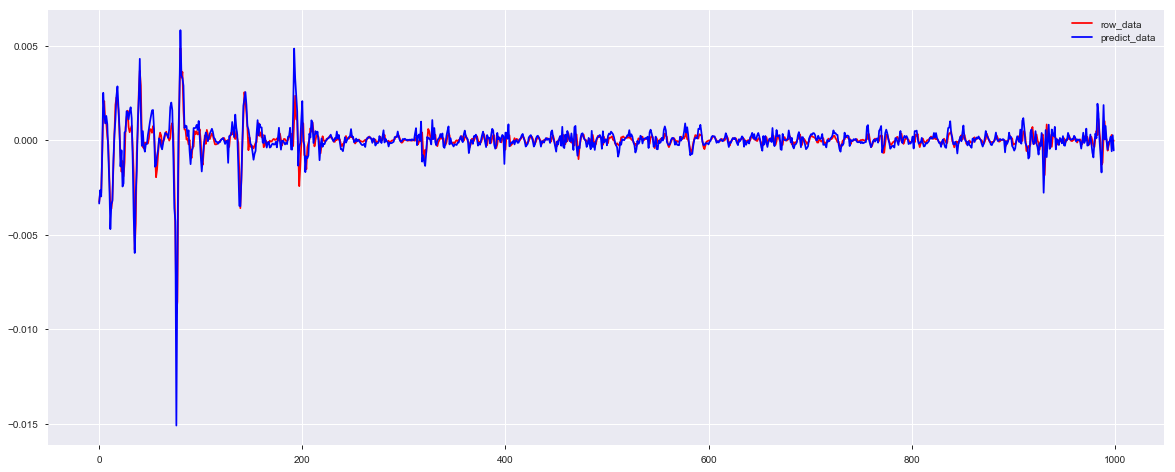

0.016103289420501512

In [76]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[:1000])), train_pred[:1000], color="r", label="row_data")
plt.plot(range(len(y_train[:1000])), y_train[:1000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

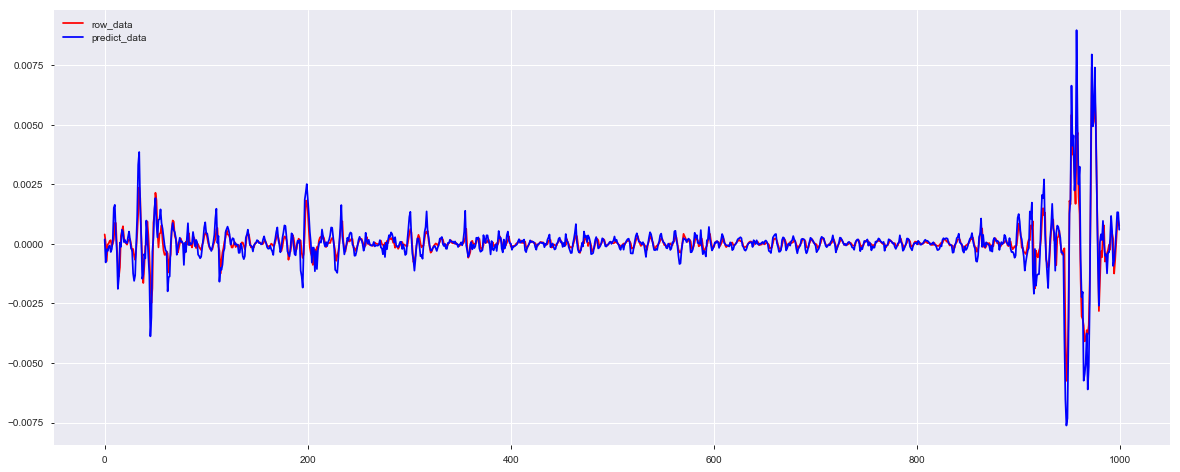

0.016103289420501512

In [58]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[-1000:])), train_pred[-1000:], color="r", label="row_data")
plt.plot(range(len(y_train[-1000:])), y_train[-1000:], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

<Figure size 1440x576 with 0 Axes>

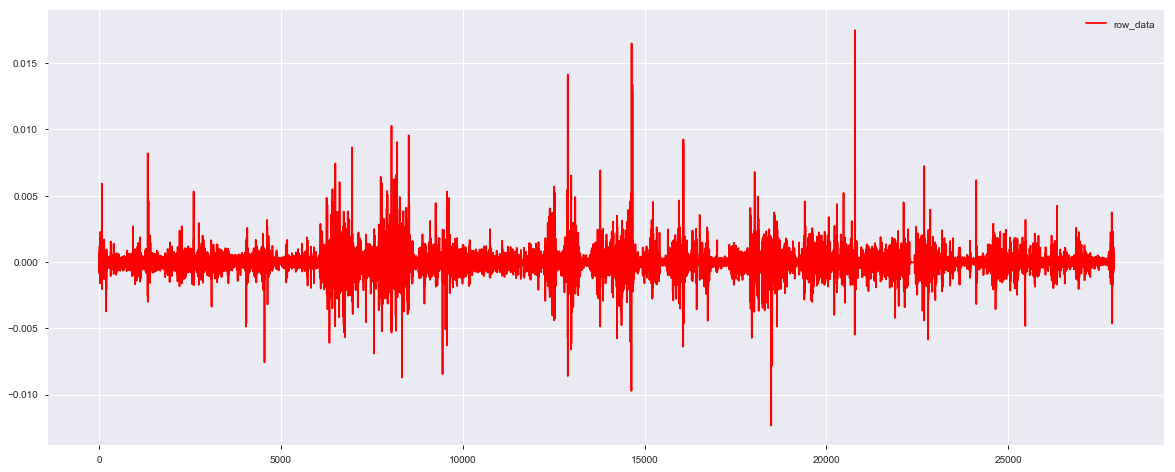

In [59]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train)), train_pred-y_train, color="r", label="row_data")
plt.legend()
plt.show()

In [60]:
summarys['D']

路線    キロ程        傾き     切片    標本標準偏差  測定回数  データ数
0      D  10000 -0.001147 -0.700  0.286509   211    54
1      D  10001  0.003127 -0.450  0.356374   211    44
2      D  10002  0.001817  0.340  0.330879   212    47
3      D  10003  0.001394  1.220  0.193736   213    36
4      D  10004  0.001707  1.525  0.361624   212    40
5      D  10005 -0.001027  0.730  0.528602   213    42
6      D  10006  0.001003 -0.400  0.404685   213    34
7      D  10007  0.000830 -1.035  0.409819   213    41
8      D  10008  0.000127 -0.315  0.872255   214    43
9      D  10009  0.001116  1.695  1.043773   213    70
10     D  10010  0.001359  3.480  0.745599   213    48
11     D  10011  0.000678  3.530  0.725931   213    47
12     D  10012  0.000011  1.050  1.357799   214    37
13     D  10013  0.000970 -3.230  1.687808   213    47
14     D  10014 -0.003161 -6.940  1.488627   213    40
15     D  10015 -0.001981 -7.915  1.340794   214    34
16     D  10016  0.003706 -5.605  1.410871   214    59
17     D  10017 -0.005202 -1.400  1.186849   213    54
18     D  10018 -0.001948  2.390  0.637750   213    61
19     D  10019  0.000506  3.780  0.632278   213    41
20     D  10020 -0.004567  2.760  0.953807   215    48
21     D  10021  0.002721  0.170  0.875594   214    56
22     D  10022  0.003520 -2.540  0.486093   214    47
23     D  10023  0.001814 -3.600  0.283712   215    41
24     D  10024  0.000972 -3.500  0.464590   215    57
25     D  10025 -0.000084 -2.450  0.528559   213    53
26     D  10026 -0.001333 -1.030  0.409837   213    49
27     D  10027  0.000314  0.040  0.265466   215    47
28     D  10028  0.000439  0.370  0.283616   215    48
29     D  10029  0.000052 -0.060  0.337652   216    55
...   ..    ...       ...    ...       ...   ...   ...
15661  D  25661  0.002455  0.030  1.911796   124    32
15662  D  25662  0.002967  0.030  1.783011   125    36
15663  D  25663  0.001352  0.030  2.370271   125    36
15664  D  25664  0.001639  0.030  2.819901   124    33
15665  D  25665 -0.003932  0.030  2.796878   125    38
15666  D  25666 -0.000970  0.030  2.118023   124    41
15667  D  25667 -0.000017  0.030  1.250935   123    43
15668  D  25668  0.000382  0.030  2.062783   122    35
15669  D  25669 -0.000066  0.030  3.723466   122    38
15670  D  25670  0.001041  0.030  4.599753   122    38
15671  D  25671  0.002621  0.030  4.041965   121    23
15672  D  25672  0.002703  0.030  2.327859   123    26
15673  D  25673 -0.001434  0.030  1.854403   128    23
15674  D  25674 -0.005393  0.030  4.045668   143    35
15675  D  25675 -0.007979  0.030  5.501437   148    41
15676  D  25676 -0.000461  0.030  5.554726   148    37
15677  D  25677 -0.005531  0.030  4.699476   157    30
15678  D  25678 -0.006226  0.030  2.796134   179    40
15679  D  25679  0.001742  0.030  1.848619   181    57
15680  D  25680  0.007330  0.030  4.935357   182    42
15681  D  25681  0.003024  0.030  7.565957   184    60
15682  D  25682  0.004497  0.030  8.173189   201    52
15683  D  25683  0.003679  0.030  6.171982   200    43
15684  D  25684  0.001227  0.030  2.474929   184    47
15685  D  25685 -0.009271  0.030  3.905279   182    37
15686  D  25686 -0.001591  0.030  7.093797   182    67
15687  D  25687  0.003163  0.030  7.761797   181    38
15688  D  25688  0.003567  0.030  5.843835   170    43
15689  D  25689  0.002089  0.030  2.752194   166    47
15690  D  25690 -0.001858  0.030  2.316351   153    30

[15691 rows x 7 columns]

In [61]:
train = summarys['D']['傾き'].values
train = pd.DataFrame({'slope': train})
for i in range(30):
    train[f'lag{i+1}'] = train['slope'].shift(i+1)

In [62]:
train

slope      lag0      lag1      lag2      lag3      lag4      lag5  \
0     -0.001147       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.003127 -0.001147       NaN       NaN       NaN       NaN       NaN   
2      0.001817  0.003127 -0.001147       NaN       NaN       NaN       NaN   
3      0.001394  0.001817  0.003127 -0.001147       NaN       NaN       NaN   
4      0.001707  0.001394  0.001817  0.003127 -0.001147       NaN       NaN   
5     -0.001027  0.001707  0.001394  0.001817  0.003127 -0.001147       NaN   
6      0.001003 -0.001027  0.001707  0.001394  0.001817  0.003127 -0.001147   
7      0.000830  0.001003 -0.001027  0.001707  0.001394  0.001817  0.003127   
8      0.000127  0.000830  0.001003 -0.001027  0.001707  0.001394  0.001817   
9      0.001116  0.000127  0.000830  0.001003 -0.001027  0.001707  0.001394   
10     0.001359  0.001116  0.000127  0.000830  0.001003 -0.001027  0.001707   
11     0.000678  0.001359  0.001116  0.000127  0.000830  0.001003 -0.001027   
12     0.000011  0.000678  0.001359  0.001116  0.000127  0.000830  0.001003   
13     0.000970  0.000011  0.000678  0.001359  0.001116  0.000127  0.000830   
14    -0.003161  0.000970  0.000011  0.000678  0.001359  0.001116  0.000127   
15    -0.001981 -0.003161  0.000970  0.000011  0.000678  0.001359  0.001116   
16     0.003706 -0.001981 -0.003161  0.000970  0.000011  0.000678  0.001359   
17    -0.005202  0.003706 -0.001981 -0.003161  0.000970  0.000011  0.000678   
18    -0.001948 -0.005202  0.003706 -0.001981 -0.003161  0.000970  0.000011   
19     0.000506 -0.001948 -0.005202  0.003706 -0.001981 -0.003161  0.000970   
20    -0.004567  0.000506 -0.001948 -0.005202  0.003706 -0.001981 -0.003161   
21     0.002721 -0.004567  0.000506 -0.001948 -0.005202  0.003706 -0.001981   
22     0.003520  0.002721 -0.004567  0.000506 -0.001948 -0.005202  0.003706   
23     0.001814  0.003520  0.002721 -0.004567  0.000506 -0.001948 -0.005202   
24     0.000972  0.001814  0.003520  0.002721 -0.004567  0.000506 -0.001948   
25    -0.000084  0.000972  0.001814  0.003520  0.002721 -0.004567  0.000506   
26    -0.001333 -0.000084  0.000972  0.001814  0.003520  0.002721 -0.004567   
27     0.000314 -0.001333 -0.000084  0.000972  0.001814  0.003520  0.002721   
28     0.000439  0.000314 -0.001333 -0.000084  0.000972  0.001814  0.003520   
29     0.000052  0.000439  0.000314 -0.001333 -0.000084  0.000972  0.001814   
...         ...       ...       ...       ...       ...       ...       ...   
15661  0.002455  0.001670 -0.000127 -0.000164  0.000736 -0.001078  0.002486   
15662  0.002967  0.002455  0.001670 -0.000127 -0.000164  0.000736 -0.001078   
15663  0.001352  0.002967  0.002455  0.001670 -0.000127 -0.000164  0.000736   
15664  0.001639  0.001352  0.002967  0.002455  0.001670 -0.000127 -0.000164   
15665 -0.003932  0.001639  0.001352  0.002967  0.002455  0.001670 -0.000127   
15666 -0.000970 -0.003932  0.001639  0.001352  0.002967  0.002455  0.001670   
15667 -0.000017 -0.000970 -0.003932  0.001639  0.001352  0.002967  0.002455   
15668  0.000382 -0.000017 -0.000970 -0.003932  0.001639  0.001352  0.002967   
15669 -0.000066  0.000382 -0.000017 -0.000970 -0.003932  0.001639  0.001352   
15670  0.001041 -0.000066  0.000382 -0.000017 -0.000970 -0.003932  0.001639   
15671  0.002621  0.001041 -0.000066  0.000382 -0.000017 -0.000970 -0.003932   
15672  0.002703  0.002621  0.001041 -0.000066  0.000382 -0.000017 -0.000970   
15673 -0.001434  0.002703  0.002621  0.001041 -0.000066  0.000382 -0.000017   
15674 -0.005393 -0.001434  0.002703  0.002621  0.001041 -0.000066  0.000382   
15675 -0.007979 -0.005393 -0.001434  0.002703  0.002621  0.001041 -0.000066   
15676 -0.000461 -0.007979 -0.005393 -0.001434  0.002703  0.002621  0.001041   
15677 -0.005531 -0.000461 -0.007979 -0.005393 -0.001434  0.002703  0.002621   
15678 -0.006226 -0.005531 -0.000461 -0.007979 -0.005393 -0.001434  0.002703   
15679  0.001742 -0.006226 -0.005531 -0.000461 -0.007979 -0.0

In [63]:
X_train = train.drop(['slope'], axis=1).values
y_train = train['slope'].values
lgb.fit(X_train, y_train)
train_pred = lgb.predict(X_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<Figure size 1440x576 with 0 Axes>

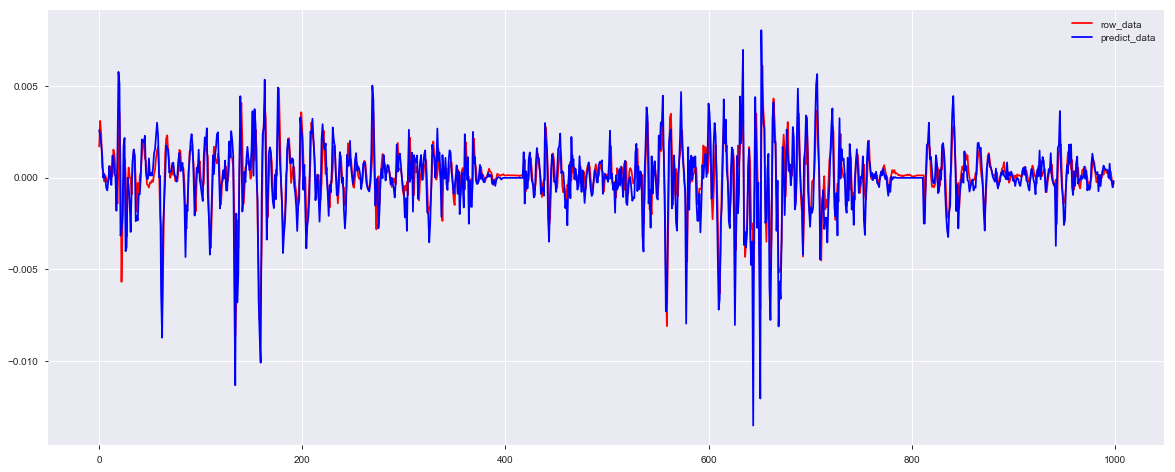

0.03287575026845605

In [64]:
plt.figure(figsize=(20, 8))
plt.plot(range(len(y_train[3000:4000])), train_pred[3000:4000], color="r", label="row_data")
plt.plot(range(len(y_train[3000:4000])), y_train[3000:4000], color="b", label="predict_data")
plt.legend()
plt.show()
sum((train_pred - y_train)**2)

In [77]:
for no in ['A', 'B', 'C', 'D']:
    train = summarys[no]['傾き'].values
    train = pd.DataFrame({'slope': train})
    for i in range(30):
        train[f'lag{i+1}'] = train['slope'].shift(i+1)

    X_train = train.drop(['slope'], axis=1).values
    y_train = train['slope'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys[no]['傾き'] = train_pred

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [78]:
for no in ['A', 'B', 'C', 'D']:
    summarys[no].to_csv(f'summary12_{no}_lgbm.csv')

In [79]:
# %%time
# submit = pd.DataFrame()
# for no in ['A', 'B', 'C', 'D']:
#     track = tracks[no]
#     summary = summarys[no]
#     summary = summary.dropna()

#     sub = pd.DataFrame()
#     sub['キロ程'] = track['キロ程'].unique()
#     sub['路線'] = no

#     kilos = summary['キロ程'].values
#     inds = kilos.astype(int) - 10000

#     sub.loc[inds, '傾き'] = summary['傾き'].values
#     sub.loc[inds, '切片'] = summary['切片'].values
    
#     submit = pd.concat([submit, sub], axis=0)
# submit = submit.reset_index(drop=True)

CPU times: user 1.45 s, sys: 381 ms, total: 1.83 s
Wall time: 1.89 s


In [99]:
%%time
submit = pd.DataFrame()
for no in ['A', 'B', 'C', 'D']:
    track = tracks[no]
    summary = summarys[no]

    sub = pd.DataFrame()
    sub['キロ程'] = track['キロ程'].unique()
    sub['路線'] = no

    sub['傾き'] = summary['傾き'].values
    sub['切片'] = summary['切片'].values
    
    submit = pd.concat([submit, sub], axis=0)
submit = submit.reset_index(drop=True)

CPU times: user 1.07 s, sys: 94.9 ms, total: 1.16 s
Wall time: 1.18 s


In [107]:
pdp.ProfileReport(submit)

In [108]:
p = []
last_median_day = 30
for no in ['A', 'B', 'C', 'D']:
    tmp = submit[submit['路線'] == no]
    for i in range(91):
        day = tmp['切片'].values + tmp['傾き'].values*(i+last_median_day//2)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [109]:
submision.max()

0    18.31
dtype: float64

In [110]:
submision.min()

0   -17.84
dtype: float64

In [111]:
submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [112]:
submision.max()

0    16.0
dtype: float64

In [113]:
submision.min()

0   -16.0
dtype: float64

In [114]:
len(submision[submision[0] == 16])
len(submision[submision[0] == -16])

376

708

In [87]:
submision

0
0          0.33
1          2.64
2          4.96
3          5.94
4          5.03
5          1.68
6         -3.16
7         -7.12
8         -8.85
9         -7.41
10        -3.37
11         1.10
12         4.55
13         5.41
14         3.73
15         1.02
16        -2.75
17        -4.82
18        -5.00
19        -3.67
20        -1.90
21        -0.32
22         0.10
23         0.29
24         0.98
25         2.32
26         3.85
27         4.07
28         1.94
29        -2.00
...         ...
10993862  -0.20
10993863  -1.04
10993864  -1.59
10993865  -1.77
10993866  -1.02
10993867   0.37
10993868   3.07
10993869   3.98
10993870   4.51
10993871   3.99
10993872   2.52
10993873  -0.65
10993874  -4.67
10993875  -7.49
10993876  -7.61
10993877  -5.72
10993878  -2.61
10993879   0.54
10993880   3.94
10993881   7.39
10993882   8.00
10993883   6.61
10993884   3.52
10993885  -1.23
10993886  -6.79
10993887 -11.21
10993888  -9.55
10993889  -5.01
10993890   0.24
10993891   3.74

[10993892 rows x 1 columns]

Text(0.5, 1.0, 'kilo: 28723,  kilo_id: 18723')

Text(0.5, 1.0, 'kilo: 11067,  kilo_id: 1067')

Text(0.5, 1.0, 'kilo: 24053,  kilo_id: 14053')

Text(0.5, 1.0, 'kilo: 25812,  kilo_id: 15812')

Text(0.5, 1.0, 'kilo: 28942,  kilo_id: 18942')

Text(0.5, 1.0, 'kilo: 10486,  kilo_id: 486')

Text(0.5, 1.0, 'kilo: 16753,  kilo_id: 6753')

Text(0.5, 1.0, 'kilo: 25157,  kilo_id: 15157')

Text(0.5, 1.0, 'kilo: 36650,  kilo_id: 26650')

Text(0.5, 1.0, 'kilo: 26098,  kilo_id: 16098')

Text(0.5, 1.0, 'kilo: 36987,  kilo_id: 26987')

Text(0.5, 1.0, 'kilo: 19093,  kilo_id: 9093')

Text(0.5, 1.0, 'kilo: 31412,  kilo_id: 21412')

Text(0.5, 1.0, 'kilo: 36562,  kilo_id: 26562')

Text(0.5, 1.0, 'kilo: 15250,  kilo_id: 5250')

Text(0.5, 1.0, 'kilo: 11127,  kilo_id: 1127')

Text(0.5, 1.0, 'kilo: 27061,  kilo_id: 17061')

Text(0.5, 1.0, 'kilo: 26059,  kilo_id: 16059')

Text(0.5, 1.0, 'kilo: 20740,  kilo_id: 10740')

Text(0.5, 1.0, 'kilo: 12493,  kilo_id: 2493')

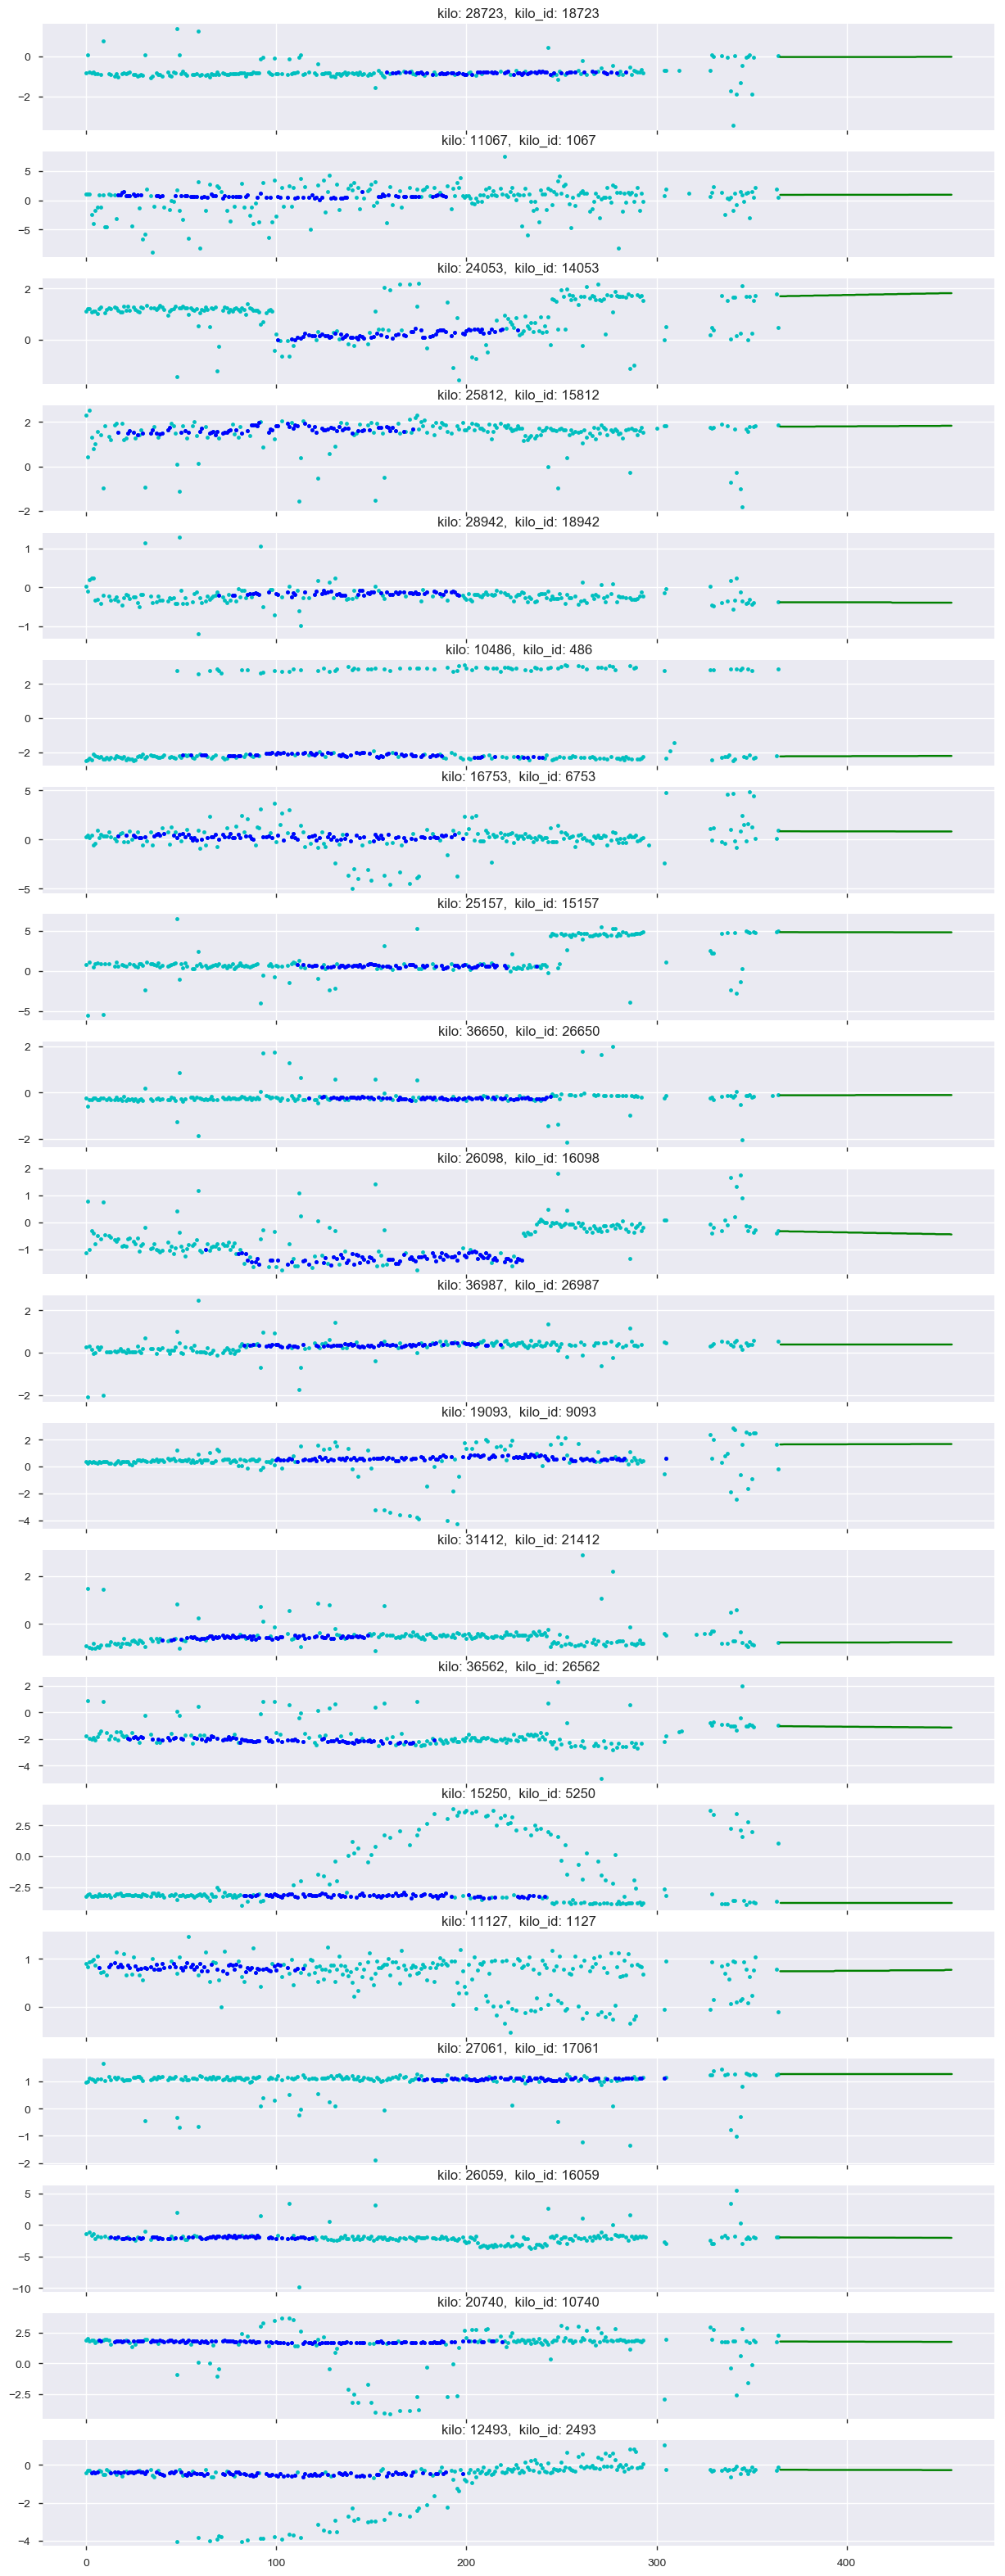

In [88]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 22623,  kilo_id: 12623')

Text(0.5, 1.0, 'kilo: 23781,  kilo_id: 13781')

Text(0.5, 1.0, 'kilo: 11326,  kilo_id: 1326')

Text(0.5, 1.0, 'kilo: 18484,  kilo_id: 8484')

Text(0.5, 1.0, 'kilo: 26753,  kilo_id: 16753')

Text(0.5, 1.0, 'kilo: 25922,  kilo_id: 15922')

Text(0.5, 1.0, 'kilo: 23268,  kilo_id: 13268')

Text(0.5, 1.0, 'kilo: 19938,  kilo_id: 9938')

Text(0.5, 1.0, 'kilo: 25617,  kilo_id: 15617')

Text(0.5, 1.0, 'kilo: 21732,  kilo_id: 11732')

Text(0.5, 1.0, 'kilo: 29116,  kilo_id: 19116')

Text(0.5, 1.0, 'kilo: 17157,  kilo_id: 7157')

Text(0.5, 1.0, 'kilo: 26537,  kilo_id: 16537')

Text(0.5, 1.0, 'kilo: 14563,  kilo_id: 4563')

Text(0.5, 1.0, 'kilo: 19235,  kilo_id: 9235')

Text(0.5, 1.0, 'kilo: 14579,  kilo_id: 4579')

Text(0.5, 1.0, 'kilo: 13107,  kilo_id: 3107')

Text(0.5, 1.0, 'kilo: 30262,  kilo_id: 20262')

Text(0.5, 1.0, 'kilo: 18208,  kilo_id: 8208')

Text(0.5, 1.0, 'kilo: 27451,  kilo_id: 17451')

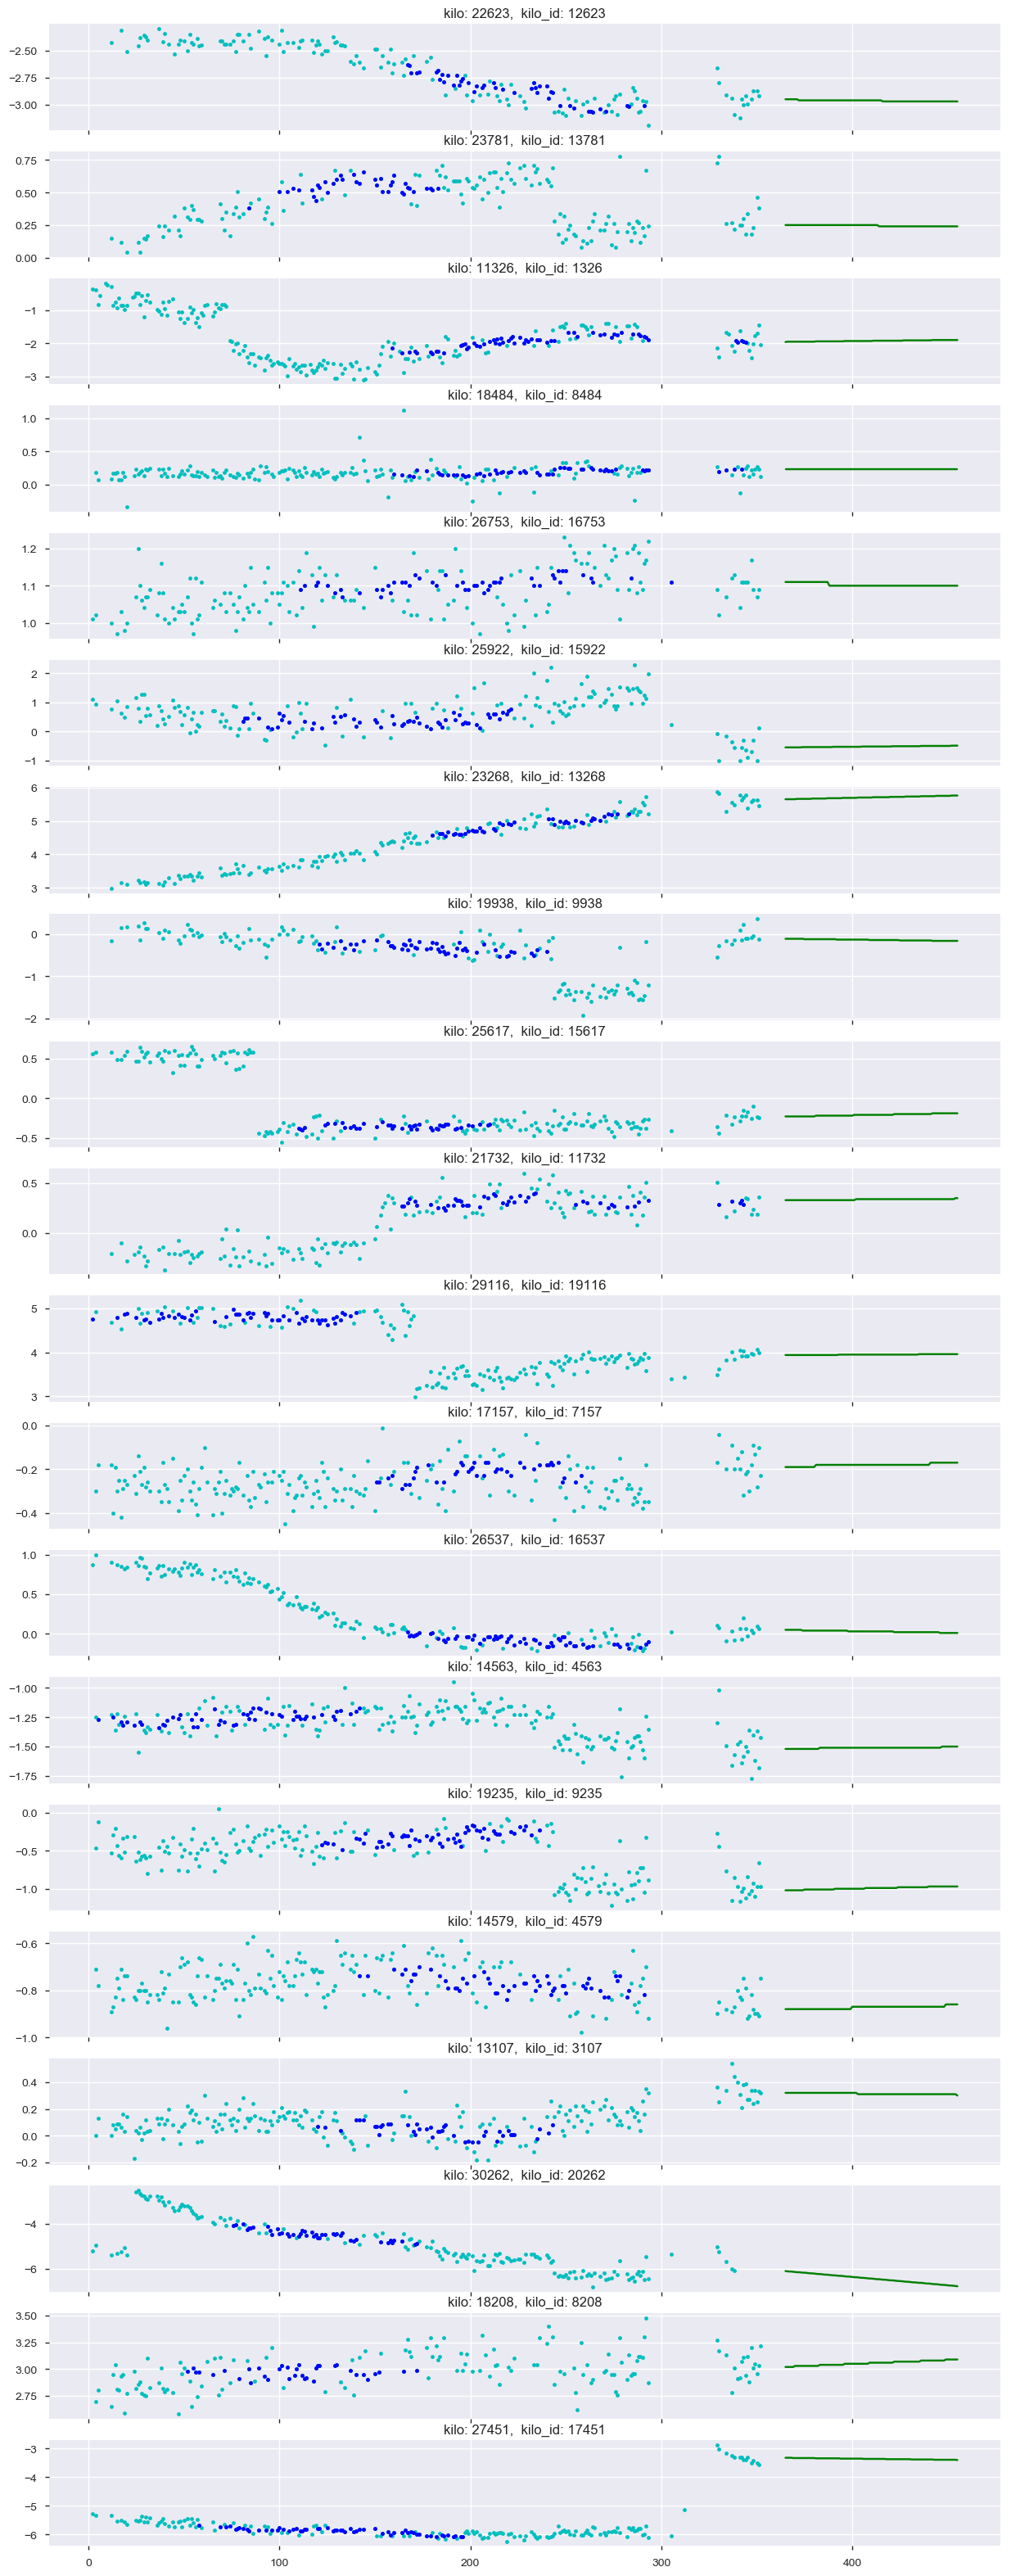

In [89]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')



    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 65340,  kilo_id: 55340')

Text(0.5, 1.0, 'kilo: 35247,  kilo_id: 25247')

Text(0.5, 1.0, 'kilo: 59673,  kilo_id: 49673')

Text(0.5, 1.0, 'kilo: 37562,  kilo_id: 27562')

Text(0.5, 1.0, 'kilo: 12653,  kilo_id: 2653')

Text(0.5, 1.0, 'kilo: 26968,  kilo_id: 16968')

Text(0.5, 1.0, 'kilo: 43506,  kilo_id: 33506')

Text(0.5, 1.0, 'kilo: 41845,  kilo_id: 31845')

Text(0.5, 1.0, 'kilo: 36537,  kilo_id: 26537')

Text(0.5, 1.0, 'kilo: 61367,  kilo_id: 51367')

Text(0.5, 1.0, 'kilo: 64385,  kilo_id: 54385')

Text(0.5, 1.0, 'kilo: 29877,  kilo_id: 19877')

Text(0.5, 1.0, 'kilo: 41234,  kilo_id: 31234')

Text(0.5, 1.0, 'kilo: 33465,  kilo_id: 23465')

Text(0.5, 1.0, 'kilo: 48232,  kilo_id: 38232')

Text(0.5, 1.0, 'kilo: 24315,  kilo_id: 14315')

Text(0.5, 1.0, 'kilo: 43075,  kilo_id: 33075')

Text(0.5, 1.0, 'kilo: 19127,  kilo_id: 9127')

Text(0.5, 1.0, 'kilo: 28470,  kilo_id: 18470')

Text(0.5, 1.0, 'kilo: 19158,  kilo_id: 9158')

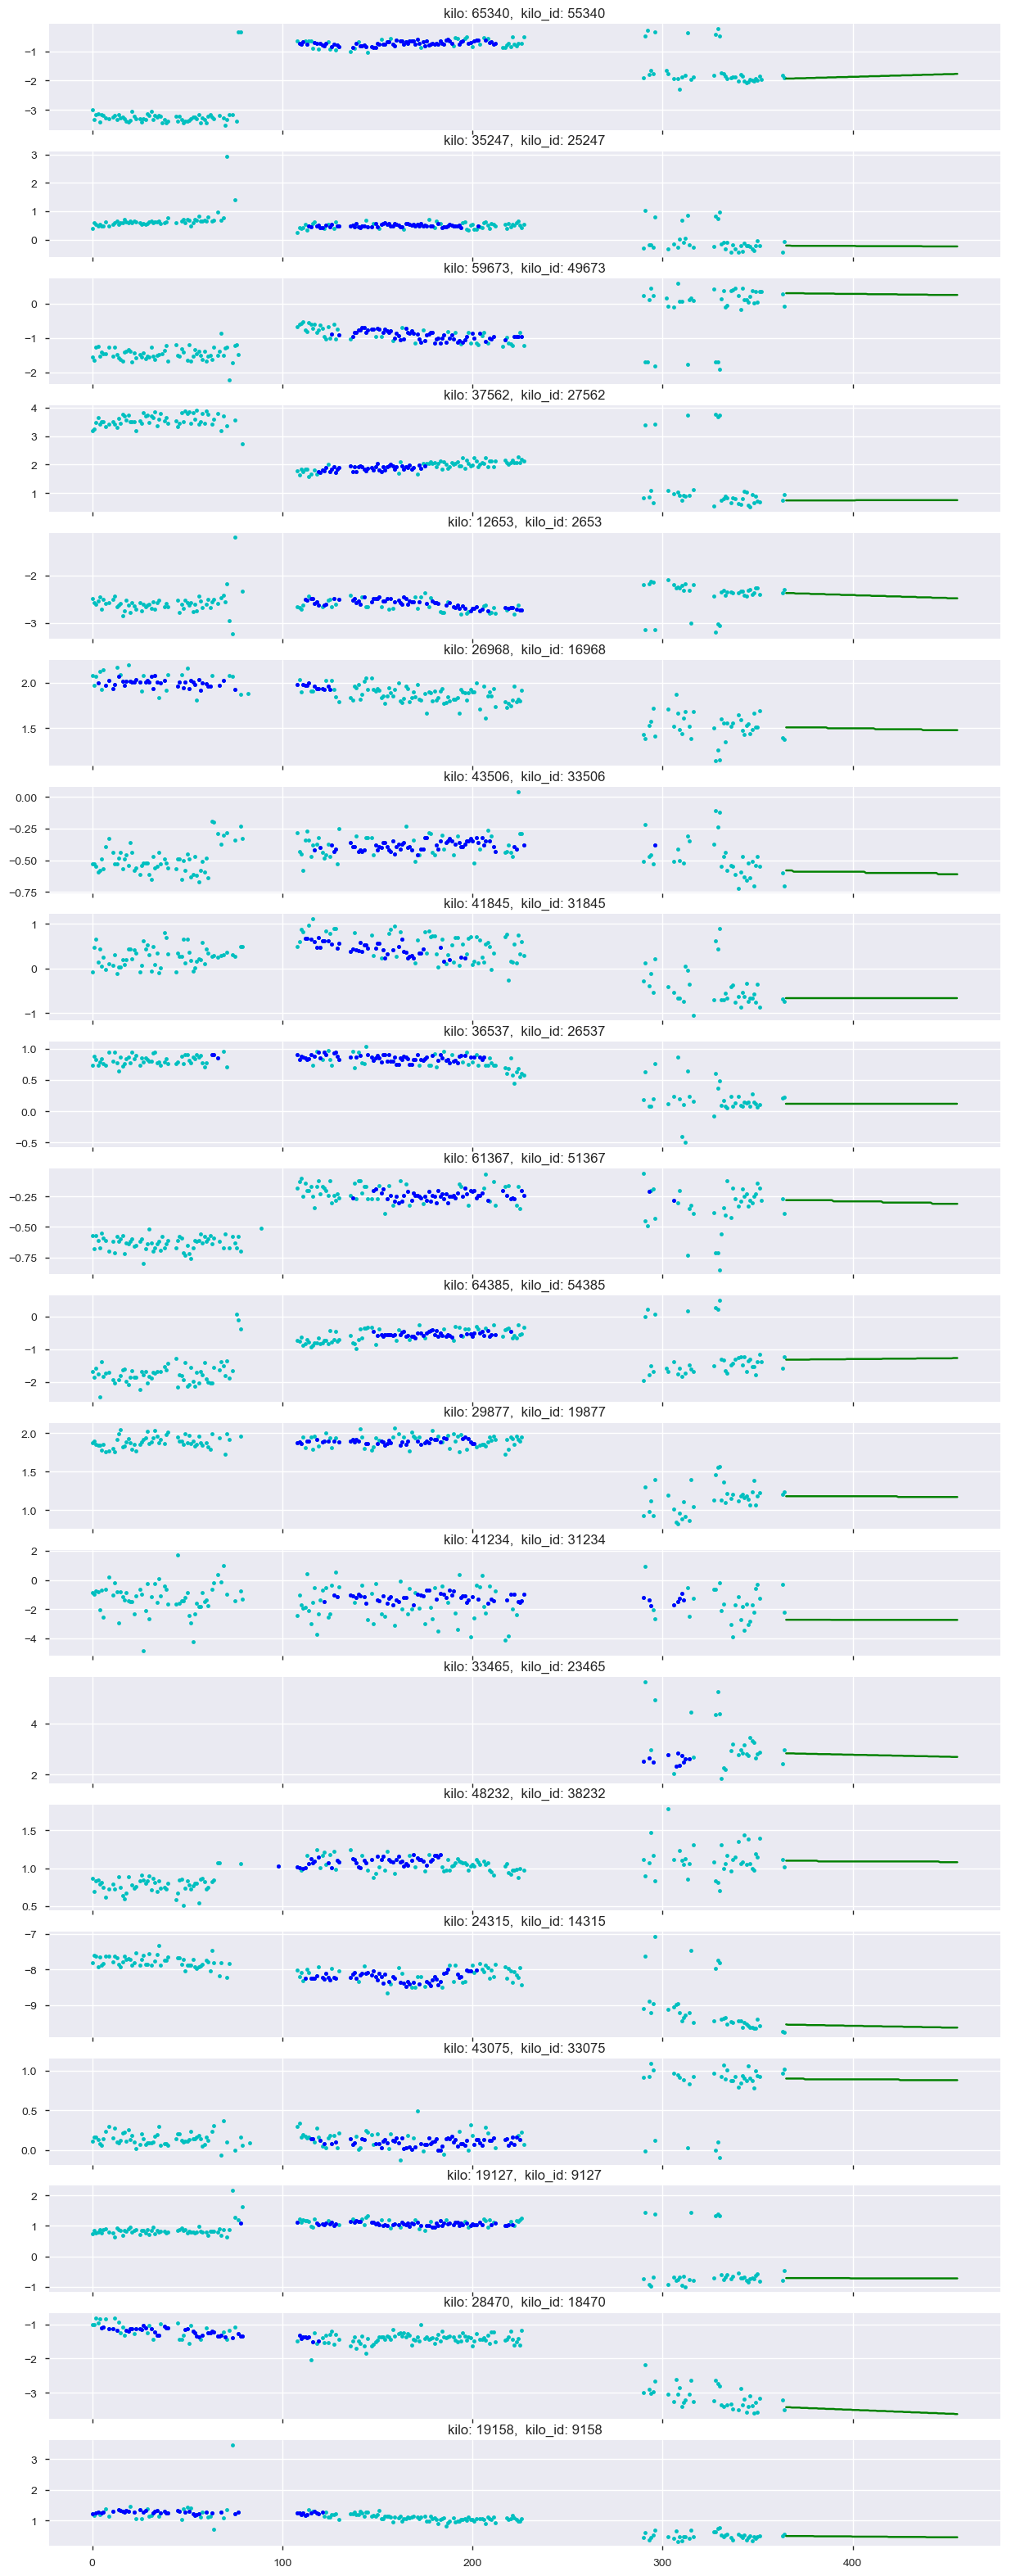

In [90]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

Text(0.5, 1.0, 'kilo: 23835,  kilo_id: 13835')

Text(0.5, 1.0, 'kilo: 16311,  kilo_id: 6311')

Text(0.5, 1.0, 'kilo: 22418,  kilo_id: 12418')

Text(0.5, 1.0, 'kilo: 24585,  kilo_id: 14585')

Text(0.5, 1.0, 'kilo: 16890,  kilo_id: 6890')

Text(0.5, 1.0, 'kilo: 10663,  kilo_id: 663')

Text(0.5, 1.0, 'kilo: 14242,  kilo_id: 4242')

Text(0.5, 1.0, 'kilo: 18376,  kilo_id: 8376')

Text(0.5, 1.0, 'kilo: 17961,  kilo_id: 7961')

Text(0.5, 1.0, 'kilo: 16634,  kilo_id: 6634')

Text(0.5, 1.0, 'kilo: 25044,  kilo_id: 15044')

Text(0.5, 1.0, 'kilo: 22841,  kilo_id: 12841')

Text(0.5, 1.0, 'kilo: 23596,  kilo_id: 13596')

Text(0.5, 1.0, 'kilo: 14969,  kilo_id: 4969')

Text(0.5, 1.0, 'kilo: 17808,  kilo_id: 7808')

Text(0.5, 1.0, 'kilo: 15866,  kilo_id: 5866')

Text(0.5, 1.0, 'kilo: 19558,  kilo_id: 9558')

Text(0.5, 1.0, 'kilo: 24608,  kilo_id: 14608')

Text(0.5, 1.0, 'kilo: 24878,  kilo_id: 14878')

Text(0.5, 1.0, 'kilo: 13578,  kilo_id: 3578')

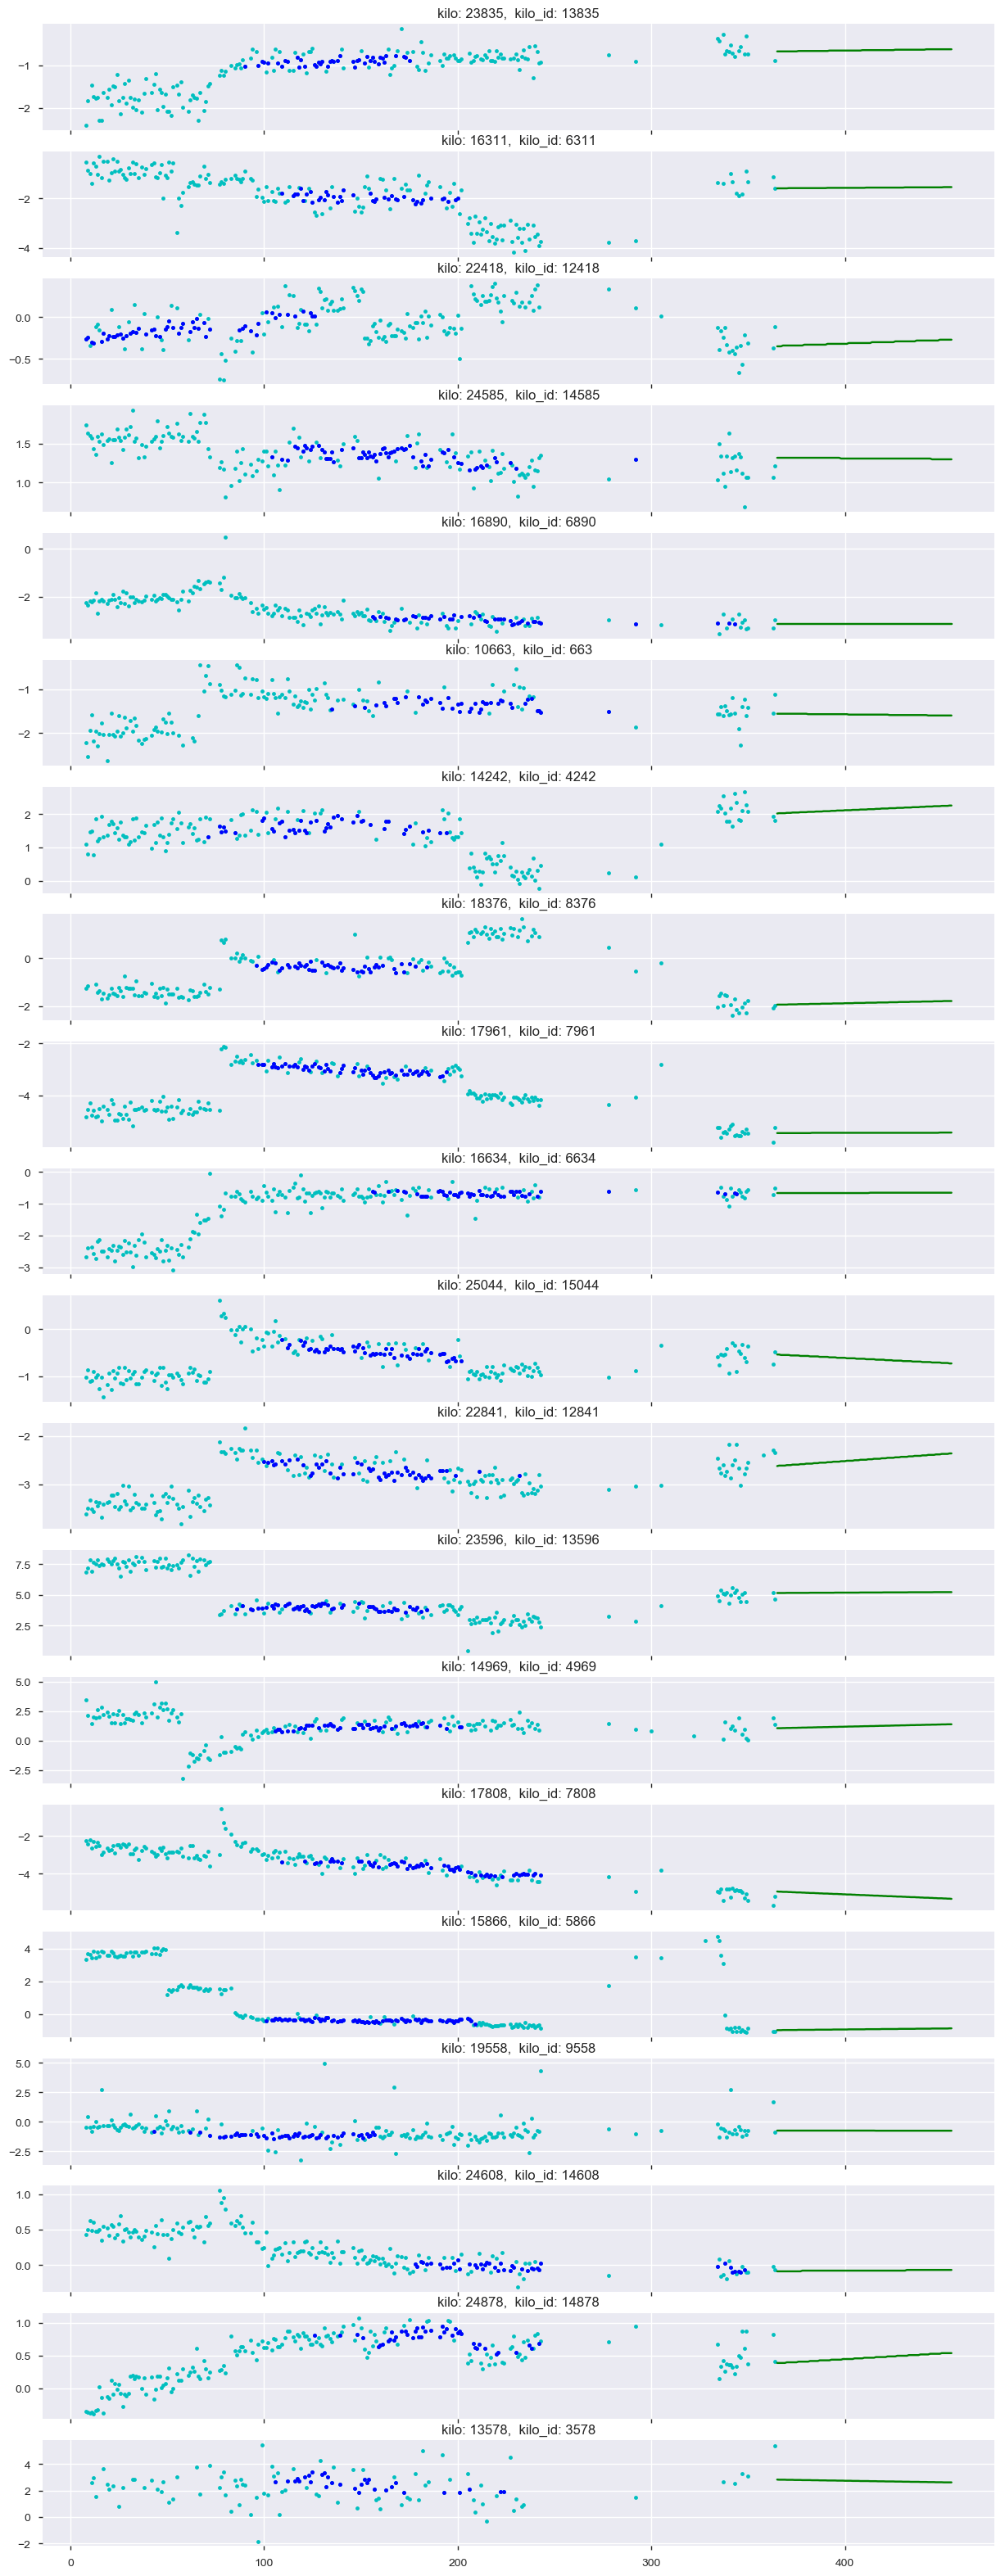

In [91]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')


    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [92]:
submision.to_csv("submit12.csv", header=None)